# WGAN Training

## imports

In [1]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.4
config.gpu_options.allow_growth=True
set_session(tf.Session(config=config))

Using TensorFlow backend.


In [2]:
%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt

from models.WassersteinGenerativeAdversarialNetwork import WassersteinGenerativeAdversarialNetwork as WGAN
from utils.loaders import load_cifar



In [3]:
# run params
SECTION = 'wgan'
RUN_ID = '0005'
DATA_NAME = 'horses'
RUN_FOLDER = f'run/{SECTION}/'
RUN_FOLDER += f'{RUN_ID}_{DATA_NAME}'

for p in ['run', f'run/{SECTION}']:
    if not os.path.exists(p):
        os.mkdir(p)

if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'build' #'load' #


## data

In [4]:
if DATA_NAME == 'cars':
    label = 1
elif DATA_NAME == 'horses':
    label = 7
(x_train, y_train) = load_cifar(label, 10)


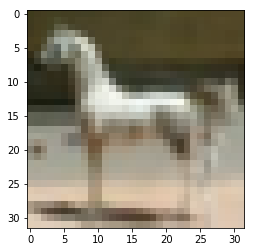

In [5]:
plt.imshow((x_train[150,:,:,:]+1)/2)

## architecture

In [6]:
image_dim = (32,32,3)
latent_dim = 100

generator_initial_dim = (4, 4, 128)

generator_activation = 'leaky_relu'
critic_activation = 'leaky_relu'

critic_learning_rate = 0.00005,
generator_learning_rate = 0.00005,
generator_batch_norm_momentum = 0.8
critic_batch_norm_momentum = None
critic_dense_dim = 0
generator_dropout_rate = None
critic_dropout_rate = None

generator_convolutional_params = [
    {'strides': (1, 1), 'filters': 128, 'kernel_size': (5, 5), 'upsample': 2, },
    {'strides': (1, 1), 'filters': 64, 'kernel_size': (5, 5), 'upsample': 2, },
    {'strides': (1, 1), 'filters': 32, 'kernel_size': (5, 5), 'upsample': 2, },
    {'strides': (1, 1), 'filters': 3, 'kernel_size': (5, 5), 'upsample': 1, },
    ]

critic_convolutional_params = [
    {'strides': (2, 2), 'filters': 32, 'kernel_size': (5, 5),},
    {'strides': (2, 2), 'filters': 64, 'kernel_size': (5, 5),},
    {'strides': (2, 2), 'filters': 128, 'kernel_size': (5, 5),},
    {'strides': (1, 1), 'filters': 128, 'kernel_size': (5, 5),},
    ]

In [7]:
if mode == 'build':
    gan = WGAN(
        image_dim=image_dim,
        latent_dim=latent_dim,
        generator_initial_dim=generator_initial_dim,
        critic_dense_dim=critic_dense_dim,
        generator_activation=generator_activation,
        critic_activation=critic_activation,
        generator_convolutional_params=generator_convolutional_params,
        critic_learning_rate = critic_learning_rate,
        generator_learning_rate = generator_learning_rate,
        critic_convolutional_params=critic_convolutional_params,
        generator_batch_norm_momentum=generator_batch_norm_momentum,
        critic_batch_norm_momentum=critic_batch_norm_momentum,
        generator_dropout_rate=generator_dropout_rate,
        critic_dropout_rate=critic_dropout_rate,
        )
    gan.save(RUN_FOLDER)

else:
    gan.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))








W0608 20:00:03.307393 139777653196544 deprecation.py:506] From /home/comadan/.venv/gdl/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [8]:
gan.critic_model.summary()

Model: "critic_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
critic_input (InputLayer)    (None, 32, 32, 3)         0         
_________________________________________________________________
critic_conv2d_0 (Conv2D)     (None, 16, 16, 32)        2432      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16, 16, 32)        0         
_________________________________________________________________
critic_conv2d_1 (Conv2D)     (None, 8, 8, 64)          51264     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 64)          0         
_________________________________________________________________
critic_conv2d_2 (Conv2D)     (None, 4, 4, 128)         204928    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 4, 4, 128)        

In [9]:
gan.generator_model.summary()

Model: "generator_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_input (InputLayer) (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              206848    
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 2048)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 128)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 8, 8, 128)         0         
_________________________________________________________________
generator_conv2d_0 (Conv2D)  (None, 8, 8, 128)     

## training

In [10]:
BATCH_SIZE = 128
EPOCHS = 24000
PRINT_EVERY_N_BATCHES = 5
N_CRITIC = 5 # using double here, because book separates true and generated examples.
CLIP_THRESHOLD = 0.01

In [11]:
gan.train(     
    x_train
    , batch_size=BATCH_SIZE
    , epochs=EPOCHS
    , run_folder=RUN_FOLDER
    , print_every_n_batches=PRINT_EVERY_N_BATCHES
    , critic_training_steps=N_CRITIC
    , clip_threshold=CLIP_THRESHOLD
    , alternating_critic=False
)

W0608 20:00:07.439428 139777653196544 module_wrapper.py:139] From /home/comadan/.venv/gdl/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.

/home/comadan/.venv/gdl/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch: 0  disc. loss: (v: -0.001 g: -0.000) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.000 acc.: 0.000


/home/comadan/.venv/gdl/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch: 1  disc. loss: (v: -0.002 g: -0.001) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.001 acc.: 0.000
epoch: 2  disc. loss: (v: -0.005 g: -0.001) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.004 acc.: 0.000
epoch: 3  disc. loss: (v: -0.018 g: -0.001) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.017 acc.: 0.000
epoch: 4  disc. loss: (v: -0.052 g: 0.002) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.055 acc.: 0.000
epoch: 5  disc. loss: (v: -0.124 g: 0.023) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.156 acc.: 0.000
epoch: 6  disc. loss: (v: -0.224 g: 0.052) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.334 acc.: 0.000
epoch: 7  disc. loss: (v: -0.394 g: 0.129) acc.: (v: 0.156 g: 0.000)  gen. loss:-0.633 acc.: 0.898
epoch: 8  disc. loss: (v: -0.578 g: 0.305) acc.: (v: 0.711 g: 0.000)  gen. loss:-0.990 acc.: 0.992
epoch: 9  disc. loss: (v: -0.761 g: 0.495) acc.: (v: 0.898 g: 0.000)  gen. loss:-1.270 acc.: 0.906
epoch: 10  disc. loss: (v: -0.874 g: 0.648) acc.: (v: 0.953 g: 0.000)  gen. loss:-1.419 acc.: 0.570
epoch:

epoch: 83  disc. loss: (v: -5.922 g: 2.677) acc.: (v: 0.031 g: 0.039)  gen. loss:-1.921 acc.: 0.188
epoch: 84  disc. loss: (v: -2.560 g: -0.310) acc.: (v: 0.117 g: 0.492)  gen. loss:-1.474 acc.: 0.312
epoch: 85  disc. loss: (v: -6.053 g: 2.618) acc.: (v: 0.039 g: 0.094)  gen. loss:-2.647 acc.: 0.172
epoch: 86  disc. loss: (v: -2.665 g: 0.405) acc.: (v: 0.172 g: 0.070)  gen. loss:-0.261 acc.: 0.312
epoch: 87  disc. loss: (v: -5.248 g: 2.165) acc.: (v: 0.062 g: 0.094)  gen. loss:-2.483 acc.: 0.102
epoch: 88  disc. loss: (v: -2.303 g: 0.134) acc.: (v: 0.070 g: 0.242)  gen. loss:0.016 acc.: 0.211
epoch: 89  disc. loss: (v: -6.607 g: 4.120) acc.: (v: 0.039 g: 0.070)  gen. loss:-4.308 acc.: 0.055
epoch: 90  disc. loss: (v: -4.274 g: 1.721) acc.: (v: 0.055 g: 0.016)  gen. loss:-0.367 acc.: 0.281
epoch: 91  disc. loss: (v: -6.181 g: 3.270) acc.: (v: 0.023 g: 0.109)  gen. loss:-4.787 acc.: 0.070
epoch: 92  disc. loss: (v: -3.516 g: 1.100) acc.: (v: 0.086 g: 0.094)  gen. loss:-1.226 acc.: 0.281


epoch: 164  disc. loss: (v: -22.454 g: 17.435) acc.: (v: 0.000 g: 0.000)  gen. loss:-20.434 acc.: 0.000
epoch: 165  disc. loss: (v: -17.727 g: 13.475) acc.: (v: 0.000 g: 0.000)  gen. loss:-15.025 acc.: 0.000
epoch: 166  disc. loss: (v: -19.221 g: 15.058) acc.: (v: 0.000 g: 0.000)  gen. loss:-14.471 acc.: 0.000
epoch: 167  disc. loss: (v: -21.214 g: 16.479) acc.: (v: 0.000 g: 0.000)  gen. loss:-16.159 acc.: 0.000
epoch: 168  disc. loss: (v: -18.978 g: 13.568) acc.: (v: 0.000 g: 0.000)  gen. loss:-10.110 acc.: 0.008
epoch: 169  disc. loss: (v: -25.709 g: 17.334) acc.: (v: 0.008 g: 0.023)  gen. loss:-25.247 acc.: 0.000
epoch: 170  disc. loss: (v: -14.721 g: 7.512) acc.: (v: 0.008 g: 0.023)  gen. loss:-8.901 acc.: 0.023
epoch: 171  disc. loss: (v: -19.475 g: 14.024) acc.: (v: 0.000 g: 0.000)  gen. loss:-15.096 acc.: 0.000
epoch: 172  disc. loss: (v: -17.624 g: 11.447) acc.: (v: 0.000 g: 0.023)  gen. loss:-14.310 acc.: 0.031
epoch: 173  disc. loss: (v: -12.338 g: 5.784) acc.: (v: 0.016 g: 0

epoch: 244  disc. loss: (v: -18.029 g: 13.228) acc.: (v: 0.000 g: 0.000)  gen. loss:-13.444 acc.: 0.000
epoch: 245  disc. loss: (v: -29.127 g: 24.337) acc.: (v: 0.000 g: 0.008)  gen. loss:-25.167 acc.: 0.000
epoch: 246  disc. loss: (v: -17.280 g: 8.374) acc.: (v: 0.016 g: 0.016)  gen. loss:-14.456 acc.: 0.016
epoch: 247  disc. loss: (v: -26.638 g: 23.156) acc.: (v: 0.000 g: 0.000)  gen. loss:-26.252 acc.: 0.000
epoch: 248  disc. loss: (v: -21.074 g: 16.102) acc.: (v: 0.000 g: 0.000)  gen. loss:-12.119 acc.: 0.000
epoch: 249  disc. loss: (v: -37.616 g: 28.204) acc.: (v: 0.000 g: 0.016)  gen. loss:-33.964 acc.: 0.023
epoch: 250  disc. loss: (v: -19.459 g: 14.073) acc.: (v: 0.000 g: 0.000)  gen. loss:-12.033 acc.: 0.031
epoch: 251  disc. loss: (v: -23.082 g: 17.944) acc.: (v: 0.000 g: 0.000)  gen. loss:-20.125 acc.: 0.008
epoch: 252  disc. loss: (v: -17.011 g: 11.058) acc.: (v: 0.008 g: 0.016)  gen. loss:-9.052 acc.: 0.039
epoch: 253  disc. loss: (v: -17.651 g: 13.747) acc.: (v: 0.000 g: 

epoch: 323  disc. loss: (v: -18.814 g: 13.164) acc.: (v: 0.000 g: 0.000)  gen. loss:-11.076 acc.: 0.000
epoch: 324  disc. loss: (v: -16.383 g: 10.200) acc.: (v: 0.000 g: 0.008)  gen. loss:-11.962 acc.: 0.016
epoch: 325  disc. loss: (v: -12.643 g: 6.925) acc.: (v: 0.008 g: 0.016)  gen. loss:-11.760 acc.: 0.008
epoch: 326  disc. loss: (v: -24.889 g: 18.893) acc.: (v: 0.000 g: 0.000)  gen. loss:-21.557 acc.: 0.016
epoch: 327  disc. loss: (v: -17.636 g: 8.580) acc.: (v: 0.008 g: 0.062)  gen. loss:-10.683 acc.: 0.023
epoch: 328  disc. loss: (v: -32.408 g: 24.672) acc.: (v: 0.000 g: 0.008)  gen. loss:-28.118 acc.: 0.023
epoch: 329  disc. loss: (v: -17.934 g: 11.307) acc.: (v: 0.008 g: 0.016)  gen. loss:-9.375 acc.: 0.055
epoch: 330  disc. loss: (v: -21.346 g: 16.810) acc.: (v: 0.000 g: 0.000)  gen. loss:-15.387 acc.: 0.000
epoch: 331  disc. loss: (v: -18.986 g: 13.440) acc.: (v: 0.000 g: 0.000)  gen. loss:-13.031 acc.: 0.000
epoch: 332  disc. loss: (v: -26.137 g: 20.584) acc.: (v: 0.008 g: 0

epoch: 402  disc. loss: (v: -17.563 g: 13.181) acc.: (v: 0.008 g: 0.008)  gen. loss:-16.046 acc.: 0.000
epoch: 403  disc. loss: (v: -19.963 g: 16.624) acc.: (v: 0.000 g: 0.000)  gen. loss:-19.296 acc.: 0.000
epoch: 404  disc. loss: (v: -25.073 g: 16.563) acc.: (v: 0.000 g: 0.000)  gen. loss:-15.741 acc.: 0.000
epoch: 405  disc. loss: (v: -30.051 g: 21.119) acc.: (v: 0.000 g: 0.000)  gen. loss:-19.010 acc.: 0.000
epoch: 406  disc. loss: (v: -28.142 g: 18.653) acc.: (v: 0.000 g: 0.000)  gen. loss:-17.829 acc.: 0.000
epoch: 407  disc. loss: (v: -23.340 g: 11.692) acc.: (v: 0.000 g: 0.016)  gen. loss:-8.376 acc.: 0.008
epoch: 408  disc. loss: (v: -27.378 g: 19.055) acc.: (v: 0.000 g: 0.000)  gen. loss:-19.763 acc.: 0.000
epoch: 409  disc. loss: (v: -20.062 g: 15.475) acc.: (v: 0.031 g: 0.016)  gen. loss:-22.227 acc.: 0.008
epoch: 410  disc. loss: (v: -25.907 g: 23.615) acc.: (v: 0.000 g: 0.000)  gen. loss:-27.973 acc.: 0.000
epoch: 411  disc. loss: (v: -31.161 g: 28.556) acc.: (v: 0.000 g:

epoch: 482  disc. loss: (v: -12.765 g: 6.447) acc.: (v: 0.000 g: 0.055)  gen. loss:-7.904 acc.: 0.031
epoch: 483  disc. loss: (v: -14.618 g: 8.525) acc.: (v: 0.008 g: 0.016)  gen. loss:-5.959 acc.: 0.016
epoch: 484  disc. loss: (v: -19.718 g: 15.767) acc.: (v: 0.008 g: 0.000)  gen. loss:-12.712 acc.: 0.016
epoch: 485  disc. loss: (v: -19.896 g: 15.957) acc.: (v: 0.000 g: 0.000)  gen. loss:-16.004 acc.: 0.000
epoch: 486  disc. loss: (v: -28.861 g: 23.243) acc.: (v: 0.000 g: 0.000)  gen. loss:-21.412 acc.: 0.000
epoch: 487  disc. loss: (v: -20.947 g: 12.411) acc.: (v: 0.000 g: 0.000)  gen. loss:-12.411 acc.: 0.047
epoch: 488  disc. loss: (v: -37.875 g: 28.945) acc.: (v: 0.000 g: 0.000)  gen. loss:-36.995 acc.: 0.023
epoch: 489  disc. loss: (v: -33.675 g: 26.039) acc.: (v: 0.000 g: 0.000)  gen. loss:-30.121 acc.: 0.000
epoch: 490  disc. loss: (v: -16.609 g: 11.442) acc.: (v: 0.023 g: 0.031)  gen. loss:-15.118 acc.: 0.016
epoch: 491  disc. loss: (v: -35.426 g: 30.761) acc.: (v: 0.000 g: 0.

epoch: 561  disc. loss: (v: -19.943 g: 15.816) acc.: (v: 0.000 g: 0.000)  gen. loss:-13.280 acc.: 0.008
epoch: 562  disc. loss: (v: -16.497 g: 11.100) acc.: (v: 0.000 g: 0.000)  gen. loss:-9.726 acc.: 0.000
epoch: 563  disc. loss: (v: -23.675 g: 18.271) acc.: (v: 0.000 g: 0.000)  gen. loss:-17.456 acc.: 0.000
epoch: 564  disc. loss: (v: -19.707 g: 13.653) acc.: (v: 0.008 g: 0.023)  gen. loss:-15.404 acc.: 0.008
epoch: 565  disc. loss: (v: -36.648 g: 27.272) acc.: (v: 0.000 g: 0.000)  gen. loss:-29.556 acc.: 0.008
epoch: 566  disc. loss: (v: -31.405 g: 26.268) acc.: (v: 0.008 g: 0.016)  gen. loss:-21.270 acc.: 0.000
epoch: 567  disc. loss: (v: -13.975 g: 9.246) acc.: (v: 0.000 g: 0.008)  gen. loss:-15.751 acc.: 0.008
epoch: 568  disc. loss: (v: -28.572 g: 24.172) acc.: (v: 0.000 g: 0.000)  gen. loss:-25.553 acc.: 0.000
epoch: 569  disc. loss: (v: -18.348 g: 11.796) acc.: (v: 0.000 g: 0.000)  gen. loss:-4.691 acc.: 0.023
epoch: 570  disc. loss: (v: -21.743 g: 14.405) acc.: (v: 0.000 g: 0

epoch: 640  disc. loss: (v: -32.310 g: 28.105) acc.: (v: 0.000 g: 0.000)  gen. loss:-20.812 acc.: 0.000
epoch: 641  disc. loss: (v: -37.288 g: 27.880) acc.: (v: 0.008 g: 0.008)  gen. loss:-36.508 acc.: 0.008
epoch: 642  disc. loss: (v: -28.807 g: 23.893) acc.: (v: 0.000 g: 0.000)  gen. loss:-18.176 acc.: 0.000
epoch: 643  disc. loss: (v: -31.095 g: 25.024) acc.: (v: 0.000 g: 0.000)  gen. loss:-25.347 acc.: 0.008
epoch: 644  disc. loss: (v: -24.380 g: 17.562) acc.: (v: 0.008 g: 0.000)  gen. loss:-13.646 acc.: 0.016
epoch: 645  disc. loss: (v: -30.134 g: 24.619) acc.: (v: 0.000 g: 0.008)  gen. loss:-22.614 acc.: 0.000
epoch: 646  disc. loss: (v: -31.937 g: 26.446) acc.: (v: 0.000 g: 0.000)  gen. loss:-26.482 acc.: 0.000
epoch: 647  disc. loss: (v: -30.819 g: 25.554) acc.: (v: 0.000 g: 0.000)  gen. loss:-28.067 acc.: 0.000
epoch: 648  disc. loss: (v: -19.132 g: 11.295) acc.: (v: 0.000 g: 0.016)  gen. loss:-19.204 acc.: 0.031
epoch: 649  disc. loss: (v: -32.018 g: 26.739) acc.: (v: 0.000 g

epoch: 719  disc. loss: (v: -21.963 g: 16.663) acc.: (v: 0.000 g: 0.000)  gen. loss:-13.686 acc.: 0.008
epoch: 720  disc. loss: (v: -27.591 g: 23.649) acc.: (v: 0.000 g: 0.000)  gen. loss:-19.855 acc.: 0.000
epoch: 721  disc. loss: (v: -28.461 g: 23.103) acc.: (v: 0.000 g: 0.016)  gen. loss:-26.160 acc.: 0.000
epoch: 722  disc. loss: (v: -38.329 g: 33.515) acc.: (v: 0.000 g: 0.000)  gen. loss:-29.417 acc.: 0.000
epoch: 723  disc. loss: (v: -37.033 g: 31.546) acc.: (v: 0.000 g: 0.000)  gen. loss:-35.999 acc.: 0.000
epoch: 724  disc. loss: (v: -33.902 g: 29.047) acc.: (v: 0.000 g: 0.000)  gen. loss:-30.700 acc.: 0.000
epoch: 725  disc. loss: (v: -35.469 g: 31.130) acc.: (v: 0.000 g: 0.000)  gen. loss:-33.204 acc.: 0.000
epoch: 726  disc. loss: (v: -36.338 g: 35.101) acc.: (v: 0.000 g: 0.000)  gen. loss:-28.455 acc.: 0.000
epoch: 727  disc. loss: (v: -18.781 g: 9.909) acc.: (v: 0.031 g: 0.000)  gen. loss:-16.945 acc.: 0.000
epoch: 728  disc. loss: (v: -41.179 g: 34.210) acc.: (v: 0.000 g:

epoch: 798  disc. loss: (v: -26.159 g: 18.574) acc.: (v: 0.000 g: 0.000)  gen. loss:-14.395 acc.: 0.008
epoch: 799  disc. loss: (v: -27.884 g: 22.235) acc.: (v: 0.000 g: 0.000)  gen. loss:-20.913 acc.: 0.008
epoch: 800  disc. loss: (v: -34.828 g: 27.921) acc.: (v: 0.000 g: 0.000)  gen. loss:-32.656 acc.: 0.000
epoch: 801  disc. loss: (v: -34.159 g: 32.628) acc.: (v: 0.000 g: 0.000)  gen. loss:-37.893 acc.: 0.000
epoch: 802  disc. loss: (v: -44.446 g: 43.369) acc.: (v: 0.000 g: 0.000)  gen. loss:-42.871 acc.: 0.000
epoch: 803  disc. loss: (v: -42.314 g: 42.335) acc.: (v: 0.000 g: 0.000)  gen. loss:-35.594 acc.: 0.000
epoch: 804  disc. loss: (v: -39.890 g: 36.736) acc.: (v: 0.000 g: 0.000)  gen. loss:-37.224 acc.: 0.000
epoch: 805  disc. loss: (v: -39.265 g: 33.164) acc.: (v: 0.000 g: 0.000)  gen. loss:-35.687 acc.: 0.000
epoch: 806  disc. loss: (v: -24.376 g: 18.345) acc.: (v: 0.000 g: 0.000)  gen. loss:-17.160 acc.: 0.008
epoch: 807  disc. loss: (v: -24.586 g: 16.756) acc.: (v: 0.000 g

epoch: 878  disc. loss: (v: -47.085 g: 42.354) acc.: (v: 0.000 g: 0.000)  gen. loss:-43.034 acc.: 0.000
epoch: 879  disc. loss: (v: -53.493 g: 43.830) acc.: (v: 0.000 g: 0.000)  gen. loss:-45.496 acc.: 0.000
epoch: 880  disc. loss: (v: -44.413 g: 35.695) acc.: (v: 0.008 g: 0.008)  gen. loss:-32.552 acc.: 0.016
epoch: 881  disc. loss: (v: -29.491 g: 17.028) acc.: (v: 0.000 g: 0.023)  gen. loss:-18.734 acc.: 0.016
epoch: 882  disc. loss: (v: -23.156 g: 10.322) acc.: (v: 0.016 g: 0.023)  gen. loss:-11.197 acc.: 0.008
epoch: 883  disc. loss: (v: -19.546 g: 7.465) acc.: (v: 0.008 g: 0.016)  gen. loss:-10.292 acc.: 0.000
epoch: 884  disc. loss: (v: -25.216 g: 17.724) acc.: (v: 0.008 g: 0.008)  gen. loss:-17.900 acc.: 0.000
epoch: 885  disc. loss: (v: -15.904 g: 13.352) acc.: (v: 0.008 g: 0.008)  gen. loss:-19.757 acc.: 0.016
epoch: 886  disc. loss: (v: -11.737 g: 9.668) acc.: (v: 0.031 g: 0.000)  gen. loss:-14.302 acc.: 0.008
epoch: 887  disc. loss: (v: -12.942 g: 14.029) acc.: (v: 0.023 g: 

epoch: 958  disc. loss: (v: -0.559 g: -2.655) acc.: (v: 0.023 g: 0.023)  gen. loss:-5.077 acc.: 0.062
epoch: 959  disc. loss: (v: -0.677 g: -2.747) acc.: (v: 0.008 g: 0.031)  gen. loss:-1.497 acc.: 0.016
epoch: 960  disc. loss: (v: 7.445 g: -7.840) acc.: (v: 0.023 g: 0.008)  gen. loss:7.721 acc.: 0.023
epoch: 961  disc. loss: (v: 11.049 g: -12.138) acc.: (v: 0.008 g: 0.008)  gen. loss:12.483 acc.: 0.016
epoch: 962  disc. loss: (v: 11.753 g: -12.061) acc.: (v: 0.000 g: 0.008)  gen. loss:13.433 acc.: 0.000
epoch: 963  disc. loss: (v: 12.501 g: -13.251) acc.: (v: 0.000 g: 0.000)  gen. loss:13.506 acc.: 0.000
epoch: 964  disc. loss: (v: 12.114 g: -12.846) acc.: (v: 0.000 g: 0.000)  gen. loss:13.250 acc.: 0.000
epoch: 965  disc. loss: (v: 11.536 g: -13.850) acc.: (v: 0.000 g: 0.000)  gen. loss:12.481 acc.: 0.000
epoch: 966  disc. loss: (v: -3.303 g: -6.157) acc.: (v: 0.047 g: 0.062)  gen. loss:-4.085 acc.: 0.055
epoch: 967  disc. loss: (v: -23.704 g: 4.408) acc.: (v: 0.000 g: 0.078)  gen. l

epoch: 1038  disc. loss: (v: -27.180 g: 14.034) acc.: (v: 0.000 g: 0.008)  gen. loss:-30.850 acc.: 0.000
epoch: 1039  disc. loss: (v: -43.596 g: 38.376) acc.: (v: 0.000 g: 0.008)  gen. loss:-43.056 acc.: 0.000
epoch: 1040  disc. loss: (v: -41.816 g: 45.577) acc.: (v: 0.000 g: 0.000)  gen. loss:-42.691 acc.: 0.000
epoch: 1041  disc. loss: (v: -29.539 g: 30.858) acc.: (v: 0.000 g: 0.000)  gen. loss:-29.059 acc.: 0.000
epoch: 1042  disc. loss: (v: -29.495 g: 29.690) acc.: (v: 0.000 g: 0.000)  gen. loss:-26.140 acc.: 0.000
epoch: 1043  disc. loss: (v: -27.037 g: 22.551) acc.: (v: 0.000 g: 0.000)  gen. loss:-20.124 acc.: 0.000
epoch: 1044  disc. loss: (v: -20.701 g: 13.232) acc.: (v: 0.008 g: 0.000)  gen. loss:-13.312 acc.: 0.008
epoch: 1045  disc. loss: (v: -18.296 g: 5.919) acc.: (v: 0.008 g: 0.070)  gen. loss:-10.239 acc.: 0.055
epoch: 1046  disc. loss: (v: -13.244 g: 1.825) acc.: (v: 0.031 g: 0.055)  gen. loss:-2.238 acc.: 0.055
epoch: 1047  disc. loss: (v: -20.151 g: 10.966) acc.: (v: 

epoch: 1118  disc. loss: (v: 7.476 g: -10.320) acc.: (v: 0.000 g: 0.039)  gen. loss:5.783 acc.: 0.008
epoch: 1119  disc. loss: (v: 7.087 g: -8.636) acc.: (v: 0.016 g: 0.016)  gen. loss:8.922 acc.: 0.031
epoch: 1120  disc. loss: (v: -0.936 g: -7.033) acc.: (v: 0.031 g: 0.031)  gen. loss:6.176 acc.: 0.016
epoch: 1121  disc. loss: (v: -17.571 g: 4.127) acc.: (v: 0.023 g: 0.070)  gen. loss:0.535 acc.: 0.023
epoch: 1122  disc. loss: (v: -25.005 g: 9.616) acc.: (v: 0.016 g: 0.031)  gen. loss:-3.525 acc.: 0.039
epoch: 1123  disc. loss: (v: -22.255 g: 4.437) acc.: (v: 0.031 g: 0.016)  gen. loss:-8.337 acc.: 0.023
epoch: 1124  disc. loss: (v: -19.901 g: 1.820) acc.: (v: 0.016 g: 0.016)  gen. loss:-14.113 acc.: 0.031
epoch: 1125  disc. loss: (v: -15.628 g: 2.705) acc.: (v: 0.008 g: 0.031)  gen. loss:-21.681 acc.: 0.000
epoch: 1126  disc. loss: (v: -18.676 g: 9.307) acc.: (v: 0.016 g: 0.023)  gen. loss:-29.332 acc.: 0.000
epoch: 1127  disc. loss: (v: -30.316 g: 27.746) acc.: (v: 0.008 g: 0.008)  

epoch: 1198  disc. loss: (v: 14.758 g: -16.448) acc.: (v: 0.000 g: 0.000)  gen. loss:15.634 acc.: 0.000
epoch: 1199  disc. loss: (v: 14.884 g: -16.356) acc.: (v: 0.000 g: 0.000)  gen. loss:15.729 acc.: 0.000
epoch: 1200  disc. loss: (v: 15.007 g: -16.743) acc.: (v: 0.000 g: 0.000)  gen. loss:16.234 acc.: 0.000
epoch: 1201  disc. loss: (v: 14.329 g: -18.254) acc.: (v: 0.000 g: 0.000)  gen. loss:16.573 acc.: 0.000
epoch: 1202  disc. loss: (v: 14.353 g: -17.411) acc.: (v: 0.000 g: 0.000)  gen. loss:16.430 acc.: 0.000
epoch: 1203  disc. loss: (v: 11.836 g: -14.948) acc.: (v: 0.000 g: 0.000)  gen. loss:13.318 acc.: 0.000
epoch: 1204  disc. loss: (v: -25.003 g: -2.010) acc.: (v: 0.008 g: 0.055)  gen. loss:-3.960 acc.: 0.031
epoch: 1205  disc. loss: (v: -29.174 g: 0.862) acc.: (v: 0.000 g: 0.023)  gen. loss:-18.163 acc.: 0.016
epoch: 1206  disc. loss: (v: -34.296 g: 5.792) acc.: (v: 0.000 g: 0.023)  gen. loss:-35.229 acc.: 0.000
epoch: 1207  disc. loss: (v: -38.630 g: 15.761) acc.: (v: 0.008 

epoch: 1277  disc. loss: (v: -23.714 g: 7.470) acc.: (v: 0.016 g: 0.008)  gen. loss:-22.667 acc.: 0.000
epoch: 1278  disc. loss: (v: -33.531 g: 14.372) acc.: (v: 0.000 g: 0.008)  gen. loss:-27.775 acc.: 0.000
epoch: 1279  disc. loss: (v: -21.825 g: 7.082) acc.: (v: 0.008 g: 0.000)  gen. loss:-31.213 acc.: 0.000
epoch: 1280  disc. loss: (v: -32.671 g: 18.380) acc.: (v: 0.008 g: 0.016)  gen. loss:-42.596 acc.: 0.000
epoch: 1281  disc. loss: (v: -29.991 g: 25.730) acc.: (v: 0.023 g: 0.008)  gen. loss:-44.989 acc.: 0.000
epoch: 1282  disc. loss: (v: -46.597 g: 44.308) acc.: (v: 0.023 g: 0.000)  gen. loss:-56.567 acc.: 0.008
epoch: 1283  disc. loss: (v: -52.097 g: 56.955) acc.: (v: 0.008 g: 0.008)  gen. loss:-49.411 acc.: 0.000
epoch: 1284  disc. loss: (v: -50.748 g: 46.187) acc.: (v: 0.000 g: 0.008)  gen. loss:-40.924 acc.: 0.000
epoch: 1285  disc. loss: (v: -41.531 g: 28.628) acc.: (v: 0.000 g: 0.000)  gen. loss:-27.495 acc.: 0.008
epoch: 1286  disc. loss: (v: -29.463 g: 10.039) acc.: (v:

epoch: 1356  disc. loss: (v: -71.406 g: 76.752) acc.: (v: 0.008 g: 0.000)  gen. loss:-68.354 acc.: 0.008
epoch: 1357  disc. loss: (v: -58.883 g: 61.001) acc.: (v: 0.008 g: 0.000)  gen. loss:-51.704 acc.: 0.000
epoch: 1358  disc. loss: (v: -29.290 g: 19.108) acc.: (v: 0.000 g: 0.000)  gen. loss:-11.223 acc.: 0.031
epoch: 1359  disc. loss: (v: -14.973 g: -1.676) acc.: (v: 0.008 g: 0.078)  gen. loss:-9.999 acc.: 0.039
epoch: 1360  disc. loss: (v: -23.407 g: 1.567) acc.: (v: 0.016 g: 0.039)  gen. loss:-10.059 acc.: 0.023
epoch: 1361  disc. loss: (v: -24.355 g: 1.705) acc.: (v: 0.000 g: 0.016)  gen. loss:-17.241 acc.: 0.016
epoch: 1362  disc. loss: (v: -27.275 g: 5.417) acc.: (v: 0.016 g: 0.055)  gen. loss:-17.939 acc.: 0.016
epoch: 1363  disc. loss: (v: -24.644 g: 8.835) acc.: (v: 0.023 g: 0.000)  gen. loss:-18.213 acc.: 0.000
epoch: 1364  disc. loss: (v: -16.464 g: 3.958) acc.: (v: 0.031 g: 0.031)  gen. loss:-18.226 acc.: 0.016
epoch: 1365  disc. loss: (v: -7.094 g: -1.847) acc.: (v: 0.01

epoch: 1435  disc. loss: (v: -27.360 g: 13.782) acc.: (v: 0.016 g: 0.016)  gen. loss:-25.661 acc.: 0.000
epoch: 1436  disc. loss: (v: -28.628 g: 16.648) acc.: (v: 0.000 g: 0.000)  gen. loss:-32.992 acc.: 0.000
epoch: 1437  disc. loss: (v: -18.747 g: 15.249) acc.: (v: 0.000 g: 0.008)  gen. loss:-16.811 acc.: 0.008
epoch: 1438  disc. loss: (v: -13.816 g: 9.075) acc.: (v: 0.008 g: 0.000)  gen. loss:-12.130 acc.: 0.000
epoch: 1439  disc. loss: (v: -12.997 g: 9.104) acc.: (v: 0.023 g: 0.008)  gen. loss:-12.346 acc.: 0.008
epoch: 1440  disc. loss: (v: -17.818 g: 12.776) acc.: (v: 0.031 g: 0.031)  gen. loss:-19.848 acc.: 0.016
epoch: 1441  disc. loss: (v: -17.465 g: 8.293) acc.: (v: 0.008 g: 0.000)  gen. loss:-3.609 acc.: 0.031
epoch: 1442  disc. loss: (v: -15.325 g: 5.034) acc.: (v: 0.023 g: 0.023)  gen. loss:-3.573 acc.: 0.023
epoch: 1443  disc. loss: (v: -19.634 g: 5.394) acc.: (v: 0.016 g: 0.031)  gen. loss:-6.828 acc.: 0.055
epoch: 1444  disc. loss: (v: -19.845 g: 5.362) acc.: (v: 0.008 

epoch: 1514  disc. loss: (v: -80.839 g: 85.949) acc.: (v: 0.000 g: 0.000)  gen. loss:-92.949 acc.: 0.000
epoch: 1515  disc. loss: (v: -76.223 g: 72.224) acc.: (v: 0.000 g: 0.000)  gen. loss:-79.373 acc.: 0.000
epoch: 1516  disc. loss: (v: -62.469 g: 59.479) acc.: (v: 0.000 g: 0.000)  gen. loss:-53.715 acc.: 0.000
epoch: 1517  disc. loss: (v: -38.170 g: 32.184) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.772 acc.: 0.000
epoch: 1518  disc. loss: (v: -16.267 g: 9.394) acc.: (v: 0.016 g: 0.016)  gen. loss:-4.892 acc.: 0.008
epoch: 1519  disc. loss: (v: -12.754 g: 4.777) acc.: (v: 0.055 g: 0.031)  gen. loss:1.063 acc.: 0.016
epoch: 1520  disc. loss: (v: -15.457 g: 6.149) acc.: (v: 0.016 g: 0.016)  gen. loss:-1.393 acc.: 0.023
epoch: 1521  disc. loss: (v: -8.941 g: -0.670) acc.: (v: 0.031 g: 0.016)  gen. loss:-3.451 acc.: 0.016
epoch: 1522  disc. loss: (v: -12.504 g: -1.320) acc.: (v: 0.023 g: 0.047)  gen. loss:-0.339 acc.: 0.000
epoch: 1523  disc. loss: (v: -20.553 g: 8.157) acc.: (v: 0.000 g:

epoch: 1593  disc. loss: (v: -6.817 g: -8.765) acc.: (v: 0.000 g: 0.016)  gen. loss:0.958 acc.: 0.008
epoch: 1594  disc. loss: (v: 6.423 g: -11.428) acc.: (v: 0.008 g: 0.008)  gen. loss:10.002 acc.: 0.023
epoch: 1595  disc. loss: (v: 8.462 g: -11.805) acc.: (v: 0.000 g: 0.023)  gen. loss:8.119 acc.: 0.023
epoch: 1596  disc. loss: (v: 15.822 g: -14.164) acc.: (v: 0.008 g: 0.008)  gen. loss:14.901 acc.: 0.008
epoch: 1597  disc. loss: (v: 18.300 g: -16.728) acc.: (v: 0.000 g: 0.000)  gen. loss:16.696 acc.: 0.000
epoch: 1598  disc. loss: (v: 19.699 g: -15.859) acc.: (v: 0.000 g: 0.000)  gen. loss:16.202 acc.: 0.000
epoch: 1599  disc. loss: (v: 17.014 g: -17.620) acc.: (v: 0.000 g: 0.000)  gen. loss:15.238 acc.: 0.000
epoch: 1600  disc. loss: (v: 15.438 g: -16.153) acc.: (v: 0.000 g: 0.000)  gen. loss:14.756 acc.: 0.008
epoch: 1601  disc. loss: (v: 16.928 g: -15.478) acc.: (v: 0.000 g: 0.000)  gen. loss:14.595 acc.: 0.000
epoch: 1602  disc. loss: (v: 14.609 g: -12.533) acc.: (v: 0.000 g: 0.

epoch: 1672  disc. loss: (v: -52.877 g: 55.000) acc.: (v: 0.000 g: 0.000)  gen. loss:-58.043 acc.: 0.000
epoch: 1673  disc. loss: (v: -59.166 g: 59.741) acc.: (v: 0.000 g: 0.000)  gen. loss:-56.745 acc.: 0.000
epoch: 1674  disc. loss: (v: -57.129 g: 45.966) acc.: (v: 0.000 g: 0.000)  gen. loss:-43.813 acc.: 0.000
epoch: 1675  disc. loss: (v: -55.995 g: 39.279) acc.: (v: 0.000 g: 0.000)  gen. loss:-38.237 acc.: 0.000
epoch: 1676  disc. loss: (v: -58.947 g: 38.081) acc.: (v: 0.000 g: 0.000)  gen. loss:-39.738 acc.: 0.000
epoch: 1677  disc. loss: (v: -41.826 g: 17.179) acc.: (v: 0.000 g: 0.016)  gen. loss:-32.540 acc.: 0.016
epoch: 1678  disc. loss: (v: -39.358 g: 14.272) acc.: (v: 0.008 g: 0.008)  gen. loss:-42.985 acc.: 0.000
epoch: 1679  disc. loss: (v: -31.372 g: 16.246) acc.: (v: 0.000 g: 0.023)  gen. loss:-42.762 acc.: 0.008
epoch: 1680  disc. loss: (v: -24.929 g: 13.622) acc.: (v: 0.023 g: 0.016)  gen. loss:-40.995 acc.: 0.000
epoch: 1681  disc. loss: (v: -17.795 g: 7.422) acc.: (v

epoch: 1751  disc. loss: (v: -21.992 g: 11.977) acc.: (v: 0.023 g: 0.031)  gen. loss:-11.458 acc.: 0.023
epoch: 1752  disc. loss: (v: -33.145 g: 23.763) acc.: (v: 0.023 g: 0.016)  gen. loss:-17.779 acc.: 0.023
epoch: 1753  disc. loss: (v: -40.997 g: 25.267) acc.: (v: 0.000 g: 0.008)  gen. loss:-26.874 acc.: 0.016
epoch: 1754  disc. loss: (v: -47.863 g: 34.975) acc.: (v: 0.008 g: 0.008)  gen. loss:-32.713 acc.: 0.000
epoch: 1755  disc. loss: (v: -54.783 g: 37.164) acc.: (v: 0.000 g: 0.008)  gen. loss:-41.305 acc.: 0.016
epoch: 1756  disc. loss: (v: -63.331 g: 43.061) acc.: (v: 0.000 g: 0.008)  gen. loss:-43.572 acc.: 0.008
epoch: 1757  disc. loss: (v: -67.753 g: 39.963) acc.: (v: 0.000 g: 0.000)  gen. loss:-46.622 acc.: 0.000
epoch: 1758  disc. loss: (v: -69.332 g: 40.648) acc.: (v: 0.008 g: 0.008)  gen. loss:-46.695 acc.: 0.016
epoch: 1759  disc. loss: (v: -64.626 g: 37.811) acc.: (v: 0.000 g: 0.008)  gen. loss:-53.183 acc.: 0.000
epoch: 1760  disc. loss: (v: -51.950 g: 35.536) acc.: (

epoch: 1830  disc. loss: (v: -41.579 g: 15.787) acc.: (v: 0.008 g: 0.000)  gen. loss:-16.795 acc.: 0.008
epoch: 1831  disc. loss: (v: -61.166 g: 26.083) acc.: (v: 0.000 g: 0.023)  gen. loss:-31.153 acc.: 0.000
epoch: 1832  disc. loss: (v: -85.134 g: 47.868) acc.: (v: 0.000 g: 0.031)  gen. loss:-50.158 acc.: 0.023
epoch: 1833  disc. loss: (v: -93.840 g: 58.028) acc.: (v: 0.000 g: 0.008)  gen. loss:-64.524 acc.: 0.023
epoch: 1834  disc. loss: (v: -98.593 g: 65.159) acc.: (v: 0.000 g: 0.008)  gen. loss:-78.134 acc.: 0.000
epoch: 1835  disc. loss: (v: -107.424 g: 78.466) acc.: (v: 0.000 g: 0.000)  gen. loss:-105.561 acc.: 0.000
epoch: 1836  disc. loss: (v: -106.657 g: 95.728) acc.: (v: 0.000 g: 0.008)  gen. loss:-128.454 acc.: 0.000
epoch: 1837  disc. loss: (v: -99.276 g: 97.125) acc.: (v: 0.000 g: 0.000)  gen. loss:-132.828 acc.: 0.000
epoch: 1838  disc. loss: (v: -87.422 g: 96.894) acc.: (v: 0.000 g: 0.000)  gen. loss:-121.190 acc.: 0.000
epoch: 1839  disc. loss: (v: -81.880 g: 99.696) a

epoch: 1909  disc. loss: (v: -58.303 g: 52.797) acc.: (v: 0.000 g: 0.000)  gen. loss:-65.574 acc.: 0.000
epoch: 1910  disc. loss: (v: -60.859 g: 59.746) acc.: (v: 0.000 g: 0.008)  gen. loss:-69.868 acc.: 0.000
epoch: 1911  disc. loss: (v: -55.839 g: 54.803) acc.: (v: 0.000 g: 0.008)  gen. loss:-65.732 acc.: 0.008
epoch: 1912  disc. loss: (v: -54.965 g: 59.955) acc.: (v: 0.000 g: 0.000)  gen. loss:-68.913 acc.: 0.000
epoch: 1913  disc. loss: (v: -46.590 g: 53.815) acc.: (v: 0.000 g: 0.000)  gen. loss:-54.582 acc.: 0.000
epoch: 1914  disc. loss: (v: -33.228 g: 33.335) acc.: (v: 0.008 g: 0.000)  gen. loss:-30.929 acc.: 0.000
epoch: 1915  disc. loss: (v: -25.309 g: 20.159) acc.: (v: 0.000 g: 0.016)  gen. loss:-18.382 acc.: 0.023
epoch: 1916  disc. loss: (v: -26.582 g: 15.248) acc.: (v: 0.000 g: 0.000)  gen. loss:-14.327 acc.: 0.023
epoch: 1917  disc. loss: (v: -30.540 g: 14.529) acc.: (v: 0.016 g: 0.016)  gen. loss:-13.415 acc.: 0.016
epoch: 1918  disc. loss: (v: -38.797 g: 21.837) acc.: (

epoch: 1988  disc. loss: (v: -37.957 g: 22.122) acc.: (v: 0.008 g: 0.016)  gen. loss:-17.749 acc.: 0.039
epoch: 1989  disc. loss: (v: -55.370 g: 41.181) acc.: (v: 0.000 g: 0.031)  gen. loss:-46.312 acc.: 0.008
epoch: 1990  disc. loss: (v: -76.008 g: 55.721) acc.: (v: 0.000 g: 0.000)  gen. loss:-61.908 acc.: 0.000
epoch: 1991  disc. loss: (v: -86.501 g: 65.523) acc.: (v: 0.000 g: 0.016)  gen. loss:-75.838 acc.: 0.000
epoch: 1992  disc. loss: (v: -88.893 g: 74.554) acc.: (v: 0.000 g: 0.000)  gen. loss:-86.620 acc.: 0.000
epoch: 1993  disc. loss: (v: -103.015 g: 83.368) acc.: (v: 0.000 g: 0.000)  gen. loss:-95.185 acc.: 0.000
epoch: 1994  disc. loss: (v: -99.781 g: 94.052) acc.: (v: 0.000 g: 0.000)  gen. loss:-105.286 acc.: 0.000
epoch: 1995  disc. loss: (v: -80.732 g: 84.539) acc.: (v: 0.008 g: 0.000)  gen. loss:-97.627 acc.: 0.000
epoch: 1996  disc. loss: (v: -62.884 g: 74.816) acc.: (v: 0.000 g: 0.000)  gen. loss:-77.139 acc.: 0.000
epoch: 1997  disc. loss: (v: -48.135 g: 55.039) acc.:

epoch: 2067  disc. loss: (v: -32.936 g: 11.329) acc.: (v: 0.008 g: 0.031)  gen. loss:-6.371 acc.: 0.023
epoch: 2068  disc. loss: (v: -35.429 g: 15.937) acc.: (v: 0.000 g: 0.008)  gen. loss:-11.941 acc.: 0.008
epoch: 2069  disc. loss: (v: -40.176 g: 14.919) acc.: (v: 0.016 g: 0.023)  gen. loss:-16.709 acc.: 0.016
epoch: 2070  disc. loss: (v: -46.854 g: 26.722) acc.: (v: 0.000 g: 0.016)  gen. loss:-29.867 acc.: 0.039
epoch: 2071  disc. loss: (v: -48.482 g: 32.917) acc.: (v: 0.000 g: 0.016)  gen. loss:-35.476 acc.: 0.016
epoch: 2072  disc. loss: (v: -41.825 g: 23.534) acc.: (v: 0.000 g: 0.016)  gen. loss:-41.298 acc.: 0.008
epoch: 2073  disc. loss: (v: -41.355 g: 34.474) acc.: (v: 0.000 g: 0.008)  gen. loss:-50.416 acc.: 0.000
epoch: 2074  disc. loss: (v: -42.717 g: 43.615) acc.: (v: 0.000 g: 0.000)  gen. loss:-54.846 acc.: 0.000
epoch: 2075  disc. loss: (v: -45.788 g: 49.239) acc.: (v: 0.008 g: 0.000)  gen. loss:-61.140 acc.: 0.000
epoch: 2076  disc. loss: (v: -53.621 g: 54.687) acc.: (v

epoch: 2146  disc. loss: (v: -21.927 g: 10.374) acc.: (v: 0.000 g: 0.016)  gen. loss:-7.761 acc.: 0.039
epoch: 2147  disc. loss: (v: -32.085 g: 12.916) acc.: (v: 0.000 g: 0.047)  gen. loss:-12.571 acc.: 0.055
epoch: 2148  disc. loss: (v: -37.710 g: 13.097) acc.: (v: 0.000 g: 0.008)  gen. loss:-17.073 acc.: 0.023
epoch: 2149  disc. loss: (v: -40.023 g: 12.609) acc.: (v: 0.000 g: 0.016)  gen. loss:-19.794 acc.: 0.008
epoch: 2150  disc. loss: (v: -36.283 g: 12.985) acc.: (v: 0.016 g: 0.008)  gen. loss:-28.497 acc.: 0.000
epoch: 2151  disc. loss: (v: -35.923 g: 17.328) acc.: (v: 0.016 g: 0.023)  gen. loss:-28.640 acc.: 0.008
epoch: 2152  disc. loss: (v: -32.066 g: 15.928) acc.: (v: 0.000 g: 0.008)  gen. loss:-36.580 acc.: 0.008
epoch: 2153  disc. loss: (v: -26.858 g: 21.296) acc.: (v: 0.008 g: 0.000)  gen. loss:-33.734 acc.: 0.000
epoch: 2154  disc. loss: (v: -24.529 g: 27.561) acc.: (v: 0.008 g: 0.008)  gen. loss:-30.947 acc.: 0.000
epoch: 2155  disc. loss: (v: -23.602 g: 23.926) acc.: (v

epoch: 2225  disc. loss: (v: -11.517 g: 4.822) acc.: (v: 0.031 g: 0.047)  gen. loss:-4.426 acc.: 0.055
epoch: 2226  disc. loss: (v: -17.955 g: 7.448) acc.: (v: 0.008 g: 0.031)  gen. loss:-10.483 acc.: 0.047
epoch: 2227  disc. loss: (v: -16.944 g: 7.468) acc.: (v: 0.016 g: 0.039)  gen. loss:-18.237 acc.: 0.016
epoch: 2228  disc. loss: (v: -9.734 g: 3.164) acc.: (v: 0.008 g: 0.039)  gen. loss:-12.758 acc.: 0.008
epoch: 2229  disc. loss: (v: -4.076 g: 1.660) acc.: (v: 0.016 g: 0.031)  gen. loss:-11.360 acc.: 0.000
epoch: 2230  disc. loss: (v: 3.928 g: -1.206) acc.: (v: 0.047 g: 0.039)  gen. loss:-1.696 acc.: 0.023
epoch: 2231  disc. loss: (v: 6.426 g: -4.539) acc.: (v: 0.016 g: 0.102)  gen. loss:1.093 acc.: 0.055
epoch: 2232  disc. loss: (v: 7.723 g: -5.075) acc.: (v: 0.008 g: 0.070)  gen. loss:3.537 acc.: 0.039
epoch: 2233  disc. loss: (v: 8.168 g: -6.861) acc.: (v: 0.000 g: 0.008)  gen. loss:5.419 acc.: 0.008
epoch: 2234  disc. loss: (v: 7.386 g: -5.500) acc.: (v: 0.000 g: 0.016)  gen. 

epoch: 2304  disc. loss: (v: -40.504 g: 32.089) acc.: (v: 0.008 g: 0.008)  gen. loss:-39.863 acc.: 0.008
epoch: 2305  disc. loss: (v: -39.274 g: 33.714) acc.: (v: 0.000 g: 0.000)  gen. loss:-37.394 acc.: 0.000
epoch: 2306  disc. loss: (v: -41.129 g: 37.859) acc.: (v: 0.000 g: 0.000)  gen. loss:-36.196 acc.: 0.000
epoch: 2307  disc. loss: (v: -37.404 g: 31.333) acc.: (v: 0.000 g: 0.008)  gen. loss:-30.231 acc.: 0.000
epoch: 2308  disc. loss: (v: -30.257 g: 24.961) acc.: (v: 0.008 g: 0.000)  gen. loss:-25.991 acc.: 0.000
epoch: 2309  disc. loss: (v: -26.633 g: 21.776) acc.: (v: 0.000 g: 0.000)  gen. loss:-21.334 acc.: 0.008
epoch: 2310  disc. loss: (v: -35.969 g: 25.768) acc.: (v: 0.000 g: 0.016)  gen. loss:-27.284 acc.: 0.039
epoch: 2311  disc. loss: (v: -36.124 g: 26.506) acc.: (v: 0.000 g: 0.000)  gen. loss:-29.120 acc.: 0.000
epoch: 2312  disc. loss: (v: -34.699 g: 27.093) acc.: (v: 0.000 g: 0.000)  gen. loss:-25.666 acc.: 0.000
epoch: 2313  disc. loss: (v: -36.140 g: 26.402) acc.: (

epoch: 2383  disc. loss: (v: -32.113 g: 28.644) acc.: (v: 0.000 g: 0.000)  gen. loss:-31.308 acc.: 0.000
epoch: 2384  disc. loss: (v: -31.767 g: 26.684) acc.: (v: 0.000 g: 0.000)  gen. loss:-31.982 acc.: 0.000
epoch: 2385  disc. loss: (v: -33.354 g: 27.593) acc.: (v: 0.000 g: 0.000)  gen. loss:-27.385 acc.: 0.008
epoch: 2386  disc. loss: (v: -41.045 g: 37.411) acc.: (v: 0.000 g: 0.000)  gen. loss:-36.802 acc.: 0.000
epoch: 2387  disc. loss: (v: -36.840 g: 33.900) acc.: (v: 0.000 g: 0.000)  gen. loss:-31.838 acc.: 0.000
epoch: 2388  disc. loss: (v: -31.997 g: 29.112) acc.: (v: 0.008 g: 0.000)  gen. loss:-30.186 acc.: 0.000
epoch: 2389  disc. loss: (v: -29.086 g: 23.311) acc.: (v: 0.000 g: 0.000)  gen. loss:-20.385 acc.: 0.008
epoch: 2390  disc. loss: (v: -29.813 g: 22.556) acc.: (v: 0.000 g: 0.000)  gen. loss:-22.045 acc.: 0.000
epoch: 2391  disc. loss: (v: -25.411 g: 20.731) acc.: (v: 0.008 g: 0.016)  gen. loss:-22.948 acc.: 0.000
epoch: 2392  disc. loss: (v: -25.636 g: 20.970) acc.: (

epoch: 2462  disc. loss: (v: -49.065 g: 41.881) acc.: (v: 0.000 g: 0.000)  gen. loss:-41.039 acc.: 0.008
epoch: 2463  disc. loss: (v: -34.791 g: 31.711) acc.: (v: 0.000 g: 0.023)  gen. loss:-32.959 acc.: 0.008
epoch: 2464  disc. loss: (v: -30.809 g: 24.964) acc.: (v: 0.000 g: 0.000)  gen. loss:-21.872 acc.: 0.000
epoch: 2465  disc. loss: (v: -25.754 g: 21.735) acc.: (v: 0.016 g: 0.000)  gen. loss:-20.467 acc.: 0.000
epoch: 2466  disc. loss: (v: -22.556 g: 17.868) acc.: (v: 0.000 g: 0.008)  gen. loss:-19.658 acc.: 0.008
epoch: 2467  disc. loss: (v: -21.475 g: 15.841) acc.: (v: 0.000 g: 0.000)  gen. loss:-15.578 acc.: 0.016
epoch: 2468  disc. loss: (v: -24.322 g: 20.924) acc.: (v: 0.000 g: 0.008)  gen. loss:-22.419 acc.: 0.000
epoch: 2469  disc. loss: (v: -26.209 g: 23.143) acc.: (v: 0.000 g: 0.000)  gen. loss:-26.116 acc.: 0.008
epoch: 2470  disc. loss: (v: -30.717 g: 28.530) acc.: (v: 0.000 g: 0.000)  gen. loss:-27.780 acc.: 0.000
epoch: 2471  disc. loss: (v: -31.445 g: 29.404) acc.: (

epoch: 2541  disc. loss: (v: -36.892 g: 32.569) acc.: (v: 0.000 g: 0.000)  gen. loss:-36.540 acc.: 0.000
epoch: 2542  disc. loss: (v: -37.276 g: 36.764) acc.: (v: 0.000 g: 0.000)  gen. loss:-41.049 acc.: 0.008
epoch: 2543  disc. loss: (v: -34.604 g: 32.082) acc.: (v: 0.000 g: 0.000)  gen. loss:-31.458 acc.: 0.000
epoch: 2544  disc. loss: (v: -29.295 g: 24.032) acc.: (v: 0.016 g: 0.000)  gen. loss:-20.646 acc.: 0.016
epoch: 2545  disc. loss: (v: -26.560 g: 19.097) acc.: (v: 0.000 g: 0.000)  gen. loss:-16.937 acc.: 0.016
epoch: 2546  disc. loss: (v: -16.434 g: 15.038) acc.: (v: 0.016 g: 0.000)  gen. loss:-13.832 acc.: 0.023
epoch: 2547  disc. loss: (v: -17.761 g: 16.445) acc.: (v: 0.016 g: 0.016)  gen. loss:-16.039 acc.: 0.000
epoch: 2548  disc. loss: (v: -16.799 g: 15.407) acc.: (v: 0.008 g: 0.016)  gen. loss:-18.947 acc.: 0.000
epoch: 2549  disc. loss: (v: -26.746 g: 24.228) acc.: (v: 0.000 g: 0.000)  gen. loss:-22.774 acc.: 0.000
epoch: 2550  disc. loss: (v: -31.239 g: 28.071) acc.: (

epoch: 2620  disc. loss: (v: -29.752 g: 24.225) acc.: (v: 0.000 g: 0.000)  gen. loss:-30.162 acc.: 0.008
epoch: 2621  disc. loss: (v: -34.183 g: 37.984) acc.: (v: 0.000 g: 0.000)  gen. loss:-38.524 acc.: 0.000
epoch: 2622  disc. loss: (v: -40.811 g: 40.968) acc.: (v: 0.000 g: 0.000)  gen. loss:-41.129 acc.: 0.000
epoch: 2623  disc. loss: (v: -34.406 g: 30.623) acc.: (v: 0.008 g: 0.000)  gen. loss:-27.129 acc.: 0.016
epoch: 2624  disc. loss: (v: -25.026 g: 19.264) acc.: (v: 0.000 g: 0.000)  gen. loss:-16.994 acc.: 0.016
epoch: 2625  disc. loss: (v: -21.247 g: 16.180) acc.: (v: 0.000 g: 0.000)  gen. loss:-16.561 acc.: 0.008
epoch: 2626  disc. loss: (v: -32.733 g: 26.618) acc.: (v: 0.000 g: 0.000)  gen. loss:-26.618 acc.: 0.008
epoch: 2627  disc. loss: (v: -37.711 g: 35.033) acc.: (v: 0.000 g: 0.000)  gen. loss:-37.865 acc.: 0.000
epoch: 2628  disc. loss: (v: -45.337 g: 42.582) acc.: (v: 0.000 g: 0.000)  gen. loss:-44.672 acc.: 0.000
epoch: 2629  disc. loss: (v: -46.252 g: 46.010) acc.: (

epoch: 2699  disc. loss: (v: -14.054 g: 14.391) acc.: (v: 0.016 g: 0.000)  gen. loss:-14.531 acc.: 0.000
epoch: 2700  disc. loss: (v: -9.828 g: 7.532) acc.: (v: 0.016 g: 0.031)  gen. loss:-5.875 acc.: 0.062
epoch: 2701  disc. loss: (v: -13.617 g: 7.970) acc.: (v: 0.000 g: 0.031)  gen. loss:-2.767 acc.: 0.023
epoch: 2702  disc. loss: (v: -20.938 g: 8.226) acc.: (v: 0.000 g: 0.023)  gen. loss:-13.073 acc.: 0.008
epoch: 2703  disc. loss: (v: -16.595 g: 9.293) acc.: (v: 0.008 g: 0.000)  gen. loss:-13.289 acc.: 0.016
epoch: 2704  disc. loss: (v: -24.844 g: 16.949) acc.: (v: 0.000 g: 0.016)  gen. loss:-18.812 acc.: 0.016
epoch: 2705  disc. loss: (v: -31.579 g: 19.529) acc.: (v: 0.016 g: 0.000)  gen. loss:-30.675 acc.: 0.031
epoch: 2706  disc. loss: (v: -31.500 g: 23.533) acc.: (v: 0.016 g: 0.016)  gen. loss:-32.925 acc.: 0.000
epoch: 2707  disc. loss: (v: -34.949 g: 30.456) acc.: (v: 0.000 g: 0.000)  gen. loss:-37.535 acc.: 0.000
epoch: 2708  disc. loss: (v: -32.493 g: 33.022) acc.: (v: 0.00

epoch: 2778  disc. loss: (v: 8.211 g: -8.125) acc.: (v: 0.008 g: 0.016)  gen. loss:8.156 acc.: 0.008
epoch: 2779  disc. loss: (v: -5.026 g: 1.916) acc.: (v: 0.016 g: 0.016)  gen. loss:-6.211 acc.: 0.000
epoch: 2780  disc. loss: (v: -26.397 g: 20.375) acc.: (v: 0.008 g: 0.039)  gen. loss:-21.602 acc.: 0.008
epoch: 2781  disc. loss: (v: -20.685 g: 19.781) acc.: (v: 0.023 g: 0.008)  gen. loss:-22.961 acc.: 0.000
epoch: 2782  disc. loss: (v: -24.609 g: 23.303) acc.: (v: 0.000 g: 0.023)  gen. loss:-25.127 acc.: 0.000
epoch: 2783  disc. loss: (v: -26.381 g: 21.765) acc.: (v: 0.000 g: 0.016)  gen. loss:-25.634 acc.: 0.000
epoch: 2784  disc. loss: (v: -25.471 g: 22.737) acc.: (v: 0.016 g: 0.008)  gen. loss:-24.739 acc.: 0.000
epoch: 2785  disc. loss: (v: -19.786 g: 18.613) acc.: (v: 0.016 g: 0.000)  gen. loss:-18.976 acc.: 0.000
epoch: 2786  disc. loss: (v: -19.058 g: 14.392) acc.: (v: 0.016 g: 0.023)  gen. loss:-13.902 acc.: 0.023
epoch: 2787  disc. loss: (v: -27.477 g: 23.113) acc.: (v: 0.00

epoch: 2857  disc. loss: (v: -32.521 g: 18.338) acc.: (v: 0.000 g: 0.016)  gen. loss:-19.220 acc.: 0.008
epoch: 2858  disc. loss: (v: -27.293 g: 11.617) acc.: (v: 0.008 g: 0.055)  gen. loss:-23.468 acc.: 0.031
epoch: 2859  disc. loss: (v: -26.358 g: 19.748) acc.: (v: 0.000 g: 0.016)  gen. loss:-20.888 acc.: 0.008
epoch: 2860  disc. loss: (v: -23.560 g: 18.900) acc.: (v: 0.008 g: 0.016)  gen. loss:-26.035 acc.: 0.000
epoch: 2861  disc. loss: (v: -31.179 g: 27.342) acc.: (v: 0.000 g: 0.000)  gen. loss:-36.107 acc.: 0.000
epoch: 2862  disc. loss: (v: -30.463 g: 30.895) acc.: (v: 0.000 g: 0.000)  gen. loss:-40.272 acc.: 0.000
epoch: 2863  disc. loss: (v: -32.537 g: 34.020) acc.: (v: 0.008 g: 0.000)  gen. loss:-38.826 acc.: 0.000
epoch: 2864  disc. loss: (v: -29.484 g: 28.396) acc.: (v: 0.000 g: 0.000)  gen. loss:-32.681 acc.: 0.000
epoch: 2865  disc. loss: (v: -28.421 g: 23.336) acc.: (v: 0.016 g: 0.016)  gen. loss:-26.451 acc.: 0.008
epoch: 2866  disc. loss: (v: -38.505 g: 28.873) acc.: (

epoch: 2936  disc. loss: (v: -36.019 g: 39.653) acc.: (v: 0.008 g: 0.000)  gen. loss:-33.530 acc.: 0.008
epoch: 2937  disc. loss: (v: -34.732 g: 30.331) acc.: (v: 0.000 g: 0.000)  gen. loss:-29.330 acc.: 0.000
epoch: 2938  disc. loss: (v: -26.208 g: 23.304) acc.: (v: 0.000 g: 0.008)  gen. loss:-23.780 acc.: 0.023
epoch: 2939  disc. loss: (v: -35.522 g: 35.362) acc.: (v: 0.000 g: 0.000)  gen. loss:-36.847 acc.: 0.000
epoch: 2940  disc. loss: (v: -42.779 g: 42.891) acc.: (v: 0.000 g: 0.000)  gen. loss:-44.306 acc.: 0.000
epoch: 2941  disc. loss: (v: -47.894 g: 44.491) acc.: (v: 0.000 g: 0.000)  gen. loss:-42.397 acc.: 0.000
epoch: 2942  disc. loss: (v: -46.973 g: 42.700) acc.: (v: 0.000 g: 0.000)  gen. loss:-42.934 acc.: 0.000
epoch: 2943  disc. loss: (v: -47.984 g: 44.578) acc.: (v: 0.000 g: 0.000)  gen. loss:-43.344 acc.: 0.000
epoch: 2944  disc. loss: (v: -42.365 g: 37.423) acc.: (v: 0.000 g: 0.000)  gen. loss:-36.269 acc.: 0.000
epoch: 2945  disc. loss: (v: -38.919 g: 38.051) acc.: (

epoch: 3015  disc. loss: (v: -48.067 g: 43.704) acc.: (v: 0.008 g: 0.000)  gen. loss:-46.519 acc.: 0.000
epoch: 3016  disc. loss: (v: -44.228 g: 43.899) acc.: (v: 0.000 g: 0.000)  gen. loss:-42.718 acc.: 0.000
epoch: 3017  disc. loss: (v: -32.953 g: 30.908) acc.: (v: 0.000 g: 0.000)  gen. loss:-31.760 acc.: 0.000
epoch: 3018  disc. loss: (v: -32.117 g: 30.998) acc.: (v: 0.000 g: 0.000)  gen. loss:-25.882 acc.: 0.000
epoch: 3019  disc. loss: (v: -27.379 g: 23.884) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.293 acc.: 0.000
epoch: 3020  disc. loss: (v: -39.690 g: 31.947) acc.: (v: 0.000 g: 0.008)  gen. loss:-35.585 acc.: 0.000
epoch: 3021  disc. loss: (v: -46.822 g: 46.810) acc.: (v: 0.000 g: 0.000)  gen. loss:-47.120 acc.: 0.000
epoch: 3022  disc. loss: (v: -53.823 g: 48.611) acc.: (v: 0.000 g: 0.000)  gen. loss:-48.039 acc.: 0.000
epoch: 3023  disc. loss: (v: -47.487 g: 45.622) acc.: (v: 0.000 g: 0.000)  gen. loss:-43.577 acc.: 0.000
epoch: 3024  disc. loss: (v: -28.468 g: 23.745) acc.: (

epoch: 3094  disc. loss: (v: -38.499 g: 30.833) acc.: (v: 0.000 g: 0.016)  gen. loss:-33.225 acc.: 0.000
epoch: 3095  disc. loss: (v: -44.517 g: 43.693) acc.: (v: 0.000 g: 0.008)  gen. loss:-46.669 acc.: 0.000
epoch: 3096  disc. loss: (v: -49.259 g: 43.658) acc.: (v: 0.000 g: 0.000)  gen. loss:-44.371 acc.: 0.000
epoch: 3097  disc. loss: (v: -42.294 g: 41.158) acc.: (v: 0.000 g: 0.008)  gen. loss:-37.130 acc.: 0.000
epoch: 3098  disc. loss: (v: -29.706 g: 29.090) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.772 acc.: 0.000
epoch: 3099  disc. loss: (v: -22.820 g: 14.320) acc.: (v: 0.000 g: 0.023)  gen. loss:-20.428 acc.: 0.008
epoch: 3100  disc. loss: (v: -30.139 g: 32.571) acc.: (v: 0.008 g: 0.016)  gen. loss:-33.995 acc.: 0.000
epoch: 3101  disc. loss: (v: -41.814 g: 39.942) acc.: (v: 0.000 g: 0.000)  gen. loss:-39.042 acc.: 0.000
epoch: 3102  disc. loss: (v: -40.592 g: 39.015) acc.: (v: 0.000 g: 0.000)  gen. loss:-37.960 acc.: 0.000
epoch: 3103  disc. loss: (v: -38.849 g: 34.335) acc.: (

epoch: 3173  disc. loss: (v: -40.063 g: 40.199) acc.: (v: 0.000 g: 0.000)  gen. loss:-36.885 acc.: 0.000
epoch: 3174  disc. loss: (v: -33.715 g: 31.053) acc.: (v: 0.000 g: 0.000)  gen. loss:-31.398 acc.: 0.000
epoch: 3175  disc. loss: (v: -35.313 g: 32.942) acc.: (v: 0.000 g: 0.000)  gen. loss:-35.141 acc.: 0.000
epoch: 3176  disc. loss: (v: -39.589 g: 36.921) acc.: (v: 0.000 g: 0.000)  gen. loss:-37.537 acc.: 0.000
epoch: 3177  disc. loss: (v: -22.010 g: 16.296) acc.: (v: 0.023 g: 0.023)  gen. loss:-20.535 acc.: 0.000
epoch: 3178  disc. loss: (v: -34.015 g: 32.787) acc.: (v: 0.000 g: 0.000)  gen. loss:-35.023 acc.: 0.000
epoch: 3179  disc. loss: (v: -37.246 g: 34.070) acc.: (v: 0.000 g: 0.000)  gen. loss:-30.190 acc.: 0.000
epoch: 3180  disc. loss: (v: -31.782 g: 29.822) acc.: (v: 0.000 g: 0.000)  gen. loss:-29.386 acc.: 0.000
epoch: 3181  disc. loss: (v: -27.334 g: 24.633) acc.: (v: 0.000 g: 0.000)  gen. loss:-17.619 acc.: 0.008
epoch: 3182  disc. loss: (v: -19.075 g: 13.238) acc.: (

epoch: 3252  disc. loss: (v: -29.641 g: 22.870) acc.: (v: 0.000 g: 0.016)  gen. loss:-23.214 acc.: 0.008
epoch: 3253  disc. loss: (v: -27.517 g: 24.604) acc.: (v: 0.000 g: 0.000)  gen. loss:-20.539 acc.: 0.008
epoch: 3254  disc. loss: (v: -16.583 g: 11.721) acc.: (v: 0.023 g: 0.000)  gen. loss:-13.462 acc.: 0.016
epoch: 3255  disc. loss: (v: -17.944 g: 12.877) acc.: (v: 0.000 g: 0.039)  gen. loss:-15.832 acc.: 0.008
epoch: 3256  disc. loss: (v: -17.823 g: 16.989) acc.: (v: 0.000 g: 0.008)  gen. loss:-18.278 acc.: 0.008
epoch: 3257  disc. loss: (v: -24.290 g: 23.051) acc.: (v: 0.016 g: 0.008)  gen. loss:-23.415 acc.: 0.008
epoch: 3258  disc. loss: (v: -32.782 g: 30.728) acc.: (v: 0.016 g: 0.008)  gen. loss:-33.087 acc.: 0.000
epoch: 3259  disc. loss: (v: -48.864 g: 45.813) acc.: (v: 0.000 g: 0.000)  gen. loss:-47.420 acc.: 0.000
epoch: 3260  disc. loss: (v: -57.554 g: 52.399) acc.: (v: 0.000 g: 0.000)  gen. loss:-52.532 acc.: 0.000
epoch: 3261  disc. loss: (v: -53.927 g: 48.862) acc.: (

epoch: 3331  disc. loss: (v: -39.386 g: 31.801) acc.: (v: 0.000 g: 0.008)  gen. loss:-34.645 acc.: 0.000
epoch: 3332  disc. loss: (v: -43.341 g: 42.660) acc.: (v: 0.000 g: 0.000)  gen. loss:-35.812 acc.: 0.000
epoch: 3333  disc. loss: (v: -41.475 g: 34.099) acc.: (v: 0.000 g: 0.000)  gen. loss:-42.033 acc.: 0.000
epoch: 3334  disc. loss: (v: -38.028 g: 36.579) acc.: (v: 0.008 g: 0.000)  gen. loss:-36.647 acc.: 0.000
epoch: 3335  disc. loss: (v: -35.516 g: 37.276) acc.: (v: 0.000 g: 0.000)  gen. loss:-35.232 acc.: 0.000
epoch: 3336  disc. loss: (v: -22.851 g: 21.631) acc.: (v: 0.000 g: 0.000)  gen. loss:-16.592 acc.: 0.008
epoch: 3337  disc. loss: (v: -24.491 g: 19.427) acc.: (v: 0.000 g: 0.008)  gen. loss:-19.926 acc.: 0.000
epoch: 3338  disc. loss: (v: -31.727 g: 28.454) acc.: (v: 0.008 g: 0.008)  gen. loss:-31.371 acc.: 0.000
epoch: 3339  disc. loss: (v: -39.340 g: 37.147) acc.: (v: 0.000 g: 0.000)  gen. loss:-41.032 acc.: 0.000
epoch: 3340  disc. loss: (v: -39.512 g: 37.414) acc.: (

epoch: 3410  disc. loss: (v: -27.783 g: 24.748) acc.: (v: 0.000 g: 0.000)  gen. loss:-26.579 acc.: 0.000
epoch: 3411  disc. loss: (v: -24.159 g: 19.853) acc.: (v: 0.000 g: 0.008)  gen. loss:-14.967 acc.: 0.023
epoch: 3412  disc. loss: (v: -36.726 g: 32.456) acc.: (v: 0.000 g: 0.000)  gen. loss:-35.483 acc.: 0.008
epoch: 3413  disc. loss: (v: -23.975 g: 22.746) acc.: (v: 0.000 g: 0.000)  gen. loss:-20.984 acc.: 0.016
epoch: 3414  disc. loss: (v: -26.504 g: 25.187) acc.: (v: 0.000 g: 0.000)  gen. loss:-25.865 acc.: 0.008
epoch: 3415  disc. loss: (v: -34.828 g: 30.729) acc.: (v: 0.000 g: 0.000)  gen. loss:-33.016 acc.: 0.000
epoch: 3416  disc. loss: (v: -32.275 g: 28.356) acc.: (v: 0.000 g: 0.008)  gen. loss:-27.549 acc.: 0.000
epoch: 3417  disc. loss: (v: -32.089 g: 29.425) acc.: (v: 0.000 g: 0.000)  gen. loss:-26.470 acc.: 0.000
epoch: 3418  disc. loss: (v: -17.100 g: 15.423) acc.: (v: 0.000 g: 0.000)  gen. loss:-13.979 acc.: 0.023
epoch: 3419  disc. loss: (v: -17.804 g: 16.857) acc.: (

epoch: 3489  disc. loss: (v: -36.793 g: 34.163) acc.: (v: 0.000 g: 0.000)  gen. loss:-36.191 acc.: 0.000
epoch: 3490  disc. loss: (v: -34.650 g: 31.244) acc.: (v: 0.000 g: 0.000)  gen. loss:-29.793 acc.: 0.000
epoch: 3491  disc. loss: (v: -18.602 g: 15.164) acc.: (v: 0.008 g: 0.023)  gen. loss:-16.649 acc.: 0.023
epoch: 3492  disc. loss: (v: -28.522 g: 26.192) acc.: (v: 0.000 g: 0.000)  gen. loss:-25.325 acc.: 0.008
epoch: 3493  disc. loss: (v: -36.546 g: 34.445) acc.: (v: 0.000 g: 0.000)  gen. loss:-37.774 acc.: 0.000
epoch: 3494  disc. loss: (v: -44.759 g: 43.630) acc.: (v: 0.000 g: 0.000)  gen. loss:-39.240 acc.: 0.000
epoch: 3495  disc. loss: (v: -36.729 g: 33.250) acc.: (v: 0.000 g: 0.000)  gen. loss:-35.729 acc.: 0.000
epoch: 3496  disc. loss: (v: -41.319 g: 37.427) acc.: (v: 0.000 g: 0.000)  gen. loss:-39.022 acc.: 0.000
epoch: 3497  disc. loss: (v: -43.426 g: 43.304) acc.: (v: 0.000 g: 0.000)  gen. loss:-39.926 acc.: 0.000
epoch: 3498  disc. loss: (v: -38.650 g: 37.589) acc.: (

epoch: 3568  disc. loss: (v: -29.386 g: 28.900) acc.: (v: 0.000 g: 0.000)  gen. loss:-24.302 acc.: 0.000
epoch: 3569  disc. loss: (v: -19.831 g: 17.796) acc.: (v: 0.000 g: 0.000)  gen. loss:-21.816 acc.: 0.000
epoch: 3570  disc. loss: (v: -17.647 g: 18.744) acc.: (v: 0.000 g: 0.000)  gen. loss:-21.081 acc.: 0.008
epoch: 3571  disc. loss: (v: -31.262 g: 27.588) acc.: (v: 0.000 g: 0.000)  gen. loss:-25.565 acc.: 0.000
epoch: 3572  disc. loss: (v: -40.403 g: 36.697) acc.: (v: 0.000 g: 0.000)  gen. loss:-39.310 acc.: 0.000
epoch: 3573  disc. loss: (v: -38.728 g: 36.527) acc.: (v: 0.000 g: 0.000)  gen. loss:-28.666 acc.: 0.000
epoch: 3574  disc. loss: (v: -27.213 g: 24.664) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.031 acc.: 0.000
epoch: 3575  disc. loss: (v: -28.347 g: 26.089) acc.: (v: 0.000 g: 0.000)  gen. loss:-27.769 acc.: 0.000
epoch: 3576  disc. loss: (v: -40.419 g: 36.012) acc.: (v: 0.000 g: 0.008)  gen. loss:-37.502 acc.: 0.008
epoch: 3577  disc. loss: (v: -34.936 g: 32.304) acc.: (

epoch: 3647  disc. loss: (v: -19.103 g: 16.043) acc.: (v: 0.000 g: 0.023)  gen. loss:-10.353 acc.: 0.008
epoch: 3648  disc. loss: (v: -19.849 g: 16.556) acc.: (v: 0.000 g: 0.008)  gen. loss:-17.303 acc.: 0.000
epoch: 3649  disc. loss: (v: -29.923 g: 24.631) acc.: (v: 0.016 g: 0.016)  gen. loss:-22.917 acc.: 0.008
epoch: 3650  disc. loss: (v: -32.180 g: 32.909) acc.: (v: 0.000 g: 0.000)  gen. loss:-26.540 acc.: 0.000
epoch: 3651  disc. loss: (v: -35.785 g: 32.413) acc.: (v: 0.000 g: 0.000)  gen. loss:-33.108 acc.: 0.008
epoch: 3652  disc. loss: (v: -40.645 g: 38.295) acc.: (v: 0.000 g: 0.000)  gen. loss:-39.868 acc.: 0.000
epoch: 3653  disc. loss: (v: -27.542 g: 21.578) acc.: (v: 0.000 g: 0.016)  gen. loss:-22.500 acc.: 0.008
epoch: 3654  disc. loss: (v: -28.009 g: 26.053) acc.: (v: 0.000 g: 0.000)  gen. loss:-27.243 acc.: 0.008
epoch: 3655  disc. loss: (v: -31.485 g: 30.598) acc.: (v: 0.000 g: 0.000)  gen. loss:-32.102 acc.: 0.000
epoch: 3656  disc. loss: (v: -30.316 g: 30.356) acc.: (

epoch: 3726  disc. loss: (v: -16.750 g: 16.561) acc.: (v: 0.016 g: 0.008)  gen. loss:-16.205 acc.: 0.016
epoch: 3727  disc. loss: (v: -12.370 g: 10.047) acc.: (v: 0.008 g: 0.016)  gen. loss:-11.265 acc.: 0.000
epoch: 3728  disc. loss: (v: -22.965 g: 18.239) acc.: (v: 0.008 g: 0.000)  gen. loss:-19.554 acc.: 0.008
epoch: 3729  disc. loss: (v: -18.928 g: 16.555) acc.: (v: 0.000 g: 0.000)  gen. loss:-16.215 acc.: 0.016
epoch: 3730  disc. loss: (v: -13.239 g: 10.866) acc.: (v: 0.000 g: 0.008)  gen. loss:-12.421 acc.: 0.031
epoch: 3731  disc. loss: (v: -20.787 g: 19.192) acc.: (v: 0.000 g: 0.000)  gen. loss:-18.784 acc.: 0.000
epoch: 3732  disc. loss: (v: -27.988 g: 23.942) acc.: (v: 0.008 g: 0.016)  gen. loss:-27.925 acc.: 0.000
epoch: 3733  disc. loss: (v: -21.024 g: 17.231) acc.: (v: 0.008 g: 0.016)  gen. loss:-19.463 acc.: 0.008
epoch: 3734  disc. loss: (v: -12.028 g: 3.579) acc.: (v: 0.008 g: 0.008)  gen. loss:-9.751 acc.: 0.031
epoch: 3735  disc. loss: (v: -17.321 g: 12.303) acc.: (v:

epoch: 3805  disc. loss: (v: -20.228 g: 16.992) acc.: (v: 0.000 g: 0.008)  gen. loss:-13.587 acc.: 0.039
epoch: 3806  disc. loss: (v: -7.601 g: 5.610) acc.: (v: 0.023 g: 0.016)  gen. loss:-3.614 acc.: 0.047
epoch: 3807  disc. loss: (v: 2.368 g: -4.046) acc.: (v: 0.031 g: 0.023)  gen. loss:2.105 acc.: 0.000
epoch: 3808  disc. loss: (v: 6.881 g: -6.991) acc.: (v: 0.016 g: 0.016)  gen. loss:6.166 acc.: 0.008
epoch: 3809  disc. loss: (v: 7.400 g: -7.307) acc.: (v: 0.023 g: 0.016)  gen. loss:6.519 acc.: 0.039
epoch: 3810  disc. loss: (v: 6.848 g: -6.770) acc.: (v: 0.023 g: 0.023)  gen. loss:5.486 acc.: 0.008
epoch: 3811  disc. loss: (v: -15.078 g: 10.737) acc.: (v: 0.000 g: 0.047)  gen. loss:-18.137 acc.: 0.008
epoch: 3812  disc. loss: (v: -38.084 g: 30.767) acc.: (v: 0.000 g: 0.000)  gen. loss:-32.118 acc.: 0.008
epoch: 3813  disc. loss: (v: -43.931 g: 43.418) acc.: (v: 0.000 g: 0.000)  gen. loss:-40.317 acc.: 0.000
epoch: 3814  disc. loss: (v: -48.934 g: 47.574) acc.: (v: 0.000 g: 0.000) 

epoch: 3884  disc. loss: (v: -35.231 g: 34.238) acc.: (v: 0.000 g: 0.000)  gen. loss:-37.739 acc.: 0.000
epoch: 3885  disc. loss: (v: -46.028 g: 42.420) acc.: (v: 0.000 g: 0.000)  gen. loss:-43.851 acc.: 0.000
epoch: 3886  disc. loss: (v: -46.327 g: 43.580) acc.: (v: 0.000 g: 0.000)  gen. loss:-41.286 acc.: 0.000
epoch: 3887  disc. loss: (v: -29.929 g: 28.082) acc.: (v: 0.000 g: 0.000)  gen. loss:-30.827 acc.: 0.000
epoch: 3888  disc. loss: (v: -39.030 g: 37.665) acc.: (v: 0.000 g: 0.000)  gen. loss:-33.384 acc.: 0.000
epoch: 3889  disc. loss: (v: -36.243 g: 34.874) acc.: (v: 0.000 g: 0.008)  gen. loss:-31.857 acc.: 0.008
epoch: 3890  disc. loss: (v: -20.388 g: 17.155) acc.: (v: 0.023 g: 0.023)  gen. loss:-18.889 acc.: 0.023
epoch: 3891  disc. loss: (v: -28.470 g: 26.116) acc.: (v: 0.000 g: 0.000)  gen. loss:-26.816 acc.: 0.000
epoch: 3892  disc. loss: (v: -31.838 g: 29.237) acc.: (v: 0.000 g: 0.000)  gen. loss:-28.547 acc.: 0.000
epoch: 3893  disc. loss: (v: -29.523 g: 24.081) acc.: (

epoch: 3963  disc. loss: (v: -19.884 g: 14.507) acc.: (v: 0.008 g: 0.008)  gen. loss:-19.434 acc.: 0.000
epoch: 3964  disc. loss: (v: -12.219 g: 9.502) acc.: (v: 0.008 g: 0.023)  gen. loss:-10.634 acc.: 0.055
epoch: 3965  disc. loss: (v: -19.601 g: 15.789) acc.: (v: 0.008 g: 0.000)  gen. loss:-15.233 acc.: 0.031
epoch: 3966  disc. loss: (v: -19.630 g: 19.328) acc.: (v: 0.000 g: 0.000)  gen. loss:-16.360 acc.: 0.000
epoch: 3967  disc. loss: (v: -27.854 g: 25.346) acc.: (v: 0.000 g: 0.000)  gen. loss:-25.927 acc.: 0.000
epoch: 3968  disc. loss: (v: -29.709 g: 24.474) acc.: (v: 0.000 g: 0.016)  gen. loss:-26.943 acc.: 0.008
epoch: 3969  disc. loss: (v: -17.956 g: 16.226) acc.: (v: 0.000 g: 0.000)  gen. loss:-10.707 acc.: 0.000
epoch: 3970  disc. loss: (v: -3.614 g: 1.890) acc.: (v: 0.031 g: 0.062)  gen. loss:-5.371 acc.: 0.039
epoch: 3971  disc. loss: (v: -9.869 g: 7.528) acc.: (v: 0.008 g: 0.047)  gen. loss:-4.253 acc.: 0.031
epoch: 3972  disc. loss: (v: -15.177 g: 12.651) acc.: (v: 0.00

epoch: 4042  disc. loss: (v: -54.447 g: 49.866) acc.: (v: 0.000 g: 0.000)  gen. loss:-54.470 acc.: 0.000
epoch: 4043  disc. loss: (v: -54.749 g: 51.850) acc.: (v: 0.000 g: 0.000)  gen. loss:-51.741 acc.: 0.000
epoch: 4044  disc. loss: (v: -50.156 g: 42.884) acc.: (v: 0.000 g: 0.000)  gen. loss:-37.078 acc.: 0.016
epoch: 4045  disc. loss: (v: -51.480 g: 50.785) acc.: (v: 0.000 g: 0.000)  gen. loss:-51.649 acc.: 0.000
epoch: 4046  disc. loss: (v: -56.928 g: 54.202) acc.: (v: 0.000 g: 0.000)  gen. loss:-51.988 acc.: 0.000
epoch: 4047  disc. loss: (v: -47.332 g: 49.888) acc.: (v: 0.000 g: 0.008)  gen. loss:-41.206 acc.: 0.000
epoch: 4048  disc. loss: (v: -29.007 g: 27.288) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.282 acc.: 0.000
epoch: 4049  disc. loss: (v: -24.459 g: 22.896) acc.: (v: 0.000 g: 0.000)  gen. loss:-19.436 acc.: 0.008
epoch: 4050  disc. loss: (v: -25.986 g: 24.968) acc.: (v: 0.000 g: 0.016)  gen. loss:-26.949 acc.: 0.000
epoch: 4051  disc. loss: (v: -36.612 g: 35.294) acc.: (

epoch: 4121  disc. loss: (v: -36.335 g: 34.471) acc.: (v: 0.000 g: 0.000)  gen. loss:-32.539 acc.: 0.000
epoch: 4122  disc. loss: (v: -38.307 g: 34.841) acc.: (v: 0.000 g: 0.000)  gen. loss:-34.661 acc.: 0.000
epoch: 4123  disc. loss: (v: -25.056 g: 22.200) acc.: (v: 0.000 g: 0.000)  gen. loss:-17.923 acc.: 0.016
epoch: 4124  disc. loss: (v: -29.160 g: 26.435) acc.: (v: 0.000 g: 0.000)  gen. loss:-25.485 acc.: 0.000
epoch: 4125  disc. loss: (v: -20.825 g: 18.544) acc.: (v: 0.000 g: 0.000)  gen. loss:-22.193 acc.: 0.000
epoch: 4126  disc. loss: (v: -25.173 g: 20.899) acc.: (v: 0.000 g: 0.000)  gen. loss:-22.033 acc.: 0.016
epoch: 4127  disc. loss: (v: -19.655 g: 18.478) acc.: (v: 0.008 g: 0.000)  gen. loss:-14.817 acc.: 0.023
epoch: 4128  disc. loss: (v: -4.461 g: 4.508) acc.: (v: 0.062 g: 0.047)  gen. loss:-7.420 acc.: 0.031
epoch: 4129  disc. loss: (v: -5.141 g: 2.774) acc.: (v: 0.055 g: 0.109)  gen. loss:-7.127 acc.: 0.023
epoch: 4130  disc. loss: (v: -5.513 g: 1.401) acc.: (v: 0.016

epoch: 4200  disc. loss: (v: -12.972 g: 9.205) acc.: (v: 0.000 g: 0.016)  gen. loss:-10.166 acc.: 0.008
epoch: 4201  disc. loss: (v: -16.814 g: 14.669) acc.: (v: 0.000 g: 0.008)  gen. loss:-16.534 acc.: 0.000
epoch: 4202  disc. loss: (v: -19.403 g: 15.936) acc.: (v: 0.000 g: 0.008)  gen. loss:-22.733 acc.: 0.000
epoch: 4203  disc. loss: (v: -15.913 g: 13.676) acc.: (v: 0.000 g: 0.000)  gen. loss:-8.403 acc.: 0.016
epoch: 4204  disc. loss: (v: -9.503 g: 5.567) acc.: (v: 0.016 g: 0.039)  gen. loss:-7.313 acc.: 0.023
epoch: 4205  disc. loss: (v: -15.097 g: 14.762) acc.: (v: 0.016 g: 0.008)  gen. loss:-22.245 acc.: 0.000
epoch: 4206  disc. loss: (v: -24.591 g: 24.013) acc.: (v: 0.000 g: 0.000)  gen. loss:-24.398 acc.: 0.000
epoch: 4207  disc. loss: (v: -34.524 g: 32.673) acc.: (v: 0.000 g: 0.000)  gen. loss:-37.073 acc.: 0.000
epoch: 4208  disc. loss: (v: -49.022 g: 43.504) acc.: (v: 0.000 g: 0.008)  gen. loss:-47.504 acc.: 0.000
epoch: 4209  disc. loss: (v: -43.745 g: 41.893) acc.: (v: 0.

epoch: 4279  disc. loss: (v: -50.109 g: 46.730) acc.: (v: 0.000 g: 0.000)  gen. loss:-50.897 acc.: 0.000
epoch: 4280  disc. loss: (v: -46.073 g: 43.829) acc.: (v: 0.000 g: 0.008)  gen. loss:-43.945 acc.: 0.000
epoch: 4281  disc. loss: (v: -40.593 g: 41.283) acc.: (v: 0.000 g: 0.000)  gen. loss:-37.428 acc.: 0.000
epoch: 4282  disc. loss: (v: -31.351 g: 28.075) acc.: (v: 0.000 g: 0.000)  gen. loss:-25.971 acc.: 0.008
epoch: 4283  disc. loss: (v: -34.138 g: 28.993) acc.: (v: 0.000 g: 0.008)  gen. loss:-33.144 acc.: 0.008
epoch: 4284  disc. loss: (v: -45.037 g: 42.135) acc.: (v: 0.000 g: 0.000)  gen. loss:-43.722 acc.: 0.000
epoch: 4285  disc. loss: (v: -61.472 g: 56.529) acc.: (v: 0.000 g: 0.000)  gen. loss:-58.682 acc.: 0.000
epoch: 4286  disc. loss: (v: -51.986 g: 51.124) acc.: (v: 0.000 g: 0.000)  gen. loss:-46.354 acc.: 0.000
epoch: 4287  disc. loss: (v: -45.218 g: 41.600) acc.: (v: 0.000 g: 0.000)  gen. loss:-33.376 acc.: 0.008
epoch: 4288  disc. loss: (v: -40.340 g: 37.983) acc.: (

epoch: 4358  disc. loss: (v: -36.601 g: 33.646) acc.: (v: 0.000 g: 0.000)  gen. loss:-39.230 acc.: 0.000
epoch: 4359  disc. loss: (v: -40.136 g: 36.622) acc.: (v: 0.000 g: 0.000)  gen. loss:-37.602 acc.: 0.000
epoch: 4360  disc. loss: (v: -40.329 g: 38.313) acc.: (v: 0.000 g: 0.000)  gen. loss:-40.899 acc.: 0.000
epoch: 4361  disc. loss: (v: -49.683 g: 43.742) acc.: (v: 0.000 g: 0.000)  gen. loss:-43.795 acc.: 0.000
epoch: 4362  disc. loss: (v: -21.023 g: 16.490) acc.: (v: 0.000 g: 0.000)  gen. loss:-15.659 acc.: 0.008
epoch: 4363  disc. loss: (v: -7.399 g: 5.725) acc.: (v: 0.039 g: 0.055)  gen. loss:-7.699 acc.: 0.039
epoch: 4364  disc. loss: (v: -9.703 g: 8.905) acc.: (v: 0.016 g: 0.008)  gen. loss:-8.157 acc.: 0.023
epoch: 4365  disc. loss: (v: -10.484 g: 6.548) acc.: (v: 0.039 g: 0.023)  gen. loss:-10.376 acc.: 0.016
epoch: 4366  disc. loss: (v: -21.988 g: 19.083) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.012 acc.: 0.000
epoch: 4367  disc. loss: (v: -39.045 g: 40.150) acc.: (v: 0.00

epoch: 4437  disc. loss: (v: -26.533 g: 26.400) acc.: (v: 0.000 g: 0.016)  gen. loss:-30.723 acc.: 0.000
epoch: 4438  disc. loss: (v: -44.933 g: 45.161) acc.: (v: 0.000 g: 0.000)  gen. loss:-38.126 acc.: 0.000
epoch: 4439  disc. loss: (v: -40.960 g: 37.938) acc.: (v: 0.000 g: 0.000)  gen. loss:-41.940 acc.: 0.000
epoch: 4440  disc. loss: (v: -38.329 g: 35.052) acc.: (v: 0.000 g: 0.000)  gen. loss:-31.905 acc.: 0.000
epoch: 4441  disc. loss: (v: -41.012 g: 38.399) acc.: (v: 0.000 g: 0.000)  gen. loss:-35.760 acc.: 0.000
epoch: 4442  disc. loss: (v: -45.985 g: 41.448) acc.: (v: 0.000 g: 0.000)  gen. loss:-47.452 acc.: 0.000
epoch: 4443  disc. loss: (v: -47.699 g: 44.509) acc.: (v: 0.000 g: 0.000)  gen. loss:-46.459 acc.: 0.000
epoch: 4444  disc. loss: (v: -40.350 g: 36.434) acc.: (v: 0.000 g: 0.000)  gen. loss:-36.344 acc.: 0.000
epoch: 4445  disc. loss: (v: -33.614 g: 29.372) acc.: (v: 0.000 g: 0.016)  gen. loss:-32.394 acc.: 0.000
epoch: 4446  disc. loss: (v: -47.024 g: 45.517) acc.: (

epoch: 4516  disc. loss: (v: -44.506 g: 40.988) acc.: (v: 0.008 g: 0.016)  gen. loss:-43.041 acc.: 0.000
epoch: 4517  disc. loss: (v: -16.839 g: 16.333) acc.: (v: 0.000 g: 0.008)  gen. loss:-10.749 acc.: 0.016
epoch: 4518  disc. loss: (v: -7.561 g: 2.824) acc.: (v: 0.031 g: 0.039)  gen. loss:-4.560 acc.: 0.023
epoch: 4519  disc. loss: (v: -21.022 g: 16.452) acc.: (v: 0.016 g: 0.016)  gen. loss:-15.160 acc.: 0.016
epoch: 4520  disc. loss: (v: -20.829 g: 20.044) acc.: (v: 0.008 g: 0.008)  gen. loss:-22.513 acc.: 0.000
epoch: 4521  disc. loss: (v: -32.447 g: 31.285) acc.: (v: 0.000 g: 0.000)  gen. loss:-34.757 acc.: 0.000
epoch: 4522  disc. loss: (v: -31.882 g: 28.778) acc.: (v: 0.000 g: 0.000)  gen. loss:-25.760 acc.: 0.023
epoch: 4523  disc. loss: (v: -38.075 g: 34.758) acc.: (v: 0.000 g: 0.000)  gen. loss:-40.275 acc.: 0.000
epoch: 4524  disc. loss: (v: -34.645 g: 33.218) acc.: (v: 0.000 g: 0.016)  gen. loss:-28.403 acc.: 0.000
epoch: 4525  disc. loss: (v: -24.820 g: 22.932) acc.: (v: 

epoch: 4595  disc. loss: (v: -57.214 g: 53.883) acc.: (v: 0.000 g: 0.000)  gen. loss:-53.676 acc.: 0.000
epoch: 4596  disc. loss: (v: -49.243 g: 45.916) acc.: (v: 0.000 g: 0.000)  gen. loss:-44.774 acc.: 0.000
epoch: 4597  disc. loss: (v: -43.301 g: 41.744) acc.: (v: 0.000 g: 0.008)  gen. loss:-42.391 acc.: 0.000
epoch: 4598  disc. loss: (v: -37.510 g: 36.463) acc.: (v: 0.000 g: 0.000)  gen. loss:-41.563 acc.: 0.000
epoch: 4599  disc. loss: (v: -35.270 g: 31.436) acc.: (v: 0.000 g: 0.000)  gen. loss:-30.441 acc.: 0.000
epoch: 4600  disc. loss: (v: -37.056 g: 35.151) acc.: (v: 0.000 g: 0.000)  gen. loss:-35.110 acc.: 0.000
epoch: 4601  disc. loss: (v: -45.820 g: 42.216) acc.: (v: 0.000 g: 0.000)  gen. loss:-43.389 acc.: 0.000
epoch: 4602  disc. loss: (v: -41.679 g: 40.636) acc.: (v: 0.000 g: 0.000)  gen. loss:-37.207 acc.: 0.000
epoch: 4603  disc. loss: (v: -17.495 g: 11.381) acc.: (v: 0.023 g: 0.016)  gen. loss:-12.751 acc.: 0.008
epoch: 4604  disc. loss: (v: -21.588 g: 19.448) acc.: (

epoch: 4674  disc. loss: (v: -21.890 g: 19.285) acc.: (v: 0.000 g: 0.000)  gen. loss:-17.620 acc.: 0.000
epoch: 4675  disc. loss: (v: -23.787 g: 17.863) acc.: (v: 0.016 g: 0.023)  gen. loss:-23.088 acc.: 0.016
epoch: 4676  disc. loss: (v: -18.133 g: 17.660) acc.: (v: 0.000 g: 0.016)  gen. loss:-9.994 acc.: 0.008
epoch: 4677  disc. loss: (v: -8.857 g: 6.382) acc.: (v: 0.008 g: 0.023)  gen. loss:-6.059 acc.: 0.055
epoch: 4678  disc. loss: (v: -10.605 g: 6.533) acc.: (v: 0.039 g: 0.031)  gen. loss:-9.046 acc.: 0.008
epoch: 4679  disc. loss: (v: -23.530 g: 21.252) acc.: (v: 0.016 g: 0.000)  gen. loss:-20.839 acc.: 0.008
epoch: 4680  disc. loss: (v: -32.988 g: 27.235) acc.: (v: 0.000 g: 0.008)  gen. loss:-35.910 acc.: 0.000
epoch: 4681  disc. loss: (v: -20.662 g: 14.339) acc.: (v: 0.000 g: 0.023)  gen. loss:-9.571 acc.: 0.000
epoch: 4682  disc. loss: (v: -25.655 g: 20.080) acc.: (v: 0.008 g: 0.016)  gen. loss:-21.995 acc.: 0.008
epoch: 4683  disc. loss: (v: -40.007 g: 38.998) acc.: (v: 0.00

epoch: 4753  disc. loss: (v: -45.332 g: 43.301) acc.: (v: 0.000 g: 0.000)  gen. loss:-43.504 acc.: 0.000
epoch: 4754  disc. loss: (v: -40.402 g: 40.303) acc.: (v: 0.000 g: 0.000)  gen. loss:-37.040 acc.: 0.000
epoch: 4755  disc. loss: (v: -23.255 g: 20.852) acc.: (v: 0.000 g: 0.008)  gen. loss:-26.506 acc.: 0.000
epoch: 4756  disc. loss: (v: -37.829 g: 35.139) acc.: (v: 0.000 g: 0.000)  gen. loss:-34.562 acc.: 0.000
epoch: 4757  disc. loss: (v: -42.034 g: 38.376) acc.: (v: 0.000 g: 0.000)  gen. loss:-37.595 acc.: 0.000
epoch: 4758  disc. loss: (v: -56.032 g: 52.854) acc.: (v: 0.000 g: 0.000)  gen. loss:-53.597 acc.: 0.000
epoch: 4759  disc. loss: (v: -53.839 g: 49.400) acc.: (v: 0.000 g: 0.000)  gen. loss:-52.513 acc.: 0.000
epoch: 4760  disc. loss: (v: -50.488 g: 45.149) acc.: (v: 0.000 g: 0.000)  gen. loss:-47.791 acc.: 0.000
epoch: 4761  disc. loss: (v: -34.601 g: 32.061) acc.: (v: 0.000 g: 0.000)  gen. loss:-29.055 acc.: 0.000
epoch: 4762  disc. loss: (v: -22.533 g: 20.940) acc.: (

epoch: 4832  disc. loss: (v: -50.740 g: 48.644) acc.: (v: 0.000 g: 0.000)  gen. loss:-44.320 acc.: 0.000
epoch: 4833  disc. loss: (v: -45.886 g: 42.135) acc.: (v: 0.000 g: 0.000)  gen. loss:-46.753 acc.: 0.000
epoch: 4834  disc. loss: (v: -39.123 g: 36.976) acc.: (v: 0.000 g: 0.000)  gen. loss:-29.657 acc.: 0.000
epoch: 4835  disc. loss: (v: -13.415 g: 10.122) acc.: (v: 0.023 g: 0.016)  gen. loss:-6.037 acc.: 0.055
epoch: 4836  disc. loss: (v: -6.141 g: 3.982) acc.: (v: 0.008 g: 0.008)  gen. loss:-5.316 acc.: 0.055
epoch: 4837  disc. loss: (v: -20.413 g: 18.051) acc.: (v: 0.000 g: 0.008)  gen. loss:-17.225 acc.: 0.000
epoch: 4838  disc. loss: (v: -19.581 g: 16.605) acc.: (v: 0.008 g: 0.008)  gen. loss:-22.501 acc.: 0.000
epoch: 4839  disc. loss: (v: -22.839 g: 20.562) acc.: (v: 0.000 g: 0.000)  gen. loss:-14.624 acc.: 0.000
epoch: 4840  disc. loss: (v: -14.656 g: 12.163) acc.: (v: 0.016 g: 0.055)  gen. loss:-13.850 acc.: 0.000
epoch: 4841  disc. loss: (v: -13.370 g: 9.619) acc.: (v: 0.

epoch: 4911  disc. loss: (v: -15.729 g: 12.573) acc.: (v: 0.000 g: 0.008)  gen. loss:-9.162 acc.: 0.023
epoch: 4912  disc. loss: (v: -13.978 g: 11.347) acc.: (v: 0.008 g: 0.039)  gen. loss:-10.717 acc.: 0.016
epoch: 4913  disc. loss: (v: -20.949 g: 18.583) acc.: (v: 0.016 g: 0.008)  gen. loss:-22.711 acc.: 0.000
epoch: 4914  disc. loss: (v: -24.821 g: 23.344) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.019 acc.: 0.000
epoch: 4915  disc. loss: (v: -13.545 g: 12.536) acc.: (v: 0.000 g: 0.000)  gen. loss:-12.608 acc.: 0.008
epoch: 4916  disc. loss: (v: -17.650 g: 15.105) acc.: (v: 0.000 g: 0.000)  gen. loss:-12.769 acc.: 0.016
epoch: 4917  disc. loss: (v: -22.479 g: 21.883) acc.: (v: 0.000 g: 0.000)  gen. loss:-27.329 acc.: 0.000
epoch: 4918  disc. loss: (v: -43.974 g: 43.578) acc.: (v: 0.000 g: 0.000)  gen. loss:-40.912 acc.: 0.000
epoch: 4919  disc. loss: (v: -31.916 g: 28.646) acc.: (v: 0.000 g: 0.000)  gen. loss:-31.103 acc.: 0.000
epoch: 4920  disc. loss: (v: -49.626 g: 48.203) acc.: (v

epoch: 4990  disc. loss: (v: -19.760 g: 19.185) acc.: (v: 0.008 g: 0.008)  gen. loss:-19.690 acc.: 0.008
epoch: 4991  disc. loss: (v: -30.927 g: 30.505) acc.: (v: 0.000 g: 0.000)  gen. loss:-28.436 acc.: 0.000
epoch: 4992  disc. loss: (v: -29.988 g: 29.847) acc.: (v: 0.000 g: 0.000)  gen. loss:-31.200 acc.: 0.000
epoch: 4993  disc. loss: (v: -40.270 g: 40.233) acc.: (v: 0.000 g: 0.000)  gen. loss:-34.220 acc.: 0.000
epoch: 4994  disc. loss: (v: -38.034 g: 36.316) acc.: (v: 0.000 g: 0.000)  gen. loss:-37.080 acc.: 0.000
epoch: 4995  disc. loss: (v: -24.044 g: 18.880) acc.: (v: 0.000 g: 0.016)  gen. loss:-22.852 acc.: 0.008
epoch: 4996  disc. loss: (v: -32.260 g: 30.318) acc.: (v: 0.000 g: 0.000)  gen. loss:-32.839 acc.: 0.008
epoch: 4997  disc. loss: (v: -46.320 g: 42.366) acc.: (v: 0.000 g: 0.000)  gen. loss:-47.470 acc.: 0.000
epoch: 4998  disc. loss: (v: -46.961 g: 45.829) acc.: (v: 0.000 g: 0.000)  gen. loss:-43.629 acc.: 0.000
epoch: 4999  disc. loss: (v: -29.213 g: 24.996) acc.: (

epoch: 5069  disc. loss: (v: -17.193 g: 16.176) acc.: (v: 0.000 g: 0.000)  gen. loss:-19.568 acc.: 0.000
epoch: 5070  disc. loss: (v: -24.148 g: 23.206) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.932 acc.: 0.008
epoch: 5071  disc. loss: (v: -27.318 g: 26.288) acc.: (v: 0.000 g: 0.000)  gen. loss:-29.043 acc.: 0.000
epoch: 5072  disc. loss: (v: -27.943 g: 27.255) acc.: (v: 0.008 g: 0.000)  gen. loss:-30.420 acc.: 0.000
epoch: 5073  disc. loss: (v: -48.486 g: 48.605) acc.: (v: 0.000 g: 0.000)  gen. loss:-46.414 acc.: 0.000
epoch: 5074  disc. loss: (v: -46.359 g: 46.006) acc.: (v: 0.000 g: 0.000)  gen. loss:-45.074 acc.: 0.000
epoch: 5075  disc. loss: (v: -34.571 g: 32.863) acc.: (v: 0.000 g: 0.000)  gen. loss:-31.883 acc.: 0.000
epoch: 5076  disc. loss: (v: -41.822 g: 38.842) acc.: (v: 0.000 g: 0.000)  gen. loss:-42.385 acc.: 0.000
epoch: 5077  disc. loss: (v: -54.726 g: 52.777) acc.: (v: 0.000 g: 0.000)  gen. loss:-50.857 acc.: 0.000
epoch: 5078  disc. loss: (v: -59.602 g: 55.057) acc.: (

epoch: 5148  disc. loss: (v: -17.344 g: 17.816) acc.: (v: 0.008 g: 0.016)  gen. loss:-22.201 acc.: 0.000
epoch: 5149  disc. loss: (v: -41.376 g: 35.858) acc.: (v: 0.000 g: 0.008)  gen. loss:-44.671 acc.: 0.000
epoch: 5150  disc. loss: (v: -35.228 g: 33.764) acc.: (v: 0.000 g: 0.000)  gen. loss:-35.416 acc.: 0.000
epoch: 5151  disc. loss: (v: -23.287 g: 20.241) acc.: (v: 0.008 g: 0.008)  gen. loss:-22.931 acc.: 0.016
epoch: 5152  disc. loss: (v: -37.329 g: 35.769) acc.: (v: 0.000 g: 0.000)  gen. loss:-38.346 acc.: 0.000
epoch: 5153  disc. loss: (v: -53.694 g: 51.457) acc.: (v: 0.000 g: 0.000)  gen. loss:-55.455 acc.: 0.000
epoch: 5154  disc. loss: (v: -58.775 g: 56.694) acc.: (v: 0.000 g: 0.000)  gen. loss:-57.959 acc.: 0.000
epoch: 5155  disc. loss: (v: -52.436 g: 51.200) acc.: (v: 0.000 g: 0.000)  gen. loss:-49.339 acc.: 0.000
epoch: 5156  disc. loss: (v: -39.651 g: 32.036) acc.: (v: 0.000 g: 0.008)  gen. loss:-28.701 acc.: 0.000
epoch: 5157  disc. loss: (v: -45.165 g: 43.688) acc.: (

epoch: 5227  disc. loss: (v: -13.171 g: 12.041) acc.: (v: 0.000 g: 0.016)  gen. loss:-13.507 acc.: 0.008
epoch: 5228  disc. loss: (v: -17.585 g: 16.715) acc.: (v: 0.000 g: 0.016)  gen. loss:-19.440 acc.: 0.000
epoch: 5229  disc. loss: (v: -37.446 g: 34.714) acc.: (v: 0.000 g: 0.000)  gen. loss:-39.709 acc.: 0.008
epoch: 5230  disc. loss: (v: -34.808 g: 35.203) acc.: (v: 0.000 g: 0.000)  gen. loss:-35.167 acc.: 0.000
epoch: 5231  disc. loss: (v: -36.368 g: 35.599) acc.: (v: 0.000 g: 0.000)  gen. loss:-41.802 acc.: 0.000
epoch: 5232  disc. loss: (v: -43.909 g: 42.730) acc.: (v: 0.000 g: 0.000)  gen. loss:-44.822 acc.: 0.000
epoch: 5233  disc. loss: (v: -28.617 g: 27.125) acc.: (v: 0.000 g: 0.000)  gen. loss:-28.350 acc.: 0.000
epoch: 5234  disc. loss: (v: -31.256 g: 29.789) acc.: (v: 0.000 g: 0.000)  gen. loss:-26.140 acc.: 0.000
epoch: 5235  disc. loss: (v: -44.722 g: 41.035) acc.: (v: 0.000 g: 0.000)  gen. loss:-36.085 acc.: 0.000
epoch: 5236  disc. loss: (v: -47.478 g: 44.153) acc.: (

epoch: 5306  disc. loss: (v: -12.712 g: 6.793) acc.: (v: 0.023 g: 0.016)  gen. loss:-9.074 acc.: 0.031
epoch: 5307  disc. loss: (v: -15.515 g: 10.356) acc.: (v: 0.000 g: 0.031)  gen. loss:-11.049 acc.: 0.008
epoch: 5308  disc. loss: (v: -13.678 g: 6.050) acc.: (v: 0.016 g: 0.023)  gen. loss:-20.271 acc.: 0.023
epoch: 5309  disc. loss: (v: -9.390 g: 5.430) acc.: (v: 0.031 g: 0.016)  gen. loss:-9.203 acc.: 0.016
epoch: 5310  disc. loss: (v: -4.234 g: -0.688) acc.: (v: 0.008 g: 0.023)  gen. loss:-11.853 acc.: 0.016
epoch: 5311  disc. loss: (v: -12.539 g: 10.598) acc.: (v: 0.016 g: 0.031)  gen. loss:-11.418 acc.: 0.008
epoch: 5312  disc. loss: (v: -6.325 g: 5.235) acc.: (v: 0.031 g: 0.039)  gen. loss:-9.303 acc.: 0.023
epoch: 5313  disc. loss: (v: -18.976 g: 18.377) acc.: (v: 0.008 g: 0.008)  gen. loss:-23.273 acc.: 0.000
epoch: 5314  disc. loss: (v: -19.437 g: 19.562) acc.: (v: 0.000 g: 0.000)  gen. loss:-24.165 acc.: 0.000
epoch: 5315  disc. loss: (v: -20.296 g: 19.392) acc.: (v: 0.000 g

epoch: 5385  disc. loss: (v: -16.466 g: 11.840) acc.: (v: 0.016 g: 0.016)  gen. loss:-12.442 acc.: 0.016
epoch: 5386  disc. loss: (v: -23.943 g: 19.753) acc.: (v: 0.000 g: 0.000)  gen. loss:-20.466 acc.: 0.000
epoch: 5387  disc. loss: (v: -18.796 g: 13.615) acc.: (v: 0.000 g: 0.000)  gen. loss:-14.975 acc.: 0.016
epoch: 5388  disc. loss: (v: -7.388 g: 3.763) acc.: (v: 0.023 g: 0.023)  gen. loss:-11.178 acc.: 0.000
epoch: 5389  disc. loss: (v: -7.026 g: 2.232) acc.: (v: 0.047 g: 0.047)  gen. loss:-7.892 acc.: 0.023
epoch: 5390  disc. loss: (v: -6.443 g: 0.606) acc.: (v: 0.062 g: 0.023)  gen. loss:-3.346 acc.: 0.070
epoch: 5391  disc. loss: (v: -17.758 g: 12.580) acc.: (v: 0.008 g: 0.039)  gen. loss:-18.984 acc.: 0.016
epoch: 5392  disc. loss: (v: -20.889 g: 15.500) acc.: (v: 0.016 g: 0.023)  gen. loss:-22.163 acc.: 0.000
epoch: 5393  disc. loss: (v: -15.649 g: 11.143) acc.: (v: 0.008 g: 0.016)  gen. loss:-17.629 acc.: 0.008
epoch: 5394  disc. loss: (v: -13.664 g: 12.158) acc.: (v: 0.031

epoch: 5464  disc. loss: (v: -29.176 g: 29.537) acc.: (v: 0.000 g: 0.000)  gen. loss:-32.129 acc.: 0.000
epoch: 5465  disc. loss: (v: -43.536 g: 38.932) acc.: (v: 0.000 g: 0.000)  gen. loss:-40.967 acc.: 0.000
epoch: 5466  disc. loss: (v: -42.675 g: 38.425) acc.: (v: 0.000 g: 0.000)  gen. loss:-36.017 acc.: 0.000
epoch: 5467  disc. loss: (v: -29.202 g: 28.904) acc.: (v: 0.016 g: 0.000)  gen. loss:-27.680 acc.: 0.000
epoch: 5468  disc. loss: (v: -19.865 g: 17.430) acc.: (v: 0.008 g: 0.008)  gen. loss:-13.630 acc.: 0.016
epoch: 5469  disc. loss: (v: 0.670 g: -3.705) acc.: (v: 0.031 g: 0.008)  gen. loss:1.316 acc.: 0.031
epoch: 5470  disc. loss: (v: -5.564 g: 2.072) acc.: (v: 0.039 g: 0.062)  gen. loss:-0.419 acc.: 0.055
epoch: 5471  disc. loss: (v: -15.223 g: 7.284) acc.: (v: 0.000 g: 0.031)  gen. loss:-9.904 acc.: 0.023
epoch: 5472  disc. loss: (v: -23.995 g: 16.556) acc.: (v: 0.000 g: 0.016)  gen. loss:-15.879 acc.: 0.031
epoch: 5473  disc. loss: (v: -27.495 g: 17.511) acc.: (v: 0.000 

epoch: 5543  disc. loss: (v: -64.899 g: 59.046) acc.: (v: 0.000 g: 0.000)  gen. loss:-65.471 acc.: 0.000
epoch: 5544  disc. loss: (v: -64.487 g: 61.513) acc.: (v: 0.000 g: 0.000)  gen. loss:-60.373 acc.: 0.000
epoch: 5545  disc. loss: (v: -69.749 g: 63.988) acc.: (v: 0.000 g: 0.000)  gen. loss:-63.700 acc.: 0.000
epoch: 5546  disc. loss: (v: -56.677 g: 54.813) acc.: (v: 0.000 g: 0.000)  gen. loss:-52.875 acc.: 0.000
epoch: 5547  disc. loss: (v: -41.355 g: 38.506) acc.: (v: 0.000 g: 0.000)  gen. loss:-35.322 acc.: 0.000
epoch: 5548  disc. loss: (v: -35.856 g: 35.187) acc.: (v: 0.000 g: 0.000)  gen. loss:-42.113 acc.: 0.000
epoch: 5549  disc. loss: (v: -52.001 g: 52.752) acc.: (v: 0.000 g: 0.000)  gen. loss:-57.027 acc.: 0.000
epoch: 5550  disc. loss: (v: -62.766 g: 62.038) acc.: (v: 0.000 g: 0.000)  gen. loss:-67.190 acc.: 0.000
epoch: 5551  disc. loss: (v: -72.932 g: 70.158) acc.: (v: 0.000 g: 0.000)  gen. loss:-76.116 acc.: 0.000
epoch: 5552  disc. loss: (v: -67.595 g: 70.631) acc.: (

epoch: 5622  disc. loss: (v: -7.107 g: 3.373) acc.: (v: 0.016 g: 0.031)  gen. loss:-0.882 acc.: 0.016
epoch: 5623  disc. loss: (v: -3.633 g: 2.258) acc.: (v: 0.031 g: 0.016)  gen. loss:-2.474 acc.: 0.109
epoch: 5624  disc. loss: (v: -6.791 g: 3.943) acc.: (v: 0.047 g: 0.031)  gen. loss:-6.467 acc.: 0.039
epoch: 5625  disc. loss: (v: -10.820 g: 5.498) acc.: (v: 0.031 g: 0.039)  gen. loss:-12.768 acc.: 0.008
epoch: 5626  disc. loss: (v: -5.438 g: 2.656) acc.: (v: 0.062 g: 0.031)  gen. loss:3.234 acc.: 0.008
epoch: 5627  disc. loss: (v: -4.057 g: 1.870) acc.: (v: 0.086 g: 0.039)  gen. loss:-4.046 acc.: 0.078
epoch: 5628  disc. loss: (v: -3.717 g: -0.433) acc.: (v: 0.055 g: 0.094)  gen. loss:3.041 acc.: 0.039
epoch: 5629  disc. loss: (v: -4.146 g: 1.447) acc.: (v: 0.047 g: 0.023)  gen. loss:0.491 acc.: 0.070
epoch: 5630  disc. loss: (v: -3.864 g: 0.508) acc.: (v: 0.023 g: 0.039)  gen. loss:0.508 acc.: 0.055
epoch: 5631  disc. loss: (v: 0.165 g: -0.859) acc.: (v: 0.023 g: 0.039)  gen. loss:

epoch: 5701  disc. loss: (v: -45.385 g: 44.961) acc.: (v: 0.000 g: 0.000)  gen. loss:-42.004 acc.: 0.000
epoch: 5702  disc. loss: (v: -40.923 g: 41.528) acc.: (v: 0.000 g: 0.000)  gen. loss:-37.180 acc.: 0.000
epoch: 5703  disc. loss: (v: -44.107 g: 43.771) acc.: (v: 0.000 g: 0.000)  gen. loss:-45.766 acc.: 0.000
epoch: 5704  disc. loss: (v: -45.111 g: 45.126) acc.: (v: 0.000 g: 0.000)  gen. loss:-38.788 acc.: 0.000
epoch: 5705  disc. loss: (v: -24.887 g: 23.155) acc.: (v: 0.000 g: 0.000)  gen. loss:-18.512 acc.: 0.000
epoch: 5706  disc. loss: (v: -17.623 g: 14.706) acc.: (v: 0.000 g: 0.000)  gen. loss:-12.424 acc.: 0.023
epoch: 5707  disc. loss: (v: -18.425 g: 14.958) acc.: (v: 0.000 g: 0.000)  gen. loss:-14.507 acc.: 0.000
epoch: 5708  disc. loss: (v: -24.437 g: 21.679) acc.: (v: 0.000 g: 0.000)  gen. loss:-21.779 acc.: 0.000
epoch: 5709  disc. loss: (v: -9.505 g: 3.934) acc.: (v: 0.023 g: 0.023)  gen. loss:-6.199 acc.: 0.031
epoch: 5710  disc. loss: (v: -9.849 g: 7.102) acc.: (v: 0.

epoch: 5780  disc. loss: (v: -20.101 g: 20.632) acc.: (v: 0.000 g: 0.000)  gen. loss:-19.610 acc.: 0.000
epoch: 5781  disc. loss: (v: -25.987 g: 25.396) acc.: (v: 0.000 g: 0.000)  gen. loss:-21.755 acc.: 0.000
epoch: 5782  disc. loss: (v: -20.486 g: 18.734) acc.: (v: 0.000 g: 0.000)  gen. loss:-15.532 acc.: 0.008
epoch: 5783  disc. loss: (v: -10.988 g: 5.789) acc.: (v: 0.023 g: 0.031)  gen. loss:-1.371 acc.: 0.023
epoch: 5784  disc. loss: (v: -12.207 g: 8.450) acc.: (v: 0.031 g: 0.023)  gen. loss:-8.539 acc.: 0.047
epoch: 5785  disc. loss: (v: -26.872 g: 20.067) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.165 acc.: 0.000
epoch: 5786  disc. loss: (v: -24.755 g: 19.276) acc.: (v: 0.000 g: 0.016)  gen. loss:-16.902 acc.: 0.000
epoch: 5787  disc. loss: (v: -9.811 g: 4.645) acc.: (v: 0.023 g: 0.031)  gen. loss:-0.414 acc.: 0.047
epoch: 5788  disc. loss: (v: -9.255 g: 3.445) acc.: (v: 0.016 g: 0.055)  gen. loss:-1.895 acc.: 0.062
epoch: 5789  disc. loss: (v: -17.925 g: 13.705) acc.: (v: 0.008 g

epoch: 5859  disc. loss: (v: -11.416 g: 7.813) acc.: (v: 0.008 g: 0.016)  gen. loss:-11.614 acc.: 0.008
epoch: 5860  disc. loss: (v: -16.078 g: 11.478) acc.: (v: 0.008 g: 0.008)  gen. loss:-16.469 acc.: 0.016
epoch: 5861  disc. loss: (v: -25.673 g: 21.622) acc.: (v: 0.008 g: 0.008)  gen. loss:-19.306 acc.: 0.000
epoch: 5862  disc. loss: (v: -24.773 g: 20.033) acc.: (v: 0.000 g: 0.000)  gen. loss:-22.799 acc.: 0.000
epoch: 5863  disc. loss: (v: -29.283 g: 23.633) acc.: (v: 0.000 g: 0.000)  gen. loss:-25.966 acc.: 0.008
epoch: 5864  disc. loss: (v: -43.741 g: 36.685) acc.: (v: 0.000 g: 0.000)  gen. loss:-35.878 acc.: 0.000
epoch: 5865  disc. loss: (v: -52.144 g: 44.601) acc.: (v: 0.000 g: 0.000)  gen. loss:-51.793 acc.: 0.000
epoch: 5866  disc. loss: (v: -66.459 g: 62.110) acc.: (v: 0.000 g: 0.000)  gen. loss:-67.257 acc.: 0.000
epoch: 5867  disc. loss: (v: -76.354 g: 70.978) acc.: (v: 0.000 g: 0.000)  gen. loss:-79.975 acc.: 0.000
epoch: 5868  disc. loss: (v: -70.754 g: 68.910) acc.: (v

epoch: 5938  disc. loss: (v: -18.888 g: 16.075) acc.: (v: 0.000 g: 0.008)  gen. loss:-17.891 acc.: 0.000
epoch: 5939  disc. loss: (v: -18.617 g: 16.244) acc.: (v: 0.000 g: 0.008)  gen. loss:-18.822 acc.: 0.016
epoch: 5940  disc. loss: (v: -10.130 g: 8.286) acc.: (v: 0.023 g: 0.008)  gen. loss:-8.000 acc.: 0.008
epoch: 5941  disc. loss: (v: -14.129 g: 11.552) acc.: (v: 0.000 g: 0.031)  gen. loss:-8.681 acc.: 0.008
epoch: 5942  disc. loss: (v: -19.330 g: 17.847) acc.: (v: 0.000 g: 0.000)  gen. loss:-21.475 acc.: 0.000
epoch: 5943  disc. loss: (v: -14.614 g: 13.016) acc.: (v: 0.000 g: 0.008)  gen. loss:-16.977 acc.: 0.000
epoch: 5944  disc. loss: (v: -24.301 g: 23.586) acc.: (v: 0.000 g: 0.000)  gen. loss:-19.327 acc.: 0.008
epoch: 5945  disc. loss: (v: -33.531 g: 32.691) acc.: (v: 0.000 g: 0.000)  gen. loss:-35.118 acc.: 0.000
epoch: 5946  disc. loss: (v: -40.539 g: 44.661) acc.: (v: 0.008 g: 0.008)  gen. loss:-34.804 acc.: 0.008
epoch: 5947  disc. loss: (v: -25.195 g: 25.426) acc.: (v: 

epoch: 6017  disc. loss: (v: -18.490 g: 13.314) acc.: (v: 0.000 g: 0.000)  gen. loss:-13.422 acc.: 0.000
epoch: 6018  disc. loss: (v: -14.539 g: 8.216) acc.: (v: 0.008 g: 0.016)  gen. loss:-12.868 acc.: 0.000
epoch: 6019  disc. loss: (v: -9.915 g: 4.699) acc.: (v: 0.016 g: 0.055)  gen. loss:-4.895 acc.: 0.047
epoch: 6020  disc. loss: (v: -13.909 g: 10.144) acc.: (v: 0.000 g: 0.023)  gen. loss:-8.888 acc.: 0.031
epoch: 6021  disc. loss: (v: -12.577 g: 7.016) acc.: (v: 0.023 g: 0.055)  gen. loss:-5.346 acc.: 0.031
epoch: 6022  disc. loss: (v: -19.765 g: 12.368) acc.: (v: 0.000 g: 0.031)  gen. loss:-18.408 acc.: 0.000
epoch: 6023  disc. loss: (v: -22.278 g: 16.904) acc.: (v: 0.016 g: 0.023)  gen. loss:-20.045 acc.: 0.023
epoch: 6024  disc. loss: (v: -14.449 g: 15.991) acc.: (v: 0.000 g: 0.016)  gen. loss:-14.449 acc.: 0.000
epoch: 6025  disc. loss: (v: -10.548 g: 9.097) acc.: (v: 0.031 g: 0.031)  gen. loss:-10.781 acc.: 0.016
epoch: 6026  disc. loss: (v: 0.294 g: -0.054) acc.: (v: 0.031 g

epoch: 6096  disc. loss: (v: -56.268 g: 54.758) acc.: (v: 0.000 g: 0.000)  gen. loss:-54.671 acc.: 0.000
epoch: 6097  disc. loss: (v: -40.027 g: 37.174) acc.: (v: 0.000 g: 0.000)  gen. loss:-33.703 acc.: 0.016
epoch: 6098  disc. loss: (v: -40.119 g: 38.954) acc.: (v: 0.000 g: 0.000)  gen. loss:-40.654 acc.: 0.000
epoch: 6099  disc. loss: (v: -35.681 g: 34.353) acc.: (v: 0.000 g: 0.000)  gen. loss:-34.134 acc.: 0.000
epoch: 6100  disc. loss: (v: -33.908 g: 31.618) acc.: (v: 0.000 g: 0.000)  gen. loss:-34.241 acc.: 0.000
epoch: 6101  disc. loss: (v: -26.839 g: 27.324) acc.: (v: 0.000 g: 0.000)  gen. loss:-30.730 acc.: 0.000
epoch: 6102  disc. loss: (v: -32.603 g: 32.740) acc.: (v: 0.000 g: 0.000)  gen. loss:-33.495 acc.: 0.000
epoch: 6103  disc. loss: (v: -34.269 g: 33.446) acc.: (v: 0.000 g: 0.000)  gen. loss:-30.211 acc.: 0.000
epoch: 6104  disc. loss: (v: -21.193 g: 16.919) acc.: (v: 0.016 g: 0.000)  gen. loss:-12.480 acc.: 0.031
epoch: 6105  disc. loss: (v: -26.359 g: 24.034) acc.: (

epoch: 6175  disc. loss: (v: -55.695 g: 55.709) acc.: (v: 0.000 g: 0.000)  gen. loss:-54.275 acc.: 0.000
epoch: 6176  disc. loss: (v: -40.157 g: 39.063) acc.: (v: 0.000 g: 0.000)  gen. loss:-31.565 acc.: 0.000
epoch: 6177  disc. loss: (v: -37.475 g: 35.332) acc.: (v: 0.000 g: 0.000)  gen. loss:-37.617 acc.: 0.000
epoch: 6178  disc. loss: (v: -27.144 g: 23.522) acc.: (v: 0.000 g: 0.000)  gen. loss:-21.612 acc.: 0.008
epoch: 6179  disc. loss: (v: -28.239 g: 27.858) acc.: (v: 0.000 g: 0.008)  gen. loss:-28.771 acc.: 0.008
epoch: 6180  disc. loss: (v: -45.772 g: 44.481) acc.: (v: 0.000 g: 0.000)  gen. loss:-49.971 acc.: 0.000
epoch: 6181  disc. loss: (v: -57.846 g: 54.159) acc.: (v: 0.000 g: 0.000)  gen. loss:-61.576 acc.: 0.000
epoch: 6182  disc. loss: (v: -45.163 g: 44.586) acc.: (v: 0.000 g: 0.000)  gen. loss:-43.028 acc.: 0.000
epoch: 6183  disc. loss: (v: -28.442 g: 26.965) acc.: (v: 0.000 g: 0.000)  gen. loss:-28.655 acc.: 0.000
epoch: 6184  disc. loss: (v: -11.314 g: 3.993) acc.: (v

epoch: 6254  disc. loss: (v: -39.824 g: 39.074) acc.: (v: 0.000 g: 0.000)  gen. loss:-39.096 acc.: 0.000
epoch: 6255  disc. loss: (v: -44.078 g: 43.372) acc.: (v: 0.000 g: 0.000)  gen. loss:-46.854 acc.: 0.000
epoch: 6256  disc. loss: (v: -51.550 g: 51.740) acc.: (v: 0.000 g: 0.000)  gen. loss:-51.537 acc.: 0.000
epoch: 6257  disc. loss: (v: -45.672 g: 43.906) acc.: (v: 0.000 g: 0.000)  gen. loss:-48.622 acc.: 0.000
epoch: 6258  disc. loss: (v: -36.705 g: 35.533) acc.: (v: 0.000 g: 0.000)  gen. loss:-32.159 acc.: 0.000
epoch: 6259  disc. loss: (v: -36.772 g: 34.138) acc.: (v: 0.000 g: 0.000)  gen. loss:-37.899 acc.: 0.000
epoch: 6260  disc. loss: (v: -23.331 g: 22.358) acc.: (v: 0.008 g: 0.000)  gen. loss:-15.664 acc.: 0.000
epoch: 6261  disc. loss: (v: -23.772 g: 20.011) acc.: (v: 0.000 g: 0.000)  gen. loss:-18.886 acc.: 0.000
epoch: 6262  disc. loss: (v: -19.017 g: 15.895) acc.: (v: 0.000 g: 0.000)  gen. loss:-8.449 acc.: 0.016
epoch: 6263  disc. loss: (v: -15.475 g: 12.263) acc.: (v

epoch: 6333  disc. loss: (v: -76.519 g: 71.845) acc.: (v: 0.000 g: 0.000)  gen. loss:-76.725 acc.: 0.000
epoch: 6334  disc. loss: (v: -58.547 g: 59.876) acc.: (v: 0.000 g: 0.000)  gen. loss:-53.435 acc.: 0.000
epoch: 6335  disc. loss: (v: -33.017 g: 29.475) acc.: (v: 0.000 g: 0.000)  gen. loss:-28.845 acc.: 0.008
epoch: 6336  disc. loss: (v: -24.702 g: 20.752) acc.: (v: 0.008 g: 0.000)  gen. loss:-23.558 acc.: 0.000
epoch: 6337  disc. loss: (v: -22.314 g: 22.843) acc.: (v: 0.000 g: 0.000)  gen. loss:-25.180 acc.: 0.000
epoch: 6338  disc. loss: (v: -39.865 g: 39.615) acc.: (v: 0.000 g: 0.000)  gen. loss:-44.392 acc.: 0.000
epoch: 6339  disc. loss: (v: -58.633 g: 55.824) acc.: (v: 0.000 g: 0.000)  gen. loss:-62.526 acc.: 0.000
epoch: 6340  disc. loss: (v: -62.800 g: 63.126) acc.: (v: 0.000 g: 0.000)  gen. loss:-64.303 acc.: 0.000
epoch: 6341  disc. loss: (v: -50.188 g: 50.178) acc.: (v: 0.000 g: 0.000)  gen. loss:-49.830 acc.: 0.000
epoch: 6342  disc. loss: (v: -35.103 g: 34.033) acc.: (

epoch: 6413  disc. loss: (v: -8.840 g: 3.857) acc.: (v: 0.062 g: 0.023)  gen. loss:-4.738 acc.: 0.055
epoch: 6414  disc. loss: (v: -15.487 g: 11.877) acc.: (v: 0.008 g: 0.000)  gen. loss:-10.461 acc.: 0.023
epoch: 6415  disc. loss: (v: -16.807 g: 15.886) acc.: (v: 0.008 g: 0.008)  gen. loss:-17.279 acc.: 0.000
epoch: 6416  disc. loss: (v: -27.919 g: 25.497) acc.: (v: 0.000 g: 0.008)  gen. loss:-32.035 acc.: 0.000
epoch: 6417  disc. loss: (v: -14.859 g: 14.170) acc.: (v: 0.008 g: 0.031)  gen. loss:-15.407 acc.: 0.000
epoch: 6418  disc. loss: (v: -11.424 g: 10.856) acc.: (v: 0.000 g: 0.031)  gen. loss:-9.000 acc.: 0.016
epoch: 6419  disc. loss: (v: -17.647 g: 17.757) acc.: (v: 0.008 g: 0.008)  gen. loss:-19.318 acc.: 0.008
epoch: 6420  disc. loss: (v: -12.696 g: 14.199) acc.: (v: 0.000 g: 0.000)  gen. loss:-18.377 acc.: 0.000
epoch: 6421  disc. loss: (v: -17.787 g: 18.797) acc.: (v: 0.000 g: 0.000)  gen. loss:-19.756 acc.: 0.000
epoch: 6422  disc. loss: (v: -26.701 g: 26.480) acc.: (v: 0

epoch: 6492  disc. loss: (v: -10.984 g: 4.883) acc.: (v: 0.016 g: 0.055)  gen. loss:-2.972 acc.: 0.031
epoch: 6493  disc. loss: (v: -12.681 g: 5.693) acc.: (v: 0.008 g: 0.039)  gen. loss:-5.354 acc.: 0.062
epoch: 6494  disc. loss: (v: -8.765 g: 1.803) acc.: (v: 0.008 g: 0.062)  gen. loss:-2.004 acc.: 0.047
epoch: 6495  disc. loss: (v: -9.922 g: 2.967) acc.: (v: 0.023 g: 0.047)  gen. loss:-6.972 acc.: 0.039
epoch: 6496  disc. loss: (v: -14.122 g: 7.949) acc.: (v: 0.000 g: 0.008)  gen. loss:-3.692 acc.: 0.031
epoch: 6497  disc. loss: (v: -9.796 g: 2.070) acc.: (v: 0.016 g: 0.055)  gen. loss:-8.879 acc.: 0.047
epoch: 6498  disc. loss: (v: -8.107 g: 4.768) acc.: (v: 0.023 g: 0.039)  gen. loss:-1.802 acc.: 0.039
epoch: 6499  disc. loss: (v: -6.380 g: 2.746) acc.: (v: 0.031 g: 0.039)  gen. loss:-1.108 acc.: 0.031
epoch: 6500  disc. loss: (v: -6.111 g: 2.690) acc.: (v: 0.047 g: 0.047)  gen. loss:-4.170 acc.: 0.031
epoch: 6501  disc. loss: (v: -11.974 g: 9.016) acc.: (v: 0.000 g: 0.016)  gen. 

epoch: 6571  disc. loss: (v: -4.056 g: 0.750) acc.: (v: 0.031 g: 0.016)  gen. loss:-2.305 acc.: 0.000
epoch: 6572  disc. loss: (v: -7.694 g: 5.421) acc.: (v: 0.039 g: 0.000)  gen. loss:-6.224 acc.: 0.031
epoch: 6573  disc. loss: (v: -14.831 g: 8.146) acc.: (v: 0.016 g: 0.016)  gen. loss:-8.773 acc.: 0.039
epoch: 6574  disc. loss: (v: -18.150 g: 14.174) acc.: (v: 0.023 g: 0.008)  gen. loss:-13.461 acc.: 0.023
epoch: 6575  disc. loss: (v: -10.753 g: 4.020) acc.: (v: 0.016 g: 0.023)  gen. loss:-8.180 acc.: 0.016
epoch: 6576  disc. loss: (v: -12.497 g: 4.906) acc.: (v: 0.016 g: 0.023)  gen. loss:-6.317 acc.: 0.031
epoch: 6577  disc. loss: (v: -21.721 g: 13.629) acc.: (v: 0.000 g: 0.023)  gen. loss:-17.347 acc.: 0.000
epoch: 6578  disc. loss: (v: -19.673 g: 11.222) acc.: (v: 0.000 g: 0.008)  gen. loss:-18.199 acc.: 0.039
epoch: 6579  disc. loss: (v: -16.945 g: 11.992) acc.: (v: 0.000 g: 0.023)  gen. loss:-17.737 acc.: 0.000
epoch: 6580  disc. loss: (v: -19.218 g: 17.805) acc.: (v: 0.000 g: 

epoch: 6651  disc. loss: (v: -9.421 g: 9.395) acc.: (v: 0.008 g: 0.000)  gen. loss:-7.822 acc.: 0.031
epoch: 6652  disc. loss: (v: -12.689 g: 13.035) acc.: (v: 0.008 g: 0.031)  gen. loss:-15.418 acc.: 0.008
epoch: 6653  disc. loss: (v: -26.656 g: 27.360) acc.: (v: 0.000 g: 0.000)  gen. loss:-28.910 acc.: 0.000
epoch: 6654  disc. loss: (v: -39.857 g: 38.452) acc.: (v: 0.000 g: 0.000)  gen. loss:-42.936 acc.: 0.000
epoch: 6655  disc. loss: (v: -45.113 g: 43.728) acc.: (v: 0.000 g: 0.000)  gen. loss:-47.672 acc.: 0.000
epoch: 6656  disc. loss: (v: -31.103 g: 30.277) acc.: (v: 0.000 g: 0.000)  gen. loss:-28.947 acc.: 0.000
epoch: 6657  disc. loss: (v: -26.291 g: 24.481) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.211 acc.: 0.000
epoch: 6658  disc. loss: (v: -27.697 g: 25.130) acc.: (v: 0.000 g: 0.000)  gen. loss:-19.613 acc.: 0.008
epoch: 6659  disc. loss: (v: -25.582 g: 28.702) acc.: (v: 0.000 g: 0.000)  gen. loss:-28.523 acc.: 0.000
epoch: 6660  disc. loss: (v: -44.445 g: 41.656) acc.: (v: 

epoch: 6730  disc. loss: (v: -7.179 g: 6.135) acc.: (v: 0.039 g: 0.023)  gen. loss:-10.301 acc.: 0.023
epoch: 6731  disc. loss: (v: -12.885 g: 12.358) acc.: (v: 0.000 g: 0.016)  gen. loss:-14.410 acc.: 0.023
epoch: 6732  disc. loss: (v: -8.576 g: 4.932) acc.: (v: 0.055 g: 0.008)  gen. loss:-6.015 acc.: 0.016
epoch: 6733  disc. loss: (v: -16.875 g: 13.576) acc.: (v: 0.000 g: 0.008)  gen. loss:-22.767 acc.: 0.008
epoch: 6734  disc. loss: (v: -19.979 g: 20.254) acc.: (v: 0.008 g: 0.000)  gen. loss:-23.067 acc.: 0.000
epoch: 6735  disc. loss: (v: -17.670 g: 18.368) acc.: (v: 0.016 g: 0.008)  gen. loss:-17.739 acc.: 0.000
epoch: 6736  disc. loss: (v: -14.155 g: 14.318) acc.: (v: 0.016 g: 0.000)  gen. loss:-17.096 acc.: 0.000
epoch: 6737  disc. loss: (v: -24.328 g: 24.370) acc.: (v: 0.000 g: 0.000)  gen. loss:-27.326 acc.: 0.000
epoch: 6738  disc. loss: (v: -31.828 g: 32.129) acc.: (v: 0.000 g: 0.000)  gen. loss:-31.540 acc.: 0.000
epoch: 6739  disc. loss: (v: -34.728 g: 35.623) acc.: (v: 0.

epoch: 6809  disc. loss: (v: -18.185 g: 11.367) acc.: (v: 0.000 g: 0.023)  gen. loss:-10.948 acc.: 0.023
epoch: 6810  disc. loss: (v: -17.833 g: 9.807) acc.: (v: 0.000 g: 0.016)  gen. loss:-12.532 acc.: 0.016
epoch: 6811  disc. loss: (v: -14.522 g: 7.948) acc.: (v: 0.008 g: 0.031)  gen. loss:-8.114 acc.: 0.016
epoch: 6812  disc. loss: (v: -11.194 g: 6.158) acc.: (v: 0.008 g: 0.031)  gen. loss:-13.152 acc.: 0.039
epoch: 6813  disc. loss: (v: -8.879 g: 4.708) acc.: (v: 0.023 g: 0.031)  gen. loss:-9.660 acc.: 0.023
epoch: 6814  disc. loss: (v: -10.502 g: 6.366) acc.: (v: 0.031 g: 0.016)  gen. loss:-7.849 acc.: 0.047
epoch: 6815  disc. loss: (v: -21.077 g: 18.263) acc.: (v: 0.000 g: 0.016)  gen. loss:-26.140 acc.: 0.008
epoch: 6816  disc. loss: (v: -23.253 g: 20.902) acc.: (v: 0.008 g: 0.008)  gen. loss:-29.442 acc.: 0.016
epoch: 6817  disc. loss: (v: -19.330 g: 16.522) acc.: (v: 0.000 g: 0.031)  gen. loss:-19.907 acc.: 0.016
epoch: 6818  disc. loss: (v: -3.338 g: -0.646) acc.: (v: 0.031 g

epoch: 6889  disc. loss: (v: 5.377 g: -5.257) acc.: (v: 0.000 g: 0.031)  gen. loss:4.066 acc.: 0.055
epoch: 6890  disc. loss: (v: 6.599 g: -6.022) acc.: (v: 0.023 g: 0.031)  gen. loss:5.217 acc.: 0.008
epoch: 6891  disc. loss: (v: 5.949 g: -4.968) acc.: (v: 0.000 g: 0.039)  gen. loss:4.295 acc.: 0.016
epoch: 6892  disc. loss: (v: 3.780 g: -3.314) acc.: (v: 0.039 g: 0.039)  gen. loss:1.842 acc.: 0.062
epoch: 6893  disc. loss: (v: 4.196 g: -3.539) acc.: (v: 0.008 g: 0.039)  gen. loss:2.819 acc.: 0.031
epoch: 6894  disc. loss: (v: 3.000 g: -2.960) acc.: (v: 0.008 g: 0.078)  gen. loss:0.233 acc.: 0.078
epoch: 6895  disc. loss: (v: 1.543 g: -1.685) acc.: (v: 0.031 g: 0.164)  gen. loss:-4.039 acc.: 0.047
epoch: 6896  disc. loss: (v: 3.657 g: -2.943) acc.: (v: 0.000 g: 0.047)  gen. loss:1.776 acc.: 0.023
epoch: 6897  disc. loss: (v: 3.058 g: -2.062) acc.: (v: 0.008 g: 0.188)  gen. loss:1.411 acc.: 0.055
epoch: 6898  disc. loss: (v: 2.751 g: -1.973) acc.: (v: 0.000 g: 0.211)  gen. loss:1.754 a

epoch: 6969  disc. loss: (v: -28.099 g: 26.155) acc.: (v: 0.000 g: 0.008)  gen. loss:-28.874 acc.: 0.000
epoch: 6970  disc. loss: (v: -34.493 g: 30.802) acc.: (v: 0.000 g: 0.000)  gen. loss:-27.117 acc.: 0.008
epoch: 6971  disc. loss: (v: -42.080 g: 38.410) acc.: (v: 0.000 g: 0.000)  gen. loss:-41.318 acc.: 0.000
epoch: 6972  disc. loss: (v: -48.024 g: 45.537) acc.: (v: 0.000 g: 0.000)  gen. loss:-44.910 acc.: 0.000
epoch: 6973  disc. loss: (v: -30.863 g: 29.226) acc.: (v: 0.000 g: 0.000)  gen. loss:-28.656 acc.: 0.000
epoch: 6974  disc. loss: (v: -28.798 g: 22.913) acc.: (v: 0.000 g: 0.016)  gen. loss:-23.151 acc.: 0.016
epoch: 6975  disc. loss: (v: -30.766 g: 32.548) acc.: (v: 0.000 g: 0.000)  gen. loss:-36.335 acc.: 0.000
epoch: 6976  disc. loss: (v: -47.788 g: 43.233) acc.: (v: 0.000 g: 0.000)  gen. loss:-51.935 acc.: 0.000
epoch: 6977  disc. loss: (v: -47.658 g: 47.415) acc.: (v: 0.000 g: 0.000)  gen. loss:-49.594 acc.: 0.000
epoch: 6978  disc. loss: (v: -43.598 g: 43.198) acc.: (

epoch: 7048  disc. loss: (v: -9.952 g: 10.403) acc.: (v: 0.000 g: 0.000)  gen. loss:-5.327 acc.: 0.031
epoch: 7049  disc. loss: (v: -8.278 g: 7.216) acc.: (v: 0.023 g: 0.016)  gen. loss:-11.112 acc.: 0.016
epoch: 7050  disc. loss: (v: -20.243 g: 23.097) acc.: (v: 0.008 g: 0.000)  gen. loss:-18.159 acc.: 0.008
epoch: 7051  disc. loss: (v: -8.477 g: 8.039) acc.: (v: 0.016 g: 0.000)  gen. loss:-7.016 acc.: 0.016
epoch: 7052  disc. loss: (v: -2.442 g: 0.519) acc.: (v: 0.039 g: 0.078)  gen. loss:-2.728 acc.: 0.039
epoch: 7053  disc. loss: (v: -6.731 g: 6.872) acc.: (v: 0.047 g: 0.023)  gen. loss:-7.504 acc.: 0.023
epoch: 7054  disc. loss: (v: -14.554 g: 14.356) acc.: (v: 0.000 g: 0.000)  gen. loss:-17.901 acc.: 0.000
epoch: 7055  disc. loss: (v: -15.152 g: 14.388) acc.: (v: 0.000 g: 0.000)  gen. loss:-13.345 acc.: 0.000
epoch: 7056  disc. loss: (v: -13.390 g: 13.498) acc.: (v: 0.000 g: 0.000)  gen. loss:-10.230 acc.: 0.000
epoch: 7057  disc. loss: (v: -12.203 g: 10.982) acc.: (v: 0.000 g: 0

epoch: 7127  disc. loss: (v: -0.744 g: 0.683) acc.: (v: 0.055 g: 0.008)  gen. loss:-3.042 acc.: 0.055
epoch: 7128  disc. loss: (v: -9.562 g: 9.741) acc.: (v: 0.016 g: 0.008)  gen. loss:-9.856 acc.: 0.016
epoch: 7129  disc. loss: (v: -34.456 g: 31.133) acc.: (v: 0.000 g: 0.000)  gen. loss:-36.981 acc.: 0.000
epoch: 7130  disc. loss: (v: -39.103 g: 41.563) acc.: (v: 0.000 g: 0.000)  gen. loss:-38.158 acc.: 0.000
epoch: 7131  disc. loss: (v: -27.134 g: 26.436) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.976 acc.: 0.000
epoch: 7132  disc. loss: (v: -23.640 g: 21.145) acc.: (v: 0.000 g: 0.008)  gen. loss:-19.958 acc.: 0.008
epoch: 7133  disc. loss: (v: -24.851 g: 25.368) acc.: (v: 0.000 g: 0.008)  gen. loss:-25.316 acc.: 0.000
epoch: 7134  disc. loss: (v: -29.047 g: 27.710) acc.: (v: 0.000 g: 0.000)  gen. loss:-29.588 acc.: 0.000
epoch: 7135  disc. loss: (v: -37.246 g: 36.982) acc.: (v: 0.000 g: 0.000)  gen. loss:-35.127 acc.: 0.000
epoch: 7136  disc. loss: (v: -34.788 g: 31.735) acc.: (v: 0.0

epoch: 7206  disc. loss: (v: -30.313 g: 33.407) acc.: (v: 0.000 g: 0.000)  gen. loss:-27.893 acc.: 0.000
epoch: 7207  disc. loss: (v: -16.154 g: 14.263) acc.: (v: 0.023 g: 0.016)  gen. loss:-18.674 acc.: 0.008
epoch: 7208  disc. loss: (v: -21.275 g: 20.410) acc.: (v: 0.000 g: 0.000)  gen. loss:-20.318 acc.: 0.000
epoch: 7209  disc. loss: (v: -26.107 g: 22.550) acc.: (v: 0.000 g: 0.000)  gen. loss:-26.935 acc.: 0.000
epoch: 7210  disc. loss: (v: -28.259 g: 29.441) acc.: (v: 0.008 g: 0.000)  gen. loss:-23.145 acc.: 0.000
epoch: 7211  disc. loss: (v: -25.154 g: 24.143) acc.: (v: 0.000 g: 0.000)  gen. loss:-29.825 acc.: 0.000
epoch: 7212  disc. loss: (v: -33.495 g: 30.722) acc.: (v: 0.000 g: 0.000)  gen. loss:-32.630 acc.: 0.000
epoch: 7213  disc. loss: (v: -38.356 g: 36.480) acc.: (v: 0.000 g: 0.000)  gen. loss:-40.149 acc.: 0.000
epoch: 7214  disc. loss: (v: -53.577 g: 49.976) acc.: (v: 0.000 g: 0.000)  gen. loss:-54.087 acc.: 0.000
epoch: 7215  disc. loss: (v: -59.778 g: 57.705) acc.: (

epoch: 7285  disc. loss: (v: -37.341 g: 36.868) acc.: (v: 0.000 g: 0.000)  gen. loss:-39.872 acc.: 0.000
epoch: 7286  disc. loss: (v: -42.630 g: 43.759) acc.: (v: 0.000 g: 0.000)  gen. loss:-40.613 acc.: 0.000
epoch: 7287  disc. loss: (v: -29.433 g: 28.493) acc.: (v: 0.000 g: 0.000)  gen. loss:-28.126 acc.: 0.000
epoch: 7288  disc. loss: (v: -23.393 g: 21.028) acc.: (v: 0.023 g: 0.008)  gen. loss:-16.362 acc.: 0.016
epoch: 7289  disc. loss: (v: -22.799 g: 20.913) acc.: (v: 0.000 g: 0.000)  gen. loss:-21.357 acc.: 0.000
epoch: 7290  disc. loss: (v: -17.334 g: 15.346) acc.: (v: 0.000 g: 0.000)  gen. loss:-15.357 acc.: 0.000
epoch: 7291  disc. loss: (v: -12.912 g: 9.982) acc.: (v: 0.008 g: 0.008)  gen. loss:-7.520 acc.: 0.023
epoch: 7292  disc. loss: (v: -9.774 g: 6.762) acc.: (v: 0.000 g: 0.039)  gen. loss:-8.812 acc.: 0.039
epoch: 7293  disc. loss: (v: -3.801 g: 1.161) acc.: (v: 0.039 g: 0.055)  gen. loss:-3.266 acc.: 0.047
epoch: 7294  disc. loss: (v: -12.300 g: 9.504) acc.: (v: 0.000 

epoch: 7364  disc. loss: (v: -19.250 g: 18.454) acc.: (v: 0.000 g: 0.008)  gen. loss:-22.712 acc.: 0.008
epoch: 7365  disc. loss: (v: -11.665 g: 12.744) acc.: (v: 0.000 g: 0.000)  gen. loss:-15.300 acc.: 0.000
epoch: 7366  disc. loss: (v: -14.199 g: 13.451) acc.: (v: 0.008 g: 0.008)  gen. loss:-14.438 acc.: 0.016
epoch: 7367  disc. loss: (v: -29.403 g: 28.406) acc.: (v: 0.000 g: 0.000)  gen. loss:-27.106 acc.: 0.000
epoch: 7368  disc. loss: (v: -31.707 g: 32.942) acc.: (v: 0.000 g: 0.000)  gen. loss:-31.641 acc.: 0.000
epoch: 7369  disc. loss: (v: -20.676 g: 18.795) acc.: (v: 0.000 g: 0.000)  gen. loss:-14.819 acc.: 0.016
epoch: 7370  disc. loss: (v: -17.231 g: 15.356) acc.: (v: 0.008 g: 0.000)  gen. loss:-15.402 acc.: 0.031
epoch: 7371  disc. loss: (v: -39.925 g: 37.730) acc.: (v: 0.000 g: 0.000)  gen. loss:-39.678 acc.: 0.000
epoch: 7372  disc. loss: (v: -55.374 g: 50.901) acc.: (v: 0.000 g: 0.000)  gen. loss:-54.231 acc.: 0.000
epoch: 7373  disc. loss: (v: -40.079 g: 35.962) acc.: (

epoch: 7443  disc. loss: (v: -35.259 g: 32.356) acc.: (v: 0.000 g: 0.000)  gen. loss:-32.777 acc.: 0.000
epoch: 7444  disc. loss: (v: -36.994 g: 32.926) acc.: (v: 0.000 g: 0.000)  gen. loss:-33.222 acc.: 0.000
epoch: 7445  disc. loss: (v: -30.002 g: 27.612) acc.: (v: 0.000 g: 0.000)  gen. loss:-25.258 acc.: 0.000
epoch: 7446  disc. loss: (v: -31.367 g: 30.167) acc.: (v: 0.000 g: 0.000)  gen. loss:-31.724 acc.: 0.000
epoch: 7447  disc. loss: (v: -45.963 g: 42.687) acc.: (v: 0.000 g: 0.000)  gen. loss:-46.875 acc.: 0.000
epoch: 7448  disc. loss: (v: -46.437 g: 44.155) acc.: (v: 0.000 g: 0.000)  gen. loss:-45.982 acc.: 0.000
epoch: 7449  disc. loss: (v: -33.163 g: 32.504) acc.: (v: 0.000 g: 0.008)  gen. loss:-34.071 acc.: 0.000
epoch: 7450  disc. loss: (v: -41.348 g: 40.755) acc.: (v: 0.000 g: 0.000)  gen. loss:-43.192 acc.: 0.000
epoch: 7451  disc. loss: (v: -30.355 g: 30.094) acc.: (v: 0.000 g: 0.000)  gen. loss:-30.389 acc.: 0.000
epoch: 7452  disc. loss: (v: -21.005 g: 20.384) acc.: (

epoch: 7522  disc. loss: (v: -13.113 g: 9.746) acc.: (v: 0.000 g: 0.008)  gen. loss:-13.228 acc.: 0.008
epoch: 7523  disc. loss: (v: -9.968 g: 7.472) acc.: (v: 0.023 g: 0.023)  gen. loss:-5.989 acc.: 0.047
epoch: 7524  disc. loss: (v: -9.606 g: 8.975) acc.: (v: 0.000 g: 0.023)  gen. loss:-14.075 acc.: 0.016
epoch: 7525  disc. loss: (v: -19.600 g: 16.583) acc.: (v: 0.000 g: 0.000)  gen. loss:-17.370 acc.: 0.000
epoch: 7526  disc. loss: (v: -8.544 g: 7.500) acc.: (v: 0.039 g: 0.039)  gen. loss:-8.027 acc.: 0.023
epoch: 7527  disc. loss: (v: -9.710 g: 9.903) acc.: (v: 0.008 g: 0.000)  gen. loss:-7.954 acc.: 0.039
epoch: 7528  disc. loss: (v: -15.063 g: 14.868) acc.: (v: 0.008 g: 0.000)  gen. loss:-18.452 acc.: 0.008
epoch: 7529  disc. loss: (v: -28.366 g: 27.973) acc.: (v: 0.000 g: 0.023)  gen. loss:-34.246 acc.: 0.000
epoch: 7530  disc. loss: (v: -24.853 g: 24.344) acc.: (v: 0.000 g: 0.000)  gen. loss:-16.971 acc.: 0.000
epoch: 7531  disc. loss: (v: -17.141 g: 11.198) acc.: (v: 0.000 g: 

epoch: 7601  disc. loss: (v: -39.894 g: 39.337) acc.: (v: 0.000 g: 0.000)  gen. loss:-43.768 acc.: 0.000
epoch: 7602  disc. loss: (v: -38.101 g: 38.091) acc.: (v: 0.000 g: 0.000)  gen. loss:-36.555 acc.: 0.000
epoch: 7603  disc. loss: (v: -42.402 g: 42.303) acc.: (v: 0.000 g: 0.000)  gen. loss:-39.862 acc.: 0.000
epoch: 7604  disc. loss: (v: -27.651 g: 25.935) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.243 acc.: 0.000
epoch: 7605  disc. loss: (v: -12.534 g: 9.613) acc.: (v: 0.008 g: 0.016)  gen. loss:-6.550 acc.: 0.023
epoch: 7606  disc. loss: (v: -8.297 g: 5.559) acc.: (v: 0.016 g: 0.008)  gen. loss:-9.485 acc.: 0.008
epoch: 7607  disc. loss: (v: -8.012 g: 5.831) acc.: (v: 0.016 g: 0.039)  gen. loss:-5.765 acc.: 0.039
epoch: 7608  disc. loss: (v: -2.575 g: -0.341) acc.: (v: 0.023 g: 0.039)  gen. loss:-4.495 acc.: 0.031
epoch: 7609  disc. loss: (v: -8.771 g: 3.844) acc.: (v: 0.031 g: 0.031)  gen. loss:-1.958 acc.: 0.047
epoch: 7610  disc. loss: (v: -17.143 g: 14.644) acc.: (v: 0.000 g: 0

epoch: 7680  disc. loss: (v: -51.262 g: 47.941) acc.: (v: 0.000 g: 0.000)  gen. loss:-49.755 acc.: 0.000
epoch: 7681  disc. loss: (v: -31.573 g: 29.393) acc.: (v: 0.000 g: 0.000)  gen. loss:-27.907 acc.: 0.000
epoch: 7682  disc. loss: (v: -32.219 g: 25.495) acc.: (v: 0.000 g: 0.000)  gen. loss:-22.836 acc.: 0.000
epoch: 7683  disc. loss: (v: -36.103 g: 30.878) acc.: (v: 0.000 g: 0.000)  gen. loss:-29.849 acc.: 0.000
epoch: 7684  disc. loss: (v: -48.744 g: 46.383) acc.: (v: 0.000 g: 0.000)  gen. loss:-47.996 acc.: 0.000
epoch: 7685  disc. loss: (v: -48.557 g: 47.214) acc.: (v: 0.000 g: 0.000)  gen. loss:-48.384 acc.: 0.000
epoch: 7686  disc. loss: (v: -49.873 g: 49.130) acc.: (v: 0.000 g: 0.000)  gen. loss:-52.474 acc.: 0.000
epoch: 7687  disc. loss: (v: -42.937 g: 42.270) acc.: (v: 0.000 g: 0.000)  gen. loss:-41.886 acc.: 0.000
epoch: 7688  disc. loss: (v: -36.004 g: 36.511) acc.: (v: 0.000 g: 0.000)  gen. loss:-30.807 acc.: 0.000
epoch: 7689  disc. loss: (v: -28.396 g: 27.840) acc.: (

epoch: 7759  disc. loss: (v: -32.804 g: 29.368) acc.: (v: 0.000 g: 0.000)  gen. loss:-29.960 acc.: 0.000
epoch: 7760  disc. loss: (v: -47.957 g: 46.203) acc.: (v: 0.000 g: 0.000)  gen. loss:-46.659 acc.: 0.000
epoch: 7761  disc. loss: (v: -51.396 g: 49.397) acc.: (v: 0.000 g: 0.000)  gen. loss:-50.491 acc.: 0.000
epoch: 7762  disc. loss: (v: -46.617 g: 44.447) acc.: (v: 0.000 g: 0.000)  gen. loss:-42.279 acc.: 0.000
epoch: 7763  disc. loss: (v: -22.355 g: 18.548) acc.: (v: 0.008 g: 0.023)  gen. loss:-21.566 acc.: 0.000
epoch: 7764  disc. loss: (v: -25.651 g: 25.644) acc.: (v: 0.008 g: 0.000)  gen. loss:-28.946 acc.: 0.008
epoch: 7765  disc. loss: (v: -41.522 g: 39.039) acc.: (v: 0.000 g: 0.000)  gen. loss:-43.920 acc.: 0.000
epoch: 7766  disc. loss: (v: -50.561 g: 48.628) acc.: (v: 0.000 g: 0.000)  gen. loss:-49.496 acc.: 0.000
epoch: 7767  disc. loss: (v: -42.809 g: 41.417) acc.: (v: 0.000 g: 0.000)  gen. loss:-42.970 acc.: 0.000
epoch: 7768  disc. loss: (v: -43.332 g: 42.125) acc.: (

epoch: 7838  disc. loss: (v: -30.731 g: 28.517) acc.: (v: 0.000 g: 0.000)  gen. loss:-27.164 acc.: 0.008
epoch: 7839  disc. loss: (v: -32.669 g: 31.306) acc.: (v: 0.000 g: 0.000)  gen. loss:-30.931 acc.: 0.000
epoch: 7840  disc. loss: (v: -36.552 g: 34.773) acc.: (v: 0.000 g: 0.000)  gen. loss:-34.963 acc.: 0.000
epoch: 7841  disc. loss: (v: -34.246 g: 31.982) acc.: (v: 0.000 g: 0.000)  gen. loss:-33.738 acc.: 0.000
epoch: 7842  disc. loss: (v: -26.651 g: 25.497) acc.: (v: 0.000 g: 0.000)  gen. loss:-26.398 acc.: 0.000
epoch: 7843  disc. loss: (v: -8.926 g: 7.761) acc.: (v: 0.023 g: 0.031)  gen. loss:-7.165 acc.: 0.000
epoch: 7844  disc. loss: (v: -15.361 g: 13.583) acc.: (v: 0.008 g: 0.000)  gen. loss:-15.761 acc.: 0.023
epoch: 7845  disc. loss: (v: -21.138 g: 19.263) acc.: (v: 0.000 g: 0.000)  gen. loss:-18.775 acc.: 0.000
epoch: 7846  disc. loss: (v: -28.225 g: 28.561) acc.: (v: 0.008 g: 0.008)  gen. loss:-27.226 acc.: 0.000
epoch: 7847  disc. loss: (v: -15.954 g: 13.506) acc.: (v: 

epoch: 7917  disc. loss: (v: -3.612 g: 2.324) acc.: (v: 0.047 g: 0.047)  gen. loss:-0.617 acc.: 0.047
epoch: 7918  disc. loss: (v: -2.077 g: 0.847) acc.: (v: 0.039 g: 0.031)  gen. loss:-6.174 acc.: 0.031
epoch: 7919  disc. loss: (v: -9.723 g: 9.936) acc.: (v: 0.016 g: 0.008)  gen. loss:-9.695 acc.: 0.000
epoch: 7920  disc. loss: (v: -6.527 g: 5.463) acc.: (v: 0.055 g: 0.039)  gen. loss:-6.677 acc.: 0.008
epoch: 7921  disc. loss: (v: -25.354 g: 23.972) acc.: (v: 0.000 g: 0.000)  gen. loss:-27.020 acc.: 0.000
epoch: 7922  disc. loss: (v: -28.462 g: 26.620) acc.: (v: 0.000 g: 0.000)  gen. loss:-28.068 acc.: 0.000
epoch: 7923  disc. loss: (v: -21.505 g: 20.378) acc.: (v: 0.008 g: 0.008)  gen. loss:-19.249 acc.: 0.008
epoch: 7924  disc. loss: (v: -35.267 g: 30.207) acc.: (v: 0.000 g: 0.000)  gen. loss:-38.365 acc.: 0.000
epoch: 7925  disc. loss: (v: -31.651 g: 32.235) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.481 acc.: 0.000
epoch: 7926  disc. loss: (v: -12.667 g: 9.513) acc.: (v: 0.023 g: 0

epoch: 7996  disc. loss: (v: -48.411 g: 44.424) acc.: (v: 0.000 g: 0.000)  gen. loss:-47.348 acc.: 0.000
epoch: 7997  disc. loss: (v: -43.718 g: 42.918) acc.: (v: 0.000 g: 0.000)  gen. loss:-37.105 acc.: 0.000
epoch: 7998  disc. loss: (v: -45.825 g: 42.464) acc.: (v: 0.000 g: 0.000)  gen. loss:-43.339 acc.: 0.000
epoch: 7999  disc. loss: (v: -37.629 g: 34.046) acc.: (v: 0.000 g: 0.000)  gen. loss:-34.663 acc.: 0.000
epoch: 8000  disc. loss: (v: -47.227 g: 43.849) acc.: (v: 0.000 g: 0.000)  gen. loss:-44.382 acc.: 0.000
epoch: 8001  disc. loss: (v: -53.633 g: 51.063) acc.: (v: 0.000 g: 0.000)  gen. loss:-52.664 acc.: 0.000
epoch: 8002  disc. loss: (v: -53.664 g: 52.431) acc.: (v: 0.000 g: 0.000)  gen. loss:-57.201 acc.: 0.000
epoch: 8003  disc. loss: (v: -56.002 g: 54.445) acc.: (v: 0.000 g: 0.000)  gen. loss:-59.768 acc.: 0.000
epoch: 8004  disc. loss: (v: -41.605 g: 41.095) acc.: (v: 0.000 g: 0.000)  gen. loss:-32.860 acc.: 0.000
epoch: 8005  disc. loss: (v: -27.961 g: 27.095) acc.: (

epoch: 8075  disc. loss: (v: -25.701 g: 23.997) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.666 acc.: 0.008
epoch: 8076  disc. loss: (v: -31.025 g: 28.130) acc.: (v: 0.000 g: 0.000)  gen. loss:-26.392 acc.: 0.000
epoch: 8077  disc. loss: (v: -32.347 g: 31.176) acc.: (v: 0.000 g: 0.000)  gen. loss:-33.267 acc.: 0.000
epoch: 8078  disc. loss: (v: -38.390 g: 36.708) acc.: (v: 0.000 g: 0.000)  gen. loss:-32.776 acc.: 0.000
epoch: 8079  disc. loss: (v: -46.451 g: 49.413) acc.: (v: 0.000 g: 0.000)  gen. loss:-42.020 acc.: 0.000
epoch: 8080  disc. loss: (v: -43.664 g: 43.183) acc.: (v: 0.000 g: 0.000)  gen. loss:-41.217 acc.: 0.000
epoch: 8081  disc. loss: (v: -44.674 g: 43.612) acc.: (v: 0.000 g: 0.000)  gen. loss:-43.222 acc.: 0.000
epoch: 8082  disc. loss: (v: -27.676 g: 25.748) acc.: (v: 0.000 g: 0.000)  gen. loss:-17.674 acc.: 0.000
epoch: 8083  disc. loss: (v: -20.958 g: 20.684) acc.: (v: 0.008 g: 0.000)  gen. loss:-21.826 acc.: 0.000
epoch: 8084  disc. loss: (v: -19.137 g: 16.088) acc.: (

epoch: 8154  disc. loss: (v: -7.197 g: 6.522) acc.: (v: 0.039 g: 0.023)  gen. loss:-5.519 acc.: 0.055
epoch: 8155  disc. loss: (v: -28.976 g: 22.080) acc.: (v: 0.016 g: 0.000)  gen. loss:-28.182 acc.: 0.016
epoch: 8156  disc. loss: (v: -36.577 g: 32.897) acc.: (v: 0.000 g: 0.000)  gen. loss:-36.745 acc.: 0.000
epoch: 8157  disc. loss: (v: -20.663 g: 22.651) acc.: (v: 0.000 g: 0.008)  gen. loss:-14.776 acc.: 0.016
epoch: 8158  disc. loss: (v: -3.617 g: 0.211) acc.: (v: 0.031 g: 0.000)  gen. loss:-2.675 acc.: 0.062
epoch: 8159  disc. loss: (v: -8.981 g: 6.888) acc.: (v: 0.031 g: 0.008)  gen. loss:-9.306 acc.: 0.008
epoch: 8160  disc. loss: (v: -8.312 g: 8.136) acc.: (v: 0.023 g: 0.039)  gen. loss:-10.792 acc.: 0.008
epoch: 8161  disc. loss: (v: -9.134 g: 7.202) acc.: (v: 0.047 g: 0.031)  gen. loss:-11.662 acc.: 0.031
epoch: 8162  disc. loss: (v: -16.217 g: 15.185) acc.: (v: 0.000 g: 0.000)  gen. loss:-11.896 acc.: 0.000
epoch: 8163  disc. loss: (v: -36.520 g: 33.686) acc.: (v: 0.000 g: 0

epoch: 8233  disc. loss: (v: -47.525 g: 42.960) acc.: (v: 0.000 g: 0.000)  gen. loss:-46.497 acc.: 0.000
epoch: 8234  disc. loss: (v: -51.317 g: 52.015) acc.: (v: 0.000 g: 0.000)  gen. loss:-46.348 acc.: 0.000
epoch: 8235  disc. loss: (v: -49.594 g: 50.163) acc.: (v: 0.000 g: 0.000)  gen. loss:-41.832 acc.: 0.000
epoch: 8236  disc. loss: (v: -24.195 g: 22.019) acc.: (v: 0.000 g: 0.008)  gen. loss:-22.365 acc.: 0.008
epoch: 8237  disc. loss: (v: -20.744 g: 22.548) acc.: (v: 0.023 g: 0.008)  gen. loss:-23.852 acc.: 0.023
epoch: 8238  disc. loss: (v: -32.254 g: 33.211) acc.: (v: 0.000 g: 0.000)  gen. loss:-37.156 acc.: 0.000
epoch: 8239  disc. loss: (v: -59.851 g: 53.783) acc.: (v: 0.000 g: 0.000)  gen. loss:-59.535 acc.: 0.000
epoch: 8240  disc. loss: (v: -49.794 g: 47.404) acc.: (v: 0.000 g: 0.000)  gen. loss:-51.296 acc.: 0.000
epoch: 8241  disc. loss: (v: -38.357 g: 37.620) acc.: (v: 0.000 g: 0.000)  gen. loss:-37.417 acc.: 0.000
epoch: 8242  disc. loss: (v: -24.462 g: 23.848) acc.: (

epoch: 8312  disc. loss: (v: -13.363 g: 12.076) acc.: (v: 0.008 g: 0.008)  gen. loss:-16.838 acc.: 0.000
epoch: 8313  disc. loss: (v: -19.481 g: 16.779) acc.: (v: 0.000 g: 0.000)  gen. loss:-11.979 acc.: 0.000
epoch: 8314  disc. loss: (v: -30.044 g: 27.782) acc.: (v: 0.000 g: 0.000)  gen. loss:-32.058 acc.: 0.000
epoch: 8315  disc. loss: (v: -36.420 g: 35.674) acc.: (v: 0.000 g: 0.000)  gen. loss:-36.881 acc.: 0.000
epoch: 8316  disc. loss: (v: -21.972 g: 19.960) acc.: (v: 0.000 g: 0.000)  gen. loss:-19.475 acc.: 0.000
epoch: 8317  disc. loss: (v: -13.874 g: 11.990) acc.: (v: 0.023 g: 0.008)  gen. loss:-16.784 acc.: 0.000
epoch: 8318  disc. loss: (v: -23.168 g: 22.285) acc.: (v: 0.000 g: 0.008)  gen. loss:-19.653 acc.: 0.008
epoch: 8319  disc. loss: (v: -36.649 g: 34.272) acc.: (v: 0.000 g: 0.000)  gen. loss:-39.223 acc.: 0.000
epoch: 8320  disc. loss: (v: -25.842 g: 27.214) acc.: (v: 0.008 g: 0.000)  gen. loss:-23.907 acc.: 0.000
epoch: 8321  disc. loss: (v: -14.711 g: 13.478) acc.: (

epoch: 8391  disc. loss: (v: -6.355 g: 4.314) acc.: (v: 0.023 g: 0.016)  gen. loss:-5.343 acc.: 0.055
epoch: 8392  disc. loss: (v: -14.024 g: 12.480) acc.: (v: 0.000 g: 0.000)  gen. loss:-12.841 acc.: 0.016
epoch: 8393  disc. loss: (v: -16.942 g: 15.654) acc.: (v: 0.000 g: 0.000)  gen. loss:-18.898 acc.: 0.000
epoch: 8394  disc. loss: (v: -42.947 g: 40.393) acc.: (v: 0.000 g: 0.000)  gen. loss:-38.582 acc.: 0.000
epoch: 8395  disc. loss: (v: -28.226 g: 26.883) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.232 acc.: 0.000
epoch: 8396  disc. loss: (v: -19.078 g: 16.497) acc.: (v: 0.000 g: 0.008)  gen. loss:-17.344 acc.: 0.000
epoch: 8397  disc. loss: (v: -23.384 g: 22.843) acc.: (v: 0.000 g: 0.008)  gen. loss:-21.358 acc.: 0.000
epoch: 8398  disc. loss: (v: -27.224 g: 26.484) acc.: (v: 0.000 g: 0.000)  gen. loss:-24.013 acc.: 0.000
epoch: 8399  disc. loss: (v: -18.093 g: 18.520) acc.: (v: 0.008 g: 0.000)  gen. loss:-19.250 acc.: 0.000
epoch: 8400  disc. loss: (v: -20.943 g: 20.238) acc.: (v: 

epoch: 8470  disc. loss: (v: -16.702 g: 15.610) acc.: (v: 0.039 g: 0.016)  gen. loss:-15.824 acc.: 0.000
epoch: 8471  disc. loss: (v: -5.752 g: 4.918) acc.: (v: 0.008 g: 0.031)  gen. loss:-7.623 acc.: 0.031
epoch: 8472  disc. loss: (v: 1.345 g: -0.752) acc.: (v: 0.023 g: 0.008)  gen. loss:-1.891 acc.: 0.016
epoch: 8473  disc. loss: (v: 6.209 g: -5.258) acc.: (v: 0.008 g: 0.031)  gen. loss:5.689 acc.: 0.039
epoch: 8474  disc. loss: (v: 6.991 g: -6.410) acc.: (v: 0.008 g: 0.039)  gen. loss:7.379 acc.: 0.047
epoch: 8475  disc. loss: (v: 8.387 g: -8.118) acc.: (v: 0.016 g: 0.039)  gen. loss:7.153 acc.: 0.008
epoch: 8476  disc. loss: (v: 8.336 g: -7.859) acc.: (v: 0.023 g: 0.023)  gen. loss:7.546 acc.: 0.008
epoch: 8477  disc. loss: (v: 7.548 g: -7.034) acc.: (v: 0.000 g: 0.016)  gen. loss:6.671 acc.: 0.008
epoch: 8478  disc. loss: (v: 7.534 g: -6.537) acc.: (v: 0.000 g: 0.000)  gen. loss:5.966 acc.: 0.000
epoch: 8479  disc. loss: (v: 5.443 g: -5.323) acc.: (v: 0.008 g: 0.008)  gen. loss:4.

epoch: 8549  disc. loss: (v: -13.884 g: 8.708) acc.: (v: 0.008 g: 0.016)  gen. loss:-12.191 acc.: 0.016
epoch: 8550  disc. loss: (v: -16.407 g: 12.354) acc.: (v: 0.016 g: 0.008)  gen. loss:-16.013 acc.: 0.000
epoch: 8551  disc. loss: (v: -10.802 g: 11.752) acc.: (v: 0.031 g: 0.023)  gen. loss:-16.663 acc.: 0.000
epoch: 8552  disc. loss: (v: -25.143 g: 23.917) acc.: (v: 0.000 g: 0.000)  gen. loss:-25.785 acc.: 0.000
epoch: 8553  disc. loss: (v: -27.376 g: 24.347) acc.: (v: 0.000 g: 0.000)  gen. loss:-25.387 acc.: 0.000
epoch: 8554  disc. loss: (v: -11.643 g: 11.211) acc.: (v: 0.008 g: 0.016)  gen. loss:-6.376 acc.: 0.023
epoch: 8555  disc. loss: (v: -10.206 g: 7.958) acc.: (v: 0.023 g: 0.008)  gen. loss:-11.156 acc.: 0.008
epoch: 8556  disc. loss: (v: -11.667 g: 11.127) acc.: (v: 0.031 g: 0.023)  gen. loss:-12.747 acc.: 0.016
epoch: 8557  disc. loss: (v: -16.190 g: 13.497) acc.: (v: 0.000 g: 0.000)  gen. loss:-11.185 acc.: 0.000
epoch: 8558  disc. loss: (v: -21.150 g: 16.234) acc.: (v: 

epoch: 8628  disc. loss: (v: -16.308 g: 14.224) acc.: (v: 0.000 g: 0.000)  gen. loss:-17.546 acc.: 0.000
epoch: 8629  disc. loss: (v: -11.165 g: 10.175) acc.: (v: 0.016 g: 0.008)  gen. loss:-9.622 acc.: 0.008
epoch: 8630  disc. loss: (v: -15.500 g: 13.937) acc.: (v: 0.000 g: 0.000)  gen. loss:-11.433 acc.: 0.008
epoch: 8631  disc. loss: (v: -11.822 g: 10.970) acc.: (v: 0.016 g: 0.016)  gen. loss:-13.557 acc.: 0.000
epoch: 8632  disc. loss: (v: -21.174 g: 18.953) acc.: (v: 0.000 g: 0.000)  gen. loss:-22.046 acc.: 0.000
epoch: 8633  disc. loss: (v: -16.305 g: 16.301) acc.: (v: 0.000 g: 0.000)  gen. loss:-15.456 acc.: 0.000
epoch: 8634  disc. loss: (v: -22.243 g: 21.835) acc.: (v: 0.000 g: 0.000)  gen. loss:-19.606 acc.: 0.000
epoch: 8635  disc. loss: (v: -13.460 g: 11.793) acc.: (v: 0.008 g: 0.016)  gen. loss:-9.878 acc.: 0.016
epoch: 8636  disc. loss: (v: -25.681 g: 24.334) acc.: (v: 0.000 g: 0.000)  gen. loss:-21.196 acc.: 0.000
epoch: 8637  disc. loss: (v: -23.646 g: 22.672) acc.: (v:

epoch: 8707  disc. loss: (v: -29.449 g: 29.722) acc.: (v: 0.000 g: 0.000)  gen. loss:-31.113 acc.: 0.000
epoch: 8708  disc. loss: (v: -25.634 g: 25.160) acc.: (v: 0.000 g: 0.000)  gen. loss:-24.151 acc.: 0.000
epoch: 8709  disc. loss: (v: -21.870 g: 19.780) acc.: (v: 0.000 g: 0.000)  gen. loss:-17.520 acc.: 0.008
epoch: 8710  disc. loss: (v: -31.074 g: 30.409) acc.: (v: 0.000 g: 0.000)  gen. loss:-31.831 acc.: 0.000
epoch: 8711  disc. loss: (v: -50.481 g: 43.315) acc.: (v: 0.000 g: 0.000)  gen. loss:-51.782 acc.: 0.000
epoch: 8712  disc. loss: (v: -35.536 g: 34.665) acc.: (v: 0.000 g: 0.000)  gen. loss:-35.574 acc.: 0.000
epoch: 8713  disc. loss: (v: -37.605 g: 36.237) acc.: (v: 0.000 g: 0.000)  gen. loss:-31.340 acc.: 0.000
epoch: 8714  disc. loss: (v: -23.201 g: 19.207) acc.: (v: 0.000 g: 0.008)  gen. loss:-22.119 acc.: 0.008
epoch: 8715  disc. loss: (v: -35.334 g: 32.525) acc.: (v: 0.000 g: 0.000)  gen. loss:-32.004 acc.: 0.000
epoch: 8716  disc. loss: (v: -46.691 g: 44.325) acc.: (

epoch: 8786  disc. loss: (v: -35.054 g: 33.928) acc.: (v: 0.000 g: 0.000)  gen. loss:-28.050 acc.: 0.000
epoch: 8787  disc. loss: (v: -25.209 g: 21.877) acc.: (v: 0.000 g: 0.008)  gen. loss:-21.670 acc.: 0.008
epoch: 8788  disc. loss: (v: -37.342 g: 34.659) acc.: (v: 0.000 g: 0.000)  gen. loss:-37.172 acc.: 0.008
epoch: 8789  disc. loss: (v: -51.892 g: 50.711) acc.: (v: 0.000 g: 0.000)  gen. loss:-57.292 acc.: 0.000
epoch: 8790  disc. loss: (v: -57.108 g: 55.434) acc.: (v: 0.000 g: 0.000)  gen. loss:-55.650 acc.: 0.000
epoch: 8791  disc. loss: (v: -46.989 g: 44.902) acc.: (v: 0.000 g: 0.000)  gen. loss:-49.372 acc.: 0.000
epoch: 8792  disc. loss: (v: -36.817 g: 38.409) acc.: (v: 0.000 g: 0.000)  gen. loss:-28.106 acc.: 0.000
epoch: 8793  disc. loss: (v: -18.678 g: 16.031) acc.: (v: 0.000 g: 0.000)  gen. loss:-14.010 acc.: 0.016
epoch: 8794  disc. loss: (v: -19.856 g: 17.143) acc.: (v: 0.000 g: 0.000)  gen. loss:-14.527 acc.: 0.023
epoch: 8795  disc. loss: (v: -12.036 g: 9.911) acc.: (v

epoch: 8865  disc. loss: (v: -20.992 g: 24.627) acc.: (v: 0.031 g: 0.000)  gen. loss:-29.222 acc.: 0.000
epoch: 8866  disc. loss: (v: -36.502 g: 36.339) acc.: (v: 0.000 g: 0.000)  gen. loss:-33.870 acc.: 0.000
epoch: 8867  disc. loss: (v: -45.910 g: 43.473) acc.: (v: 0.000 g: 0.000)  gen. loss:-44.824 acc.: 0.000
epoch: 8868  disc. loss: (v: -42.117 g: 42.094) acc.: (v: 0.000 g: 0.000)  gen. loss:-39.213 acc.: 0.000
epoch: 8869  disc. loss: (v: -25.975 g: 25.807) acc.: (v: 0.000 g: 0.000)  gen. loss:-21.319 acc.: 0.000
epoch: 8870  disc. loss: (v: -20.121 g: 18.996) acc.: (v: 0.000 g: 0.000)  gen. loss:-16.380 acc.: 0.000
epoch: 8871  disc. loss: (v: -29.301 g: 26.130) acc.: (v: 0.000 g: 0.000)  gen. loss:-31.421 acc.: 0.008
epoch: 8872  disc. loss: (v: -31.306 g: 28.754) acc.: (v: 0.000 g: 0.000)  gen. loss:-27.498 acc.: 0.000
epoch: 8873  disc. loss: (v: -7.336 g: 4.317) acc.: (v: 0.055 g: 0.016)  gen. loss:-9.577 acc.: 0.016
epoch: 8874  disc. loss: (v: -9.757 g: 9.151) acc.: (v: 0.

epoch: 8944  disc. loss: (v: -15.679 g: 15.166) acc.: (v: 0.000 g: 0.000)  gen. loss:-19.065 acc.: 0.000
epoch: 8945  disc. loss: (v: -18.124 g: 15.663) acc.: (v: 0.000 g: 0.000)  gen. loss:-17.375 acc.: 0.000
epoch: 8946  disc. loss: (v: -20.270 g: 18.512) acc.: (v: 0.023 g: 0.000)  gen. loss:-19.084 acc.: 0.000
epoch: 8947  disc. loss: (v: -3.277 g: 1.118) acc.: (v: 0.062 g: 0.047)  gen. loss:-1.904 acc.: 0.070
epoch: 8948  disc. loss: (v: -1.734 g: -1.173) acc.: (v: 0.062 g: 0.062)  gen. loss:3.027 acc.: 0.016
epoch: 8949  disc. loss: (v: -8.771 g: 6.258) acc.: (v: 0.008 g: 0.016)  gen. loss:-7.053 acc.: 0.031
epoch: 8950  disc. loss: (v: -9.307 g: 7.997) acc.: (v: 0.023 g: 0.008)  gen. loss:-8.306 acc.: 0.031
epoch: 8951  disc. loss: (v: -10.599 g: 9.363) acc.: (v: 0.000 g: 0.016)  gen. loss:-7.623 acc.: 0.023
epoch: 8952  disc. loss: (v: -23.677 g: 22.532) acc.: (v: 0.000 g: 0.000)  gen. loss:-24.990 acc.: 0.000
epoch: 8953  disc. loss: (v: -27.124 g: 25.686) acc.: (v: 0.000 g: 0.

epoch: 9023  disc. loss: (v: -31.061 g: 28.971) acc.: (v: 0.000 g: 0.000)  gen. loss:-31.655 acc.: 0.000
epoch: 9024  disc. loss: (v: -22.599 g: 21.743) acc.: (v: 0.000 g: 0.000)  gen. loss:-15.143 acc.: 0.008
epoch: 9025  disc. loss: (v: -13.905 g: 11.819) acc.: (v: 0.039 g: 0.000)  gen. loss:-14.151 acc.: 0.016
epoch: 9026  disc. loss: (v: -26.609 g: 24.040) acc.: (v: 0.000 g: 0.000)  gen. loss:-28.203 acc.: 0.000
epoch: 9027  disc. loss: (v: -41.162 g: 40.072) acc.: (v: 0.000 g: 0.000)  gen. loss:-36.336 acc.: 0.000
epoch: 9028  disc. loss: (v: -45.299 g: 43.399) acc.: (v: 0.000 g: 0.000)  gen. loss:-48.830 acc.: 0.000
epoch: 9029  disc. loss: (v: -50.224 g: 50.573) acc.: (v: 0.000 g: 0.000)  gen. loss:-43.914 acc.: 0.000
epoch: 9030  disc. loss: (v: -27.446 g: 26.383) acc.: (v: 0.000 g: 0.000)  gen. loss:-24.336 acc.: 0.000
epoch: 9031  disc. loss: (v: -19.854 g: 16.697) acc.: (v: 0.008 g: 0.000)  gen. loss:-17.084 acc.: 0.000
epoch: 9032  disc. loss: (v: -22.125 g: 22.189) acc.: (

epoch: 9102  disc. loss: (v: -21.831 g: 20.840) acc.: (v: 0.000 g: 0.000)  gen. loss:-25.981 acc.: 0.000
epoch: 9103  disc. loss: (v: -20.042 g: 17.092) acc.: (v: 0.000 g: 0.008)  gen. loss:-18.948 acc.: 0.016
epoch: 9104  disc. loss: (v: -30.862 g: 30.054) acc.: (v: 0.000 g: 0.000)  gen. loss:-31.778 acc.: 0.000
epoch: 9105  disc. loss: (v: -51.306 g: 49.341) acc.: (v: 0.000 g: 0.000)  gen. loss:-54.496 acc.: 0.000
epoch: 9106  disc. loss: (v: -61.500 g: 59.524) acc.: (v: 0.000 g: 0.000)  gen. loss:-62.059 acc.: 0.000
epoch: 9107  disc. loss: (v: -46.829 g: 46.187) acc.: (v: 0.000 g: 0.000)  gen. loss:-48.827 acc.: 0.000
epoch: 9108  disc. loss: (v: -23.020 g: 22.185) acc.: (v: 0.000 g: 0.000)  gen. loss:-18.143 acc.: 0.000
epoch: 9109  disc. loss: (v: -1.780 g: 0.687) acc.: (v: 0.023 g: 0.023)  gen. loss:0.136 acc.: 0.047
epoch: 9110  disc. loss: (v: -8.459 g: 6.830) acc.: (v: 0.023 g: 0.008)  gen. loss:-8.620 acc.: 0.008
epoch: 9111  disc. loss: (v: -4.552 g: 4.009) acc.: (v: 0.047 

epoch: 9181  disc. loss: (v: -45.868 g: 46.311) acc.: (v: 0.000 g: 0.000)  gen. loss:-41.842 acc.: 0.000
epoch: 9182  disc. loss: (v: -33.279 g: 31.577) acc.: (v: 0.000 g: 0.000)  gen. loss:-32.250 acc.: 0.000
epoch: 9183  disc. loss: (v: -42.927 g: 41.349) acc.: (v: 0.000 g: 0.000)  gen. loss:-36.161 acc.: 0.000
epoch: 9184  disc. loss: (v: -46.404 g: 42.914) acc.: (v: 0.000 g: 0.000)  gen. loss:-38.710 acc.: 0.000
epoch: 9185  disc. loss: (v: -48.990 g: 45.302) acc.: (v: 0.000 g: 0.000)  gen. loss:-47.601 acc.: 0.000
epoch: 9186  disc. loss: (v: -58.979 g: 54.379) acc.: (v: 0.000 g: 0.000)  gen. loss:-55.136 acc.: 0.000
epoch: 9187  disc. loss: (v: -51.325 g: 48.178) acc.: (v: 0.000 g: 0.000)  gen. loss:-51.470 acc.: 0.000
epoch: 9188  disc. loss: (v: -53.971 g: 50.594) acc.: (v: 0.000 g: 0.000)  gen. loss:-54.904 acc.: 0.000
epoch: 9189  disc. loss: (v: -61.213 g: 57.011) acc.: (v: 0.000 g: 0.000)  gen. loss:-63.149 acc.: 0.000
epoch: 9190  disc. loss: (v: -60.253 g: 59.031) acc.: (

epoch: 9260  disc. loss: (v: -44.216 g: 44.987) acc.: (v: 0.000 g: 0.000)  gen. loss:-42.096 acc.: 0.000
epoch: 9261  disc. loss: (v: -25.610 g: 24.372) acc.: (v: 0.008 g: 0.008)  gen. loss:-24.012 acc.: 0.000
epoch: 9262  disc. loss: (v: -12.553 g: 10.175) acc.: (v: 0.008 g: 0.008)  gen. loss:-1.940 acc.: 0.055
epoch: 9263  disc. loss: (v: -2.434 g: -0.327) acc.: (v: 0.023 g: 0.055)  gen. loss:0.914 acc.: 0.031
epoch: 9264  disc. loss: (v: -6.680 g: 8.190) acc.: (v: 0.000 g: 0.031)  gen. loss:-1.414 acc.: 0.023
epoch: 9265  disc. loss: (v: -5.430 g: 4.557) acc.: (v: 0.000 g: 0.016)  gen. loss:-4.065 acc.: 0.039
epoch: 9266  disc. loss: (v: -17.445 g: 14.487) acc.: (v: 0.000 g: 0.000)  gen. loss:-11.479 acc.: 0.031
epoch: 9267  disc. loss: (v: -13.956 g: 10.230) acc.: (v: 0.008 g: 0.008)  gen. loss:-15.366 acc.: 0.000
epoch: 9268  disc. loss: (v: -14.236 g: 10.329) acc.: (v: 0.031 g: 0.023)  gen. loss:-11.371 acc.: 0.008
epoch: 9269  disc. loss: (v: -15.737 g: 11.742) acc.: (v: 0.008 g

epoch: 9339  disc. loss: (v: -45.666 g: 45.238) acc.: (v: 0.000 g: 0.000)  gen. loss:-40.108 acc.: 0.000
epoch: 9340  disc. loss: (v: -38.997 g: 36.452) acc.: (v: 0.000 g: 0.000)  gen. loss:-33.725 acc.: 0.000
epoch: 9341  disc. loss: (v: -49.741 g: 48.289) acc.: (v: 0.000 g: 0.000)  gen. loss:-46.217 acc.: 0.000
epoch: 9342  disc. loss: (v: -46.513 g: 45.123) acc.: (v: 0.000 g: 0.000)  gen. loss:-41.104 acc.: 0.000
epoch: 9343  disc. loss: (v: -41.511 g: 38.183) acc.: (v: 0.000 g: 0.000)  gen. loss:-38.821 acc.: 0.000
epoch: 9344  disc. loss: (v: -58.287 g: 55.916) acc.: (v: 0.000 g: 0.000)  gen. loss:-58.055 acc.: 0.000
epoch: 9345  disc. loss: (v: -50.167 g: 46.782) acc.: (v: 0.000 g: 0.000)  gen. loss:-47.865 acc.: 0.000
epoch: 9346  disc. loss: (v: -52.638 g: 49.069) acc.: (v: 0.000 g: 0.000)  gen. loss:-47.249 acc.: 0.000
epoch: 9347  disc. loss: (v: -54.407 g: 56.008) acc.: (v: 0.000 g: 0.000)  gen. loss:-53.261 acc.: 0.000
epoch: 9348  disc. loss: (v: -61.136 g: 59.103) acc.: (

epoch: 9418  disc. loss: (v: -41.138 g: 37.364) acc.: (v: 0.000 g: 0.000)  gen. loss:-35.384 acc.: 0.008
epoch: 9419  disc. loss: (v: -24.975 g: 23.680) acc.: (v: 0.000 g: 0.000)  gen. loss:-20.199 acc.: 0.000
epoch: 9420  disc. loss: (v: -11.601 g: 8.101) acc.: (v: 0.008 g: 0.000)  gen. loss:-4.571 acc.: 0.078
epoch: 9421  disc. loss: (v: -10.878 g: 10.013) acc.: (v: 0.016 g: 0.016)  gen. loss:-13.833 acc.: 0.016
epoch: 9422  disc. loss: (v: -5.867 g: 4.268) acc.: (v: 0.016 g: 0.031)  gen. loss:-8.319 acc.: 0.016
epoch: 9423  disc. loss: (v: -16.541 g: 15.591) acc.: (v: 0.000 g: 0.000)  gen. loss:-13.791 acc.: 0.000
epoch: 9424  disc. loss: (v: -17.859 g: 16.480) acc.: (v: 0.000 g: 0.016)  gen. loss:-21.742 acc.: 0.000
epoch: 9425  disc. loss: (v: -11.502 g: 11.152) acc.: (v: 0.000 g: 0.000)  gen. loss:-6.663 acc.: 0.039
epoch: 9426  disc. loss: (v: -5.444 g: 4.236) acc.: (v: 0.047 g: 0.000)  gen. loss:-1.348 acc.: 0.016
epoch: 9427  disc. loss: (v: -20.259 g: 19.963) acc.: (v: 0.000 

epoch: 9497  disc. loss: (v: -52.484 g: 49.506) acc.: (v: 0.000 g: 0.000)  gen. loss:-55.263 acc.: 0.000
epoch: 9498  disc. loss: (v: -59.351 g: 56.804) acc.: (v: 0.000 g: 0.000)  gen. loss:-60.936 acc.: 0.000
epoch: 9499  disc. loss: (v: -53.837 g: 52.392) acc.: (v: 0.000 g: 0.000)  gen. loss:-54.073 acc.: 0.000
epoch: 9500  disc. loss: (v: -40.151 g: 40.375) acc.: (v: 0.000 g: 0.000)  gen. loss:-36.278 acc.: 0.000
epoch: 9501  disc. loss: (v: -18.072 g: 15.811) acc.: (v: 0.000 g: 0.000)  gen. loss:-9.470 acc.: 0.016
epoch: 9502  disc. loss: (v: -1.072 g: 0.996) acc.: (v: 0.016 g: 0.000)  gen. loss:-0.042 acc.: 0.055
epoch: 9503  disc. loss: (v: -13.296 g: 11.373) acc.: (v: 0.000 g: 0.008)  gen. loss:-15.217 acc.: 0.008
epoch: 9504  disc. loss: (v: -10.887 g: 6.351) acc.: (v: 0.016 g: 0.023)  gen. loss:-4.637 acc.: 0.039
epoch: 9505  disc. loss: (v: -16.951 g: 16.543) acc.: (v: 0.008 g: 0.008)  gen. loss:-20.867 acc.: 0.000
epoch: 9506  disc. loss: (v: -23.199 g: 20.100) acc.: (v: 0.0

epoch: 9576  disc. loss: (v: -20.713 g: 17.384) acc.: (v: 0.016 g: 0.008)  gen. loss:-18.436 acc.: 0.016
epoch: 9577  disc. loss: (v: -22.409 g: 21.467) acc.: (v: 0.000 g: 0.008)  gen. loss:-21.209 acc.: 0.000
epoch: 9578  disc. loss: (v: -22.110 g: 21.365) acc.: (v: 0.000 g: 0.000)  gen. loss:-24.136 acc.: 0.000
epoch: 9579  disc. loss: (v: -34.306 g: 32.427) acc.: (v: 0.000 g: 0.000)  gen. loss:-33.404 acc.: 0.000
epoch: 9580  disc. loss: (v: -39.644 g: 37.923) acc.: (v: 0.000 g: 0.000)  gen. loss:-41.949 acc.: 0.000
epoch: 9581  disc. loss: (v: -26.415 g: 24.729) acc.: (v: 0.000 g: 0.000)  gen. loss:-27.821 acc.: 0.000
epoch: 9582  disc. loss: (v: -29.801 g: 28.677) acc.: (v: 0.000 g: 0.000)  gen. loss:-25.741 acc.: 0.000
epoch: 9583  disc. loss: (v: -31.976 g: 28.875) acc.: (v: 0.000 g: 0.000)  gen. loss:-30.052 acc.: 0.000
epoch: 9584  disc. loss: (v: -33.861 g: 32.896) acc.: (v: 0.000 g: 0.000)  gen. loss:-24.700 acc.: 0.000
epoch: 9585  disc. loss: (v: -18.980 g: 18.233) acc.: (

epoch: 9655  disc. loss: (v: -11.868 g: 8.403) acc.: (v: 0.023 g: 0.008)  gen. loss:-6.545 acc.: 0.023
epoch: 9656  disc. loss: (v: -10.891 g: 8.231) acc.: (v: 0.023 g: 0.000)  gen. loss:-13.863 acc.: 0.000
epoch: 9657  disc. loss: (v: -11.309 g: 7.892) acc.: (v: 0.008 g: 0.016)  gen. loss:-4.053 acc.: 0.047
epoch: 9658  disc. loss: (v: -11.999 g: 9.637) acc.: (v: 0.000 g: 0.023)  gen. loss:-8.326 acc.: 0.047
epoch: 9659  disc. loss: (v: -8.206 g: 6.908) acc.: (v: 0.031 g: 0.031)  gen. loss:-2.679 acc.: 0.047
epoch: 9660  disc. loss: (v: -9.559 g: 7.765) acc.: (v: 0.031 g: 0.047)  gen. loss:-10.253 acc.: 0.016
epoch: 9661  disc. loss: (v: -4.935 g: 3.936) acc.: (v: 0.039 g: 0.023)  gen. loss:-3.820 acc.: 0.023
epoch: 9662  disc. loss: (v: -11.025 g: 10.947) acc.: (v: 0.008 g: 0.000)  gen. loss:-12.301 acc.: 0.023
epoch: 9663  disc. loss: (v: -10.267 g: 10.024) acc.: (v: 0.023 g: 0.008)  gen. loss:-14.350 acc.: 0.016
epoch: 9664  disc. loss: (v: -27.103 g: 26.803) acc.: (v: 0.000 g: 0.0

epoch: 9734  disc. loss: (v: -25.262 g: 24.401) acc.: (v: 0.000 g: 0.000)  gen. loss:-21.304 acc.: 0.000
epoch: 9735  disc. loss: (v: -14.450 g: 10.501) acc.: (v: 0.008 g: 0.016)  gen. loss:-9.356 acc.: 0.016
epoch: 9736  disc. loss: (v: -13.496 g: 13.310) acc.: (v: 0.023 g: 0.000)  gen. loss:-15.874 acc.: 0.016
epoch: 9737  disc. loss: (v: -14.398 g: 13.781) acc.: (v: 0.016 g: 0.000)  gen. loss:-17.810 acc.: 0.000
epoch: 9738  disc. loss: (v: -9.258 g: 7.777) acc.: (v: 0.016 g: 0.000)  gen. loss:-13.614 acc.: 0.008
epoch: 9739  disc. loss: (v: -25.321 g: 22.309) acc.: (v: 0.016 g: 0.000)  gen. loss:-27.169 acc.: 0.008
epoch: 9740  disc. loss: (v: -25.338 g: 23.636) acc.: (v: 0.000 g: 0.016)  gen. loss:-21.404 acc.: 0.008
epoch: 9741  disc. loss: (v: -10.869 g: 8.153) acc.: (v: 0.016 g: 0.016)  gen. loss:-3.297 acc.: 0.070
epoch: 9742  disc. loss: (v: -6.591 g: 3.702) acc.: (v: 0.039 g: 0.023)  gen. loss:-3.106 acc.: 0.023
epoch: 9743  disc. loss: (v: -18.156 g: 16.824) acc.: (v: 0.000

epoch: 9813  disc. loss: (v: -11.624 g: 11.458) acc.: (v: 0.008 g: 0.000)  gen. loss:-5.571 acc.: 0.062
epoch: 9814  disc. loss: (v: -27.559 g: 24.523) acc.: (v: 0.008 g: 0.000)  gen. loss:-21.735 acc.: 0.016
epoch: 9815  disc. loss: (v: -30.662 g: 29.411) acc.: (v: 0.008 g: 0.000)  gen. loss:-30.133 acc.: 0.008
epoch: 9816  disc. loss: (v: -12.842 g: 11.803) acc.: (v: 0.008 g: 0.000)  gen. loss:-9.627 acc.: 0.039
epoch: 9817  disc. loss: (v: -7.580 g: 8.836) acc.: (v: 0.008 g: 0.008)  gen. loss:-12.930 acc.: 0.023
epoch: 9818  disc. loss: (v: -14.342 g: 17.179) acc.: (v: 0.008 g: 0.000)  gen. loss:-20.291 acc.: 0.000
epoch: 9819  disc. loss: (v: -21.344 g: 22.247) acc.: (v: 0.008 g: 0.008)  gen. loss:-26.434 acc.: 0.000
epoch: 9820  disc. loss: (v: -36.042 g: 35.160) acc.: (v: 0.000 g: 0.000)  gen. loss:-36.400 acc.: 0.000
epoch: 9821  disc. loss: (v: -39.964 g: 37.512) acc.: (v: 0.000 g: 0.000)  gen. loss:-41.867 acc.: 0.000
epoch: 9822  disc. loss: (v: -43.354 g: 41.679) acc.: (v: 0

epoch: 9892  disc. loss: (v: -13.765 g: 14.292) acc.: (v: 0.008 g: 0.000)  gen. loss:-14.287 acc.: 0.016
epoch: 9893  disc. loss: (v: -29.093 g: 28.054) acc.: (v: 0.000 g: 0.000)  gen. loss:-33.671 acc.: 0.000
epoch: 9894  disc. loss: (v: -36.592 g: 37.784) acc.: (v: 0.000 g: 0.000)  gen. loss:-32.380 acc.: 0.000
epoch: 9895  disc. loss: (v: -21.757 g: 19.311) acc.: (v: 0.000 g: 0.000)  gen. loss:-12.185 acc.: 0.016
epoch: 9896  disc. loss: (v: -23.852 g: 21.698) acc.: (v: 0.000 g: 0.000)  gen. loss:-22.892 acc.: 0.000
epoch: 9897  disc. loss: (v: -16.649 g: 14.913) acc.: (v: 0.000 g: 0.000)  gen. loss:-10.505 acc.: 0.008
epoch: 9898  disc. loss: (v: -6.695 g: 8.151) acc.: (v: 0.031 g: 0.031)  gen. loss:-7.930 acc.: 0.016
epoch: 9899  disc. loss: (v: -19.433 g: 17.390) acc.: (v: 0.016 g: 0.008)  gen. loss:-16.360 acc.: 0.008
epoch: 9900  disc. loss: (v: -30.904 g: 28.889) acc.: (v: 0.000 g: 0.000)  gen. loss:-31.720 acc.: 0.000
epoch: 9901  disc. loss: (v: -46.341 g: 44.783) acc.: (v: 

epoch: 9971  disc. loss: (v: -9.609 g: 9.874) acc.: (v: 0.016 g: 0.008)  gen. loss:-16.063 acc.: 0.016
epoch: 9972  disc. loss: (v: -33.138 g: 32.838) acc.: (v: 0.000 g: 0.000)  gen. loss:-31.988 acc.: 0.000
epoch: 9973  disc. loss: (v: -42.851 g: 39.755) acc.: (v: 0.000 g: 0.000)  gen. loss:-43.717 acc.: 0.000
epoch: 9974  disc. loss: (v: -34.327 g: 34.592) acc.: (v: 0.000 g: 0.000)  gen. loss:-32.135 acc.: 0.000
epoch: 9975  disc. loss: (v: -23.878 g: 21.799) acc.: (v: 0.008 g: 0.000)  gen. loss:-23.431 acc.: 0.000
epoch: 9976  disc. loss: (v: -30.634 g: 29.074) acc.: (v: 0.000 g: 0.000)  gen. loss:-24.221 acc.: 0.000
epoch: 9977  disc. loss: (v: -23.665 g: 21.073) acc.: (v: 0.008 g: 0.008)  gen. loss:-21.378 acc.: 0.016
epoch: 9978  disc. loss: (v: -39.182 g: 36.056) acc.: (v: 0.000 g: 0.000)  gen. loss:-38.530 acc.: 0.000
epoch: 9979  disc. loss: (v: -49.448 g: 46.961) acc.: (v: 0.000 g: 0.000)  gen. loss:-46.634 acc.: 0.000
epoch: 9980  disc. loss: (v: -40.779 g: 38.333) acc.: (v:

epoch: 10050  disc. loss: (v: -11.948 g: 6.051) acc.: (v: 0.016 g: 0.031)  gen. loss:-12.249 acc.: 0.016
epoch: 10051  disc. loss: (v: -37.667 g: 26.995) acc.: (v: 0.008 g: 0.008)  gen. loss:-30.439 acc.: 0.008
epoch: 10052  disc. loss: (v: -51.510 g: 40.273) acc.: (v: 0.008 g: 0.000)  gen. loss:-51.417 acc.: 0.016
epoch: 10053  disc. loss: (v: -56.909 g: 53.904) acc.: (v: 0.008 g: 0.016)  gen. loss:-56.663 acc.: 0.016
epoch: 10054  disc. loss: (v: -39.963 g: 39.059) acc.: (v: 0.000 g: 0.000)  gen. loss:-36.888 acc.: 0.000
epoch: 10055  disc. loss: (v: -18.105 g: 17.148) acc.: (v: 0.000 g: 0.000)  gen. loss:-12.926 acc.: 0.000
epoch: 10056  disc. loss: (v: -3.371 g: -1.481) acc.: (v: 0.008 g: 0.039)  gen. loss:-0.524 acc.: 0.031
epoch: 10057  disc. loss: (v: -3.870 g: 0.678) acc.: (v: 0.008 g: 0.023)  gen. loss:-4.097 acc.: 0.016
epoch: 10058  disc. loss: (v: -10.854 g: 6.887) acc.: (v: 0.023 g: 0.023)  gen. loss:-1.124 acc.: 0.016
epoch: 10059  disc. loss: (v: -0.907 g: -0.838) acc.: 

epoch: 10128  disc. loss: (v: -51.263 g: 47.832) acc.: (v: 0.000 g: 0.000)  gen. loss:-49.488 acc.: 0.000
epoch: 10129  disc. loss: (v: -26.979 g: 19.106) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.779 acc.: 0.000
epoch: 10130  disc. loss: (v: -32.743 g: 32.909) acc.: (v: 0.008 g: 0.016)  gen. loss:-32.484 acc.: 0.008
epoch: 10131  disc. loss: (v: -41.008 g: 36.484) acc.: (v: 0.000 g: 0.008)  gen. loss:-32.608 acc.: 0.000
epoch: 10132  disc. loss: (v: -44.192 g: 40.132) acc.: (v: 0.000 g: 0.000)  gen. loss:-38.957 acc.: 0.000
epoch: 10133  disc. loss: (v: -34.831 g: 38.317) acc.: (v: 0.000 g: 0.000)  gen. loss:-40.405 acc.: 0.000
epoch: 10134  disc. loss: (v: -58.591 g: 54.602) acc.: (v: 0.000 g: 0.000)  gen. loss:-61.135 acc.: 0.000
epoch: 10135  disc. loss: (v: -50.572 g: 51.037) acc.: (v: 0.000 g: 0.008)  gen. loss:-46.955 acc.: 0.000
epoch: 10136  disc. loss: (v: -32.160 g: 31.445) acc.: (v: 0.000 g: 0.000)  gen. loss:-25.834 acc.: 0.008
epoch: 10137  disc. loss: (v: -11.798 g: 8.220

epoch: 10206  disc. loss: (v: -14.714 g: 12.327) acc.: (v: 0.000 g: 0.000)  gen. loss:-8.814 acc.: 0.039
epoch: 10207  disc. loss: (v: -17.767 g: 14.045) acc.: (v: 0.008 g: 0.008)  gen. loss:-12.664 acc.: 0.000
epoch: 10208  disc. loss: (v: -23.484 g: 20.602) acc.: (v: 0.000 g: 0.016)  gen. loss:-21.968 acc.: 0.023
epoch: 10209  disc. loss: (v: -14.982 g: 11.891) acc.: (v: 0.000 g: 0.008)  gen. loss:-11.486 acc.: 0.016
epoch: 10210  disc. loss: (v: -4.095 g: 1.310) acc.: (v: 0.023 g: 0.023)  gen. loss:-1.290 acc.: 0.055
epoch: 10211  disc. loss: (v: -9.787 g: 10.284) acc.: (v: 0.039 g: 0.023)  gen. loss:-12.955 acc.: 0.016
epoch: 10212  disc. loss: (v: -10.748 g: 11.072) acc.: (v: 0.016 g: 0.008)  gen. loss:-15.359 acc.: 0.016
epoch: 10213  disc. loss: (v: -16.516 g: 15.765) acc.: (v: 0.000 g: 0.000)  gen. loss:-15.723 acc.: 0.000
epoch: 10214  disc. loss: (v: -16.902 g: 17.317) acc.: (v: 0.000 g: 0.008)  gen. loss:-21.919 acc.: 0.016
epoch: 10215  disc. loss: (v: -47.832 g: 39.067) ac

epoch: 10284  disc. loss: (v: -46.194 g: 41.033) acc.: (v: 0.000 g: 0.000)  gen. loss:-49.466 acc.: 0.000
epoch: 10285  disc. loss: (v: -42.546 g: 42.279) acc.: (v: 0.000 g: 0.000)  gen. loss:-38.575 acc.: 0.000
epoch: 10286  disc. loss: (v: -23.482 g: 22.144) acc.: (v: 0.000 g: 0.000)  gen. loss:-21.713 acc.: 0.000
epoch: 10287  disc. loss: (v: -19.580 g: 17.346) acc.: (v: 0.000 g: 0.000)  gen. loss:-15.121 acc.: 0.023
epoch: 10288  disc. loss: (v: -14.110 g: 10.216) acc.: (v: 0.047 g: 0.016)  gen. loss:-8.633 acc.: 0.039
epoch: 10289  disc. loss: (v: -23.882 g: 21.971) acc.: (v: 0.000 g: 0.000)  gen. loss:-20.624 acc.: 0.000
epoch: 10290  disc. loss: (v: -36.134 g: 36.381) acc.: (v: 0.000 g: 0.000)  gen. loss:-34.340 acc.: 0.000
epoch: 10291  disc. loss: (v: -39.849 g: 37.563) acc.: (v: 0.000 g: 0.000)  gen. loss:-40.488 acc.: 0.000
epoch: 10292  disc. loss: (v: -21.989 g: 20.314) acc.: (v: 0.000 g: 0.000)  gen. loss:-15.706 acc.: 0.008
epoch: 10293  disc. loss: (v: -17.850 g: 16.767

epoch: 10362  disc. loss: (v: -38.310 g: 36.996) acc.: (v: 0.000 g: 0.000)  gen. loss:-42.234 acc.: 0.000
epoch: 10363  disc. loss: (v: -53.282 g: 51.461) acc.: (v: 0.000 g: 0.000)  gen. loss:-51.651 acc.: 0.000
epoch: 10364  disc. loss: (v: -40.189 g: 39.015) acc.: (v: 0.000 g: 0.000)  gen. loss:-35.455 acc.: 0.000
epoch: 10365  disc. loss: (v: -30.812 g: 29.542) acc.: (v: 0.000 g: 0.000)  gen. loss:-30.847 acc.: 0.000
epoch: 10366  disc. loss: (v: -30.547 g: 29.465) acc.: (v: 0.000 g: 0.000)  gen. loss:-35.246 acc.: 0.000
epoch: 10367  disc. loss: (v: -45.388 g: 43.771) acc.: (v: 0.000 g: 0.000)  gen. loss:-50.304 acc.: 0.000
epoch: 10368  disc. loss: (v: -37.845 g: 36.866) acc.: (v: 0.000 g: 0.000)  gen. loss:-26.702 acc.: 0.000
epoch: 10369  disc. loss: (v: -29.022 g: 25.071) acc.: (v: 0.000 g: 0.000)  gen. loss:-20.114 acc.: 0.008
epoch: 10370  disc. loss: (v: -29.908 g: 29.501) acc.: (v: 0.000 g: 0.000)  gen. loss:-31.366 acc.: 0.000
epoch: 10371  disc. loss: (v: -40.142 g: 36.33

epoch: 10440  disc. loss: (v: -30.730 g: 31.240) acc.: (v: 0.000 g: 0.000)  gen. loss:-26.391 acc.: 0.000
epoch: 10441  disc. loss: (v: -31.567 g: 29.561) acc.: (v: 0.000 g: 0.000)  gen. loss:-26.437 acc.: 0.000
epoch: 10442  disc. loss: (v: -28.869 g: 27.435) acc.: (v: 0.000 g: 0.000)  gen. loss:-28.040 acc.: 0.000
epoch: 10443  disc. loss: (v: -32.759 g: 32.854) acc.: (v: 0.000 g: 0.000)  gen. loss:-29.291 acc.: 0.000
epoch: 10444  disc. loss: (v: -24.991 g: 22.732) acc.: (v: 0.000 g: 0.000)  gen. loss:-16.930 acc.: 0.000
epoch: 10445  disc. loss: (v: -28.459 g: 26.449) acc.: (v: 0.000 g: 0.000)  gen. loss:-29.760 acc.: 0.000
epoch: 10446  disc. loss: (v: -21.116 g: 18.800) acc.: (v: 0.031 g: 0.008)  gen. loss:-17.183 acc.: 0.008
epoch: 10447  disc. loss: (v: -20.697 g: 20.468) acc.: (v: 0.000 g: 0.000)  gen. loss:-24.709 acc.: 0.000
epoch: 10448  disc. loss: (v: -39.238 g: 33.283) acc.: (v: 0.000 g: 0.000)  gen. loss:-41.883 acc.: 0.000
epoch: 10449  disc. loss: (v: -32.613 g: 32.29

epoch: 10518  disc. loss: (v: -16.142 g: 15.628) acc.: (v: 0.000 g: 0.000)  gen. loss:-18.116 acc.: 0.000
epoch: 10519  disc. loss: (v: -13.188 g: 8.734) acc.: (v: 0.031 g: 0.031)  gen. loss:-7.805 acc.: 0.008
epoch: 10520  disc. loss: (v: -19.813 g: 18.716) acc.: (v: 0.000 g: 0.008)  gen. loss:-20.418 acc.: 0.008
epoch: 10521  disc. loss: (v: -30.271 g: 27.278) acc.: (v: 0.000 g: 0.000)  gen. loss:-30.267 acc.: 0.000
epoch: 10522  disc. loss: (v: -35.271 g: 31.761) acc.: (v: 0.000 g: 0.000)  gen. loss:-38.984 acc.: 0.000
epoch: 10523  disc. loss: (v: -24.238 g: 23.285) acc.: (v: 0.000 g: 0.000)  gen. loss:-22.329 acc.: 0.000
epoch: 10524  disc. loss: (v: -19.096 g: 19.615) acc.: (v: 0.000 g: 0.000)  gen. loss:-24.180 acc.: 0.000
epoch: 10525  disc. loss: (v: -26.516 g: 26.153) acc.: (v: 0.000 g: 0.000)  gen. loss:-24.380 acc.: 0.000
epoch: 10526  disc. loss: (v: -9.365 g: 7.957) acc.: (v: 0.023 g: 0.023)  gen. loss:-15.030 acc.: 0.008
epoch: 10527  disc. loss: (v: -30.432 g: 30.136) a

epoch: 10596  disc. loss: (v: -17.812 g: 16.412) acc.: (v: 0.000 g: 0.000)  gen. loss:-17.297 acc.: 0.000
epoch: 10597  disc. loss: (v: -27.391 g: 21.585) acc.: (v: 0.000 g: 0.000)  gen. loss:-29.292 acc.: 0.016
epoch: 10598  disc. loss: (v: -15.395 g: 12.516) acc.: (v: 0.000 g: 0.000)  gen. loss:-7.300 acc.: 0.062
epoch: 10599  disc. loss: (v: -3.350 g: 2.017) acc.: (v: 0.039 g: 0.016)  gen. loss:-7.124 acc.: 0.055
epoch: 10600  disc. loss: (v: -14.390 g: 11.573) acc.: (v: 0.008 g: 0.000)  gen. loss:-13.695 acc.: 0.000
epoch: 10601  disc. loss: (v: -17.753 g: 17.256) acc.: (v: 0.016 g: 0.008)  gen. loss:-13.934 acc.: 0.016
epoch: 10602  disc. loss: (v: -7.692 g: 5.923) acc.: (v: 0.016 g: 0.023)  gen. loss:-1.655 acc.: 0.016
epoch: 10603  disc. loss: (v: -12.432 g: 11.358) acc.: (v: 0.000 g: 0.008)  gen. loss:-13.395 acc.: 0.008
epoch: 10604  disc. loss: (v: -15.547 g: 16.579) acc.: (v: 0.000 g: 0.008)  gen. loss:-16.759 acc.: 0.000
epoch: 10605  disc. loss: (v: -22.349 g: 21.833) acc.

epoch: 10674  disc. loss: (v: -28.344 g: 25.811) acc.: (v: 0.000 g: 0.000)  gen. loss:-28.216 acc.: 0.000
epoch: 10675  disc. loss: (v: -25.691 g: 27.174) acc.: (v: 0.008 g: 0.000)  gen. loss:-23.857 acc.: 0.000
epoch: 10676  disc. loss: (v: -14.182 g: 14.046) acc.: (v: 0.008 g: 0.039)  gen. loss:-12.448 acc.: 0.008
epoch: 10677  disc. loss: (v: -11.612 g: 12.523) acc.: (v: 0.016 g: 0.000)  gen. loss:-12.861 acc.: 0.016
epoch: 10678  disc. loss: (v: -16.633 g: 17.357) acc.: (v: 0.008 g: 0.008)  gen. loss:-21.343 acc.: 0.000
epoch: 10679  disc. loss: (v: -14.304 g: 14.648) acc.: (v: 0.016 g: 0.000)  gen. loss:-17.795 acc.: 0.000
epoch: 10680  disc. loss: (v: -25.970 g: 20.854) acc.: (v: 0.000 g: 0.016)  gen. loss:-30.873 acc.: 0.008
epoch: 10681  disc. loss: (v: -35.672 g: 32.307) acc.: (v: 0.000 g: 0.000)  gen. loss:-37.007 acc.: 0.000
epoch: 10682  disc. loss: (v: -33.854 g: 36.343) acc.: (v: 0.016 g: 0.000)  gen. loss:-25.428 acc.: 0.000
epoch: 10683  disc. loss: (v: -12.913 g: 10.45

epoch: 10752  disc. loss: (v: -43.216 g: 41.976) acc.: (v: 0.000 g: 0.000)  gen. loss:-42.842 acc.: 0.000
epoch: 10753  disc. loss: (v: -52.843 g: 51.409) acc.: (v: 0.000 g: 0.000)  gen. loss:-60.317 acc.: 0.000
epoch: 10754  disc. loss: (v: -66.631 g: 63.494) acc.: (v: 0.000 g: 0.000)  gen. loss:-67.608 acc.: 0.000
epoch: 10755  disc. loss: (v: -65.750 g: 63.017) acc.: (v: 0.000 g: 0.000)  gen. loss:-65.867 acc.: 0.000
epoch: 10756  disc. loss: (v: -50.430 g: 49.616) acc.: (v: 0.000 g: 0.000)  gen. loss:-52.542 acc.: 0.000
epoch: 10757  disc. loss: (v: -42.396 g: 42.396) acc.: (v: 0.000 g: 0.000)  gen. loss:-38.922 acc.: 0.000
epoch: 10758  disc. loss: (v: -26.306 g: 26.321) acc.: (v: 0.000 g: 0.000)  gen. loss:-22.660 acc.: 0.000
epoch: 10759  disc. loss: (v: -18.494 g: 19.210) acc.: (v: 0.000 g: 0.000)  gen. loss:-17.664 acc.: 0.008
epoch: 10760  disc. loss: (v: -10.836 g: 9.196) acc.: (v: 0.008 g: 0.008)  gen. loss:-6.739 acc.: 0.023
epoch: 10761  disc. loss: (v: -8.378 g: 8.060) a

epoch: 10830  disc. loss: (v: -11.122 g: 9.833) acc.: (v: 0.016 g: 0.023)  gen. loss:-13.440 acc.: 0.000
epoch: 10831  disc. loss: (v: -17.693 g: 16.978) acc.: (v: 0.000 g: 0.000)  gen. loss:-15.411 acc.: 0.023
epoch: 10832  disc. loss: (v: -31.090 g: 29.450) acc.: (v: 0.000 g: 0.000)  gen. loss:-29.141 acc.: 0.000
epoch: 10833  disc. loss: (v: -38.715 g: 35.030) acc.: (v: 0.000 g: 0.000)  gen. loss:-39.227 acc.: 0.000
epoch: 10834  disc. loss: (v: -52.232 g: 48.907) acc.: (v: 0.000 g: 0.000)  gen. loss:-52.300 acc.: 0.000
epoch: 10835  disc. loss: (v: -58.587 g: 57.472) acc.: (v: 0.000 g: 0.000)  gen. loss:-54.887 acc.: 0.000
epoch: 10836  disc. loss: (v: -50.643 g: 48.074) acc.: (v: 0.000 g: 0.000)  gen. loss:-44.151 acc.: 0.000
epoch: 10837  disc. loss: (v: -41.138 g: 36.673) acc.: (v: 0.000 g: 0.000)  gen. loss:-39.141 acc.: 0.000
epoch: 10838  disc. loss: (v: -38.186 g: 32.199) acc.: (v: 0.000 g: 0.000)  gen. loss:-35.215 acc.: 0.000
epoch: 10839  disc. loss: (v: -54.827 g: 52.091

epoch: 10908  disc. loss: (v: -21.911 g: 22.116) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.210 acc.: 0.008
epoch: 10909  disc. loss: (v: -11.849 g: 13.043) acc.: (v: 0.039 g: 0.008)  gen. loss:-14.052 acc.: 0.000
epoch: 10910  disc. loss: (v: -7.578 g: 3.358) acc.: (v: 0.023 g: 0.016)  gen. loss:-1.737 acc.: 0.031
epoch: 10911  disc. loss: (v: -7.059 g: 3.778) acc.: (v: 0.031 g: 0.055)  gen. loss:-4.484 acc.: 0.023
epoch: 10912  disc. loss: (v: -9.550 g: 7.158) acc.: (v: 0.023 g: 0.008)  gen. loss:-2.879 acc.: 0.031
epoch: 10913  disc. loss: (v: -1.511 g: -1.948) acc.: (v: 0.102 g: 0.094)  gen. loss:-0.232 acc.: 0.055
epoch: 10914  disc. loss: (v: -11.255 g: 7.933) acc.: (v: 0.016 g: 0.031)  gen. loss:-7.667 acc.: 0.016
epoch: 10915  disc. loss: (v: -6.829 g: 3.791) acc.: (v: 0.031 g: 0.016)  gen. loss:-1.564 acc.: 0.031
epoch: 10916  disc. loss: (v: -8.902 g: 5.550) acc.: (v: 0.016 g: 0.039)  gen. loss:-6.209 acc.: 0.023
epoch: 10917  disc. loss: (v: -23.310 g: 22.399) acc.: (v: 0.031 

epoch: 10986  disc. loss: (v: -5.204 g: 3.375) acc.: (v: 0.039 g: 0.039)  gen. loss:-3.362 acc.: 0.055
epoch: 10987  disc. loss: (v: -9.082 g: 7.917) acc.: (v: 0.055 g: 0.000)  gen. loss:-10.146 acc.: 0.023
epoch: 10988  disc. loss: (v: -3.863 g: 3.678) acc.: (v: 0.047 g: 0.000)  gen. loss:-7.100 acc.: 0.031
epoch: 10989  disc. loss: (v: -17.095 g: 16.475) acc.: (v: 0.000 g: 0.000)  gen. loss:-15.057 acc.: 0.000
epoch: 10990  disc. loss: (v: -9.930 g: 9.843) acc.: (v: 0.016 g: 0.016)  gen. loss:-17.297 acc.: 0.000
epoch: 10991  disc. loss: (v: -11.291 g: 13.664) acc.: (v: 0.000 g: 0.008)  gen. loss:-24.139 acc.: 0.000
epoch: 10992  disc. loss: (v: -34.940 g: 35.025) acc.: (v: 0.000 g: 0.000)  gen. loss:-30.979 acc.: 0.000
epoch: 10993  disc. loss: (v: -46.465 g: 44.009) acc.: (v: 0.000 g: 0.000)  gen. loss:-49.057 acc.: 0.000
epoch: 10994  disc. loss: (v: -55.953 g: 56.055) acc.: (v: 0.000 g: 0.000)  gen. loss:-50.078 acc.: 0.000
epoch: 10995  disc. loss: (v: -60.830 g: 61.545) acc.: (

epoch: 11064  disc. loss: (v: -24.097 g: 20.826) acc.: (v: 0.000 g: 0.000)  gen. loss:-17.187 acc.: 0.000
epoch: 11065  disc. loss: (v: -19.019 g: 15.366) acc.: (v: 0.000 g: 0.000)  gen. loss:-11.100 acc.: 0.008
epoch: 11066  disc. loss: (v: -21.767 g: 18.781) acc.: (v: 0.000 g: 0.000)  gen. loss:-18.084 acc.: 0.008
epoch: 11067  disc. loss: (v: -32.619 g: 28.002) acc.: (v: 0.016 g: 0.016)  gen. loss:-31.645 acc.: 0.008
epoch: 11068  disc. loss: (v: -19.982 g: 15.809) acc.: (v: 0.008 g: 0.008)  gen. loss:-18.081 acc.: 0.000
epoch: 11069  disc. loss: (v: -6.599 g: 1.101) acc.: (v: 0.031 g: 0.031)  gen. loss:0.217 acc.: 0.023
epoch: 11070  disc. loss: (v: -0.444 g: -0.050) acc.: (v: 0.031 g: 0.055)  gen. loss:-2.188 acc.: 0.047
epoch: 11071  disc. loss: (v: -3.173 g: 0.747) acc.: (v: 0.055 g: 0.039)  gen. loss:-2.597 acc.: 0.062
epoch: 11072  disc. loss: (v: -12.300 g: 11.539) acc.: (v: 0.016 g: 0.023)  gen. loss:-10.055 acc.: 0.008
epoch: 11073  disc. loss: (v: -14.427 g: 14.979) acc.: 

epoch: 11142  disc. loss: (v: -56.261 g: 52.159) acc.: (v: 0.000 g: 0.000)  gen. loss:-55.567 acc.: 0.000
epoch: 11143  disc. loss: (v: -62.434 g: 57.455) acc.: (v: 0.000 g: 0.000)  gen. loss:-60.870 acc.: 0.000
epoch: 11144  disc. loss: (v: -56.384 g: 56.185) acc.: (v: 0.000 g: 0.000)  gen. loss:-52.846 acc.: 0.000
epoch: 11145  disc. loss: (v: -35.598 g: 30.053) acc.: (v: 0.000 g: 0.016)  gen. loss:-27.281 acc.: 0.000
epoch: 11146  disc. loss: (v: -35.439 g: 34.025) acc.: (v: 0.000 g: 0.000)  gen. loss:-31.901 acc.: 0.008
epoch: 11147  disc. loss: (v: -27.101 g: 26.059) acc.: (v: 0.000 g: 0.008)  gen. loss:-30.489 acc.: 0.008
epoch: 11148  disc. loss: (v: -44.280 g: 41.793) acc.: (v: 0.000 g: 0.000)  gen. loss:-42.261 acc.: 0.008
epoch: 11149  disc. loss: (v: -56.247 g: 53.339) acc.: (v: 0.000 g: 0.000)  gen. loss:-57.770 acc.: 0.000
epoch: 11150  disc. loss: (v: -53.595 g: 54.807) acc.: (v: 0.000 g: 0.000)  gen. loss:-48.518 acc.: 0.000
epoch: 11151  disc. loss: (v: -39.905 g: 38.96

epoch: 11220  disc. loss: (v: -27.307 g: 24.750) acc.: (v: 0.016 g: 0.000)  gen. loss:-30.726 acc.: 0.016
epoch: 11221  disc. loss: (v: -36.040 g: 38.043) acc.: (v: 0.000 g: 0.000)  gen. loss:-40.072 acc.: 0.000
epoch: 11222  disc. loss: (v: -38.593 g: 38.888) acc.: (v: 0.000 g: 0.000)  gen. loss:-41.401 acc.: 0.000
epoch: 11223  disc. loss: (v: -45.312 g: 44.285) acc.: (v: 0.000 g: 0.000)  gen. loss:-50.293 acc.: 0.000
epoch: 11224  disc. loss: (v: -47.073 g: 48.270) acc.: (v: 0.000 g: 0.000)  gen. loss:-49.668 acc.: 0.000
epoch: 11225  disc. loss: (v: -43.239 g: 43.981) acc.: (v: 0.000 g: 0.000)  gen. loss:-44.226 acc.: 0.000
epoch: 11226  disc. loss: (v: -27.493 g: 27.129) acc.: (v: 0.000 g: 0.000)  gen. loss:-25.466 acc.: 0.000
epoch: 11227  disc. loss: (v: -11.194 g: 9.821) acc.: (v: 0.016 g: 0.008)  gen. loss:-7.502 acc.: 0.039
epoch: 11228  disc. loss: (v: -6.430 g: 5.624) acc.: (v: 0.055 g: 0.008)  gen. loss:-3.678 acc.: 0.055
epoch: 11229  disc. loss: (v: 1.947 g: -3.386) acc.

epoch: 11299  disc. loss: (v: -11.998 g: 9.764) acc.: (v: 0.008 g: 0.000)  gen. loss:-11.630 acc.: 0.008
epoch: 11300  disc. loss: (v: -26.458 g: 24.033) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.807 acc.: 0.008
epoch: 11301  disc. loss: (v: -12.360 g: 10.015) acc.: (v: 0.016 g: 0.016)  gen. loss:-10.882 acc.: 0.000
epoch: 11302  disc. loss: (v: -6.928 g: 4.663) acc.: (v: 0.039 g: 0.055)  gen. loss:-7.173 acc.: 0.031
epoch: 11303  disc. loss: (v: -8.571 g: 7.195) acc.: (v: 0.031 g: 0.016)  gen. loss:-8.544 acc.: 0.008
epoch: 11304  disc. loss: (v: 0.992 g: -2.701) acc.: (v: 0.109 g: 0.039)  gen. loss:-1.391 acc.: 0.055
epoch: 11305  disc. loss: (v: -9.750 g: 9.475) acc.: (v: 0.023 g: 0.008)  gen. loss:-15.493 acc.: 0.008
epoch: 11306  disc. loss: (v: -4.508 g: 4.491) acc.: (v: 0.055 g: 0.031)  gen. loss:-5.917 acc.: 0.047
epoch: 11307  disc. loss: (v: -10.694 g: 10.294) acc.: (v: 0.000 g: 0.000)  gen. loss:-15.335 acc.: 0.000
epoch: 11308  disc. loss: (v: -13.485 g: 14.751) acc.: (v: 0.

epoch: 11377  disc. loss: (v: -52.242 g: 49.779) acc.: (v: 0.000 g: 0.000)  gen. loss:-54.822 acc.: 0.000
epoch: 11378  disc. loss: (v: -56.597 g: 58.201) acc.: (v: 0.000 g: 0.000)  gen. loss:-50.030 acc.: 0.000
epoch: 11379  disc. loss: (v: -38.612 g: 38.698) acc.: (v: 0.000 g: 0.000)  gen. loss:-39.545 acc.: 0.000
epoch: 11380  disc. loss: (v: -26.168 g: 24.651) acc.: (v: 0.008 g: 0.000)  gen. loss:-21.737 acc.: 0.000
epoch: 11381  disc. loss: (v: -28.200 g: 27.518) acc.: (v: 0.000 g: 0.000)  gen. loss:-30.365 acc.: 0.000
epoch: 11382  disc. loss: (v: -34.500 g: 34.727) acc.: (v: 0.000 g: 0.000)  gen. loss:-35.472 acc.: 0.000
epoch: 11383  disc. loss: (v: -37.895 g: 35.141) acc.: (v: 0.008 g: 0.000)  gen. loss:-37.674 acc.: 0.000
epoch: 11384  disc. loss: (v: -22.386 g: 21.368) acc.: (v: 0.000 g: 0.000)  gen. loss:-18.317 acc.: 0.000
epoch: 11385  disc. loss: (v: -9.483 g: 7.627) acc.: (v: 0.023 g: 0.023)  gen. loss:-5.125 acc.: 0.023
epoch: 11386  disc. loss: (v: -20.664 g: 18.348) 

epoch: 11455  disc. loss: (v: -14.879 g: 12.904) acc.: (v: 0.008 g: 0.016)  gen. loss:-8.245 acc.: 0.016
epoch: 11456  disc. loss: (v: -16.482 g: 13.146) acc.: (v: 0.039 g: 0.031)  gen. loss:-11.309 acc.: 0.023
epoch: 11457  disc. loss: (v: -33.708 g: 32.823) acc.: (v: 0.000 g: 0.000)  gen. loss:-34.862 acc.: 0.000
epoch: 11458  disc. loss: (v: -38.671 g: 36.220) acc.: (v: 0.000 g: 0.000)  gen. loss:-40.520 acc.: 0.000
epoch: 11459  disc. loss: (v: -55.950 g: 52.033) acc.: (v: 0.000 g: 0.000)  gen. loss:-54.808 acc.: 0.000
epoch: 11460  disc. loss: (v: -53.821 g: 50.084) acc.: (v: 0.000 g: 0.000)  gen. loss:-48.823 acc.: 0.000
epoch: 11461  disc. loss: (v: -56.356 g: 53.066) acc.: (v: 0.000 g: 0.000)  gen. loss:-52.120 acc.: 0.000
epoch: 11462  disc. loss: (v: -45.320 g: 46.152) acc.: (v: 0.000 g: 0.000)  gen. loss:-49.360 acc.: 0.000
epoch: 11463  disc. loss: (v: -46.870 g: 46.299) acc.: (v: 0.000 g: 0.000)  gen. loss:-49.195 acc.: 0.000
epoch: 11464  disc. loss: (v: -40.633 g: 39.729

epoch: 11534  disc. loss: (v: -12.484 g: 11.163) acc.: (v: 0.008 g: 0.000)  gen. loss:-13.529 acc.: 0.000
epoch: 11535  disc. loss: (v: -10.502 g: 7.986) acc.: (v: 0.000 g: 0.000)  gen. loss:-7.867 acc.: 0.055
epoch: 11536  disc. loss: (v: 0.355 g: -2.030) acc.: (v: 0.102 g: 0.055)  gen. loss:0.932 acc.: 0.094
epoch: 11537  disc. loss: (v: 0.172 g: -1.913) acc.: (v: 0.086 g: 0.094)  gen. loss:1.687 acc.: 0.070
epoch: 11538  disc. loss: (v: -7.953 g: 7.747) acc.: (v: 0.023 g: 0.078)  gen. loss:-4.119 acc.: 0.016
epoch: 11539  disc. loss: (v: -13.400 g: 13.918) acc.: (v: 0.031 g: 0.008)  gen. loss:-7.772 acc.: 0.031
epoch: 11540  disc. loss: (v: -0.716 g: -0.082) acc.: (v: 0.078 g: 0.070)  gen. loss:-2.730 acc.: 0.039
epoch: 11541  disc. loss: (v: -4.713 g: 5.231) acc.: (v: 0.055 g: 0.016)  gen. loss:-3.259 acc.: 0.047
epoch: 11542  disc. loss: (v: -7.354 g: 6.799) acc.: (v: 0.023 g: 0.016)  gen. loss:-6.603 acc.: 0.062
epoch: 11543  disc. loss: (v: -8.622 g: 7.717) acc.: (v: 0.023 g: 0.

epoch: 11612  disc. loss: (v: -50.377 g: 47.082) acc.: (v: 0.000 g: 0.000)  gen. loss:-49.283 acc.: 0.000
epoch: 11613  disc. loss: (v: -47.263 g: 45.560) acc.: (v: 0.000 g: 0.000)  gen. loss:-50.304 acc.: 0.008
epoch: 11614  disc. loss: (v: -27.812 g: 26.612) acc.: (v: 0.000 g: 0.000)  gen. loss:-22.168 acc.: 0.008
epoch: 11615  disc. loss: (v: -15.202 g: 12.738) acc.: (v: 0.000 g: 0.008)  gen. loss:-10.897 acc.: 0.008
epoch: 11616  disc. loss: (v: -16.379 g: 11.124) acc.: (v: 0.008 g: 0.031)  gen. loss:-10.737 acc.: 0.000
epoch: 11617  disc. loss: (v: -12.812 g: 10.321) acc.: (v: 0.016 g: 0.008)  gen. loss:-15.273 acc.: 0.000
epoch: 11618  disc. loss: (v: -20.300 g: 19.131) acc.: (v: 0.000 g: 0.008)  gen. loss:-26.636 acc.: 0.016
epoch: 11619  disc. loss: (v: -17.877 g: 16.619) acc.: (v: 0.000 g: 0.000)  gen. loss:-17.025 acc.: 0.000
epoch: 11620  disc. loss: (v: -9.270 g: 8.346) acc.: (v: 0.016 g: 0.016)  gen. loss:-13.716 acc.: 0.000
epoch: 11621  disc. loss: (v: -15.001 g: 14.102)

epoch: 11690  disc. loss: (v: -20.459 g: 20.137) acc.: (v: 0.000 g: 0.000)  gen. loss:-22.611 acc.: 0.000
epoch: 11691  disc. loss: (v: -30.838 g: 30.948) acc.: (v: 0.000 g: 0.000)  gen. loss:-31.639 acc.: 0.000
epoch: 11692  disc. loss: (v: -20.095 g: 20.103) acc.: (v: 0.000 g: 0.000)  gen. loss:-14.521 acc.: 0.000
epoch: 11693  disc. loss: (v: -18.841 g: 17.431) acc.: (v: 0.000 g: 0.000)  gen. loss:-17.817 acc.: 0.000
epoch: 11694  disc. loss: (v: -22.251 g: 20.622) acc.: (v: 0.000 g: 0.000)  gen. loss:-18.730 acc.: 0.008
epoch: 11695  disc. loss: (v: -27.254 g: 25.948) acc.: (v: 0.000 g: 0.000)  gen. loss:-24.898 acc.: 0.000
epoch: 11696  disc. loss: (v: -26.414 g: 27.210) acc.: (v: 0.000 g: 0.000)  gen. loss:-28.427 acc.: 0.000
epoch: 11697  disc. loss: (v: -53.014 g: 48.299) acc.: (v: 0.000 g: 0.000)  gen. loss:-54.314 acc.: 0.000
epoch: 11698  disc. loss: (v: -58.577 g: 57.624) acc.: (v: 0.000 g: 0.000)  gen. loss:-56.880 acc.: 0.000
epoch: 11699  disc. loss: (v: -37.562 g: 33.08

epoch: 11768  disc. loss: (v: -21.193 g: 20.234) acc.: (v: 0.000 g: 0.000)  gen. loss:-16.381 acc.: 0.000
epoch: 11769  disc. loss: (v: -8.209 g: 7.753) acc.: (v: 0.023 g: 0.016)  gen. loss:-7.162 acc.: 0.023
epoch: 11770  disc. loss: (v: -4.380 g: 0.889) acc.: (v: 0.070 g: 0.039)  gen. loss:0.747 acc.: 0.016
epoch: 11771  disc. loss: (v: -11.656 g: 10.227) acc.: (v: 0.023 g: 0.023)  gen. loss:-15.931 acc.: 0.023
epoch: 11772  disc. loss: (v: -25.285 g: 26.431) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.818 acc.: 0.000
epoch: 11773  disc. loss: (v: -8.595 g: 7.928) acc.: (v: 0.055 g: 0.000)  gen. loss:-11.997 acc.: 0.008
epoch: 11774  disc. loss: (v: -23.474 g: 22.953) acc.: (v: 0.000 g: 0.000)  gen. loss:-24.130 acc.: 0.000
epoch: 11775  disc. loss: (v: -22.705 g: 22.668) acc.: (v: 0.000 g: 0.008)  gen. loss:-26.690 acc.: 0.000
epoch: 11776  disc. loss: (v: -31.528 g: 30.257) acc.: (v: 0.000 g: 0.000)  gen. loss:-38.638 acc.: 0.000
epoch: 11777  disc. loss: (v: -56.355 g: 55.646) acc.: 

epoch: 11846  disc. loss: (v: -14.735 g: 15.286) acc.: (v: 0.008 g: 0.016)  gen. loss:-18.878 acc.: 0.000
epoch: 11847  disc. loss: (v: -30.693 g: 31.662) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.367 acc.: 0.000
epoch: 11848  disc. loss: (v: -11.307 g: 10.113) acc.: (v: 0.008 g: 0.000)  gen. loss:-11.247 acc.: 0.000
epoch: 11849  disc. loss: (v: -6.529 g: 4.921) acc.: (v: 0.039 g: 0.008)  gen. loss:-10.275 acc.: 0.000
epoch: 11850  disc. loss: (v: -20.437 g: 18.830) acc.: (v: 0.000 g: 0.000)  gen. loss:-15.801 acc.: 0.008
epoch: 11851  disc. loss: (v: -33.907 g: 34.231) acc.: (v: 0.000 g: 0.000)  gen. loss:-27.602 acc.: 0.008
epoch: 11852  disc. loss: (v: -29.854 g: 29.963) acc.: (v: 0.000 g: 0.000)  gen. loss:-27.810 acc.: 0.000
epoch: 11853  disc. loss: (v: -24.613 g: 24.565) acc.: (v: 0.000 g: 0.000)  gen. loss:-27.144 acc.: 0.000
epoch: 11854  disc. loss: (v: -18.114 g: 18.466) acc.: (v: 0.000 g: 0.016)  gen. loss:-21.846 acc.: 0.000
epoch: 11855  disc. loss: (v: -30.629 g: 30.338)

epoch: 11924  disc. loss: (v: -27.680 g: 28.444) acc.: (v: 0.000 g: 0.000)  gen. loss:-34.219 acc.: 0.000
epoch: 11925  disc. loss: (v: -49.353 g: 49.282) acc.: (v: 0.000 g: 0.000)  gen. loss:-43.976 acc.: 0.000
epoch: 11926  disc. loss: (v: -48.355 g: 48.570) acc.: (v: 0.000 g: 0.000)  gen. loss:-39.853 acc.: 0.000
epoch: 11927  disc. loss: (v: -35.028 g: 33.193) acc.: (v: 0.000 g: 0.000)  gen. loss:-28.233 acc.: 0.000
epoch: 11928  disc. loss: (v: -23.043 g: 21.477) acc.: (v: 0.008 g: 0.000)  gen. loss:-15.208 acc.: 0.016
epoch: 11929  disc. loss: (v: -25.026 g: 24.028) acc.: (v: 0.000 g: 0.000)  gen. loss:-24.111 acc.: 0.000
epoch: 11930  disc. loss: (v: -35.137 g: 37.131) acc.: (v: 0.000 g: 0.000)  gen. loss:-31.630 acc.: 0.000
epoch: 11931  disc. loss: (v: -32.569 g: 30.657) acc.: (v: 0.000 g: 0.000)  gen. loss:-34.276 acc.: 0.000
epoch: 11932  disc. loss: (v: -39.704 g: 38.574) acc.: (v: 0.000 g: 0.000)  gen. loss:-42.421 acc.: 0.000
epoch: 11933  disc. loss: (v: -39.038 g: 38.66

epoch: 12002  disc. loss: (v: -12.882 g: 8.552) acc.: (v: 0.039 g: 0.031)  gen. loss:-7.063 acc.: 0.039
epoch: 12003  disc. loss: (v: -18.874 g: 17.703) acc.: (v: 0.000 g: 0.000)  gen. loss:-16.491 acc.: 0.000
epoch: 12004  disc. loss: (v: -26.441 g: 24.380) acc.: (v: 0.000 g: 0.000)  gen. loss:-21.864 acc.: 0.000
epoch: 12005  disc. loss: (v: -11.970 g: 11.118) acc.: (v: 0.000 g: 0.008)  gen. loss:-10.016 acc.: 0.016
epoch: 12006  disc. loss: (v: -28.592 g: 24.813) acc.: (v: 0.000 g: 0.008)  gen. loss:-25.827 acc.: 0.016
epoch: 12007  disc. loss: (v: -36.996 g: 37.655) acc.: (v: 0.000 g: 0.000)  gen. loss:-38.229 acc.: 0.000
epoch: 12008  disc. loss: (v: -25.029 g: 26.151) acc.: (v: 0.000 g: 0.000)  gen. loss:-21.070 acc.: 0.000
epoch: 12009  disc. loss: (v: -11.028 g: 8.845) acc.: (v: 0.008 g: 0.031)  gen. loss:-11.822 acc.: 0.023
epoch: 12010  disc. loss: (v: -23.499 g: 23.891) acc.: (v: 0.008 g: 0.000)  gen. loss:-26.967 acc.: 0.000
epoch: 12011  disc. loss: (v: -30.266 g: 31.244) 

epoch: 12080  disc. loss: (v: -34.131 g: 33.356) acc.: (v: 0.000 g: 0.000)  gen. loss:-36.617 acc.: 0.000
epoch: 12081  disc. loss: (v: -26.894 g: 30.494) acc.: (v: 0.008 g: 0.000)  gen. loss:-21.138 acc.: 0.000
epoch: 12082  disc. loss: (v: -5.322 g: 5.496) acc.: (v: 0.023 g: 0.008)  gen. loss:-5.144 acc.: 0.055
epoch: 12083  disc. loss: (v: 1.926 g: -1.817) acc.: (v: 0.070 g: 0.078)  gen. loss:1.494 acc.: 0.109
epoch: 12084  disc. loss: (v: -1.676 g: -0.688) acc.: (v: 0.062 g: 0.055)  gen. loss:2.233 acc.: 0.062
epoch: 12085  disc. loss: (v: -13.253 g: 10.218) acc.: (v: 0.000 g: 0.008)  gen. loss:-10.530 acc.: 0.016
epoch: 12086  disc. loss: (v: -26.596 g: 24.264) acc.: (v: 0.000 g: 0.000)  gen. loss:-19.983 acc.: 0.008
epoch: 12087  disc. loss: (v: -28.308 g: 23.774) acc.: (v: 0.008 g: 0.008)  gen. loss:-22.239 acc.: 0.008
epoch: 12088  disc. loss: (v: -3.045 g: -0.510) acc.: (v: 0.094 g: 0.117)  gen. loss:0.819 acc.: 0.086
epoch: 12089  disc. loss: (v: -3.237 g: -1.130) acc.: (v: 0

epoch: 12158  disc. loss: (v: -11.466 g: 8.882) acc.: (v: 0.039 g: 0.031)  gen. loss:-10.774 acc.: 0.039
epoch: 12159  disc. loss: (v: -8.382 g: 5.556) acc.: (v: 0.016 g: 0.000)  gen. loss:-6.910 acc.: 0.008
epoch: 12160  disc. loss: (v: -15.557 g: 15.022) acc.: (v: 0.000 g: 0.000)  gen. loss:-10.602 acc.: 0.023
epoch: 12161  disc. loss: (v: -13.110 g: 13.630) acc.: (v: 0.016 g: 0.000)  gen. loss:-13.034 acc.: 0.008
epoch: 12162  disc. loss: (v: -12.654 g: 15.956) acc.: (v: 0.000 g: 0.008)  gen. loss:-9.429 acc.: 0.016
epoch: 12163  disc. loss: (v: 4.299 g: -4.823) acc.: (v: 0.047 g: 0.078)  gen. loss:3.386 acc.: 0.039
epoch: 12164  disc. loss: (v: -0.201 g: 1.275) acc.: (v: 0.055 g: 0.070)  gen. loss:-2.857 acc.: 0.070
epoch: 12165  disc. loss: (v: -4.650 g: 3.634) acc.: (v: 0.078 g: 0.039)  gen. loss:1.119 acc.: 0.023
epoch: 12166  disc. loss: (v: -14.992 g: 15.564) acc.: (v: 0.016 g: 0.000)  gen. loss:-19.131 acc.: 0.000
epoch: 12167  disc. loss: (v: -18.287 g: 16.990) acc.: (v: 0.0

epoch: 12236  disc. loss: (v: -29.956 g: 30.395) acc.: (v: 0.000 g: 0.000)  gen. loss:-28.661 acc.: 0.000
epoch: 12237  disc. loss: (v: -35.331 g: 34.236) acc.: (v: 0.000 g: 0.000)  gen. loss:-39.289 acc.: 0.000
epoch: 12238  disc. loss: (v: -23.248 g: 21.585) acc.: (v: 0.008 g: 0.000)  gen. loss:-21.830 acc.: 0.000
epoch: 12239  disc. loss: (v: -26.165 g: 22.170) acc.: (v: 0.000 g: 0.000)  gen. loss:-25.263 acc.: 0.000
epoch: 12240  disc. loss: (v: -49.249 g: 48.034) acc.: (v: 0.000 g: 0.000)  gen. loss:-45.503 acc.: 0.000
epoch: 12241  disc. loss: (v: -59.349 g: 55.470) acc.: (v: 0.000 g: 0.000)  gen. loss:-63.456 acc.: 0.000
epoch: 12242  disc. loss: (v: -54.552 g: 51.612) acc.: (v: 0.000 g: 0.000)  gen. loss:-53.822 acc.: 0.000
epoch: 12243  disc. loss: (v: -51.618 g: 48.065) acc.: (v: 0.000 g: 0.000)  gen. loss:-45.888 acc.: 0.000
epoch: 12244  disc. loss: (v: -32.851 g: 27.381) acc.: (v: 0.008 g: 0.008)  gen. loss:-22.492 acc.: 0.023
epoch: 12245  disc. loss: (v: -33.994 g: 29.97

epoch: 12314  disc. loss: (v: -46.909 g: 48.156) acc.: (v: 0.000 g: 0.000)  gen. loss:-45.352 acc.: 0.000
epoch: 12315  disc. loss: (v: -25.517 g: 26.190) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.353 acc.: 0.016
epoch: 12316  disc. loss: (v: -24.560 g: 25.218) acc.: (v: 0.000 g: 0.000)  gen. loss:-26.544 acc.: 0.000
epoch: 12317  disc. loss: (v: -24.337 g: 24.065) acc.: (v: 0.000 g: 0.000)  gen. loss:-24.201 acc.: 0.000
epoch: 12318  disc. loss: (v: -22.244 g: 21.832) acc.: (v: 0.000 g: 0.000)  gen. loss:-19.233 acc.: 0.000
epoch: 12319  disc. loss: (v: -18.568 g: 17.025) acc.: (v: 0.000 g: 0.008)  gen. loss:-15.472 acc.: 0.000
epoch: 12320  disc. loss: (v: -13.997 g: 12.086) acc.: (v: 0.031 g: 0.016)  gen. loss:-14.849 acc.: 0.023
epoch: 12321  disc. loss: (v: -35.873 g: 31.259) acc.: (v: 0.000 g: 0.000)  gen. loss:-33.138 acc.: 0.000
epoch: 12322  disc. loss: (v: -41.868 g: 39.622) acc.: (v: 0.016 g: 0.000)  gen. loss:-35.247 acc.: 0.000
epoch: 12323  disc. loss: (v: -41.834 g: 43.74

epoch: 12392  disc. loss: (v: -21.270 g: 21.780) acc.: (v: 0.000 g: 0.000)  gen. loss:-20.542 acc.: 0.008
epoch: 12393  disc. loss: (v: -25.997 g: 24.963) acc.: (v: 0.000 g: 0.000)  gen. loss:-22.813 acc.: 0.008
epoch: 12394  disc. loss: (v: -42.027 g: 40.454) acc.: (v: 0.000 g: 0.000)  gen. loss:-41.218 acc.: 0.000
epoch: 12395  disc. loss: (v: -45.559 g: 44.661) acc.: (v: 0.000 g: 0.000)  gen. loss:-37.375 acc.: 0.000
epoch: 12396  disc. loss: (v: -45.305 g: 43.319) acc.: (v: 0.000 g: 0.000)  gen. loss:-45.029 acc.: 0.000
epoch: 12397  disc. loss: (v: -51.491 g: 50.159) acc.: (v: 0.000 g: 0.000)  gen. loss:-46.835 acc.: 0.000
epoch: 12398  disc. loss: (v: -50.709 g: 47.467) acc.: (v: 0.000 g: 0.000)  gen. loss:-54.332 acc.: 0.000
epoch: 12399  disc. loss: (v: -44.664 g: 41.531) acc.: (v: 0.000 g: 0.000)  gen. loss:-44.667 acc.: 0.000
epoch: 12400  disc. loss: (v: -59.135 g: 56.543) acc.: (v: 0.000 g: 0.000)  gen. loss:-57.701 acc.: 0.000
epoch: 12401  disc. loss: (v: -53.070 g: 51.17

epoch: 12470  disc. loss: (v: -16.163 g: 13.712) acc.: (v: 0.008 g: 0.008)  gen. loss:-12.733 acc.: 0.000
epoch: 12471  disc. loss: (v: -13.391 g: 11.120) acc.: (v: 0.016 g: 0.000)  gen. loss:-8.077 acc.: 0.047
epoch: 12472  disc. loss: (v: -13.497 g: 12.063) acc.: (v: 0.000 g: 0.000)  gen. loss:-12.978 acc.: 0.000
epoch: 12473  disc. loss: (v: -19.239 g: 18.390) acc.: (v: 0.000 g: 0.000)  gen. loss:-19.124 acc.: 0.000
epoch: 12474  disc. loss: (v: -18.090 g: 16.815) acc.: (v: 0.008 g: 0.000)  gen. loss:-14.276 acc.: 0.016
epoch: 12475  disc. loss: (v: -0.429 g: -2.809) acc.: (v: 0.078 g: 0.023)  gen. loss:-1.983 acc.: 0.023
epoch: 12476  disc. loss: (v: -15.714 g: 15.154) acc.: (v: 0.000 g: 0.008)  gen. loss:-15.836 acc.: 0.016
epoch: 12477  disc. loss: (v: -20.006 g: 18.823) acc.: (v: 0.000 g: 0.000)  gen. loss:-16.874 acc.: 0.000
epoch: 12478  disc. loss: (v: -20.073 g: 19.304) acc.: (v: 0.000 g: 0.000)  gen. loss:-10.194 acc.: 0.047
epoch: 12479  disc. loss: (v: -20.368 g: 19.129) 

epoch: 12548  disc. loss: (v: -37.280 g: 36.975) acc.: (v: 0.000 g: 0.000)  gen. loss:-37.401 acc.: 0.000
epoch: 12549  disc. loss: (v: -34.041 g: 33.564) acc.: (v: 0.000 g: 0.000)  gen. loss:-28.574 acc.: 0.000
epoch: 12550  disc. loss: (v: -23.218 g: 20.630) acc.: (v: 0.000 g: 0.008)  gen. loss:-21.022 acc.: 0.008
epoch: 12551  disc. loss: (v: -28.995 g: 28.411) acc.: (v: 0.000 g: 0.000)  gen. loss:-32.639 acc.: 0.000
epoch: 12552  disc. loss: (v: -42.343 g: 40.094) acc.: (v: 0.000 g: 0.000)  gen. loss:-42.734 acc.: 0.000
epoch: 12553  disc. loss: (v: -38.907 g: 39.068) acc.: (v: 0.000 g: 0.000)  gen. loss:-34.628 acc.: 0.000
epoch: 12554  disc. loss: (v: -22.390 g: 20.445) acc.: (v: 0.000 g: 0.000)  gen. loss:-17.649 acc.: 0.000
epoch: 12555  disc. loss: (v: -9.044 g: 7.450) acc.: (v: 0.016 g: 0.016)  gen. loss:-9.796 acc.: 0.016
epoch: 12556  disc. loss: (v: -7.507 g: 5.540) acc.: (v: 0.023 g: 0.023)  gen. loss:-9.292 acc.: 0.023
epoch: 12557  disc. loss: (v: -9.083 g: 7.341) acc.:

epoch: 12626  disc. loss: (v: -33.816 g: 31.506) acc.: (v: 0.000 g: 0.000)  gen. loss:-30.753 acc.: 0.000
epoch: 12627  disc. loss: (v: -38.687 g: 34.260) acc.: (v: 0.000 g: 0.000)  gen. loss:-37.573 acc.: 0.000
epoch: 12628  disc. loss: (v: -45.181 g: 42.257) acc.: (v: 0.000 g: 0.000)  gen. loss:-43.909 acc.: 0.000
epoch: 12629  disc. loss: (v: -56.906 g: 52.425) acc.: (v: 0.000 g: 0.000)  gen. loss:-57.875 acc.: 0.000
epoch: 12630  disc. loss: (v: -50.234 g: 47.452) acc.: (v: 0.000 g: 0.000)  gen. loss:-47.204 acc.: 0.000
epoch: 12631  disc. loss: (v: -55.911 g: 53.489) acc.: (v: 0.000 g: 0.000)  gen. loss:-53.128 acc.: 0.000
epoch: 12632  disc. loss: (v: -54.331 g: 52.156) acc.: (v: 0.000 g: 0.000)  gen. loss:-55.330 acc.: 0.000
epoch: 12633  disc. loss: (v: -42.686 g: 39.921) acc.: (v: 0.000 g: 0.000)  gen. loss:-36.749 acc.: 0.000
epoch: 12634  disc. loss: (v: -28.762 g: 29.967) acc.: (v: 0.000 g: 0.000)  gen. loss:-30.285 acc.: 0.000
epoch: 12635  disc. loss: (v: -13.974 g: 15.49

epoch: 12704  disc. loss: (v: -46.932 g: 44.094) acc.: (v: 0.000 g: 0.000)  gen. loss:-49.476 acc.: 0.000
epoch: 12705  disc. loss: (v: -57.052 g: 54.875) acc.: (v: 0.000 g: 0.000)  gen. loss:-54.319 acc.: 0.000
epoch: 12706  disc. loss: (v: -57.096 g: 54.572) acc.: (v: 0.000 g: 0.000)  gen. loss:-59.132 acc.: 0.000
epoch: 12707  disc. loss: (v: -38.829 g: 38.023) acc.: (v: 0.000 g: 0.000)  gen. loss:-34.729 acc.: 0.008
epoch: 12708  disc. loss: (v: -26.912 g: 26.107) acc.: (v: 0.008 g: 0.000)  gen. loss:-24.945 acc.: 0.000
epoch: 12709  disc. loss: (v: -28.884 g: 27.583) acc.: (v: 0.000 g: 0.000)  gen. loss:-26.911 acc.: 0.000
epoch: 12710  disc. loss: (v: -23.760 g: 23.633) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.027 acc.: 0.000
epoch: 12711  disc. loss: (v: -32.989 g: 31.182) acc.: (v: 0.016 g: 0.000)  gen. loss:-37.081 acc.: 0.000
epoch: 12712  disc. loss: (v: -36.080 g: 36.763) acc.: (v: 0.000 g: 0.008)  gen. loss:-35.932 acc.: 0.000
epoch: 12713  disc. loss: (v: -21.462 g: 20.80

epoch: 12782  disc. loss: (v: -52.313 g: 56.134) acc.: (v: 0.000 g: 0.000)  gen. loss:-51.245 acc.: 0.000
epoch: 12783  disc. loss: (v: -54.843 g: 52.761) acc.: (v: 0.000 g: 0.000)  gen. loss:-56.227 acc.: 0.000
epoch: 12784  disc. loss: (v: -36.164 g: 35.632) acc.: (v: 0.000 g: 0.000)  gen. loss:-33.194 acc.: 0.000
epoch: 12785  disc. loss: (v: -18.387 g: 17.129) acc.: (v: 0.023 g: 0.008)  gen. loss:-17.040 acc.: 0.008
epoch: 12786  disc. loss: (v: -14.749 g: 14.576) acc.: (v: 0.000 g: 0.008)  gen. loss:-16.476 acc.: 0.016
epoch: 12787  disc. loss: (v: -14.501 g: 14.707) acc.: (v: 0.000 g: 0.000)  gen. loss:-12.203 acc.: 0.008
epoch: 12788  disc. loss: (v: -24.706 g: 23.137) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.697 acc.: 0.000
epoch: 12789  disc. loss: (v: -28.669 g: 25.224) acc.: (v: 0.000 g: 0.000)  gen. loss:-28.175 acc.: 0.008
epoch: 12790  disc. loss: (v: -19.594 g: 18.473) acc.: (v: 0.000 g: 0.000)  gen. loss:-9.415 acc.: 0.008
epoch: 12791  disc. loss: (v: -4.067 g: 2.951) 

epoch: 12860  disc. loss: (v: -30.590 g: 29.596) acc.: (v: 0.000 g: 0.000)  gen. loss:-27.137 acc.: 0.000
epoch: 12861  disc. loss: (v: -34.625 g: 32.716) acc.: (v: 0.000 g: 0.000)  gen. loss:-39.554 acc.: 0.000
epoch: 12862  disc. loss: (v: -29.170 g: 27.956) acc.: (v: 0.000 g: 0.000)  gen. loss:-25.617 acc.: 0.000
epoch: 12863  disc. loss: (v: -11.721 g: 8.890) acc.: (v: 0.031 g: 0.008)  gen. loss:-7.215 acc.: 0.039
epoch: 12864  disc. loss: (v: -14.490 g: 13.000) acc.: (v: 0.000 g: 0.008)  gen. loss:-16.469 acc.: 0.008
epoch: 12865  disc. loss: (v: -9.964 g: 7.801) acc.: (v: 0.023 g: 0.023)  gen. loss:-9.216 acc.: 0.031
epoch: 12866  disc. loss: (v: -17.765 g: 17.014) acc.: (v: 0.000 g: 0.000)  gen. loss:-19.941 acc.: 0.000
epoch: 12867  disc. loss: (v: -26.470 g: 26.084) acc.: (v: 0.000 g: 0.000)  gen. loss:-29.407 acc.: 0.000
epoch: 12868  disc. loss: (v: -20.728 g: 20.386) acc.: (v: 0.000 g: 0.000)  gen. loss:-21.756 acc.: 0.000
epoch: 12869  disc. loss: (v: -22.931 g: 22.676) ac

epoch: 12938  disc. loss: (v: -32.583 g: 31.677) acc.: (v: 0.000 g: 0.000)  gen. loss:-26.563 acc.: 0.008
epoch: 12939  disc. loss: (v: -23.449 g: 22.562) acc.: (v: 0.000 g: 0.000)  gen. loss:-18.924 acc.: 0.000
epoch: 12940  disc. loss: (v: -11.128 g: 10.437) acc.: (v: 0.016 g: 0.008)  gen. loss:-8.482 acc.: 0.023
epoch: 12941  disc. loss: (v: -16.131 g: 14.875) acc.: (v: 0.000 g: 0.000)  gen. loss:-15.731 acc.: 0.000
epoch: 12942  disc. loss: (v: -14.100 g: 13.476) acc.: (v: 0.016 g: 0.000)  gen. loss:-13.887 acc.: 0.008
epoch: 12943  disc. loss: (v: -33.369 g: 30.436) acc.: (v: 0.008 g: 0.000)  gen. loss:-31.762 acc.: 0.000
epoch: 12944  disc. loss: (v: -20.989 g: 19.498) acc.: (v: 0.000 g: 0.000)  gen. loss:-19.239 acc.: 0.000
epoch: 12945  disc. loss: (v: -12.893 g: 11.629) acc.: (v: 0.000 g: 0.008)  gen. loss:-12.934 acc.: 0.000
epoch: 12946  disc. loss: (v: -5.847 g: 3.873) acc.: (v: 0.047 g: 0.008)  gen. loss:-9.610 acc.: 0.016
epoch: 12947  disc. loss: (v: -11.376 g: 10.126) a

epoch: 13016  disc. loss: (v: -21.782 g: 20.590) acc.: (v: 0.000 g: 0.000)  gen. loss:-24.568 acc.: 0.000
epoch: 13017  disc. loss: (v: -34.055 g: 33.331) acc.: (v: 0.000 g: 0.000)  gen. loss:-31.863 acc.: 0.000
epoch: 13018  disc. loss: (v: -37.705 g: 34.605) acc.: (v: 0.000 g: 0.000)  gen. loss:-27.424 acc.: 0.000
epoch: 13019  disc. loss: (v: -40.429 g: 41.427) acc.: (v: 0.000 g: 0.000)  gen. loss:-45.705 acc.: 0.000
epoch: 13020  disc. loss: (v: -45.959 g: 43.417) acc.: (v: 0.000 g: 0.000)  gen. loss:-47.402 acc.: 0.000
epoch: 13021  disc. loss: (v: -38.607 g: 37.293) acc.: (v: 0.000 g: 0.000)  gen. loss:-35.559 acc.: 0.000
epoch: 13022  disc. loss: (v: -18.485 g: 16.225) acc.: (v: 0.023 g: 0.008)  gen. loss:-14.668 acc.: 0.016
epoch: 13023  disc. loss: (v: -14.110 g: 11.552) acc.: (v: 0.023 g: 0.023)  gen. loss:-12.479 acc.: 0.016
epoch: 13024  disc. loss: (v: -13.098 g: 15.978) acc.: (v: 0.008 g: 0.008)  gen. loss:-13.429 acc.: 0.000
epoch: 13025  disc. loss: (v: -18.385 g: 18.46

epoch: 13094  disc. loss: (v: -20.079 g: 18.361) acc.: (v: 0.000 g: 0.000)  gen. loss:-14.568 acc.: 0.008
epoch: 13095  disc. loss: (v: -28.314 g: 26.832) acc.: (v: 0.000 g: 0.000)  gen. loss:-27.136 acc.: 0.000
epoch: 13096  disc. loss: (v: -36.579 g: 34.418) acc.: (v: 0.008 g: 0.000)  gen. loss:-35.678 acc.: 0.000
epoch: 13097  disc. loss: (v: -36.096 g: 38.699) acc.: (v: 0.016 g: 0.008)  gen. loss:-32.307 acc.: 0.016
epoch: 13098  disc. loss: (v: -7.814 g: 7.033) acc.: (v: 0.008 g: 0.031)  gen. loss:-7.487 acc.: 0.016
epoch: 13099  disc. loss: (v: -7.802 g: 4.532) acc.: (v: 0.008 g: 0.031)  gen. loss:-1.357 acc.: 0.039
epoch: 13100  disc. loss: (v: -10.220 g: 9.240) acc.: (v: 0.023 g: 0.000)  gen. loss:-11.499 acc.: 0.016
epoch: 13101  disc. loss: (v: -22.896 g: 21.423) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.471 acc.: 0.000
epoch: 13102  disc. loss: (v: -30.643 g: 28.489) acc.: (v: 0.000 g: 0.000)  gen. loss:-26.508 acc.: 0.000
epoch: 13103  disc. loss: (v: -31.723 g: 31.971) acc.

epoch: 13172  disc. loss: (v: -41.239 g: 39.453) acc.: (v: 0.000 g: 0.000)  gen. loss:-42.702 acc.: 0.000
epoch: 13173  disc. loss: (v: -56.698 g: 53.453) acc.: (v: 0.000 g: 0.000)  gen. loss:-59.736 acc.: 0.000
epoch: 13174  disc. loss: (v: -55.252 g: 55.560) acc.: (v: 0.000 g: 0.000)  gen. loss:-51.414 acc.: 0.000
epoch: 13175  disc. loss: (v: -54.210 g: 55.559) acc.: (v: 0.000 g: 0.000)  gen. loss:-45.544 acc.: 0.000
epoch: 13176  disc. loss: (v: -30.795 g: 29.585) acc.: (v: 0.000 g: 0.008)  gen. loss:-25.399 acc.: 0.000
epoch: 13177  disc. loss: (v: -17.711 g: 18.279) acc.: (v: 0.000 g: 0.016)  gen. loss:-18.359 acc.: 0.008
epoch: 13178  disc. loss: (v: -16.406 g: 15.589) acc.: (v: 0.000 g: 0.000)  gen. loss:-13.799 acc.: 0.000
epoch: 13179  disc. loss: (v: -17.164 g: 15.387) acc.: (v: 0.000 g: 0.016)  gen. loss:-15.369 acc.: 0.016
epoch: 13180  disc. loss: (v: -9.352 g: 9.644) acc.: (v: 0.023 g: 0.016)  gen. loss:-5.281 acc.: 0.031
epoch: 13181  disc. loss: (v: 0.669 g: -3.063) ac

epoch: 13250  disc. loss: (v: -26.081 g: 27.545) acc.: (v: 0.000 g: 0.000)  gen. loss:-28.810 acc.: 0.000
epoch: 13251  disc. loss: (v: -37.985 g: 37.449) acc.: (v: 0.000 g: 0.000)  gen. loss:-35.214 acc.: 0.000
epoch: 13252  disc. loss: (v: -34.691 g: 33.695) acc.: (v: 0.000 g: 0.000)  gen. loss:-32.178 acc.: 0.000
epoch: 13253  disc. loss: (v: -17.972 g: 16.203) acc.: (v: 0.000 g: 0.000)  gen. loss:-12.392 acc.: 0.008
epoch: 13254  disc. loss: (v: -14.885 g: 13.479) acc.: (v: 0.008 g: 0.000)  gen. loss:-12.373 acc.: 0.023
epoch: 13255  disc. loss: (v: -20.925 g: 19.773) acc.: (v: 0.000 g: 0.000)  gen. loss:-20.150 acc.: 0.000
epoch: 13256  disc. loss: (v: -25.343 g: 24.313) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.979 acc.: 0.000
epoch: 13257  disc. loss: (v: -20.915 g: 19.410) acc.: (v: 0.000 g: 0.000)  gen. loss:-21.190 acc.: 0.000
epoch: 13258  disc. loss: (v: -10.132 g: 7.830) acc.: (v: 0.055 g: 0.008)  gen. loss:-9.431 acc.: 0.016
epoch: 13259  disc. loss: (v: -13.384 g: 12.128)

epoch: 13328  disc. loss: (v: -20.070 g: 18.259) acc.: (v: 0.023 g: 0.000)  gen. loss:-20.942 acc.: 0.000
epoch: 13329  disc. loss: (v: -12.809 g: 10.809) acc.: (v: 0.000 g: 0.008)  gen. loss:-6.379 acc.: 0.039
epoch: 13330  disc. loss: (v: -2.828 g: 0.449) acc.: (v: 0.086 g: 0.023)  gen. loss:-2.986 acc.: 0.062
epoch: 13331  disc. loss: (v: -10.740 g: 9.239) acc.: (v: 0.023 g: 0.023)  gen. loss:-9.630 acc.: 0.008
epoch: 13332  disc. loss: (v: -11.987 g: 11.450) acc.: (v: 0.008 g: 0.008)  gen. loss:-10.534 acc.: 0.008
epoch: 13333  disc. loss: (v: -21.842 g: 19.429) acc.: (v: 0.000 g: 0.000)  gen. loss:-20.252 acc.: 0.016
epoch: 13334  disc. loss: (v: -25.028 g: 25.576) acc.: (v: 0.000 g: 0.008)  gen. loss:-22.139 acc.: 0.008
epoch: 13335  disc. loss: (v: -11.682 g: 11.501) acc.: (v: 0.000 g: 0.000)  gen. loss:-9.587 acc.: 0.031
epoch: 13336  disc. loss: (v: -12.772 g: 12.805) acc.: (v: 0.000 g: 0.000)  gen. loss:-14.556 acc.: 0.000
epoch: 13337  disc. loss: (v: -4.322 g: 4.998) acc.: 

epoch: 13406  disc. loss: (v: -35.828 g: 34.736) acc.: (v: 0.000 g: 0.000)  gen. loss:-37.355 acc.: 0.000
epoch: 13407  disc. loss: (v: -26.443 g: 25.658) acc.: (v: 0.000 g: 0.000)  gen. loss:-29.020 acc.: 0.000
epoch: 13408  disc. loss: (v: -23.759 g: 21.811) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.331 acc.: 0.000
epoch: 13409  disc. loss: (v: -5.750 g: 6.075) acc.: (v: 0.023 g: 0.016)  gen. loss:-8.398 acc.: 0.047
epoch: 13410  disc. loss: (v: -19.725 g: 19.706) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.598 acc.: 0.000
epoch: 13411  disc. loss: (v: -19.393 g: 18.540) acc.: (v: 0.000 g: 0.000)  gen. loss:-15.295 acc.: 0.000
epoch: 13412  disc. loss: (v: -20.548 g: 19.653) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.977 acc.: 0.000
epoch: 13413  disc. loss: (v: -18.506 g: 19.492) acc.: (v: 0.000 g: 0.016)  gen. loss:-22.390 acc.: 0.000
epoch: 13414  disc. loss: (v: -22.109 g: 21.525) acc.: (v: 0.000 g: 0.000)  gen. loss:-15.961 acc.: 0.000
epoch: 13415  disc. loss: (v: -15.717 g: 15.534) 

epoch: 13484  disc. loss: (v: -29.118 g: 28.008) acc.: (v: 0.000 g: 0.000)  gen. loss:-33.274 acc.: 0.000
epoch: 13485  disc. loss: (v: -35.640 g: 35.000) acc.: (v: 0.000 g: 0.000)  gen. loss:-31.599 acc.: 0.000
epoch: 13486  disc. loss: (v: -21.943 g: 20.793) acc.: (v: 0.000 g: 0.000)  gen. loss:-25.638 acc.: 0.008
epoch: 13487  disc. loss: (v: -38.841 g: 37.253) acc.: (v: 0.000 g: 0.000)  gen. loss:-42.904 acc.: 0.000
epoch: 13488  disc. loss: (v: -39.895 g: 39.238) acc.: (v: 0.000 g: 0.000)  gen. loss:-37.906 acc.: 0.000
epoch: 13489  disc. loss: (v: -21.260 g: 20.504) acc.: (v: 0.000 g: 0.000)  gen. loss:-20.188 acc.: 0.000
epoch: 13490  disc. loss: (v: -27.962 g: 28.226) acc.: (v: 0.000 g: 0.000)  gen. loss:-24.610 acc.: 0.000
epoch: 13491  disc. loss: (v: -19.992 g: 18.848) acc.: (v: 0.000 g: 0.000)  gen. loss:-16.435 acc.: 0.000
epoch: 13492  disc. loss: (v: -22.896 g: 22.449) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.068 acc.: 0.000
epoch: 13493  disc. loss: (v: -31.865 g: 28.89

epoch: 13562  disc. loss: (v: -32.268 g: 29.764) acc.: (v: 0.000 g: 0.000)  gen. loss:-31.619 acc.: 0.008
epoch: 13563  disc. loss: (v: -22.123 g: 20.406) acc.: (v: 0.000 g: 0.000)  gen. loss:-22.953 acc.: 0.016
epoch: 13564  disc. loss: (v: -22.124 g: 25.659) acc.: (v: 0.000 g: 0.008)  gen. loss:-16.134 acc.: 0.016
epoch: 13565  disc. loss: (v: -9.192 g: 8.085) acc.: (v: 0.031 g: 0.016)  gen. loss:-9.862 acc.: 0.031
epoch: 13566  disc. loss: (v: -20.887 g: 21.416) acc.: (v: 0.008 g: 0.000)  gen. loss:-26.246 acc.: 0.000
epoch: 13567  disc. loss: (v: -11.789 g: 9.684) acc.: (v: 0.008 g: 0.039)  gen. loss:-13.170 acc.: 0.008
epoch: 13568  disc. loss: (v: -13.693 g: 15.138) acc.: (v: 0.016 g: 0.000)  gen. loss:-19.355 acc.: 0.000
epoch: 13569  disc. loss: (v: -33.654 g: 32.289) acc.: (v: 0.000 g: 0.000)  gen. loss:-31.845 acc.: 0.000
epoch: 13570  disc. loss: (v: -36.977 g: 35.278) acc.: (v: 0.000 g: 0.000)  gen. loss:-34.483 acc.: 0.000
epoch: 13571  disc. loss: (v: -28.201 g: 27.827) a

epoch: 13640  disc. loss: (v: -11.748 g: 13.025) acc.: (v: 0.008 g: 0.016)  gen. loss:-14.242 acc.: 0.000
epoch: 13641  disc. loss: (v: -10.678 g: 9.857) acc.: (v: 0.016 g: 0.000)  gen. loss:-8.213 acc.: 0.031
epoch: 13642  disc. loss: (v: -11.780 g: 11.612) acc.: (v: 0.000 g: 0.000)  gen. loss:-13.176 acc.: 0.008
epoch: 13643  disc. loss: (v: -13.279 g: 13.162) acc.: (v: 0.008 g: 0.008)  gen. loss:-16.739 acc.: 0.000
epoch: 13644  disc. loss: (v: -30.217 g: 29.040) acc.: (v: 0.000 g: 0.000)  gen. loss:-28.634 acc.: 0.000
epoch: 13645  disc. loss: (v: -40.285 g: 40.442) acc.: (v: 0.000 g: 0.000)  gen. loss:-36.220 acc.: 0.000
epoch: 13646  disc. loss: (v: -50.527 g: 50.959) acc.: (v: 0.000 g: 0.000)  gen. loss:-46.938 acc.: 0.000
epoch: 13647  disc. loss: (v: -49.635 g: 50.572) acc.: (v: 0.000 g: 0.000)  gen. loss:-46.623 acc.: 0.000
epoch: 13648  disc. loss: (v: -29.209 g: 27.027) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.498 acc.: 0.016
epoch: 13649  disc. loss: (v: -23.060 g: 23.451)

epoch: 13718  disc. loss: (v: -51.006 g: 47.156) acc.: (v: 0.000 g: 0.000)  gen. loss:-51.191 acc.: 0.000
epoch: 13719  disc. loss: (v: -38.482 g: 35.664) acc.: (v: 0.000 g: 0.000)  gen. loss:-33.900 acc.: 0.000
epoch: 13720  disc. loss: (v: -28.486 g: 23.270) acc.: (v: 0.008 g: 0.000)  gen. loss:-28.114 acc.: 0.000
epoch: 13721  disc. loss: (v: -36.000 g: 32.481) acc.: (v: 0.008 g: 0.000)  gen. loss:-33.127 acc.: 0.008
epoch: 13722  disc. loss: (v: -36.536 g: 39.549) acc.: (v: 0.000 g: 0.016)  gen. loss:-42.794 acc.: 0.008
epoch: 13723  disc. loss: (v: -62.580 g: 58.340) acc.: (v: 0.000 g: 0.000)  gen. loss:-63.362 acc.: 0.000
epoch: 13724  disc. loss: (v: -61.594 g: 58.980) acc.: (v: 0.000 g: 0.000)  gen. loss:-60.410 acc.: 0.000
epoch: 13725  disc. loss: (v: -50.193 g: 54.449) acc.: (v: 0.000 g: 0.000)  gen. loss:-43.368 acc.: 0.000
epoch: 13726  disc. loss: (v: -33.526 g: 32.453) acc.: (v: 0.000 g: 0.000)  gen. loss:-29.816 acc.: 0.000
epoch: 13727  disc. loss: (v: -12.695 g: 9.387

epoch: 13797  disc. loss: (v: -5.829 g: 1.552) acc.: (v: 0.055 g: 0.031)  gen. loss:0.008 acc.: 0.039
epoch: 13798  disc. loss: (v: -14.815 g: 14.793) acc.: (v: 0.008 g: 0.008)  gen. loss:-11.653 acc.: 0.000
epoch: 13799  disc. loss: (v: -9.609 g: 8.804) acc.: (v: 0.016 g: 0.000)  gen. loss:-7.372 acc.: 0.016
epoch: 13800  disc. loss: (v: -4.449 g: 3.493) acc.: (v: 0.070 g: 0.000)  gen. loss:-2.692 acc.: 0.016
epoch: 13801  disc. loss: (v: -4.587 g: 4.909) acc.: (v: 0.016 g: 0.008)  gen. loss:-2.193 acc.: 0.055
epoch: 13802  disc. loss: (v: -9.164 g: 9.692) acc.: (v: 0.008 g: 0.000)  gen. loss:-7.699 acc.: 0.008
epoch: 13803  disc. loss: (v: -20.781 g: 19.997) acc.: (v: 0.000 g: 0.000)  gen. loss:-24.104 acc.: 0.000
epoch: 13804  disc. loss: (v: -25.052 g: 25.195) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.871 acc.: 0.000
epoch: 13805  disc. loss: (v: -42.877 g: 41.007) acc.: (v: 0.000 g: 0.008)  gen. loss:-42.763 acc.: 0.000
epoch: 13806  disc. loss: (v: -32.269 g: 31.321) acc.: (v: 0.0

epoch: 13875  disc. loss: (v: -5.870 g: 2.920) acc.: (v: 0.023 g: 0.023)  gen. loss:-5.719 acc.: 0.062
epoch: 13876  disc. loss: (v: -7.054 g: 2.932) acc.: (v: 0.031 g: 0.047)  gen. loss:-7.671 acc.: 0.047
epoch: 13877  disc. loss: (v: -17.421 g: 17.093) acc.: (v: 0.000 g: 0.008)  gen. loss:-19.951 acc.: 0.008
epoch: 13878  disc. loss: (v: -19.222 g: 20.587) acc.: (v: 0.008 g: 0.008)  gen. loss:-24.951 acc.: 0.000
epoch: 13879  disc. loss: (v: -33.411 g: 32.416) acc.: (v: 0.000 g: 0.000)  gen. loss:-29.426 acc.: 0.000
epoch: 13880  disc. loss: (v: -27.572 g: 28.030) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.496 acc.: 0.000
epoch: 13881  disc. loss: (v: -19.654 g: 18.350) acc.: (v: 0.008 g: 0.000)  gen. loss:-14.461 acc.: 0.016
epoch: 13882  disc. loss: (v: -20.199 g: 20.217) acc.: (v: 0.000 g: 0.000)  gen. loss:-27.036 acc.: 0.008
epoch: 13883  disc. loss: (v: -21.731 g: 20.178) acc.: (v: 0.000 g: 0.000)  gen. loss:-20.266 acc.: 0.000
epoch: 13884  disc. loss: (v: -36.845 g: 34.978) acc

epoch: 13953  disc. loss: (v: -28.855 g: 28.528) acc.: (v: 0.000 g: 0.000)  gen. loss:-28.055 acc.: 0.000
epoch: 13954  disc. loss: (v: -31.762 g: 31.445) acc.: (v: 0.000 g: 0.000)  gen. loss:-25.626 acc.: 0.000
epoch: 13955  disc. loss: (v: -46.345 g: 43.919) acc.: (v: 0.000 g: 0.000)  gen. loss:-48.704 acc.: 0.000
epoch: 13956  disc. loss: (v: -43.863 g: 42.581) acc.: (v: 0.000 g: 0.000)  gen. loss:-39.954 acc.: 0.000
epoch: 13957  disc. loss: (v: -43.820 g: 43.795) acc.: (v: 0.000 g: 0.000)  gen. loss:-41.205 acc.: 0.000
epoch: 13958  disc. loss: (v: -29.535 g: 28.307) acc.: (v: 0.008 g: 0.000)  gen. loss:-30.792 acc.: 0.000
epoch: 13959  disc. loss: (v: -39.210 g: 37.712) acc.: (v: 0.000 g: 0.000)  gen. loss:-41.359 acc.: 0.000
epoch: 13960  disc. loss: (v: -31.640 g: 30.470) acc.: (v: 0.000 g: 0.000)  gen. loss:-30.349 acc.: 0.000
epoch: 13961  disc. loss: (v: -10.416 g: 10.066) acc.: (v: 0.000 g: 0.000)  gen. loss:-10.262 acc.: 0.008
epoch: 13962  disc. loss: (v: -16.869 g: 15.16

epoch: 14031  disc. loss: (v: -41.451 g: 40.919) acc.: (v: 0.000 g: 0.000)  gen. loss:-39.635 acc.: 0.000
epoch: 14032  disc. loss: (v: -25.942 g: 25.144) acc.: (v: 0.000 g: 0.000)  gen. loss:-21.165 acc.: 0.000
epoch: 14033  disc. loss: (v: -9.703 g: 9.313) acc.: (v: 0.016 g: 0.016)  gen. loss:-11.582 acc.: 0.008
epoch: 14034  disc. loss: (v: -15.969 g: 15.112) acc.: (v: 0.008 g: 0.008)  gen. loss:-10.447 acc.: 0.000
epoch: 14035  disc. loss: (v: -13.105 g: 12.864) acc.: (v: 0.016 g: 0.000)  gen. loss:-8.012 acc.: 0.000
epoch: 14036  disc. loss: (v: -20.043 g: 19.537) acc.: (v: 0.000 g: 0.000)  gen. loss:-18.402 acc.: 0.000
epoch: 14037  disc. loss: (v: -19.598 g: 19.190) acc.: (v: 0.008 g: 0.000)  gen. loss:-16.848 acc.: 0.000
epoch: 14038  disc. loss: (v: -10.935 g: 9.405) acc.: (v: 0.016 g: 0.016)  gen. loss:-12.777 acc.: 0.000
epoch: 14039  disc. loss: (v: -21.210 g: 21.180) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.238 acc.: 0.000
epoch: 14040  disc. loss: (v: -21.707 g: 23.161) a

epoch: 14109  disc. loss: (v: -31.217 g: 30.529) acc.: (v: 0.000 g: 0.000)  gen. loss:-36.363 acc.: 0.000
epoch: 14110  disc. loss: (v: -33.423 g: 32.179) acc.: (v: 0.000 g: 0.000)  gen. loss:-28.515 acc.: 0.000
epoch: 14111  disc. loss: (v: -42.558 g: 41.970) acc.: (v: 0.000 g: 0.000)  gen. loss:-43.531 acc.: 0.000
epoch: 14112  disc. loss: (v: -32.955 g: 31.701) acc.: (v: 0.000 g: 0.000)  gen. loss:-34.357 acc.: 0.000
epoch: 14113  disc. loss: (v: -18.119 g: 14.666) acc.: (v: 0.000 g: 0.016)  gen. loss:-8.475 acc.: 0.023
epoch: 14114  disc. loss: (v: -17.697 g: 17.604) acc.: (v: 0.016 g: 0.016)  gen. loss:-21.810 acc.: 0.000
epoch: 14115  disc. loss: (v: -35.832 g: 33.986) acc.: (v: 0.000 g: 0.000)  gen. loss:-35.155 acc.: 0.000
epoch: 14116  disc. loss: (v: -35.949 g: 36.712) acc.: (v: 0.023 g: 0.016)  gen. loss:-33.633 acc.: 0.000
epoch: 14117  disc. loss: (v: -26.317 g: 27.857) acc.: (v: 0.016 g: 0.008)  gen. loss:-22.455 acc.: 0.008
epoch: 14118  disc. loss: (v: -7.619 g: 7.321) 

epoch: 14187  disc. loss: (v: -25.118 g: 24.367) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.900 acc.: 0.000
epoch: 14188  disc. loss: (v: -10.305 g: 10.242) acc.: (v: 0.023 g: 0.023)  gen. loss:-11.072 acc.: 0.016
epoch: 14189  disc. loss: (v: -1.725 g: 0.757) acc.: (v: 0.023 g: 0.023)  gen. loss:-2.465 acc.: 0.047
epoch: 14190  disc. loss: (v: -1.728 g: 0.879) acc.: (v: 0.047 g: 0.039)  gen. loss:-2.721 acc.: 0.047
epoch: 14191  disc. loss: (v: -5.976 g: 5.152) acc.: (v: 0.031 g: 0.016)  gen. loss:-7.495 acc.: 0.047
epoch: 14192  disc. loss: (v: -13.037 g: 13.081) acc.: (v: 0.000 g: 0.000)  gen. loss:-9.186 acc.: 0.023
epoch: 14193  disc. loss: (v: -26.619 g: 25.701) acc.: (v: 0.000 g: 0.000)  gen. loss:-31.320 acc.: 0.000
epoch: 14194  disc. loss: (v: -26.616 g: 26.314) acc.: (v: 0.000 g: 0.000)  gen. loss:-27.471 acc.: 0.000
epoch: 14195  disc. loss: (v: -23.360 g: 22.190) acc.: (v: 0.000 g: 0.000)  gen. loss:-22.683 acc.: 0.000
epoch: 14196  disc. loss: (v: -24.537 g: 22.993) acc.: (

epoch: 14265  disc. loss: (v: -21.620 g: 19.380) acc.: (v: 0.000 g: 0.000)  gen. loss:-14.672 acc.: 0.008
epoch: 14266  disc. loss: (v: -25.284 g: 24.375) acc.: (v: 0.000 g: 0.000)  gen. loss:-24.639 acc.: 0.000
epoch: 14267  disc. loss: (v: -34.409 g: 34.535) acc.: (v: 0.000 g: 0.000)  gen. loss:-34.219 acc.: 0.000
epoch: 14268  disc. loss: (v: -36.142 g: 36.225) acc.: (v: 0.000 g: 0.008)  gen. loss:-37.081 acc.: 0.000
epoch: 14269  disc. loss: (v: -19.705 g: 20.033) acc.: (v: 0.000 g: 0.000)  gen. loss:-10.890 acc.: 0.000
epoch: 14270  disc. loss: (v: -8.972 g: 8.687) acc.: (v: 0.008 g: 0.008)  gen. loss:-8.351 acc.: 0.055
epoch: 14271  disc. loss: (v: -2.671 g: 0.736) acc.: (v: 0.070 g: 0.047)  gen. loss:-4.398 acc.: 0.047
epoch: 14272  disc. loss: (v: -14.362 g: 13.588) acc.: (v: 0.000 g: 0.000)  gen. loss:-15.081 acc.: 0.000
epoch: 14273  disc. loss: (v: -16.558 g: 15.942) acc.: (v: 0.000 g: 0.008)  gen. loss:-19.444 acc.: 0.000
epoch: 14274  disc. loss: (v: -10.612 g: 12.556) acc

epoch: 14343  disc. loss: (v: -6.050 g: 6.781) acc.: (v: 0.047 g: 0.008)  gen. loss:-5.925 acc.: 0.023
epoch: 14344  disc. loss: (v: 1.857 g: 1.106) acc.: (v: 0.016 g: 0.031)  gen. loss:5.789 acc.: 0.039
epoch: 14345  disc. loss: (v: 9.272 g: -9.279) acc.: (v: 0.008 g: 0.008)  gen. loss:8.266 acc.: 0.039
epoch: 14346  disc. loss: (v: 9.162 g: -8.886) acc.: (v: 0.000 g: 0.031)  gen. loss:5.379 acc.: 0.023
epoch: 14347  disc. loss: (v: -15.146 g: 12.283) acc.: (v: 0.023 g: 0.008)  gen. loss:-18.487 acc.: 0.000
epoch: 14348  disc. loss: (v: -30.705 g: 32.338) acc.: (v: 0.008 g: 0.008)  gen. loss:-28.722 acc.: 0.008
epoch: 14349  disc. loss: (v: -35.295 g: 34.213) acc.: (v: 0.008 g: 0.008)  gen. loss:-37.621 acc.: 0.000
epoch: 14350  disc. loss: (v: -36.063 g: 40.845) acc.: (v: 0.000 g: 0.000)  gen. loss:-31.019 acc.: 0.000
epoch: 14351  disc. loss: (v: -16.509 g: 10.219) acc.: (v: 0.000 g: 0.000)  gen. loss:-10.479 acc.: 0.031
epoch: 14352  disc. loss: (v: -18.374 g: 19.406) acc.: (v: 0.0

epoch: 14421  disc. loss: (v: -16.936 g: 15.596) acc.: (v: 0.008 g: 0.000)  gen. loss:-12.216 acc.: 0.000
epoch: 14422  disc. loss: (v: -13.326 g: 13.749) acc.: (v: 0.008 g: 0.016)  gen. loss:-16.190 acc.: 0.000
epoch: 14423  disc. loss: (v: -12.117 g: 11.144) acc.: (v: 0.008 g: 0.016)  gen. loss:-11.022 acc.: 0.016
epoch: 14424  disc. loss: (v: -16.756 g: 15.439) acc.: (v: 0.000 g: 0.000)  gen. loss:-15.860 acc.: 0.008
epoch: 14425  disc. loss: (v: -28.080 g: 26.452) acc.: (v: 0.000 g: 0.000)  gen. loss:-27.915 acc.: 0.000
epoch: 14426  disc. loss: (v: -38.818 g: 39.118) acc.: (v: 0.000 g: 0.000)  gen. loss:-35.951 acc.: 0.000
epoch: 14427  disc. loss: (v: -29.695 g: 27.702) acc.: (v: 0.000 g: 0.000)  gen. loss:-19.766 acc.: 0.000
epoch: 14428  disc. loss: (v: -26.859 g: 22.349) acc.: (v: 0.016 g: 0.000)  gen. loss:-19.769 acc.: 0.023
epoch: 14429  disc. loss: (v: -34.531 g: 33.158) acc.: (v: 0.000 g: 0.000)  gen. loss:-33.949 acc.: 0.000
epoch: 14430  disc. loss: (v: -27.386 g: 25.38

epoch: 14499  disc. loss: (v: -32.792 g: 31.406) acc.: (v: 0.000 g: 0.000)  gen. loss:-33.504 acc.: 0.000
epoch: 14500  disc. loss: (v: -14.920 g: 10.890) acc.: (v: 0.000 g: 0.000)  gen. loss:-8.368 acc.: 0.000
epoch: 14501  disc. loss: (v: -17.621 g: 15.480) acc.: (v: 0.000 g: 0.008)  gen. loss:-13.269 acc.: 0.000
epoch: 14502  disc. loss: (v: -14.684 g: 14.043) acc.: (v: 0.008 g: 0.000)  gen. loss:-19.196 acc.: 0.000
epoch: 14503  disc. loss: (v: -29.489 g: 27.392) acc.: (v: 0.000 g: 0.000)  gen. loss:-30.167 acc.: 0.000
epoch: 14504  disc. loss: (v: -32.371 g: 30.418) acc.: (v: 0.000 g: 0.000)  gen. loss:-35.005 acc.: 0.000
epoch: 14505  disc. loss: (v: -25.335 g: 19.372) acc.: (v: 0.008 g: 0.008)  gen. loss:-20.126 acc.: 0.023
epoch: 14506  disc. loss: (v: -37.498 g: 36.562) acc.: (v: 0.000 g: 0.000)  gen. loss:-41.114 acc.: 0.000
epoch: 14507  disc. loss: (v: -40.211 g: 39.322) acc.: (v: 0.000 g: 0.000)  gen. loss:-36.759 acc.: 0.000
epoch: 14508  disc. loss: (v: -28.185 g: 26.311

epoch: 14577  disc. loss: (v: -22.442 g: 20.378) acc.: (v: 0.000 g: 0.000)  gen. loss:-26.507 acc.: 0.008
epoch: 14578  disc. loss: (v: -25.143 g: 23.390) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.567 acc.: 0.000
epoch: 14579  disc. loss: (v: -19.313 g: 16.468) acc.: (v: 0.000 g: 0.000)  gen. loss:-15.372 acc.: 0.000
epoch: 14580  disc. loss: (v: -26.969 g: 23.276) acc.: (v: 0.000 g: 0.000)  gen. loss:-28.398 acc.: 0.008
epoch: 14581  disc. loss: (v: -36.028 g: 30.040) acc.: (v: 0.000 g: 0.008)  gen. loss:-38.535 acc.: 0.000
epoch: 14582  disc. loss: (v: -27.573 g: 28.400) acc.: (v: 0.000 g: 0.000)  gen. loss:-19.266 acc.: 0.000
epoch: 14583  disc. loss: (v: -12.796 g: 7.603) acc.: (v: 0.008 g: 0.039)  gen. loss:-9.117 acc.: 0.023
epoch: 14584  disc. loss: (v: -23.244 g: 22.104) acc.: (v: 0.000 g: 0.008)  gen. loss:-17.235 acc.: 0.008
epoch: 14585  disc. loss: (v: -14.211 g: 15.285) acc.: (v: 0.016 g: 0.008)  gen. loss:-19.601 acc.: 0.008
epoch: 14586  disc. loss: (v: -22.051 g: 21.439)

epoch: 14656  disc. loss: (v: -20.743 g: 19.465) acc.: (v: 0.000 g: 0.016)  gen. loss:-24.827 acc.: 0.016
epoch: 14657  disc. loss: (v: -16.786 g: 17.095) acc.: (v: 0.000 g: 0.000)  gen. loss:-13.485 acc.: 0.000
epoch: 14658  disc. loss: (v: -11.570 g: 12.716) acc.: (v: 0.016 g: 0.016)  gen. loss:-16.904 acc.: 0.000
epoch: 14659  disc. loss: (v: -17.293 g: 13.976) acc.: (v: 0.000 g: 0.016)  gen. loss:-9.620 acc.: 0.016
epoch: 14660  disc. loss: (v: -21.246 g: 20.308) acc.: (v: 0.008 g: 0.008)  gen. loss:-25.518 acc.: 0.000
epoch: 14661  disc. loss: (v: -34.202 g: 35.754) acc.: (v: 0.000 g: 0.000)  gen. loss:-36.132 acc.: 0.000
epoch: 14662  disc. loss: (v: -46.099 g: 45.050) acc.: (v: 0.000 g: 0.000)  gen. loss:-48.546 acc.: 0.000
epoch: 14663  disc. loss: (v: -35.763 g: 35.743) acc.: (v: 0.000 g: 0.000)  gen. loss:-33.593 acc.: 0.000
epoch: 14664  disc. loss: (v: -14.847 g: 12.331) acc.: (v: 0.000 g: 0.000)  gen. loss:-8.009 acc.: 0.023
epoch: 14665  disc. loss: (v: -0.721 g: 0.151) a

epoch: 14734  disc. loss: (v: -32.335 g: 31.684) acc.: (v: 0.000 g: 0.000)  gen. loss:-27.951 acc.: 0.000
epoch: 14735  disc. loss: (v: -19.523 g: 21.041) acc.: (v: 0.008 g: 0.008)  gen. loss:-21.919 acc.: 0.000
epoch: 14736  disc. loss: (v: -36.193 g: 32.785) acc.: (v: 0.000 g: 0.000)  gen. loss:-36.629 acc.: 0.000
epoch: 14737  disc. loss: (v: -39.607 g: 41.873) acc.: (v: 0.000 g: 0.000)  gen. loss:-31.829 acc.: 0.008
epoch: 14738  disc. loss: (v: -15.432 g: 13.066) acc.: (v: 0.000 g: 0.000)  gen. loss:-11.870 acc.: 0.000
epoch: 14739  disc. loss: (v: -12.827 g: 11.249) acc.: (v: 0.016 g: 0.008)  gen. loss:-8.173 acc.: 0.008
epoch: 14740  disc. loss: (v: -13.205 g: 10.626) acc.: (v: 0.016 g: 0.008)  gen. loss:-7.302 acc.: 0.023
epoch: 14741  disc. loss: (v: -21.769 g: 20.434) acc.: (v: 0.000 g: 0.000)  gen. loss:-26.462 acc.: 0.000
epoch: 14742  disc. loss: (v: -34.937 g: 33.102) acc.: (v: 0.000 g: 0.000)  gen. loss:-33.553 acc.: 0.000
epoch: 14743  disc. loss: (v: -28.777 g: 25.038)

epoch: 14812  disc. loss: (v: -17.176 g: 15.732) acc.: (v: 0.000 g: 0.000)  gen. loss:-15.759 acc.: 0.000
epoch: 14813  disc. loss: (v: -17.384 g: 15.902) acc.: (v: 0.000 g: 0.000)  gen. loss:-13.093 acc.: 0.016
epoch: 14814  disc. loss: (v: -26.712 g: 24.934) acc.: (v: 0.000 g: 0.000)  gen. loss:-22.199 acc.: 0.000
epoch: 14815  disc. loss: (v: -18.895 g: 12.806) acc.: (v: 0.016 g: 0.016)  gen. loss:-18.378 acc.: 0.000
epoch: 14816  disc. loss: (v: -21.899 g: 20.732) acc.: (v: 0.000 g: 0.000)  gen. loss:-20.081 acc.: 0.000
epoch: 14817  disc. loss: (v: -37.326 g: 33.433) acc.: (v: 0.000 g: 0.000)  gen. loss:-34.577 acc.: 0.008
epoch: 14818  disc. loss: (v: -38.722 g: 36.706) acc.: (v: 0.000 g: 0.000)  gen. loss:-33.068 acc.: 0.000
epoch: 14819  disc. loss: (v: -45.849 g: 39.526) acc.: (v: 0.000 g: 0.000)  gen. loss:-45.898 acc.: 0.008
epoch: 14820  disc. loss: (v: -37.924 g: 39.298) acc.: (v: 0.000 g: 0.008)  gen. loss:-30.695 acc.: 0.008
epoch: 14821  disc. loss: (v: -6.617 g: 0.909)

epoch: 14890  disc. loss: (v: -14.196 g: 13.607) acc.: (v: 0.023 g: 0.000)  gen. loss:-12.366 acc.: 0.023
epoch: 14891  disc. loss: (v: -17.258 g: 15.038) acc.: (v: 0.023 g: 0.000)  gen. loss:-20.631 acc.: 0.008
epoch: 14892  disc. loss: (v: -23.480 g: 20.665) acc.: (v: 0.008 g: 0.000)  gen. loss:-20.755 acc.: 0.000
epoch: 14893  disc. loss: (v: -24.560 g: 25.388) acc.: (v: 0.000 g: 0.000)  gen. loss:-26.341 acc.: 0.008
epoch: 14894  disc. loss: (v: -38.345 g: 36.902) acc.: (v: 0.000 g: 0.000)  gen. loss:-40.961 acc.: 0.000
epoch: 14895  disc. loss: (v: -50.864 g: 49.238) acc.: (v: 0.000 g: 0.008)  gen. loss:-51.374 acc.: 0.000
epoch: 14896  disc. loss: (v: -45.353 g: 45.865) acc.: (v: 0.000 g: 0.000)  gen. loss:-38.562 acc.: 0.000
epoch: 14897  disc. loss: (v: -42.359 g: 40.211) acc.: (v: 0.000 g: 0.000)  gen. loss:-42.707 acc.: 0.000
epoch: 14898  disc. loss: (v: -29.124 g: 25.870) acc.: (v: 0.000 g: 0.000)  gen. loss:-26.884 acc.: 0.008
epoch: 14899  disc. loss: (v: -20.812 g: 20.17

epoch: 14968  disc. loss: (v: -25.813 g: 27.936) acc.: (v: 0.008 g: 0.008)  gen. loss:-23.696 acc.: 0.000
epoch: 14969  disc. loss: (v: -17.863 g: 17.260) acc.: (v: 0.000 g: 0.008)  gen. loss:-12.958 acc.: 0.023
epoch: 14970  disc. loss: (v: -3.527 g: 2.699) acc.: (v: 0.078 g: 0.023)  gen. loss:-0.674 acc.: 0.039
epoch: 14971  disc. loss: (v: -1.719 g: -1.548) acc.: (v: 0.070 g: 0.023)  gen. loss:5.346 acc.: 0.039
epoch: 14972  disc. loss: (v: -5.651 g: 4.622) acc.: (v: 0.023 g: 0.023)  gen. loss:-3.111 acc.: 0.008
epoch: 14973  disc. loss: (v: -16.406 g: 15.579) acc.: (v: 0.000 g: 0.000)  gen. loss:-18.354 acc.: 0.008
epoch: 14974  disc. loss: (v: -26.266 g: 24.667) acc.: (v: 0.000 g: 0.000)  gen. loss:-27.157 acc.: 0.023
epoch: 14975  disc. loss: (v: -11.675 g: 10.293) acc.: (v: 0.016 g: 0.031)  gen. loss:-13.965 acc.: 0.000
epoch: 14976  disc. loss: (v: -17.478 g: 13.809) acc.: (v: 0.008 g: 0.008)  gen. loss:-12.900 acc.: 0.031
epoch: 14977  disc. loss: (v: -20.966 g: 18.530) acc.: 

epoch: 15046  disc. loss: (v: 11.222 g: -9.834) acc.: (v: 0.000 g: 0.008)  gen. loss:10.235 acc.: 0.000
epoch: 15047  disc. loss: (v: 10.461 g: -9.477) acc.: (v: 0.000 g: 0.000)  gen. loss:8.960 acc.: 0.000
epoch: 15048  disc. loss: (v: 9.755 g: -8.431) acc.: (v: 0.000 g: 0.000)  gen. loss:8.163 acc.: 0.000
epoch: 15049  disc. loss: (v: 9.000 g: -8.089) acc.: (v: 0.000 g: 0.008)  gen. loss:7.526 acc.: 0.000
epoch: 15050  disc. loss: (v: 7.688 g: -6.641) acc.: (v: 0.000 g: 0.000)  gen. loss:6.118 acc.: 0.000
epoch: 15051  disc. loss: (v: 4.706 g: -3.974) acc.: (v: 0.023 g: 0.055)  gen. loss:-1.570 acc.: 0.055
epoch: 15052  disc. loss: (v: -20.821 g: 20.093) acc.: (v: 0.023 g: 0.016)  gen. loss:-27.072 acc.: 0.000
epoch: 15053  disc. loss: (v: -41.888 g: 43.384) acc.: (v: 0.000 g: 0.000)  gen. loss:-40.239 acc.: 0.000
epoch: 15054  disc. loss: (v: -40.765 g: 36.309) acc.: (v: 0.000 g: 0.000)  gen. loss:-41.597 acc.: 0.000
epoch: 15055  disc. loss: (v: -40.785 g: 37.272) acc.: (v: 0.000 g

epoch: 15125  disc. loss: (v: -24.490 g: 22.495) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.211 acc.: 0.000
epoch: 15126  disc. loss: (v: -17.610 g: 15.907) acc.: (v: 0.000 g: 0.000)  gen. loss:-13.746 acc.: 0.008
epoch: 15127  disc. loss: (v: -19.252 g: 17.972) acc.: (v: 0.000 g: 0.000)  gen. loss:-22.509 acc.: 0.000
epoch: 15128  disc. loss: (v: -16.109 g: 15.197) acc.: (v: 0.000 g: 0.008)  gen. loss:-18.925 acc.: 0.000
epoch: 15129  disc. loss: (v: -18.048 g: 17.533) acc.: (v: 0.000 g: 0.000)  gen. loss:-20.117 acc.: 0.000
epoch: 15130  disc. loss: (v: -28.197 g: 27.868) acc.: (v: 0.000 g: 0.000)  gen. loss:-29.582 acc.: 0.000
epoch: 15131  disc. loss: (v: -14.316 g: 14.567) acc.: (v: 0.016 g: 0.008)  gen. loss:-19.160 acc.: 0.000
epoch: 15132  disc. loss: (v: -31.214 g: 31.419) acc.: (v: 0.000 g: 0.000)  gen. loss:-31.693 acc.: 0.000
epoch: 15133  disc. loss: (v: -33.449 g: 33.812) acc.: (v: 0.000 g: 0.000)  gen. loss:-32.947 acc.: 0.000
epoch: 15134  disc. loss: (v: -36.233 g: 38.02

epoch: 15203  disc. loss: (v: -34.996 g: 32.827) acc.: (v: 0.000 g: 0.000)  gen. loss:-34.978 acc.: 0.000
epoch: 15204  disc. loss: (v: -27.023 g: 25.509) acc.: (v: 0.000 g: 0.000)  gen. loss:-25.208 acc.: 0.000
epoch: 15205  disc. loss: (v: -25.502 g: 23.327) acc.: (v: 0.000 g: 0.016)  gen. loss:-23.386 acc.: 0.008
epoch: 15206  disc. loss: (v: -14.134 g: 13.509) acc.: (v: 0.016 g: 0.000)  gen. loss:-6.446 acc.: 0.008
epoch: 15207  disc. loss: (v: -9.186 g: 6.652) acc.: (v: 0.039 g: 0.008)  gen. loss:-9.802 acc.: 0.023
epoch: 15208  disc. loss: (v: -17.415 g: 16.462) acc.: (v: 0.000 g: 0.000)  gen. loss:-12.740 acc.: 0.000
epoch: 15209  disc. loss: (v: -25.975 g: 24.576) acc.: (v: 0.000 g: 0.000)  gen. loss:-28.712 acc.: 0.000
epoch: 15210  disc. loss: (v: -9.838 g: 9.921) acc.: (v: 0.008 g: 0.008)  gen. loss:-11.551 acc.: 0.031
epoch: 15211  disc. loss: (v: -9.477 g: 9.633) acc.: (v: 0.016 g: 0.023)  gen. loss:-9.664 acc.: 0.008
epoch: 15212  disc. loss: (v: -16.648 g: 16.517) acc.: 

epoch: 15281  disc. loss: (v: -35.223 g: 35.198) acc.: (v: 0.000 g: 0.000)  gen. loss:-30.250 acc.: 0.000
epoch: 15282  disc. loss: (v: -25.895 g: 26.373) acc.: (v: 0.000 g: 0.000)  gen. loss:-20.183 acc.: 0.000
epoch: 15283  disc. loss: (v: -25.042 g: 22.994) acc.: (v: 0.000 g: 0.000)  gen. loss:-26.070 acc.: 0.000
epoch: 15284  disc. loss: (v: -15.829 g: 14.261) acc.: (v: 0.008 g: 0.008)  gen. loss:-11.505 acc.: 0.016
epoch: 15285  disc. loss: (v: -14.566 g: 15.560) acc.: (v: 0.000 g: 0.000)  gen. loss:-21.545 acc.: 0.000
epoch: 15286  disc. loss: (v: -11.761 g: 10.844) acc.: (v: 0.023 g: 0.000)  gen. loss:-11.727 acc.: 0.016
epoch: 15287  disc. loss: (v: -17.081 g: 14.379) acc.: (v: 0.000 g: 0.023)  gen. loss:-19.176 acc.: 0.008
epoch: 15288  disc. loss: (v: -13.645 g: 13.082) acc.: (v: 0.047 g: 0.008)  gen. loss:-10.675 acc.: 0.023
epoch: 15289  disc. loss: (v: -4.016 g: 2.647) acc.: (v: 0.055 g: 0.039)  gen. loss:-8.035 acc.: 0.016
epoch: 15290  disc. loss: (v: -4.831 g: 5.482) ac

epoch: 15359  disc. loss: (v: -11.538 g: 8.961) acc.: (v: 0.008 g: 0.023)  gen. loss:-4.331 acc.: 0.062
epoch: 15360  disc. loss: (v: -18.882 g: 17.971) acc.: (v: 0.000 g: 0.000)  gen. loss:-13.744 acc.: 0.000
epoch: 15361  disc. loss: (v: -27.465 g: 25.334) acc.: (v: 0.000 g: 0.000)  gen. loss:-25.386 acc.: 0.000
epoch: 15362  disc. loss: (v: -25.437 g: 24.506) acc.: (v: 0.000 g: 0.000)  gen. loss:-28.569 acc.: 0.000
epoch: 15363  disc. loss: (v: -21.602 g: 20.834) acc.: (v: 0.000 g: 0.000)  gen. loss:-20.666 acc.: 0.000
epoch: 15364  disc. loss: (v: -4.653 g: 4.614) acc.: (v: 0.055 g: 0.055)  gen. loss:-4.171 acc.: 0.047
epoch: 15365  disc. loss: (v: -3.660 g: 3.228) acc.: (v: 0.023 g: 0.008)  gen. loss:-2.439 acc.: 0.047
epoch: 15366  disc. loss: (v: 0.803 g: -2.424) acc.: (v: 0.039 g: 0.039)  gen. loss:0.433 acc.: 0.031
epoch: 15367  disc. loss: (v: -0.714 g: 0.895) acc.: (v: 0.023 g: 0.062)  gen. loss:-4.939 acc.: 0.047
epoch: 15368  disc. loss: (v: -14.368 g: 13.497) acc.: (v: 0.

epoch: 15437  disc. loss: (v: -40.988 g: 41.233) acc.: (v: 0.000 g: 0.000)  gen. loss:-38.611 acc.: 0.016
epoch: 15438  disc. loss: (v: -21.233 g: 19.683) acc.: (v: 0.000 g: 0.000)  gen. loss:-22.651 acc.: 0.000
epoch: 15439  disc. loss: (v: -7.893 g: 6.605) acc.: (v: 0.008 g: 0.008)  gen. loss:-4.092 acc.: 0.023
epoch: 15440  disc. loss: (v: -5.203 g: 5.304) acc.: (v: 0.031 g: 0.031)  gen. loss:-9.875 acc.: 0.031
epoch: 15441  disc. loss: (v: -4.984 g: 6.205) acc.: (v: 0.023 g: 0.016)  gen. loss:-10.674 acc.: 0.016
epoch: 15442  disc. loss: (v: -11.657 g: 11.966) acc.: (v: 0.000 g: 0.008)  gen. loss:-13.414 acc.: 0.000
epoch: 15443  disc. loss: (v: -27.747 g: 24.621) acc.: (v: 0.000 g: 0.000)  gen. loss:-32.901 acc.: 0.000
epoch: 15444  disc. loss: (v: -37.127 g: 36.900) acc.: (v: 0.000 g: 0.000)  gen. loss:-38.335 acc.: 0.008
epoch: 15445  disc. loss: (v: -25.848 g: 25.759) acc.: (v: 0.000 g: 0.000)  gen. loss:-22.614 acc.: 0.000
epoch: 15446  disc. loss: (v: -8.524 g: 6.238) acc.: (

epoch: 15515  disc. loss: (v: -17.066 g: 16.260) acc.: (v: 0.000 g: 0.000)  gen. loss:-13.430 acc.: 0.008
epoch: 15516  disc. loss: (v: -12.501 g: 13.214) acc.: (v: 0.016 g: 0.016)  gen. loss:-19.454 acc.: 0.000
epoch: 15517  disc. loss: (v: -17.426 g: 16.705) acc.: (v: 0.000 g: 0.000)  gen. loss:-20.405 acc.: 0.000
epoch: 15518  disc. loss: (v: -28.114 g: 27.360) acc.: (v: 0.000 g: 0.000)  gen. loss:-29.594 acc.: 0.000
epoch: 15519  disc. loss: (v: -32.788 g: 31.684) acc.: (v: 0.000 g: 0.000)  gen. loss:-27.345 acc.: 0.000
epoch: 15520  disc. loss: (v: -33.560 g: 32.459) acc.: (v: 0.000 g: 0.000)  gen. loss:-33.424 acc.: 0.000
epoch: 15521  disc. loss: (v: -34.521 g: 32.609) acc.: (v: 0.000 g: 0.000)  gen. loss:-36.261 acc.: 0.000
epoch: 15522  disc. loss: (v: -18.254 g: 14.990) acc.: (v: 0.039 g: 0.000)  gen. loss:-14.268 acc.: 0.023
epoch: 15523  disc. loss: (v: -15.611 g: 16.594) acc.: (v: 0.008 g: 0.008)  gen. loss:-19.529 acc.: 0.008
epoch: 15524  disc. loss: (v: -23.112 g: 22.24

epoch: 15593  disc. loss: (v: -25.608 g: 23.992) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.119 acc.: 0.000
epoch: 15594  disc. loss: (v: -12.848 g: 8.634) acc.: (v: 0.008 g: 0.008)  gen. loss:-7.306 acc.: 0.031
epoch: 15595  disc. loss: (v: -21.228 g: 18.294) acc.: (v: 0.000 g: 0.008)  gen. loss:-15.553 acc.: 0.000
epoch: 15596  disc. loss: (v: -17.845 g: 15.729) acc.: (v: 0.008 g: 0.000)  gen. loss:-17.635 acc.: 0.016
epoch: 15597  disc. loss: (v: -28.213 g: 25.178) acc.: (v: 0.000 g: 0.000)  gen. loss:-21.068 acc.: 0.016
epoch: 15598  disc. loss: (v: -37.639 g: 37.369) acc.: (v: 0.000 g: 0.000)  gen. loss:-33.442 acc.: 0.000
epoch: 15599  disc. loss: (v: -42.269 g: 41.885) acc.: (v: 0.000 g: 0.000)  gen. loss:-39.284 acc.: 0.008
epoch: 15600  disc. loss: (v: -19.333 g: 17.657) acc.: (v: 0.000 g: 0.008)  gen. loss:-11.691 acc.: 0.000
epoch: 15601  disc. loss: (v: -5.682 g: 4.308) acc.: (v: 0.039 g: 0.031)  gen. loss:-9.323 acc.: 0.031
epoch: 15602  disc. loss: (v: -6.320 g: 4.920) acc.

epoch: 15671  disc. loss: (v: -21.382 g: 20.621) acc.: (v: 0.000 g: 0.008)  gen. loss:-20.928 acc.: 0.000
epoch: 15672  disc. loss: (v: -37.478 g: 33.470) acc.: (v: 0.000 g: 0.000)  gen. loss:-34.430 acc.: 0.000
epoch: 15673  disc. loss: (v: -38.807 g: 34.752) acc.: (v: 0.000 g: 0.000)  gen. loss:-42.299 acc.: 0.000
epoch: 15674  disc. loss: (v: -42.580 g: 44.340) acc.: (v: 0.000 g: 0.000)  gen. loss:-35.914 acc.: 0.000
epoch: 15675  disc. loss: (v: -21.300 g: 17.807) acc.: (v: 0.000 g: 0.023)  gen. loss:-20.872 acc.: 0.000
epoch: 15676  disc. loss: (v: -20.646 g: 19.334) acc.: (v: 0.000 g: 0.000)  gen. loss:-20.402 acc.: 0.000
epoch: 15677  disc. loss: (v: -34.443 g: 32.648) acc.: (v: 0.008 g: 0.000)  gen. loss:-31.394 acc.: 0.000
epoch: 15678  disc. loss: (v: -42.714 g: 42.227) acc.: (v: 0.000 g: 0.000)  gen. loss:-39.300 acc.: 0.000
epoch: 15679  disc. loss: (v: -21.294 g: 19.434) acc.: (v: 0.000 g: 0.000)  gen. loss:-18.913 acc.: 0.000
epoch: 15680  disc. loss: (v: -25.242 g: 23.77

epoch: 15749  disc. loss: (v: -10.683 g: 11.130) acc.: (v: 0.055 g: 0.016)  gen. loss:-11.593 acc.: 0.023
epoch: 15750  disc. loss: (v: -12.439 g: 12.312) acc.: (v: 0.000 g: 0.008)  gen. loss:-11.639 acc.: 0.000
epoch: 15751  disc. loss: (v: -14.272 g: 11.188) acc.: (v: 0.000 g: 0.000)  gen. loss:-10.039 acc.: 0.016
epoch: 15752  disc. loss: (v: -29.151 g: 27.573) acc.: (v: 0.008 g: 0.023)  gen. loss:-22.800 acc.: 0.008
epoch: 15753  disc. loss: (v: -22.614 g: 19.134) acc.: (v: 0.000 g: 0.000)  gen. loss:-18.235 acc.: 0.008
epoch: 15754  disc. loss: (v: -11.586 g: 6.960) acc.: (v: 0.031 g: 0.000)  gen. loss:-15.095 acc.: 0.008
epoch: 15755  disc. loss: (v: -23.686 g: 20.669) acc.: (v: 0.000 g: 0.008)  gen. loss:-18.302 acc.: 0.000
epoch: 15756  disc. loss: (v: -25.847 g: 22.978) acc.: (v: 0.000 g: 0.000)  gen. loss:-21.056 acc.: 0.000
epoch: 15757  disc. loss: (v: -20.188 g: 19.296) acc.: (v: 0.008 g: 0.000)  gen. loss:-24.214 acc.: 0.000
epoch: 15758  disc. loss: (v: -30.822 g: 28.386

epoch: 15827  disc. loss: (v: -16.441 g: 14.177) acc.: (v: 0.000 g: 0.031)  gen. loss:-10.128 acc.: 0.031
epoch: 15828  disc. loss: (v: -11.394 g: 9.516) acc.: (v: 0.000 g: 0.000)  gen. loss:-10.572 acc.: 0.008
epoch: 15829  disc. loss: (v: -17.882 g: 17.716) acc.: (v: 0.000 g: 0.000)  gen. loss:-21.220 acc.: 0.000
epoch: 15830  disc. loss: (v: -31.926 g: 29.274) acc.: (v: 0.000 g: 0.000)  gen. loss:-34.601 acc.: 0.000
epoch: 15831  disc. loss: (v: -28.087 g: 25.095) acc.: (v: 0.000 g: 0.000)  gen. loss:-24.083 acc.: 0.000
epoch: 15832  disc. loss: (v: -24.440 g: 23.458) acc.: (v: 0.000 g: 0.008)  gen. loss:-22.776 acc.: 0.000
epoch: 15833  disc. loss: (v: -30.840 g: 29.375) acc.: (v: 0.000 g: 0.000)  gen. loss:-29.793 acc.: 0.000
epoch: 15834  disc. loss: (v: -21.262 g: 20.268) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.736 acc.: 0.000
epoch: 15835  disc. loss: (v: -24.133 g: 22.219) acc.: (v: 0.000 g: 0.000)  gen. loss:-26.768 acc.: 0.000
epoch: 15836  disc. loss: (v: -28.314 g: 24.573

epoch: 15905  disc. loss: (v: -30.520 g: 28.233) acc.: (v: 0.000 g: 0.000)  gen. loss:-31.979 acc.: 0.008
epoch: 15906  disc. loss: (v: -13.875 g: 11.760) acc.: (v: 0.031 g: 0.016)  gen. loss:-12.141 acc.: 0.031
epoch: 15907  disc. loss: (v: -14.309 g: 10.161) acc.: (v: 0.039 g: 0.016)  gen. loss:-11.235 acc.: 0.023
epoch: 15908  disc. loss: (v: -20.882 g: 19.031) acc.: (v: 0.016 g: 0.000)  gen. loss:-18.448 acc.: 0.000
epoch: 15909  disc. loss: (v: -17.214 g: 15.135) acc.: (v: 0.031 g: 0.000)  gen. loss:-20.653 acc.: 0.000
epoch: 15910  disc. loss: (v: -34.719 g: 32.502) acc.: (v: 0.000 g: 0.000)  gen. loss:-38.077 acc.: 0.000
epoch: 15911  disc. loss: (v: -33.938 g: 33.223) acc.: (v: 0.000 g: 0.008)  gen. loss:-31.972 acc.: 0.000
epoch: 15912  disc. loss: (v: -17.416 g: 19.289) acc.: (v: 0.000 g: 0.000)  gen. loss:-19.572 acc.: 0.000
epoch: 15913  disc. loss: (v: -9.949 g: 8.022) acc.: (v: 0.023 g: 0.016)  gen. loss:-3.571 acc.: 0.023
epoch: 15914  disc. loss: (v: -1.726 g: -1.604) a

epoch: 15983  disc. loss: (v: -27.884 g: 26.352) acc.: (v: 0.000 g: 0.000)  gen. loss:-25.492 acc.: 0.000
epoch: 15984  disc. loss: (v: -39.952 g: 37.838) acc.: (v: 0.000 g: 0.000)  gen. loss:-37.341 acc.: 0.000
epoch: 15985  disc. loss: (v: -26.703 g: 25.962) acc.: (v: 0.000 g: 0.000)  gen. loss:-19.380 acc.: 0.000
epoch: 15986  disc. loss: (v: -19.978 g: 18.276) acc.: (v: 0.000 g: 0.000)  gen. loss:-17.014 acc.: 0.000
epoch: 15987  disc. loss: (v: -10.894 g: 10.119) acc.: (v: 0.000 g: 0.000)  gen. loss:-8.414 acc.: 0.023
epoch: 15988  disc. loss: (v: -7.742 g: 7.171) acc.: (v: 0.008 g: 0.023)  gen. loss:-7.874 acc.: 0.008
epoch: 15989  disc. loss: (v: -8.221 g: 8.339) acc.: (v: 0.016 g: 0.008)  gen. loss:-11.586 acc.: 0.008
epoch: 15990  disc. loss: (v: -29.998 g: 29.844) acc.: (v: 0.000 g: 0.008)  gen. loss:-29.804 acc.: 0.000
epoch: 15991  disc. loss: (v: -34.654 g: 34.379) acc.: (v: 0.000 g: 0.000)  gen. loss:-35.057 acc.: 0.000
epoch: 15992  disc. loss: (v: -22.039 g: 22.126) acc

epoch: 16061  disc. loss: (v: -20.094 g: 19.600) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.719 acc.: 0.000
epoch: 16062  disc. loss: (v: -39.114 g: 38.724) acc.: (v: 0.000 g: 0.000)  gen. loss:-37.607 acc.: 0.000
epoch: 16063  disc. loss: (v: -36.102 g: 35.873) acc.: (v: 0.000 g: 0.000)  gen. loss:-31.760 acc.: 0.000
epoch: 16064  disc. loss: (v: -16.476 g: 14.390) acc.: (v: 0.000 g: 0.000)  gen. loss:-11.041 acc.: 0.031
epoch: 16065  disc. loss: (v: -1.298 g: -0.127) acc.: (v: 0.031 g: 0.039)  gen. loss:3.694 acc.: 0.031
epoch: 16066  disc. loss: (v: 10.501 g: -11.024) acc.: (v: 0.016 g: 0.016)  gen. loss:12.306 acc.: 0.000
epoch: 16067  disc. loss: (v: 10.164 g: -10.705) acc.: (v: 0.008 g: 0.008)  gen. loss:5.187 acc.: 0.047
epoch: 16068  disc. loss: (v: 9.302 g: -10.040) acc.: (v: 0.000 g: 0.023)  gen. loss:8.338 acc.: 0.016
epoch: 16069  disc. loss: (v: 7.423 g: -6.977) acc.: (v: 0.016 g: 0.055)  gen. loss:5.123 acc.: 0.047
epoch: 16070  disc. loss: (v: 7.673 g: -7.607) acc.: (v: 0.

epoch: 16139  disc. loss: (v: -18.946 g: 18.314) acc.: (v: 0.000 g: 0.000)  gen. loss:-17.256 acc.: 0.000
epoch: 16140  disc. loss: (v: 0.919 g: -2.449) acc.: (v: 0.125 g: 0.094)  gen. loss:-0.955 acc.: 0.094
epoch: 16141  disc. loss: (v: -14.848 g: 13.176) acc.: (v: 0.016 g: 0.008)  gen. loss:-16.407 acc.: 0.000
epoch: 16142  disc. loss: (v: -9.337 g: 8.341) acc.: (v: 0.008 g: 0.008)  gen. loss:-12.060 acc.: 0.047
epoch: 16143  disc. loss: (v: -9.611 g: 9.743) acc.: (v: 0.008 g: 0.008)  gen. loss:-7.362 acc.: 0.008
epoch: 16144  disc. loss: (v: -14.266 g: 13.888) acc.: (v: 0.008 g: 0.000)  gen. loss:-16.632 acc.: 0.000
epoch: 16145  disc. loss: (v: -38.677 g: 37.053) acc.: (v: 0.000 g: 0.000)  gen. loss:-41.745 acc.: 0.000
epoch: 16146  disc. loss: (v: -47.716 g: 43.877) acc.: (v: 0.000 g: 0.000)  gen. loss:-48.788 acc.: 0.000
epoch: 16147  disc. loss: (v: -41.004 g: 48.505) acc.: (v: 0.008 g: 0.000)  gen. loss:-37.576 acc.: 0.000
epoch: 16148  disc. loss: (v: -14.030 g: 11.744) acc.:

epoch: 16217  disc. loss: (v: -24.884 g: 23.137) acc.: (v: 0.000 g: 0.000)  gen. loss:-22.529 acc.: 0.000
epoch: 16218  disc. loss: (v: -29.609 g: 28.027) acc.: (v: 0.000 g: 0.000)  gen. loss:-30.269 acc.: 0.000
epoch: 16219  disc. loss: (v: -37.565 g: 37.897) acc.: (v: 0.000 g: 0.000)  gen. loss:-35.917 acc.: 0.000
epoch: 16220  disc. loss: (v: -29.345 g: 28.653) acc.: (v: 0.000 g: 0.000)  gen. loss:-28.159 acc.: 0.000
epoch: 16221  disc. loss: (v: -17.322 g: 16.883) acc.: (v: 0.000 g: 0.000)  gen. loss:-20.964 acc.: 0.000
epoch: 16222  disc. loss: (v: -31.175 g: 29.403) acc.: (v: 0.000 g: 0.000)  gen. loss:-28.655 acc.: 0.000
epoch: 16223  disc. loss: (v: -39.159 g: 38.937) acc.: (v: 0.000 g: 0.000)  gen. loss:-38.794 acc.: 0.000
epoch: 16224  disc. loss: (v: -48.417 g: 45.379) acc.: (v: 0.000 g: 0.000)  gen. loss:-49.031 acc.: 0.000
epoch: 16225  disc. loss: (v: -40.940 g: 40.425) acc.: (v: 0.000 g: 0.000)  gen. loss:-40.599 acc.: 0.000
epoch: 16226  disc. loss: (v: -21.029 g: 19.05

epoch: 16295  disc. loss: (v: -30.462 g: 27.876) acc.: (v: 0.000 g: 0.008)  gen. loss:-24.532 acc.: 0.016
epoch: 16296  disc. loss: (v: -43.604 g: 43.263) acc.: (v: 0.000 g: 0.000)  gen. loss:-43.340 acc.: 0.000
epoch: 16297  disc. loss: (v: -48.086 g: 45.535) acc.: (v: 0.000 g: 0.000)  gen. loss:-50.406 acc.: 0.000
epoch: 16298  disc. loss: (v: -50.114 g: 49.002) acc.: (v: 0.000 g: 0.000)  gen. loss:-46.954 acc.: 0.008
epoch: 16299  disc. loss: (v: -32.961 g: 31.952) acc.: (v: 0.000 g: 0.000)  gen. loss:-27.584 acc.: 0.000
epoch: 16300  disc. loss: (v: -13.957 g: 13.335) acc.: (v: 0.023 g: 0.008)  gen. loss:-22.037 acc.: 0.000
epoch: 16301  disc. loss: (v: -15.843 g: 16.043) acc.: (v: 0.008 g: 0.008)  gen. loss:-14.865 acc.: 0.008
epoch: 16302  disc. loss: (v: -22.467 g: 19.135) acc.: (v: 0.016 g: 0.016)  gen. loss:-20.353 acc.: 0.008
epoch: 16303  disc. loss: (v: -29.109 g: 30.238) acc.: (v: 0.000 g: 0.000)  gen. loss:-34.684 acc.: 0.000
epoch: 16304  disc. loss: (v: -40.538 g: 39.92

epoch: 16374  disc. loss: (v: -41.045 g: 44.377) acc.: (v: 0.000 g: 0.000)  gen. loss:-45.127 acc.: 0.000
epoch: 16375  disc. loss: (v: -57.122 g: 47.877) acc.: (v: 0.000 g: 0.000)  gen. loss:-57.219 acc.: 0.000
epoch: 16376  disc. loss: (v: -50.797 g: 50.378) acc.: (v: 0.000 g: 0.000)  gen. loss:-51.665 acc.: 0.000
epoch: 16377  disc. loss: (v: -39.276 g: 42.153) acc.: (v: 0.008 g: 0.000)  gen. loss:-37.100 acc.: 0.000
epoch: 16378  disc. loss: (v: -24.592 g: 27.523) acc.: (v: 0.000 g: 0.000)  gen. loss:-19.045 acc.: 0.000
epoch: 16379  disc. loss: (v: -7.810 g: 5.391) acc.: (v: 0.008 g: 0.023)  gen. loss:0.282 acc.: 0.039
epoch: 16380  disc. loss: (v: -0.976 g: -0.724) acc.: (v: 0.016 g: 0.031)  gen. loss:2.344 acc.: 0.016
epoch: 16381  disc. loss: (v: -1.805 g: 0.727) acc.: (v: 0.055 g: 0.016)  gen. loss:2.300 acc.: 0.039
epoch: 16382  disc. loss: (v: -0.343 g: -1.381) acc.: (v: 0.086 g: 0.070)  gen. loss:-1.622 acc.: 0.141
epoch: 16383  disc. loss: (v: -9.307 g: 5.274) acc.: (v: 0.

epoch: 16453  disc. loss: (v: -20.060 g: 17.699) acc.: (v: 0.000 g: 0.000)  gen. loss:-20.203 acc.: 0.000
epoch: 16454  disc. loss: (v: -31.130 g: 30.837) acc.: (v: 0.000 g: 0.000)  gen. loss:-25.725 acc.: 0.000
epoch: 16455  disc. loss: (v: -34.621 g: 33.232) acc.: (v: 0.000 g: 0.000)  gen. loss:-32.149 acc.: 0.000
epoch: 16456  disc. loss: (v: -27.458 g: 25.731) acc.: (v: 0.000 g: 0.000)  gen. loss:-29.147 acc.: 0.000
epoch: 16457  disc. loss: (v: -16.178 g: 14.347) acc.: (v: 0.008 g: 0.016)  gen. loss:-16.331 acc.: 0.016
epoch: 16458  disc. loss: (v: -18.644 g: 16.000) acc.: (v: 0.000 g: 0.008)  gen. loss:-12.801 acc.: 0.031
epoch: 16459  disc. loss: (v: -19.067 g: 17.980) acc.: (v: 0.008 g: 0.000)  gen. loss:-21.875 acc.: 0.000
epoch: 16460  disc. loss: (v: -21.583 g: 19.432) acc.: (v: 0.008 g: 0.008)  gen. loss:-15.174 acc.: 0.008
epoch: 16461  disc. loss: (v: -23.389 g: 21.816) acc.: (v: 0.000 g: 0.000)  gen. loss:-22.733 acc.: 0.000
epoch: 16462  disc. loss: (v: -25.848 g: 25.67

epoch: 16532  disc. loss: (v: -36.827 g: 32.793) acc.: (v: 0.000 g: 0.000)  gen. loss:-37.950 acc.: 0.000
epoch: 16533  disc. loss: (v: -38.547 g: 39.229) acc.: (v: 0.000 g: 0.008)  gen. loss:-39.066 acc.: 0.008
epoch: 16534  disc. loss: (v: -37.730 g: 39.489) acc.: (v: 0.000 g: 0.000)  gen. loss:-36.395 acc.: 0.000
epoch: 16535  disc. loss: (v: -29.012 g: 27.804) acc.: (v: 0.000 g: 0.000)  gen. loss:-25.082 acc.: 0.000
epoch: 16536  disc. loss: (v: -22.940 g: 20.851) acc.: (v: 0.000 g: 0.008)  gen. loss:-20.923 acc.: 0.016
epoch: 16537  disc. loss: (v: -23.339 g: 22.968) acc.: (v: 0.016 g: 0.000)  gen. loss:-25.688 acc.: 0.008
epoch: 16538  disc. loss: (v: -31.534 g: 31.423) acc.: (v: 0.000 g: 0.000)  gen. loss:-33.573 acc.: 0.000
epoch: 16539  disc. loss: (v: -29.549 g: 30.313) acc.: (v: 0.000 g: 0.000)  gen. loss:-32.425 acc.: 0.000
epoch: 16540  disc. loss: (v: -19.971 g: 19.306) acc.: (v: 0.000 g: 0.000)  gen. loss:-16.039 acc.: 0.000
epoch: 16541  disc. loss: (v: -7.914 g: 6.328)

epoch: 16610  disc. loss: (v: -6.013 g: 5.767) acc.: (v: 0.039 g: 0.016)  gen. loss:-5.527 acc.: 0.039
epoch: 16611  disc. loss: (v: -12.949 g: 12.791) acc.: (v: 0.000 g: 0.000)  gen. loss:-12.824 acc.: 0.000
epoch: 16612  disc. loss: (v: -23.607 g: 21.878) acc.: (v: 0.000 g: 0.016)  gen. loss:-25.597 acc.: 0.008
epoch: 16613  disc. loss: (v: -26.908 g: 24.802) acc.: (v: 0.000 g: 0.016)  gen. loss:-27.921 acc.: 0.016
epoch: 16614  disc. loss: (v: -4.747 g: 3.013) acc.: (v: 0.031 g: 0.023)  gen. loss:-6.009 acc.: 0.023
epoch: 16615  disc. loss: (v: -8.560 g: 6.660) acc.: (v: 0.008 g: 0.031)  gen. loss:-6.549 acc.: 0.016
epoch: 16616  disc. loss: (v: -12.144 g: 11.103) acc.: (v: 0.000 g: 0.000)  gen. loss:-10.513 acc.: 0.008
epoch: 16617  disc. loss: (v: -8.902 g: 5.992) acc.: (v: 0.016 g: 0.016)  gen. loss:-2.155 acc.: 0.023
epoch: 16618  disc. loss: (v: -9.381 g: 7.096) acc.: (v: 0.000 g: 0.016)  gen. loss:-5.761 acc.: 0.031
epoch: 16619  disc. loss: (v: -15.327 g: 13.796) acc.: (v: 0.

epoch: 16688  disc. loss: (v: -22.400 g: 21.088) acc.: (v: 0.000 g: 0.000)  gen. loss:-21.358 acc.: 0.000
epoch: 16689  disc. loss: (v: -19.155 g: 17.012) acc.: (v: 0.000 g: 0.000)  gen. loss:-17.466 acc.: 0.000
epoch: 16690  disc. loss: (v: -20.119 g: 18.336) acc.: (v: 0.000 g: 0.000)  gen. loss:-16.922 acc.: 0.000
epoch: 16691  disc. loss: (v: -26.659 g: 23.375) acc.: (v: 0.000 g: 0.008)  gen. loss:-32.652 acc.: 0.000
epoch: 16692  disc. loss: (v: -41.916 g: 40.678) acc.: (v: 0.000 g: 0.000)  gen. loss:-45.460 acc.: 0.008
epoch: 16693  disc. loss: (v: -30.881 g: 29.935) acc.: (v: 0.000 g: 0.000)  gen. loss:-29.956 acc.: 0.000
epoch: 16694  disc. loss: (v: -20.468 g: 18.976) acc.: (v: 0.000 g: 0.000)  gen. loss:-19.562 acc.: 0.000
epoch: 16695  disc. loss: (v: -18.402 g: 17.444) acc.: (v: 0.000 g: 0.000)  gen. loss:-14.468 acc.: 0.008
epoch: 16696  disc. loss: (v: -24.181 g: 23.359) acc.: (v: 0.000 g: 0.000)  gen. loss:-25.905 acc.: 0.000
epoch: 16697  disc. loss: (v: -19.844 g: 18.77

epoch: 16766  disc. loss: (v: -16.556 g: 15.018) acc.: (v: 0.008 g: 0.000)  gen. loss:-19.694 acc.: 0.000
epoch: 16767  disc. loss: (v: -31.944 g: 30.593) acc.: (v: 0.000 g: 0.000)  gen. loss:-36.546 acc.: 0.000
epoch: 16768  disc. loss: (v: -28.681 g: 25.652) acc.: (v: 0.000 g: 0.008)  gen. loss:-20.936 acc.: 0.008
epoch: 16769  disc. loss: (v: -17.974 g: 16.221) acc.: (v: 0.008 g: 0.000)  gen. loss:-15.648 acc.: 0.000
epoch: 16770  disc. loss: (v: -28.659 g: 27.993) acc.: (v: 0.000 g: 0.000)  gen. loss:-27.505 acc.: 0.000
epoch: 16771  disc. loss: (v: -33.887 g: 33.705) acc.: (v: 0.000 g: 0.000)  gen. loss:-29.788 acc.: 0.000
epoch: 16772  disc. loss: (v: -25.590 g: 26.885) acc.: (v: 0.008 g: 0.000)  gen. loss:-17.699 acc.: 0.008
epoch: 16773  disc. loss: (v: -1.380 g: -0.381) acc.: (v: 0.031 g: 0.047)  gen. loss:-0.521 acc.: 0.070
epoch: 16774  disc. loss: (v: 3.716 g: -4.986) acc.: (v: 0.047 g: 0.039)  gen. loss:4.828 acc.: 0.055
epoch: 16775  disc. loss: (v: 4.693 g: -5.277) acc.:

epoch: 16845  disc. loss: (v: -25.972 g: 25.175) acc.: (v: 0.000 g: 0.000)  gen. loss:-22.815 acc.: 0.000
epoch: 16846  disc. loss: (v: -20.939 g: 17.615) acc.: (v: 0.000 g: 0.000)  gen. loss:-21.018 acc.: 0.000
epoch: 16847  disc. loss: (v: -14.776 g: 12.351) acc.: (v: 0.008 g: 0.008)  gen. loss:-15.999 acc.: 0.000
epoch: 16848  disc. loss: (v: -17.983 g: 15.891) acc.: (v: 0.000 g: 0.000)  gen. loss:-18.062 acc.: 0.000
epoch: 16849  disc. loss: (v: -20.114 g: 19.399) acc.: (v: 0.000 g: 0.000)  gen. loss:-20.531 acc.: 0.000
epoch: 16850  disc. loss: (v: -13.284 g: 12.745) acc.: (v: 0.000 g: 0.000)  gen. loss:-12.845 acc.: 0.000
epoch: 16851  disc. loss: (v: -16.261 g: 15.737) acc.: (v: 0.000 g: 0.000)  gen. loss:-11.148 acc.: 0.016
epoch: 16852  disc. loss: (v: -10.144 g: 11.533) acc.: (v: 0.000 g: 0.000)  gen. loss:-9.322 acc.: 0.016
epoch: 16853  disc. loss: (v: -5.507 g: 5.874) acc.: (v: 0.070 g: 0.047)  gen. loss:-11.335 acc.: 0.016
epoch: 16854  disc. loss: (v: -19.412 g: 19.588) 

epoch: 16924  disc. loss: (v: -4.808 g: 6.034) acc.: (v: 0.031 g: 0.023)  gen. loss:-6.865 acc.: 0.055
epoch: 16925  disc. loss: (v: -20.286 g: 17.650) acc.: (v: 0.000 g: 0.008)  gen. loss:-24.811 acc.: 0.000
epoch: 16926  disc. loss: (v: -14.879 g: 14.310) acc.: (v: 0.008 g: 0.000)  gen. loss:-15.363 acc.: 0.023
epoch: 16927  disc. loss: (v: -3.381 g: 1.554) acc.: (v: 0.062 g: 0.070)  gen. loss:1.655 acc.: 0.031
epoch: 16928  disc. loss: (v: -4.794 g: 3.115) acc.: (v: 0.016 g: 0.047)  gen. loss:-2.970 acc.: 0.023
epoch: 16929  disc. loss: (v: -8.331 g: 7.397) acc.: (v: 0.031 g: 0.016)  gen. loss:-5.911 acc.: 0.023
epoch: 16930  disc. loss: (v: -6.741 g: 4.769) acc.: (v: 0.000 g: 0.023)  gen. loss:-3.199 acc.: 0.047
epoch: 16931  disc. loss: (v: -10.545 g: 8.700) acc.: (v: 0.008 g: 0.016)  gen. loss:-11.205 acc.: 0.000
epoch: 16932  disc. loss: (v: -15.457 g: 12.786) acc.: (v: 0.000 g: 0.008)  gen. loss:-11.734 acc.: 0.000
epoch: 16933  disc. loss: (v: -10.614 g: 9.287) acc.: (v: 0.023

epoch: 17003  disc. loss: (v: -27.684 g: 28.582) acc.: (v: 0.000 g: 0.000)  gen. loss:-33.557 acc.: 0.000
epoch: 17004  disc. loss: (v: -38.961 g: 38.606) acc.: (v: 0.000 g: 0.000)  gen. loss:-34.711 acc.: 0.000
epoch: 17005  disc. loss: (v: -23.559 g: 22.097) acc.: (v: 0.000 g: 0.000)  gen. loss:-17.587 acc.: 0.000
epoch: 17006  disc. loss: (v: -8.452 g: 7.282) acc.: (v: 0.031 g: 0.008)  gen. loss:-7.057 acc.: 0.008
epoch: 17007  disc. loss: (v: -14.284 g: 12.192) acc.: (v: 0.016 g: 0.016)  gen. loss:-10.485 acc.: 0.023
epoch: 17008  disc. loss: (v: -17.315 g: 18.091) acc.: (v: 0.008 g: 0.016)  gen. loss:-14.628 acc.: 0.008
epoch: 17009  disc. loss: (v: -20.294 g: 21.077) acc.: (v: 0.023 g: 0.008)  gen. loss:-18.408 acc.: 0.008
epoch: 17010  disc. loss: (v: -16.268 g: 15.232) acc.: (v: 0.000 g: 0.000)  gen. loss:-19.729 acc.: 0.000
epoch: 17011  disc. loss: (v: -31.012 g: 32.123) acc.: (v: 0.000 g: 0.000)  gen. loss:-27.162 acc.: 0.000
epoch: 17012  disc. loss: (v: -22.233 g: 21.950) 

epoch: 17081  disc. loss: (v: -34.734 g: 34.753) acc.: (v: 0.000 g: 0.000)  gen. loss:-40.118 acc.: 0.000
epoch: 17082  disc. loss: (v: -24.319 g: 23.131) acc.: (v: 0.000 g: 0.000)  gen. loss:-19.520 acc.: 0.016
epoch: 17083  disc. loss: (v: -12.663 g: 11.839) acc.: (v: 0.016 g: 0.008)  gen. loss:-11.381 acc.: 0.031
epoch: 17084  disc. loss: (v: -6.407 g: 5.224) acc.: (v: 0.055 g: 0.016)  gen. loss:-3.362 acc.: 0.055
epoch: 17085  disc. loss: (v: 0.443 g: 0.097) acc.: (v: 0.062 g: 0.039)  gen. loss:-0.025 acc.: 0.086
epoch: 17086  disc. loss: (v: 4.054 g: -4.610) acc.: (v: 0.047 g: 0.117)  gen. loss:4.418 acc.: 0.078
epoch: 17087  disc. loss: (v: 0.035 g: -0.419) acc.: (v: 0.133 g: 0.141)  gen. loss:-1.091 acc.: 0.141
epoch: 17088  disc. loss: (v: -8.953 g: 9.162) acc.: (v: 0.031 g: 0.023)  gen. loss:-10.980 acc.: 0.031
epoch: 17089  disc. loss: (v: -4.024 g: 3.080) acc.: (v: 0.062 g: 0.008)  gen. loss:-5.145 acc.: 0.039
epoch: 17090  disc. loss: (v: -4.438 g: 6.482) acc.: (v: 0.070 g:

epoch: 17159  disc. loss: (v: -29.398 g: 27.535) acc.: (v: 0.000 g: 0.000)  gen. loss:-29.312 acc.: 0.000
epoch: 17160  disc. loss: (v: -25.739 g: 25.496) acc.: (v: 0.000 g: 0.000)  gen. loss:-24.605 acc.: 0.000
epoch: 17161  disc. loss: (v: -16.872 g: 15.092) acc.: (v: 0.000 g: 0.000)  gen. loss:-14.280 acc.: 0.000
epoch: 17162  disc. loss: (v: -15.482 g: 13.935) acc.: (v: 0.023 g: 0.008)  gen. loss:-12.390 acc.: 0.008
epoch: 17163  disc. loss: (v: -14.966 g: 15.270) acc.: (v: 0.023 g: 0.008)  gen. loss:-16.853 acc.: 0.000
epoch: 17164  disc. loss: (v: -31.113 g: 29.917) acc.: (v: 0.000 g: 0.000)  gen. loss:-32.083 acc.: 0.000
epoch: 17165  disc. loss: (v: -28.923 g: 27.798) acc.: (v: 0.000 g: 0.000)  gen. loss:-27.665 acc.: 0.000
epoch: 17166  disc. loss: (v: -14.551 g: 12.353) acc.: (v: 0.000 g: 0.000)  gen. loss:-7.984 acc.: 0.047
epoch: 17167  disc. loss: (v: -5.592 g: 4.720) acc.: (v: 0.008 g: 0.000)  gen. loss:-6.766 acc.: 0.031
epoch: 17168  disc. loss: (v: -7.232 g: 6.942) acc

epoch: 17237  disc. loss: (v: -33.072 g: 33.254) acc.: (v: 0.000 g: 0.000)  gen. loss:-31.194 acc.: 0.000
epoch: 17238  disc. loss: (v: -6.524 g: 5.738) acc.: (v: 0.055 g: 0.016)  gen. loss:-4.391 acc.: 0.055
epoch: 17239  disc. loss: (v: -5.961 g: 6.492) acc.: (v: 0.047 g: 0.016)  gen. loss:-8.433 acc.: 0.008
epoch: 17240  disc. loss: (v: 3.629 g: -3.552) acc.: (v: 0.039 g: 0.109)  gen. loss:7.960 acc.: 0.016
epoch: 17241  disc. loss: (v: 5.342 g: -4.660) acc.: (v: 0.031 g: 0.094)  gen. loss:0.416 acc.: 0.047
epoch: 17242  disc. loss: (v: 1.734 g: -1.606) acc.: (v: 0.070 g: 0.094)  gen. loss:-1.348 acc.: 0.070
epoch: 17243  disc. loss: (v: -18.284 g: 17.191) acc.: (v: 0.000 g: 0.016)  gen. loss:-24.877 acc.: 0.000
epoch: 17244  disc. loss: (v: -29.113 g: 30.109) acc.: (v: 0.000 g: 0.000)  gen. loss:-24.165 acc.: 0.000
epoch: 17245  disc. loss: (v: -15.877 g: 14.968) acc.: (v: 0.031 g: 0.023)  gen. loss:-19.543 acc.: 0.008
epoch: 17246  disc. loss: (v: -29.822 g: 29.417) acc.: (v: 0.00

epoch: 17316  disc. loss: (v: -11.751 g: 9.736) acc.: (v: 0.008 g: 0.023)  gen. loss:-12.736 acc.: 0.016
epoch: 17317  disc. loss: (v: -2.593 g: 1.902) acc.: (v: 0.055 g: 0.047)  gen. loss:0.769 acc.: 0.125
epoch: 17318  disc. loss: (v: -2.733 g: 3.376) acc.: (v: 0.031 g: 0.031)  gen. loss:-5.626 acc.: 0.055
epoch: 17319  disc. loss: (v: -14.716 g: 15.927) acc.: (v: 0.000 g: 0.000)  gen. loss:-14.078 acc.: 0.000
epoch: 17320  disc. loss: (v: -13.729 g: 12.897) acc.: (v: 0.000 g: 0.000)  gen. loss:-15.398 acc.: 0.000
epoch: 17321  disc. loss: (v: -7.346 g: 6.006) acc.: (v: 0.031 g: 0.016)  gen. loss:-7.839 acc.: 0.031
epoch: 17322  disc. loss: (v: -19.297 g: 19.232) acc.: (v: 0.000 g: 0.000)  gen. loss:-17.266 acc.: 0.000
epoch: 17323  disc. loss: (v: -14.685 g: 15.071) acc.: (v: 0.000 g: 0.000)  gen. loss:-18.392 acc.: 0.000
epoch: 17324  disc. loss: (v: -8.570 g: 8.287) acc.: (v: 0.016 g: 0.047)  gen. loss:-10.676 acc.: 0.031
epoch: 17325  disc. loss: (v: -2.334 g: 0.758) acc.: (v: 0.

epoch: 17394  disc. loss: (v: -14.563 g: 14.311) acc.: (v: 0.000 g: 0.000)  gen. loss:-9.182 acc.: 0.000
epoch: 17395  disc. loss: (v: -10.061 g: 9.475) acc.: (v: 0.031 g: 0.016)  gen. loss:-7.821 acc.: 0.047
epoch: 17396  disc. loss: (v: -13.776 g: 12.138) acc.: (v: 0.000 g: 0.000)  gen. loss:-9.761 acc.: 0.000
epoch: 17397  disc. loss: (v: -4.511 g: 5.512) acc.: (v: 0.023 g: 0.047)  gen. loss:-7.627 acc.: 0.008
epoch: 17398  disc. loss: (v: -8.993 g: 7.523) acc.: (v: 0.000 g: 0.016)  gen. loss:-8.501 acc.: 0.008
epoch: 17399  disc. loss: (v: -9.561 g: 8.855) acc.: (v: 0.000 g: 0.016)  gen. loss:-9.416 acc.: 0.016
epoch: 17400  disc. loss: (v: -1.999 g: -0.445) acc.: (v: 0.125 g: 0.016)  gen. loss:-5.131 acc.: 0.023
epoch: 17401  disc. loss: (v: -12.914 g: 11.488) acc.: (v: 0.008 g: 0.016)  gen. loss:-14.828 acc.: 0.008
epoch: 17402  disc. loss: (v: -16.942 g: 15.452) acc.: (v: 0.000 g: 0.000)  gen. loss:-12.987 acc.: 0.000
epoch: 17403  disc. loss: (v: -10.331 g: 8.321) acc.: (v: 0.0

epoch: 17473  disc. loss: (v: -23.728 g: 22.980) acc.: (v: 0.000 g: 0.000)  gen. loss:-25.782 acc.: 0.000
epoch: 17474  disc. loss: (v: -36.728 g: 36.397) acc.: (v: 0.000 g: 0.000)  gen. loss:-34.104 acc.: 0.000
epoch: 17475  disc. loss: (v: -34.274 g: 32.973) acc.: (v: 0.000 g: 0.000)  gen. loss:-33.188 acc.: 0.000
epoch: 17476  disc. loss: (v: -18.235 g: 17.956) acc.: (v: 0.016 g: 0.000)  gen. loss:-19.190 acc.: 0.000
epoch: 17477  disc. loss: (v: -9.472 g: 6.846) acc.: (v: 0.016 g: 0.016)  gen. loss:-4.917 acc.: 0.055
epoch: 17478  disc. loss: (v: -8.421 g: 7.019) acc.: (v: 0.008 g: 0.016)  gen. loss:-11.167 acc.: 0.023
epoch: 17479  disc. loss: (v: -12.407 g: 12.952) acc.: (v: 0.008 g: 0.008)  gen. loss:-5.352 acc.: 0.016
epoch: 17480  disc. loss: (v: -5.448 g: 5.345) acc.: (v: 0.047 g: 0.016)  gen. loss:-8.478 acc.: 0.016
epoch: 17481  disc. loss: (v: -7.951 g: 7.776) acc.: (v: 0.031 g: 0.008)  gen. loss:-13.816 acc.: 0.016
epoch: 17482  disc. loss: (v: -26.847 g: 26.014) acc.: (v

epoch: 17551  disc. loss: (v: -28.640 g: 27.912) acc.: (v: 0.000 g: 0.000)  gen. loss:-29.053 acc.: 0.000
epoch: 17552  disc. loss: (v: -27.836 g: 26.356) acc.: (v: 0.000 g: 0.000)  gen. loss:-21.130 acc.: 0.000
epoch: 17553  disc. loss: (v: -23.313 g: 22.612) acc.: (v: 0.008 g: 0.000)  gen. loss:-25.450 acc.: 0.000
epoch: 17554  disc. loss: (v: -38.584 g: 35.865) acc.: (v: 0.000 g: 0.000)  gen. loss:-38.137 acc.: 0.000
epoch: 17555  disc. loss: (v: -55.200 g: 52.769) acc.: (v: 0.000 g: 0.000)  gen. loss:-48.289 acc.: 0.000
epoch: 17556  disc. loss: (v: -50.216 g: 50.039) acc.: (v: 0.000 g: 0.000)  gen. loss:-46.372 acc.: 0.000
epoch: 17557  disc. loss: (v: -35.074 g: 32.291) acc.: (v: 0.000 g: 0.000)  gen. loss:-31.701 acc.: 0.000
epoch: 17558  disc. loss: (v: -19.772 g: 15.296) acc.: (v: 0.000 g: 0.000)  gen. loss:-15.159 acc.: 0.008
epoch: 17559  disc. loss: (v: -20.349 g: 19.642) acc.: (v: 0.000 g: 0.008)  gen. loss:-19.369 acc.: 0.008
epoch: 17560  disc. loss: (v: -26.519 g: 24.85

epoch: 17629  disc. loss: (v: -8.955 g: 5.884) acc.: (v: 0.023 g: 0.016)  gen. loss:-0.234 acc.: 0.016
epoch: 17630  disc. loss: (v: -14.152 g: 13.565) acc.: (v: 0.031 g: 0.000)  gen. loss:-14.477 acc.: 0.023
epoch: 17631  disc. loss: (v: -21.797 g: 18.060) acc.: (v: 0.008 g: 0.000)  gen. loss:-17.565 acc.: 0.000
epoch: 17632  disc. loss: (v: -35.278 g: 33.819) acc.: (v: 0.000 g: 0.000)  gen. loss:-36.679 acc.: 0.000
epoch: 17633  disc. loss: (v: -34.417 g: 32.916) acc.: (v: 0.000 g: 0.000)  gen. loss:-29.597 acc.: 0.000
epoch: 17634  disc. loss: (v: -42.672 g: 41.118) acc.: (v: 0.000 g: 0.000)  gen. loss:-38.392 acc.: 0.000
epoch: 17635  disc. loss: (v: -35.030 g: 35.208) acc.: (v: 0.000 g: 0.000)  gen. loss:-27.093 acc.: 0.000
epoch: 17636  disc. loss: (v: -22.022 g: 20.814) acc.: (v: 0.000 g: 0.000)  gen. loss:-15.876 acc.: 0.016
epoch: 17637  disc. loss: (v: -24.346 g: 23.700) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.262 acc.: 0.000
epoch: 17638  disc. loss: (v: -23.231 g: 22.967) 

epoch: 17708  disc. loss: (v: -24.757 g: 23.339) acc.: (v: 0.000 g: 0.000)  gen. loss:-19.046 acc.: 0.000
epoch: 17709  disc. loss: (v: -16.607 g: 17.431) acc.: (v: 0.047 g: 0.008)  gen. loss:-19.573 acc.: 0.016
epoch: 17710  disc. loss: (v: -25.365 g: 23.817) acc.: (v: 0.000 g: 0.000)  gen. loss:-32.572 acc.: 0.000
epoch: 17711  disc. loss: (v: -36.865 g: 35.268) acc.: (v: 0.000 g: 0.000)  gen. loss:-34.773 acc.: 0.000
epoch: 17712  disc. loss: (v: -31.910 g: 31.671) acc.: (v: 0.000 g: 0.000)  gen. loss:-34.662 acc.: 0.000
epoch: 17713  disc. loss: (v: -41.450 g: 38.530) acc.: (v: 0.000 g: 0.000)  gen. loss:-46.650 acc.: 0.000
epoch: 17714  disc. loss: (v: -43.670 g: 39.677) acc.: (v: 0.000 g: 0.000)  gen. loss:-51.282 acc.: 0.000
epoch: 17715  disc. loss: (v: -40.985 g: 40.660) acc.: (v: 0.000 g: 0.000)  gen. loss:-41.627 acc.: 0.000
epoch: 17716  disc. loss: (v: -21.408 g: 21.139) acc.: (v: 0.000 g: 0.000)  gen. loss:-16.412 acc.: 0.016
epoch: 17717  disc. loss: (v: -7.176 g: 5.289)

epoch: 17787  disc. loss: (v: -18.986 g: 19.538) acc.: (v: 0.000 g: 0.000)  gen. loss:-21.844 acc.: 0.000
epoch: 17788  disc. loss: (v: -45.259 g: 39.150) acc.: (v: 0.000 g: 0.023)  gen. loss:-43.234 acc.: 0.000
epoch: 17789  disc. loss: (v: -44.555 g: 45.234) acc.: (v: 0.008 g: 0.000)  gen. loss:-44.276 acc.: 0.008
epoch: 17790  disc. loss: (v: -25.997 g: 26.683) acc.: (v: 0.008 g: 0.000)  gen. loss:-24.058 acc.: 0.016
epoch: 17791  disc. loss: (v: -4.842 g: 4.546) acc.: (v: 0.039 g: 0.016)  gen. loss:-2.123 acc.: 0.047
epoch: 17792  disc. loss: (v: 2.388 g: -4.571) acc.: (v: 0.023 g: 0.023)  gen. loss:3.559 acc.: 0.008
epoch: 17793  disc. loss: (v: 6.394 g: -10.140) acc.: (v: 0.016 g: 0.023)  gen. loss:5.369 acc.: 0.023
epoch: 17794  disc. loss: (v: 10.822 g: -9.543) acc.: (v: 0.008 g: 0.000)  gen. loss:10.537 acc.: 0.016
epoch: 17795  disc. loss: (v: 12.767 g: -12.627) acc.: (v: 0.008 g: 0.000)  gen. loss:13.852 acc.: 0.016
epoch: 17796  disc. loss: (v: 15.387 g: -15.936) acc.: (v: 

epoch: 17866  disc. loss: (v: -18.689 g: 17.987) acc.: (v: 0.008 g: 0.000)  gen. loss:-15.139 acc.: 0.000
epoch: 17867  disc. loss: (v: -22.542 g: 22.882) acc.: (v: 0.000 g: 0.000)  gen. loss:-16.991 acc.: 0.000
epoch: 17868  disc. loss: (v: -19.656 g: 17.900) acc.: (v: 0.000 g: 0.000)  gen. loss:-18.560 acc.: 0.000
epoch: 17869  disc. loss: (v: -18.255 g: 16.377) acc.: (v: 0.000 g: 0.000)  gen. loss:-15.656 acc.: 0.000
epoch: 17870  disc. loss: (v: -22.764 g: 20.006) acc.: (v: 0.000 g: 0.000)  gen. loss:-26.052 acc.: 0.000
epoch: 17871  disc. loss: (v: -9.851 g: 9.245) acc.: (v: 0.023 g: 0.008)  gen. loss:-9.865 acc.: 0.000
epoch: 17872  disc. loss: (v: -3.336 g: 1.856) acc.: (v: 0.109 g: 0.102)  gen. loss:-3.181 acc.: 0.102
epoch: 17873  disc. loss: (v: 2.629 g: -4.707) acc.: (v: 0.023 g: 0.047)  gen. loss:4.836 acc.: 0.039
epoch: 17874  disc. loss: (v: 2.607 g: -1.425) acc.: (v: 0.023 g: 0.016)  gen. loss:2.849 acc.: 0.039
epoch: 17875  disc. loss: (v: 6.138 g: -4.242) acc.: (v: 0.0

epoch: 17945  disc. loss: (v: -22.724 g: 21.605) acc.: (v: 0.000 g: 0.000)  gen. loss:-24.391 acc.: 0.000
epoch: 17946  disc. loss: (v: -34.499 g: 32.420) acc.: (v: 0.000 g: 0.000)  gen. loss:-34.308 acc.: 0.000
epoch: 17947  disc. loss: (v: -23.170 g: 22.772) acc.: (v: 0.000 g: 0.000)  gen. loss:-25.875 acc.: 0.000
epoch: 17948  disc. loss: (v: -27.272 g: 29.266) acc.: (v: 0.000 g: 0.000)  gen. loss:-19.046 acc.: 0.008
epoch: 17949  disc. loss: (v: -14.443 g: 13.070) acc.: (v: 0.008 g: 0.023)  gen. loss:-14.680 acc.: 0.000
epoch: 17950  disc. loss: (v: -27.414 g: 25.689) acc.: (v: 0.000 g: 0.000)  gen. loss:-31.729 acc.: 0.008
epoch: 17951  disc. loss: (v: -19.286 g: 18.993) acc.: (v: 0.008 g: 0.008)  gen. loss:-19.188 acc.: 0.008
epoch: 17952  disc. loss: (v: -3.337 g: 3.798) acc.: (v: 0.102 g: 0.078)  gen. loss:-3.024 acc.: 0.055
epoch: 17953  disc. loss: (v: 4.057 g: -5.103) acc.: (v: 0.039 g: 0.039)  gen. loss:5.855 acc.: 0.023
epoch: 17954  disc. loss: (v: 4.428 g: -6.984) acc.: 

epoch: 18024  disc. loss: (v: -7.770 g: 7.152) acc.: (v: 0.023 g: 0.047)  gen. loss:-6.490 acc.: 0.031
epoch: 18025  disc. loss: (v: -6.067 g: 5.060) acc.: (v: 0.031 g: 0.023)  gen. loss:-7.912 acc.: 0.039
epoch: 18026  disc. loss: (v: -6.423 g: 5.577) acc.: (v: 0.000 g: 0.023)  gen. loss:-9.442 acc.: 0.016
epoch: 18027  disc. loss: (v: -23.580 g: 22.595) acc.: (v: 0.000 g: 0.000)  gen. loss:-21.900 acc.: 0.000
epoch: 18028  disc. loss: (v: -36.497 g: 30.751) acc.: (v: 0.000 g: 0.000)  gen. loss:-39.538 acc.: 0.000
epoch: 18029  disc. loss: (v: -29.130 g: 29.134) acc.: (v: 0.000 g: 0.008)  gen. loss:-26.675 acc.: 0.016
epoch: 18030  disc. loss: (v: -12.613 g: 11.853) acc.: (v: 0.000 g: 0.000)  gen. loss:-7.393 acc.: 0.008
epoch: 18031  disc. loss: (v: -13.670 g: 11.789) acc.: (v: 0.000 g: 0.008)  gen. loss:-8.794 acc.: 0.031
epoch: 18032  disc. loss: (v: -13.449 g: 10.537) acc.: (v: 0.000 g: 0.023)  gen. loss:-8.068 acc.: 0.016
epoch: 18033  disc. loss: (v: -23.713 g: 22.342) acc.: (v:

epoch: 18102  disc. loss: (v: -4.999 g: 2.029) acc.: (v: 0.062 g: 0.023)  gen. loss:-10.901 acc.: 0.016
epoch: 18103  disc. loss: (v: -28.912 g: 23.651) acc.: (v: 0.000 g: 0.000)  gen. loss:-30.220 acc.: 0.000
epoch: 18104  disc. loss: (v: -41.743 g: 38.745) acc.: (v: 0.000 g: 0.000)  gen. loss:-41.200 acc.: 0.000
epoch: 18105  disc. loss: (v: -28.117 g: 31.437) acc.: (v: 0.000 g: 0.008)  gen. loss:-23.380 acc.: 0.000
epoch: 18106  disc. loss: (v: -21.705 g: 18.734) acc.: (v: 0.000 g: 0.008)  gen. loss:-17.265 acc.: 0.000
epoch: 18107  disc. loss: (v: -28.995 g: 24.811) acc.: (v: 0.000 g: 0.000)  gen. loss:-27.659 acc.: 0.016
epoch: 18108  disc. loss: (v: -42.317 g: 40.236) acc.: (v: 0.000 g: 0.000)  gen. loss:-46.320 acc.: 0.000
epoch: 18109  disc. loss: (v: -50.792 g: 51.299) acc.: (v: 0.000 g: 0.000)  gen. loss:-47.074 acc.: 0.000
epoch: 18110  disc. loss: (v: -54.546 g: 52.471) acc.: (v: 0.000 g: 0.000)  gen. loss:-56.274 acc.: 0.000
epoch: 18111  disc. loss: (v: -48.722 g: 48.250)

epoch: 18180  disc. loss: (v: -12.240 g: 14.848) acc.: (v: 0.000 g: 0.008)  gen. loss:-17.219 acc.: 0.000
epoch: 18181  disc. loss: (v: -4.305 g: 3.126) acc.: (v: 0.078 g: 0.023)  gen. loss:-1.166 acc.: 0.086
epoch: 18182  disc. loss: (v: -8.491 g: 9.128) acc.: (v: 0.031 g: 0.008)  gen. loss:-9.760 acc.: 0.008
epoch: 18183  disc. loss: (v: 4.501 g: -5.058) acc.: (v: 0.031 g: 0.094)  gen. loss:4.586 acc.: 0.086
epoch: 18184  disc. loss: (v: 7.159 g: -7.039) acc.: (v: 0.047 g: 0.023)  gen. loss:7.922 acc.: 0.008
epoch: 18185  disc. loss: (v: 10.052 g: -10.368) acc.: (v: 0.016 g: 0.023)  gen. loss:7.977 acc.: 0.000
epoch: 18186  disc. loss: (v: 7.470 g: -9.001) acc.: (v: 0.008 g: 0.016)  gen. loss:5.503 acc.: 0.023
epoch: 18187  disc. loss: (v: 10.197 g: -8.121) acc.: (v: 0.008 g: 0.008)  gen. loss:8.358 acc.: 0.031
epoch: 18188  disc. loss: (v: 10.543 g: -9.204) acc.: (v: 0.000 g: 0.016)  gen. loss:9.134 acc.: 0.000
epoch: 18189  disc. loss: (v: 9.620 g: -8.303) acc.: (v: 0.000 g: 0.000)

epoch: 18259  disc. loss: (v: -13.493 g: 11.329) acc.: (v: 0.016 g: 0.008)  gen. loss:-15.212 acc.: 0.016
epoch: 18260  disc. loss: (v: -19.616 g: 21.700) acc.: (v: 0.016 g: 0.000)  gen. loss:-12.620 acc.: 0.016
epoch: 18261  disc. loss: (v: -6.562 g: 5.774) acc.: (v: 0.023 g: 0.039)  gen. loss:-7.551 acc.: 0.016
epoch: 18262  disc. loss: (v: -7.773 g: 6.802) acc.: (v: 0.023 g: 0.016)  gen. loss:-10.376 acc.: 0.023
epoch: 18263  disc. loss: (v: -32.110 g: 29.036) acc.: (v: 0.000 g: 0.000)  gen. loss:-34.001 acc.: 0.000
epoch: 18264  disc. loss: (v: -34.055 g: 32.521) acc.: (v: 0.000 g: 0.000)  gen. loss:-32.097 acc.: 0.000
epoch: 18265  disc. loss: (v: -37.783 g: 35.871) acc.: (v: 0.000 g: 0.000)  gen. loss:-37.891 acc.: 0.000
epoch: 18266  disc. loss: (v: -26.979 g: 25.068) acc.: (v: 0.000 g: 0.000)  gen. loss:-19.372 acc.: 0.000
epoch: 18267  disc. loss: (v: -24.489 g: 23.192) acc.: (v: 0.000 g: 0.000)  gen. loss:-22.744 acc.: 0.000
epoch: 18268  disc. loss: (v: -24.131 g: 21.581) ac

epoch: 18338  disc. loss: (v: -8.603 g: 7.282) acc.: (v: 0.047 g: 0.016)  gen. loss:-10.124 acc.: 0.008
epoch: 18339  disc. loss: (v: -10.223 g: 7.449) acc.: (v: 0.039 g: 0.016)  gen. loss:-10.172 acc.: 0.008
epoch: 18340  disc. loss: (v: -16.053 g: 13.293) acc.: (v: 0.000 g: 0.008)  gen. loss:-11.257 acc.: 0.039
epoch: 18341  disc. loss: (v: -18.717 g: 16.400) acc.: (v: 0.000 g: 0.000)  gen. loss:-15.671 acc.: 0.000
epoch: 18342  disc. loss: (v: -9.774 g: 7.793) acc.: (v: 0.000 g: 0.031)  gen. loss:-9.018 acc.: 0.023
epoch: 18343  disc. loss: (v: -1.967 g: 1.697) acc.: (v: 0.023 g: 0.039)  gen. loss:-4.986 acc.: 0.047
epoch: 18344  disc. loss: (v: -7.604 g: 8.304) acc.: (v: 0.023 g: 0.016)  gen. loss:-11.481 acc.: 0.000
epoch: 18345  disc. loss: (v: -12.250 g: 11.350) acc.: (v: 0.008 g: 0.000)  gen. loss:-14.961 acc.: 0.008
epoch: 18346  disc. loss: (v: -8.017 g: 8.183) acc.: (v: 0.016 g: 0.008)  gen. loss:-9.033 acc.: 0.008
epoch: 18347  disc. loss: (v: -17.654 g: 18.187) acc.: (v: 0

epoch: 18417  disc. loss: (v: -16.065 g: 13.686) acc.: (v: 0.008 g: 0.008)  gen. loss:-18.684 acc.: 0.000
epoch: 18418  disc. loss: (v: -36.298 g: 32.182) acc.: (v: 0.000 g: 0.000)  gen. loss:-36.652 acc.: 0.000
epoch: 18419  disc. loss: (v: -35.634 g: 33.080) acc.: (v: 0.000 g: 0.000)  gen. loss:-31.285 acc.: 0.000
epoch: 18420  disc. loss: (v: -25.929 g: 21.861) acc.: (v: 0.000 g: 0.008)  gen. loss:-25.358 acc.: 0.000
epoch: 18421  disc. loss: (v: -34.735 g: 32.393) acc.: (v: 0.000 g: 0.000)  gen. loss:-29.112 acc.: 0.000
epoch: 18422  disc. loss: (v: -42.068 g: 39.977) acc.: (v: 0.000 g: 0.000)  gen. loss:-45.733 acc.: 0.000
epoch: 18423  disc. loss: (v: -49.779 g: 44.807) acc.: (v: 0.000 g: 0.000)  gen. loss:-52.221 acc.: 0.000
epoch: 18424  disc. loss: (v: -40.404 g: 42.281) acc.: (v: 0.000 g: 0.000)  gen. loss:-34.164 acc.: 0.000
epoch: 18425  disc. loss: (v: -20.618 g: 19.560) acc.: (v: 0.000 g: 0.000)  gen. loss:-16.958 acc.: 0.000
epoch: 18426  disc. loss: (v: -11.436 g: 9.929

epoch: 18496  disc. loss: (v: -13.567 g: 12.967) acc.: (v: 0.000 g: 0.000)  gen. loss:-15.640 acc.: 0.000
epoch: 18497  disc. loss: (v: -16.292 g: 16.474) acc.: (v: 0.000 g: 0.000)  gen. loss:-14.424 acc.: 0.000
epoch: 18498  disc. loss: (v: -13.486 g: 12.512) acc.: (v: 0.000 g: 0.000)  gen. loss:-15.498 acc.: 0.000
epoch: 18499  disc. loss: (v: -5.087 g: 3.611) acc.: (v: 0.039 g: 0.008)  gen. loss:-1.097 acc.: 0.055
epoch: 18500  disc. loss: (v: -8.977 g: 7.141) acc.: (v: 0.000 g: 0.000)  gen. loss:-5.174 acc.: 0.062
epoch: 18501  disc. loss: (v: -7.711 g: 6.524) acc.: (v: 0.047 g: 0.031)  gen. loss:-7.992 acc.: 0.023
epoch: 18502  disc. loss: (v: -9.633 g: 8.286) acc.: (v: 0.016 g: 0.008)  gen. loss:-14.400 acc.: 0.008
epoch: 18503  disc. loss: (v: -17.607 g: 15.673) acc.: (v: 0.000 g: 0.000)  gen. loss:-20.366 acc.: 0.000
epoch: 18504  disc. loss: (v: -20.804 g: 18.057) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.438 acc.: 0.000
epoch: 18505  disc. loss: (v: -15.548 g: 12.636) acc.: (v

epoch: 18575  disc. loss: (v: -13.529 g: 12.989) acc.: (v: 0.000 g: 0.000)  gen. loss:-14.420 acc.: 0.008
epoch: 18576  disc. loss: (v: -30.299 g: 27.105) acc.: (v: 0.008 g: 0.000)  gen. loss:-31.095 acc.: 0.000
epoch: 18577  disc. loss: (v: -17.871 g: 19.374) acc.: (v: 0.008 g: 0.008)  gen. loss:-15.301 acc.: 0.008
epoch: 18578  disc. loss: (v: -6.500 g: 5.736) acc.: (v: 0.039 g: 0.023)  gen. loss:-6.875 acc.: 0.031
epoch: 18579  disc. loss: (v: -14.251 g: 13.688) acc.: (v: 0.000 g: 0.008)  gen. loss:-12.661 acc.: 0.008
epoch: 18580  disc. loss: (v: -13.609 g: 14.008) acc.: (v: 0.008 g: 0.000)  gen. loss:-13.726 acc.: 0.000
epoch: 18581  disc. loss: (v: -22.818 g: 20.889) acc.: (v: 0.000 g: 0.000)  gen. loss:-24.704 acc.: 0.008
epoch: 18582  disc. loss: (v: -27.300 g: 26.359) acc.: (v: 0.000 g: 0.000)  gen. loss:-26.550 acc.: 0.000
epoch: 18583  disc. loss: (v: -29.064 g: 27.792) acc.: (v: 0.000 g: 0.000)  gen. loss:-24.361 acc.: 0.000
epoch: 18584  disc. loss: (v: -20.345 g: 20.489) 

epoch: 18653  disc. loss: (v: -15.244 g: 16.322) acc.: (v: 0.008 g: 0.008)  gen. loss:-11.514 acc.: 0.000
epoch: 18654  disc. loss: (v: -7.897 g: 7.494) acc.: (v: 0.000 g: 0.000)  gen. loss:-7.171 acc.: 0.016
epoch: 18655  disc. loss: (v: -15.118 g: 16.004) acc.: (v: 0.008 g: 0.000)  gen. loss:-16.943 acc.: 0.000
epoch: 18656  disc. loss: (v: -16.112 g: 16.207) acc.: (v: 0.000 g: 0.000)  gen. loss:-16.544 acc.: 0.000
epoch: 18657  disc. loss: (v: -17.253 g: 16.685) acc.: (v: 0.000 g: 0.000)  gen. loss:-12.985 acc.: 0.016
epoch: 18658  disc. loss: (v: -19.955 g: 18.573) acc.: (v: 0.000 g: 0.000)  gen. loss:-22.938 acc.: 0.000
epoch: 18659  disc. loss: (v: -14.082 g: 13.894) acc.: (v: 0.000 g: 0.000)  gen. loss:-14.480 acc.: 0.000
epoch: 18660  disc. loss: (v: -2.052 g: 0.931) acc.: (v: 0.102 g: 0.117)  gen. loss:0.385 acc.: 0.094
epoch: 18661  disc. loss: (v: -4.022 g: 2.800) acc.: (v: 0.086 g: 0.047)  gen. loss:-2.523 acc.: 0.086
epoch: 18662  disc. loss: (v: 0.100 g: -1.011) acc.: (v:

epoch: 18731  disc. loss: (v: -33.818 g: 32.633) acc.: (v: 0.000 g: 0.000)  gen. loss:-27.856 acc.: 0.000
epoch: 18732  disc. loss: (v: -8.624 g: 7.945) acc.: (v: 0.039 g: 0.016)  gen. loss:-9.840 acc.: 0.008
epoch: 18733  disc. loss: (v: -8.271 g: 5.097) acc.: (v: 0.008 g: 0.016)  gen. loss:-9.914 acc.: 0.000
epoch: 18734  disc. loss: (v: -15.832 g: 14.513) acc.: (v: 0.008 g: 0.000)  gen. loss:-14.567 acc.: 0.008
epoch: 18735  disc. loss: (v: -30.417 g: 27.153) acc.: (v: 0.000 g: 0.000)  gen. loss:-30.968 acc.: 0.000
epoch: 18736  disc. loss: (v: -38.455 g: 41.659) acc.: (v: 0.008 g: 0.008)  gen. loss:-35.056 acc.: 0.000
epoch: 18737  disc. loss: (v: -37.717 g: 38.547) acc.: (v: 0.000 g: 0.000)  gen. loss:-30.179 acc.: 0.000
epoch: 18738  disc. loss: (v: -29.617 g: 29.503) acc.: (v: 0.000 g: 0.000)  gen. loss:-26.600 acc.: 0.000
epoch: 18739  disc. loss: (v: -20.445 g: 19.445) acc.: (v: 0.000 g: 0.000)  gen. loss:-17.603 acc.: 0.000
epoch: 18740  disc. loss: (v: -22.014 g: 20.852) acc

epoch: 18809  disc. loss: (v: -16.954 g: 15.355) acc.: (v: 0.008 g: 0.000)  gen. loss:-16.896 acc.: 0.008
epoch: 18810  disc. loss: (v: -9.854 g: 8.408) acc.: (v: 0.008 g: 0.000)  gen. loss:-8.511 acc.: 0.023
epoch: 18811  disc. loss: (v: -10.471 g: 9.390) acc.: (v: 0.016 g: 0.008)  gen. loss:-5.336 acc.: 0.031
epoch: 18812  disc. loss: (v: -11.436 g: 10.222) acc.: (v: 0.008 g: 0.008)  gen. loss:-9.178 acc.: 0.008
epoch: 18813  disc. loss: (v: -24.631 g: 23.773) acc.: (v: 0.000 g: 0.000)  gen. loss:-27.878 acc.: 0.000
epoch: 18814  disc. loss: (v: -36.585 g: 34.903) acc.: (v: 0.000 g: 0.000)  gen. loss:-35.748 acc.: 0.000
epoch: 18815  disc. loss: (v: -43.705 g: 43.880) acc.: (v: 0.000 g: 0.000)  gen. loss:-38.672 acc.: 0.000
epoch: 18816  disc. loss: (v: -28.735 g: 27.998) acc.: (v: 0.000 g: 0.000)  gen. loss:-27.708 acc.: 0.008
epoch: 18817  disc. loss: (v: -21.339 g: 22.024) acc.: (v: 0.008 g: 0.000)  gen. loss:-27.164 acc.: 0.000
epoch: 18818  disc. loss: (v: -35.251 g: 35.335) acc

epoch: 18887  disc. loss: (v: -20.438 g: 20.493) acc.: (v: 0.000 g: 0.008)  gen. loss:-18.625 acc.: 0.000
epoch: 18888  disc. loss: (v: -16.650 g: 15.932) acc.: (v: 0.000 g: 0.000)  gen. loss:-17.071 acc.: 0.000
epoch: 18889  disc. loss: (v: -14.176 g: 15.254) acc.: (v: 0.008 g: 0.000)  gen. loss:-20.599 acc.: 0.000
epoch: 18890  disc. loss: (v: -16.620 g: 16.392) acc.: (v: 0.000 g: 0.000)  gen. loss:-18.167 acc.: 0.000
epoch: 18891  disc. loss: (v: -19.010 g: 18.754) acc.: (v: 0.000 g: 0.000)  gen. loss:-21.313 acc.: 0.000
epoch: 18892  disc. loss: (v: -18.688 g: 16.801) acc.: (v: 0.016 g: 0.000)  gen. loss:-16.474 acc.: 0.016
epoch: 18893  disc. loss: (v: -25.534 g: 22.386) acc.: (v: 0.008 g: 0.008)  gen. loss:-16.606 acc.: 0.016
epoch: 18894  disc. loss: (v: -29.205 g: 29.782) acc.: (v: 0.000 g: 0.000)  gen. loss:-34.765 acc.: 0.000
epoch: 18895  disc. loss: (v: -33.680 g: 33.838) acc.: (v: 0.000 g: 0.000)  gen. loss:-28.711 acc.: 0.000
epoch: 18896  disc. loss: (v: -14.872 g: 12.70

epoch: 18965  disc. loss: (v: -15.622 g: 15.196) acc.: (v: 0.016 g: 0.000)  gen. loss:-14.140 acc.: 0.008
epoch: 18966  disc. loss: (v: -17.770 g: 17.353) acc.: (v: 0.008 g: 0.008)  gen. loss:-17.850 acc.: 0.016
epoch: 18967  disc. loss: (v: -30.009 g: 29.669) acc.: (v: 0.000 g: 0.000)  gen. loss:-32.652 acc.: 0.000
epoch: 18968  disc. loss: (v: -41.699 g: 41.461) acc.: (v: 0.000 g: 0.000)  gen. loss:-41.624 acc.: 0.000
epoch: 18969  disc. loss: (v: -38.367 g: 37.220) acc.: (v: 0.000 g: 0.000)  gen. loss:-41.843 acc.: 0.000
epoch: 18970  disc. loss: (v: -28.685 g: 26.850) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.643 acc.: 0.000
epoch: 18971  disc. loss: (v: -28.817 g: 28.332) acc.: (v: 0.000 g: 0.000)  gen. loss:-30.763 acc.: 0.000
epoch: 18972  disc. loss: (v: -24.877 g: 23.920) acc.: (v: 0.000 g: 0.000)  gen. loss:-20.174 acc.: 0.000
epoch: 18973  disc. loss: (v: -22.343 g: 19.257) acc.: (v: 0.016 g: 0.000)  gen. loss:-24.813 acc.: 0.000
epoch: 18974  disc. loss: (v: -24.245 g: 21.02

epoch: 19043  disc. loss: (v: -27.523 g: 24.933) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.635 acc.: 0.000
epoch: 19044  disc. loss: (v: -31.967 g: 26.237) acc.: (v: 0.000 g: 0.000)  gen. loss:-35.941 acc.: 0.000
epoch: 19045  disc. loss: (v: -27.660 g: 27.621) acc.: (v: 0.000 g: 0.000)  gen. loss:-20.568 acc.: 0.000
epoch: 19046  disc. loss: (v: -13.919 g: 7.469) acc.: (v: 0.016 g: 0.023)  gen. loss:-10.265 acc.: 0.023
epoch: 19047  disc. loss: (v: -19.843 g: 18.257) acc.: (v: 0.008 g: 0.008)  gen. loss:-20.949 acc.: 0.008
epoch: 19048  disc. loss: (v: -27.843 g: 20.146) acc.: (v: 0.008 g: 0.016)  gen. loss:-24.341 acc.: 0.000
epoch: 19049  disc. loss: (v: -35.719 g: 33.306) acc.: (v: 0.000 g: 0.000)  gen. loss:-35.731 acc.: 0.000
epoch: 19050  disc. loss: (v: -51.695 g: 50.263) acc.: (v: 0.000 g: 0.000)  gen. loss:-49.708 acc.: 0.000
epoch: 19051  disc. loss: (v: -49.359 g: 44.316) acc.: (v: 0.000 g: 0.000)  gen. loss:-49.284 acc.: 0.000
epoch: 19052  disc. loss: (v: -37.594 g: 37.468

epoch: 19121  disc. loss: (v: -9.076 g: 8.575) acc.: (v: 0.016 g: 0.000)  gen. loss:-14.826 acc.: 0.016
epoch: 19122  disc. loss: (v: -20.823 g: 22.652) acc.: (v: 0.000 g: 0.008)  gen. loss:-27.722 acc.: 0.000
epoch: 19123  disc. loss: (v: -37.361 g: 38.213) acc.: (v: 0.000 g: 0.000)  gen. loss:-34.422 acc.: 0.000
epoch: 19124  disc. loss: (v: -39.890 g: 38.499) acc.: (v: 0.000 g: 0.000)  gen. loss:-37.910 acc.: 0.000
epoch: 19125  disc. loss: (v: -28.396 g: 28.338) acc.: (v: 0.000 g: 0.000)  gen. loss:-25.306 acc.: 0.000
epoch: 19126  disc. loss: (v: -18.120 g: 17.005) acc.: (v: 0.000 g: 0.000)  gen. loss:-13.633 acc.: 0.023
epoch: 19127  disc. loss: (v: -17.896 g: 12.907) acc.: (v: 0.000 g: 0.008)  gen. loss:-16.314 acc.: 0.008
epoch: 19128  disc. loss: (v: -33.166 g: 31.343) acc.: (v: 0.000 g: 0.000)  gen. loss:-33.342 acc.: 0.000
epoch: 19129  disc. loss: (v: -37.938 g: 31.700) acc.: (v: 0.000 g: 0.000)  gen. loss:-40.651 acc.: 0.008
epoch: 19130  disc. loss: (v: -53.593 g: 49.121)

epoch: 19199  disc. loss: (v: -34.273 g: 35.111) acc.: (v: 0.000 g: 0.000)  gen. loss:-27.440 acc.: 0.000
epoch: 19200  disc. loss: (v: -32.193 g: 32.023) acc.: (v: 0.000 g: 0.000)  gen. loss:-26.041 acc.: 0.000
epoch: 19201  disc. loss: (v: -30.971 g: 30.605) acc.: (v: 0.000 g: 0.000)  gen. loss:-25.999 acc.: 0.000
epoch: 19202  disc. loss: (v: -11.423 g: 7.125) acc.: (v: 0.008 g: 0.008)  gen. loss:-14.535 acc.: 0.016
epoch: 19203  disc. loss: (v: -23.352 g: 19.803) acc.: (v: 0.000 g: 0.008)  gen. loss:-20.705 acc.: 0.008
epoch: 19204  disc. loss: (v: -41.551 g: 39.806) acc.: (v: 0.000 g: 0.000)  gen. loss:-45.488 acc.: 0.000
epoch: 19205  disc. loss: (v: -48.415 g: 47.707) acc.: (v: 0.000 g: 0.000)  gen. loss:-47.163 acc.: 0.000
epoch: 19206  disc. loss: (v: -50.594 g: 50.991) acc.: (v: 0.000 g: 0.000)  gen. loss:-45.242 acc.: 0.000
epoch: 19207  disc. loss: (v: -32.710 g: 32.382) acc.: (v: 0.000 g: 0.000)  gen. loss:-34.202 acc.: 0.000
epoch: 19208  disc. loss: (v: -16.760 g: 15.661

epoch: 19277  disc. loss: (v: -44.279 g: 42.431) acc.: (v: 0.000 g: 0.000)  gen. loss:-41.941 acc.: 0.000
epoch: 19278  disc. loss: (v: -25.839 g: 23.472) acc.: (v: 0.008 g: 0.008)  gen. loss:-25.267 acc.: 0.000
epoch: 19279  disc. loss: (v: -27.539 g: 25.483) acc.: (v: 0.000 g: 0.016)  gen. loss:-29.929 acc.: 0.008
epoch: 19280  disc. loss: (v: -46.039 g: 44.654) acc.: (v: 0.000 g: 0.000)  gen. loss:-49.363 acc.: 0.000
epoch: 19281  disc. loss: (v: -45.326 g: 43.554) acc.: (v: 0.000 g: 0.008)  gen. loss:-48.446 acc.: 0.000
epoch: 19282  disc. loss: (v: -39.608 g: 38.950) acc.: (v: 0.000 g: 0.000)  gen. loss:-39.951 acc.: 0.000
epoch: 19283  disc. loss: (v: -17.215 g: 17.052) acc.: (v: 0.000 g: 0.000)  gen. loss:-18.892 acc.: 0.000
epoch: 19284  disc. loss: (v: -14.734 g: 13.521) acc.: (v: 0.008 g: 0.000)  gen. loss:-11.198 acc.: 0.000
epoch: 19285  disc. loss: (v: -6.073 g: 6.336) acc.: (v: 0.016 g: 0.039)  gen. loss:-9.284 acc.: 0.039
epoch: 19286  disc. loss: (v: -15.366 g: 15.195) 

epoch: 19355  disc. loss: (v: -27.702 g: 25.003) acc.: (v: 0.000 g: 0.000)  gen. loss:-27.049 acc.: 0.000
epoch: 19356  disc. loss: (v: -24.631 g: 22.636) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.089 acc.: 0.008
epoch: 19357  disc. loss: (v: -8.071 g: 5.140) acc.: (v: 0.016 g: 0.016)  gen. loss:-11.622 acc.: 0.031
epoch: 19358  disc. loss: (v: -14.358 g: 14.693) acc.: (v: 0.008 g: 0.000)  gen. loss:-18.992 acc.: 0.008
epoch: 19359  disc. loss: (v: -13.152 g: 13.004) acc.: (v: 0.008 g: 0.023)  gen. loss:-20.560 acc.: 0.008
epoch: 19360  disc. loss: (v: -29.568 g: 27.847) acc.: (v: 0.000 g: 0.000)  gen. loss:-32.023 acc.: 0.000
epoch: 19361  disc. loss: (v: -30.197 g: 30.263) acc.: (v: 0.000 g: 0.000)  gen. loss:-27.846 acc.: 0.000
epoch: 19362  disc. loss: (v: -25.006 g: 25.448) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.329 acc.: 0.000
epoch: 19363  disc. loss: (v: -13.102 g: 12.179) acc.: (v: 0.000 g: 0.008)  gen. loss:-9.846 acc.: 0.016
epoch: 19364  disc. loss: (v: -23.799 g: 23.432) 

epoch: 19434  disc. loss: (v: 9.585 g: -8.753) acc.: (v: 0.000 g: 0.008)  gen. loss:8.813 acc.: 0.000
epoch: 19435  disc. loss: (v: 9.031 g: -8.118) acc.: (v: 0.000 g: 0.008)  gen. loss:7.748 acc.: 0.000
epoch: 19436  disc. loss: (v: 7.691 g: -6.577) acc.: (v: 0.000 g: 0.016)  gen. loss:4.829 acc.: 0.016
epoch: 19437  disc. loss: (v: 7.652 g: -7.064) acc.: (v: 0.000 g: 0.000)  gen. loss:6.624 acc.: 0.000
epoch: 19438  disc. loss: (v: 6.740 g: -5.687) acc.: (v: 0.000 g: 0.000)  gen. loss:5.526 acc.: 0.000
epoch: 19439  disc. loss: (v: -10.229 g: 6.127) acc.: (v: 0.023 g: 0.031)  gen. loss:-14.305 acc.: 0.031
epoch: 19440  disc. loss: (v: -24.001 g: 22.620) acc.: (v: 0.000 g: 0.008)  gen. loss:-23.787 acc.: 0.008
epoch: 19441  disc. loss: (v: -24.971 g: 22.520) acc.: (v: 0.000 g: 0.000)  gen. loss:-19.014 acc.: 0.000
epoch: 19442  disc. loss: (v: -22.761 g: 20.428) acc.: (v: 0.000 g: 0.000)  gen. loss:-20.699 acc.: 0.008
epoch: 19443  disc. loss: (v: -27.553 g: 25.241) acc.: (v: 0.000 g:

epoch: 19513  disc. loss: (v: -1.238 g: 1.245) acc.: (v: 0.086 g: 0.062)  gen. loss:-1.775 acc.: 0.109
epoch: 19514  disc. loss: (v: -5.374 g: 4.110) acc.: (v: 0.023 g: 0.023)  gen. loss:-3.998 acc.: 0.031
epoch: 19515  disc. loss: (v: -6.569 g: 5.378) acc.: (v: 0.000 g: 0.008)  gen. loss:-5.945 acc.: 0.039
epoch: 19516  disc. loss: (v: -6.714 g: 4.917) acc.: (v: 0.016 g: 0.023)  gen. loss:-9.564 acc.: 0.008
epoch: 19517  disc. loss: (v: -4.880 g: 1.180) acc.: (v: 0.031 g: 0.055)  gen. loss:-4.799 acc.: 0.023
epoch: 19518  disc. loss: (v: -8.940 g: 6.541) acc.: (v: 0.000 g: 0.039)  gen. loss:-5.680 acc.: 0.062
epoch: 19519  disc. loss: (v: -11.905 g: 10.334) acc.: (v: 0.016 g: 0.023)  gen. loss:-13.876 acc.: 0.000
epoch: 19520  disc. loss: (v: -22.426 g: 23.214) acc.: (v: 0.000 g: 0.000)  gen. loss:-18.659 acc.: 0.000
epoch: 19521  disc. loss: (v: -29.001 g: 27.886) acc.: (v: 0.000 g: 0.008)  gen. loss:-26.056 acc.: 0.008
epoch: 19522  disc. loss: (v: -16.181 g: 15.035) acc.: (v: 0.000

epoch: 19592  disc. loss: (v: -26.275 g: 23.893) acc.: (v: 0.000 g: 0.000)  gen. loss:-25.806 acc.: 0.000
epoch: 19593  disc. loss: (v: -32.232 g: 28.573) acc.: (v: 0.000 g: 0.000)  gen. loss:-32.704 acc.: 0.000
epoch: 19594  disc. loss: (v: -26.131 g: 25.127) acc.: (v: 0.000 g: 0.000)  gen. loss:-21.740 acc.: 0.000
epoch: 19595  disc. loss: (v: -8.406 g: 6.991) acc.: (v: 0.023 g: 0.023)  gen. loss:-8.204 acc.: 0.023
epoch: 19596  disc. loss: (v: -12.807 g: 11.781) acc.: (v: 0.000 g: 0.000)  gen. loss:-11.874 acc.: 0.000
epoch: 19597  disc. loss: (v: -6.505 g: 5.915) acc.: (v: 0.039 g: 0.008)  gen. loss:-7.722 acc.: 0.000
epoch: 19598  disc. loss: (v: -4.206 g: 3.662) acc.: (v: 0.070 g: 0.016)  gen. loss:-6.689 acc.: 0.000
epoch: 19599  disc. loss: (v: -11.335 g: 9.631) acc.: (v: 0.000 g: 0.000)  gen. loss:-7.953 acc.: 0.047
epoch: 19600  disc. loss: (v: -24.121 g: 20.473) acc.: (v: 0.008 g: 0.000)  gen. loss:-29.922 acc.: 0.008
epoch: 19601  disc. loss: (v: -26.254 g: 30.003) acc.: (v

epoch: 19670  disc. loss: (v: -13.671 g: 12.117) acc.: (v: 0.016 g: 0.008)  gen. loss:-9.045 acc.: 0.047
epoch: 19671  disc. loss: (v: -10.412 g: 8.788) acc.: (v: 0.023 g: 0.008)  gen. loss:-7.977 acc.: 0.031
epoch: 19672  disc. loss: (v: -18.077 g: 17.795) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.271 acc.: 0.000
epoch: 19673  disc. loss: (v: -20.627 g: 20.977) acc.: (v: 0.000 g: 0.000)  gen. loss:-20.142 acc.: 0.000
epoch: 19674  disc. loss: (v: -21.484 g: 20.505) acc.: (v: 0.000 g: 0.000)  gen. loss:-18.248 acc.: 0.000
epoch: 19675  disc. loss: (v: -27.206 g: 26.994) acc.: (v: 0.000 g: 0.000)  gen. loss:-21.376 acc.: 0.000
epoch: 19676  disc. loss: (v: -18.819 g: 16.898) acc.: (v: 0.000 g: 0.000)  gen. loss:-13.210 acc.: 0.000
epoch: 19677  disc. loss: (v: -19.919 g: 18.790) acc.: (v: 0.000 g: 0.000)  gen. loss:-18.753 acc.: 0.000
epoch: 19678  disc. loss: (v: -13.396 g: 13.777) acc.: (v: 0.000 g: 0.000)  gen. loss:-16.458 acc.: 0.000
epoch: 19679  disc. loss: (v: -14.411 g: 13.597) 

epoch: 19748  disc. loss: (v: -19.145 g: 18.025) acc.: (v: 0.000 g: 0.000)  gen. loss:-16.755 acc.: 0.000
epoch: 19749  disc. loss: (v: -9.709 g: 9.002) acc.: (v: 0.016 g: 0.000)  gen. loss:-8.436 acc.: 0.023
epoch: 19750  disc. loss: (v: -23.087 g: 19.408) acc.: (v: 0.000 g: 0.008)  gen. loss:-25.988 acc.: 0.016
epoch: 19751  disc. loss: (v: -31.481 g: 32.983) acc.: (v: 0.000 g: 0.008)  gen. loss:-31.419 acc.: 0.000
epoch: 19752  disc. loss: (v: -20.089 g: 21.121) acc.: (v: 0.016 g: 0.000)  gen. loss:-16.102 acc.: 0.000
epoch: 19753  disc. loss: (v: -11.488 g: 9.769) acc.: (v: 0.000 g: 0.016)  gen. loss:-8.891 acc.: 0.000
epoch: 19754  disc. loss: (v: -9.641 g: 8.911) acc.: (v: 0.039 g: 0.008)  gen. loss:-11.151 acc.: 0.008
epoch: 19755  disc. loss: (v: -18.061 g: 17.903) acc.: (v: 0.000 g: 0.000)  gen. loss:-21.891 acc.: 0.000
epoch: 19756  disc. loss: (v: -32.640 g: 29.483) acc.: (v: 0.000 g: 0.000)  gen. loss:-33.667 acc.: 0.000
epoch: 19757  disc. loss: (v: -41.593 g: 41.856) acc.

epoch: 19826  disc. loss: (v: -33.234 g: 31.839) acc.: (v: 0.000 g: 0.000)  gen. loss:-36.831 acc.: 0.000
epoch: 19827  disc. loss: (v: -26.998 g: 25.267) acc.: (v: 0.000 g: 0.000)  gen. loss:-22.557 acc.: 0.000
epoch: 19828  disc. loss: (v: -21.380 g: 18.804) acc.: (v: 0.000 g: 0.008)  gen. loss:-18.097 acc.: 0.008
epoch: 19829  disc. loss: (v: -18.833 g: 15.541) acc.: (v: 0.000 g: 0.000)  gen. loss:-14.971 acc.: 0.000
epoch: 19830  disc. loss: (v: -22.828 g: 22.173) acc.: (v: 0.000 g: 0.000)  gen. loss:-16.366 acc.: 0.000
epoch: 19831  disc. loss: (v: -22.009 g: 20.656) acc.: (v: 0.000 g: 0.000)  gen. loss:-25.145 acc.: 0.008
epoch: 19832  disc. loss: (v: -37.255 g: 35.076) acc.: (v: 0.000 g: 0.000)  gen. loss:-38.434 acc.: 0.000
epoch: 19833  disc. loss: (v: -36.516 g: 39.573) acc.: (v: 0.000 g: 0.008)  gen. loss:-35.228 acc.: 0.000
epoch: 19834  disc. loss: (v: -20.163 g: 18.696) acc.: (v: 0.000 g: 0.008)  gen. loss:-14.576 acc.: 0.008
epoch: 19835  disc. loss: (v: -15.109 g: 14.57

epoch: 19904  disc. loss: (v: -36.063 g: 35.462) acc.: (v: 0.000 g: 0.000)  gen. loss:-36.889 acc.: 0.000
epoch: 19905  disc. loss: (v: -29.418 g: 28.505) acc.: (v: 0.000 g: 0.000)  gen. loss:-30.306 acc.: 0.000
epoch: 19906  disc. loss: (v: -19.982 g: 20.447) acc.: (v: 0.000 g: 0.000)  gen. loss:-12.430 acc.: 0.000
epoch: 19907  disc. loss: (v: -13.085 g: 12.082) acc.: (v: 0.008 g: 0.000)  gen. loss:-6.733 acc.: 0.016
epoch: 19908  disc. loss: (v: -15.784 g: 16.564) acc.: (v: 0.016 g: 0.023)  gen. loss:-9.047 acc.: 0.047
epoch: 19909  disc. loss: (v: -6.239 g: 4.666) acc.: (v: 0.016 g: 0.031)  gen. loss:-2.537 acc.: 0.039
epoch: 19910  disc. loss: (v: -8.632 g: 7.233) acc.: (v: 0.000 g: 0.016)  gen. loss:-5.526 acc.: 0.023
epoch: 19911  disc. loss: (v: -10.114 g: 9.399) acc.: (v: 0.000 g: 0.000)  gen. loss:-3.749 acc.: 0.047
epoch: 19912  disc. loss: (v: -8.753 g: 8.233) acc.: (v: 0.016 g: 0.000)  gen. loss:-5.277 acc.: 0.031
epoch: 19913  disc. loss: (v: -9.150 g: 8.169) acc.: (v: 0.

epoch: 19983  disc. loss: (v: -11.935 g: 15.947) acc.: (v: 0.031 g: 0.008)  gen. loss:-18.515 acc.: 0.000
epoch: 19984  disc. loss: (v: -16.867 g: 16.934) acc.: (v: 0.000 g: 0.000)  gen. loss:-21.910 acc.: 0.000
epoch: 19985  disc. loss: (v: -22.366 g: 21.487) acc.: (v: 0.000 g: 0.000)  gen. loss:-21.836 acc.: 0.000
epoch: 19986  disc. loss: (v: -14.613 g: 12.637) acc.: (v: 0.008 g: 0.000)  gen. loss:-10.475 acc.: 0.008
epoch: 19987  disc. loss: (v: -18.056 g: 17.018) acc.: (v: 0.000 g: 0.000)  gen. loss:-16.996 acc.: 0.000
epoch: 19988  disc. loss: (v: -16.985 g: 16.432) acc.: (v: 0.000 g: 0.000)  gen. loss:-16.231 acc.: 0.000
epoch: 19989  disc. loss: (v: -22.525 g: 21.833) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.301 acc.: 0.000
epoch: 19990  disc. loss: (v: -25.917 g: 24.430) acc.: (v: 0.000 g: 0.000)  gen. loss:-25.712 acc.: 0.000
epoch: 19991  disc. loss: (v: -25.534 g: 24.336) acc.: (v: 0.000 g: 0.000)  gen. loss:-26.307 acc.: 0.000
epoch: 19992  disc. loss: (v: -15.839 g: 15.23

epoch: 20061  disc. loss: (v: 9.029 g: -9.614) acc.: (v: 0.008 g: 0.008)  gen. loss:9.755 acc.: 0.008
epoch: 20062  disc. loss: (v: 10.358 g: -8.796) acc.: (v: 0.008 g: 0.000)  gen. loss:10.069 acc.: 0.000
epoch: 20063  disc. loss: (v: 10.095 g: -9.692) acc.: (v: 0.016 g: 0.000)  gen. loss:9.251 acc.: 0.008
epoch: 20064  disc. loss: (v: 9.495 g: -8.334) acc.: (v: 0.000 g: 0.000)  gen. loss:8.282 acc.: 0.000
epoch: 20065  disc. loss: (v: 8.175 g: -7.561) acc.: (v: 0.000 g: 0.000)  gen. loss:7.300 acc.: 0.000
epoch: 20066  disc. loss: (v: 6.957 g: -5.235) acc.: (v: 0.000 g: 0.055)  gen. loss:6.397 acc.: 0.000
epoch: 20067  disc. loss: (v: 5.640 g: -4.723) acc.: (v: 0.031 g: 0.023)  gen. loss:3.924 acc.: 0.031
epoch: 20068  disc. loss: (v: -2.638 g: 2.250) acc.: (v: 0.062 g: 0.094)  gen. loss:-6.685 acc.: 0.039
epoch: 20069  disc. loss: (v: -24.293 g: 20.664) acc.: (v: 0.000 g: 0.000)  gen. loss:-22.883 acc.: 0.016
epoch: 20070  disc. loss: (v: -38.327 g: 35.764) acc.: (v: 0.000 g: 0.008)

epoch: 20140  disc. loss: (v: -2.085 g: 1.936) acc.: (v: 0.086 g: 0.008)  gen. loss:-5.290 acc.: 0.023
epoch: 20141  disc. loss: (v: -11.040 g: 10.844) acc.: (v: 0.000 g: 0.000)  gen. loss:-11.066 acc.: 0.000
epoch: 20142  disc. loss: (v: -11.667 g: 11.062) acc.: (v: 0.000 g: 0.000)  gen. loss:-17.551 acc.: 0.000
epoch: 20143  disc. loss: (v: -21.298 g: 19.391) acc.: (v: 0.000 g: 0.000)  gen. loss:-22.931 acc.: 0.008
epoch: 20144  disc. loss: (v: -9.981 g: 6.679) acc.: (v: 0.023 g: 0.039)  gen. loss:-7.542 acc.: 0.016
epoch: 20145  disc. loss: (v: -14.898 g: 14.324) acc.: (v: 0.008 g: 0.008)  gen. loss:-17.188 acc.: 0.008
epoch: 20146  disc. loss: (v: -22.105 g: 22.590) acc.: (v: 0.000 g: 0.000)  gen. loss:-26.239 acc.: 0.000
epoch: 20147  disc. loss: (v: -22.176 g: 20.954) acc.: (v: 0.000 g: 0.000)  gen. loss:-25.248 acc.: 0.000
epoch: 20148  disc. loss: (v: -13.608 g: 14.119) acc.: (v: 0.016 g: 0.016)  gen. loss:-15.253 acc.: 0.008
epoch: 20149  disc. loss: (v: -15.977 g: 16.996) acc

epoch: 20218  disc. loss: (v: -6.850 g: 6.332) acc.: (v: 0.008 g: 0.031)  gen. loss:-6.678 acc.: 0.039
epoch: 20219  disc. loss: (v: -17.334 g: 16.947) acc.: (v: 0.000 g: 0.000)  gen. loss:-17.433 acc.: 0.000
epoch: 20220  disc. loss: (v: -10.465 g: 10.064) acc.: (v: 0.000 g: 0.008)  gen. loss:-8.986 acc.: 0.023
epoch: 20221  disc. loss: (v: -7.243 g: 5.731) acc.: (v: 0.023 g: 0.031)  gen. loss:-0.619 acc.: 0.039
epoch: 20222  disc. loss: (v: -7.976 g: 5.407) acc.: (v: 0.047 g: 0.039)  gen. loss:0.162 acc.: 0.047
epoch: 20223  disc. loss: (v: -0.796 g: 1.154) acc.: (v: 0.070 g: 0.062)  gen. loss:-1.892 acc.: 0.109
epoch: 20224  disc. loss: (v: -7.060 g: 6.400) acc.: (v: 0.016 g: 0.000)  gen. loss:-5.641 acc.: 0.016
epoch: 20225  disc. loss: (v: -14.212 g: 11.751) acc.: (v: 0.016 g: 0.039)  gen. loss:-16.239 acc.: 0.008
epoch: 20226  disc. loss: (v: -6.700 g: 5.765) acc.: (v: 0.008 g: 0.008)  gen. loss:-5.555 acc.: 0.031
epoch: 20227  disc. loss: (v: -11.560 g: 11.301) acc.: (v: 0.016 g

epoch: 20296  disc. loss: (v: -25.833 g: 24.593) acc.: (v: 0.000 g: 0.000)  gen. loss:-25.118 acc.: 0.000
epoch: 20297  disc. loss: (v: -29.793 g: 29.190) acc.: (v: 0.000 g: 0.000)  gen. loss:-32.513 acc.: 0.000
epoch: 20298  disc. loss: (v: -39.375 g: 38.306) acc.: (v: 0.000 g: 0.000)  gen. loss:-39.864 acc.: 0.000
epoch: 20299  disc. loss: (v: -39.832 g: 39.838) acc.: (v: 0.000 g: 0.008)  gen. loss:-36.813 acc.: 0.000
epoch: 20300  disc. loss: (v: -21.988 g: 20.849) acc.: (v: 0.008 g: 0.008)  gen. loss:-16.269 acc.: 0.000
epoch: 20301  disc. loss: (v: -6.355 g: 4.353) acc.: (v: 0.039 g: 0.047)  gen. loss:2.093 acc.: 0.047
epoch: 20302  disc. loss: (v: -6.165 g: 5.163) acc.: (v: 0.047 g: 0.008)  gen. loss:-6.932 acc.: 0.031
epoch: 20303  disc. loss: (v: -15.476 g: 16.297) acc.: (v: 0.008 g: 0.000)  gen. loss:-14.261 acc.: 0.000
epoch: 20304  disc. loss: (v: -18.368 g: 20.771) acc.: (v: 0.008 g: 0.000)  gen. loss:-15.897 acc.: 0.000
epoch: 20305  disc. loss: (v: -19.591 g: 20.022) acc.

epoch: 20374  disc. loss: (v: -17.634 g: 16.109) acc.: (v: 0.000 g: 0.000)  gen. loss:-14.668 acc.: 0.023
epoch: 20375  disc. loss: (v: -20.623 g: 19.443) acc.: (v: 0.000 g: 0.000)  gen. loss:-19.475 acc.: 0.000
epoch: 20376  disc. loss: (v: -12.514 g: 12.459) acc.: (v: 0.031 g: 0.023)  gen. loss:-16.189 acc.: 0.000
epoch: 20377  disc. loss: (v: -19.935 g: 19.616) acc.: (v: 0.000 g: 0.000)  gen. loss:-16.348 acc.: 0.016
epoch: 20378  disc. loss: (v: -19.063 g: 18.273) acc.: (v: 0.000 g: 0.000)  gen. loss:-19.399 acc.: 0.000
epoch: 20379  disc. loss: (v: -24.436 g: 23.421) acc.: (v: 0.008 g: 0.000)  gen. loss:-22.493 acc.: 0.000
epoch: 20380  disc. loss: (v: -19.892 g: 18.178) acc.: (v: 0.000 g: 0.000)  gen. loss:-22.310 acc.: 0.000
epoch: 20381  disc. loss: (v: -10.653 g: 10.453) acc.: (v: 0.016 g: 0.000)  gen. loss:-8.548 acc.: 0.016
epoch: 20382  disc. loss: (v: -11.225 g: 10.337) acc.: (v: 0.016 g: 0.000)  gen. loss:-16.940 acc.: 0.000
epoch: 20383  disc. loss: (v: -25.209 g: 23.630

epoch: 20452  disc. loss: (v: -2.147 g: -0.581) acc.: (v: 0.031 g: 0.039)  gen. loss:1.018 acc.: 0.031
epoch: 20453  disc. loss: (v: -12.545 g: 6.952) acc.: (v: 0.023 g: 0.023)  gen. loss:-6.720 acc.: 0.047
epoch: 20454  disc. loss: (v: -18.205 g: 15.245) acc.: (v: 0.000 g: 0.008)  gen. loss:-13.171 acc.: 0.023
epoch: 20455  disc. loss: (v: -11.972 g: 13.104) acc.: (v: 0.023 g: 0.000)  gen. loss:-17.272 acc.: 0.016
epoch: 20456  disc. loss: (v: -11.620 g: 10.588) acc.: (v: 0.008 g: 0.008)  gen. loss:-11.378 acc.: 0.047
epoch: 20457  disc. loss: (v: -21.944 g: 21.764) acc.: (v: 0.000 g: 0.000)  gen. loss:-20.064 acc.: 0.000
epoch: 20458  disc. loss: (v: -21.228 g: 20.639) acc.: (v: 0.000 g: 0.008)  gen. loss:-18.720 acc.: 0.000
epoch: 20459  disc. loss: (v: -15.236 g: 15.119) acc.: (v: 0.000 g: 0.000)  gen. loss:-14.229 acc.: 0.000
epoch: 20460  disc. loss: (v: -22.719 g: 21.668) acc.: (v: 0.000 g: 0.000)  gen. loss:-27.097 acc.: 0.000
epoch: 20461  disc. loss: (v: -39.082 g: 37.369) ac

epoch: 20530  disc. loss: (v: -17.530 g: 17.234) acc.: (v: 0.000 g: 0.000)  gen. loss:-17.674 acc.: 0.000
epoch: 20531  disc. loss: (v: -18.587 g: 18.932) acc.: (v: 0.000 g: 0.000)  gen. loss:-14.787 acc.: 0.000
epoch: 20532  disc. loss: (v: -7.298 g: 6.574) acc.: (v: 0.023 g: 0.016)  gen. loss:-5.343 acc.: 0.031
epoch: 20533  disc. loss: (v: -10.535 g: 11.335) acc.: (v: 0.031 g: 0.023)  gen. loss:-15.299 acc.: 0.023
epoch: 20534  disc. loss: (v: -19.709 g: 19.534) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.149 acc.: 0.000
epoch: 20535  disc. loss: (v: -25.268 g: 24.664) acc.: (v: 0.000 g: 0.000)  gen. loss:-25.435 acc.: 0.000
epoch: 20536  disc. loss: (v: -12.405 g: 11.138) acc.: (v: 0.000 g: 0.000)  gen. loss:-12.765 acc.: 0.008
epoch: 20537  disc. loss: (v: -1.716 g: 0.558) acc.: (v: 0.031 g: 0.039)  gen. loss:-7.649 acc.: 0.008
epoch: 20538  disc. loss: (v: -7.314 g: 4.164) acc.: (v: 0.023 g: 0.016)  gen. loss:-9.308 acc.: 0.016
epoch: 20539  disc. loss: (v: -23.851 g: 21.706) acc.: 

epoch: 20608  disc. loss: (v: -40.964 g: 39.223) acc.: (v: 0.000 g: 0.000)  gen. loss:-39.007 acc.: 0.000
epoch: 20609  disc. loss: (v: -45.887 g: 43.714) acc.: (v: 0.000 g: 0.000)  gen. loss:-46.427 acc.: 0.000
epoch: 20610  disc. loss: (v: -41.960 g: 42.511) acc.: (v: 0.000 g: 0.000)  gen. loss:-37.593 acc.: 0.000
epoch: 20611  disc. loss: (v: -20.045 g: 18.254) acc.: (v: 0.000 g: 0.000)  gen. loss:-13.591 acc.: 0.023
epoch: 20612  disc. loss: (v: -13.045 g: 12.176) acc.: (v: 0.000 g: 0.000)  gen. loss:-11.414 acc.: 0.008
epoch: 20613  disc. loss: (v: -5.525 g: 4.306) acc.: (v: 0.031 g: 0.008)  gen. loss:-0.982 acc.: 0.039
epoch: 20614  disc. loss: (v: -8.327 g: 7.509) acc.: (v: 0.016 g: 0.047)  gen. loss:-6.342 acc.: 0.008
epoch: 20615  disc. loss: (v: -26.539 g: 25.724) acc.: (v: 0.000 g: 0.000)  gen. loss:-27.379 acc.: 0.008
epoch: 20616  disc. loss: (v: -32.702 g: 32.077) acc.: (v: 0.000 g: 0.016)  gen. loss:-33.259 acc.: 0.000
epoch: 20617  disc. loss: (v: -28.449 g: 28.150) acc

epoch: 20686  disc. loss: (v: -11.792 g: 9.406) acc.: (v: 0.039 g: 0.000)  gen. loss:-15.024 acc.: 0.008
epoch: 20687  disc. loss: (v: -14.349 g: 15.904) acc.: (v: 0.023 g: 0.008)  gen. loss:-16.622 acc.: 0.000
epoch: 20688  disc. loss: (v: -15.365 g: 15.191) acc.: (v: 0.000 g: 0.000)  gen. loss:-15.655 acc.: 0.000
epoch: 20689  disc. loss: (v: -27.978 g: 25.969) acc.: (v: 0.000 g: 0.000)  gen. loss:-27.500 acc.: 0.008
epoch: 20690  disc. loss: (v: -11.750 g: 11.755) acc.: (v: 0.000 g: 0.000)  gen. loss:-8.153 acc.: 0.023
epoch: 20691  disc. loss: (v: -5.864 g: 5.779) acc.: (v: 0.086 g: 0.000)  gen. loss:-11.680 acc.: 0.000
epoch: 20692  disc. loss: (v: -14.057 g: 11.170) acc.: (v: 0.008 g: 0.000)  gen. loss:-11.226 acc.: 0.031
epoch: 20693  disc. loss: (v: -17.222 g: 16.974) acc.: (v: 0.008 g: 0.008)  gen. loss:-18.407 acc.: 0.008
epoch: 20694  disc. loss: (v: -25.608 g: 24.300) acc.: (v: 0.000 g: 0.000)  gen. loss:-27.968 acc.: 0.000
epoch: 20695  disc. loss: (v: -42.551 g: 39.041) a

epoch: 20764  disc. loss: (v: -14.974 g: 14.960) acc.: (v: 0.000 g: 0.008)  gen. loss:-12.535 acc.: 0.000
epoch: 20765  disc. loss: (v: -18.747 g: 16.943) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.992 acc.: 0.000
epoch: 20766  disc. loss: (v: -11.432 g: 7.761) acc.: (v: 0.031 g: 0.016)  gen. loss:-11.692 acc.: 0.023
epoch: 20767  disc. loss: (v: -16.257 g: 17.116) acc.: (v: 0.016 g: 0.031)  gen. loss:-21.093 acc.: 0.008
epoch: 20768  disc. loss: (v: -31.758 g: 30.830) acc.: (v: 0.000 g: 0.000)  gen. loss:-33.205 acc.: 0.000
epoch: 20769  disc. loss: (v: -31.649 g: 28.328) acc.: (v: 0.000 g: 0.000)  gen. loss:-34.093 acc.: 0.000
epoch: 20770  disc. loss: (v: -27.727 g: 27.570) acc.: (v: 0.000 g: 0.000)  gen. loss:-19.300 acc.: 0.000
epoch: 20771  disc. loss: (v: -7.117 g: 6.075) acc.: (v: 0.016 g: 0.008)  gen. loss:-8.605 acc.: 0.008
epoch: 20772  disc. loss: (v: -10.431 g: 9.353) acc.: (v: 0.031 g: 0.008)  gen. loss:-11.282 acc.: 0.008
epoch: 20773  disc. loss: (v: -6.563 g: 5.748) acc.

epoch: 20842  disc. loss: (v: -21.500 g: 19.920) acc.: (v: 0.000 g: 0.000)  gen. loss:-15.963 acc.: 0.000
epoch: 20843  disc. loss: (v: -13.673 g: 13.893) acc.: (v: 0.000 g: 0.000)  gen. loss:-14.746 acc.: 0.008
epoch: 20844  disc. loss: (v: -14.554 g: 12.743) acc.: (v: 0.016 g: 0.016)  gen. loss:-10.501 acc.: 0.016
epoch: 20845  disc. loss: (v: -24.833 g: 23.877) acc.: (v: 0.000 g: 0.000)  gen. loss:-26.259 acc.: 0.000
epoch: 20846  disc. loss: (v: -27.087 g: 23.863) acc.: (v: 0.000 g: 0.000)  gen. loss:-32.523 acc.: 0.008
epoch: 20847  disc. loss: (v: -23.850 g: 23.971) acc.: (v: 0.000 g: 0.000)  gen. loss:-26.325 acc.: 0.000
epoch: 20848  disc. loss: (v: -33.689 g: 34.761) acc.: (v: 0.000 g: 0.008)  gen. loss:-31.983 acc.: 0.000
epoch: 20849  disc. loss: (v: -30.711 g: 31.657) acc.: (v: 0.000 g: 0.000)  gen. loss:-26.766 acc.: 0.000
epoch: 20850  disc. loss: (v: -18.562 g: 17.449) acc.: (v: 0.000 g: 0.000)  gen. loss:-13.352 acc.: 0.008
epoch: 20851  disc. loss: (v: -12.788 g: 11.58

epoch: 20920  disc. loss: (v: -20.140 g: 19.798) acc.: (v: 0.000 g: 0.000)  gen. loss:-20.163 acc.: 0.000
epoch: 20921  disc. loss: (v: -34.094 g: 34.018) acc.: (v: 0.000 g: 0.000)  gen. loss:-32.097 acc.: 0.008
epoch: 20922  disc. loss: (v: -19.086 g: 18.097) acc.: (v: 0.000 g: 0.000)  gen. loss:-17.247 acc.: 0.008
epoch: 20923  disc. loss: (v: -12.121 g: 8.533) acc.: (v: 0.023 g: 0.016)  gen. loss:-7.277 acc.: 0.000
epoch: 20924  disc. loss: (v: -20.766 g: 20.617) acc.: (v: 0.000 g: 0.008)  gen. loss:-23.096 acc.: 0.000
epoch: 20925  disc. loss: (v: -26.669 g: 26.042) acc.: (v: 0.000 g: 0.000)  gen. loss:-29.526 acc.: 0.000
epoch: 20926  disc. loss: (v: -22.700 g: 21.773) acc.: (v: 0.000 g: 0.000)  gen. loss:-24.885 acc.: 0.000
epoch: 20927  disc. loss: (v: -29.250 g: 27.854) acc.: (v: 0.000 g: 0.000)  gen. loss:-24.735 acc.: 0.000
epoch: 20928  disc. loss: (v: -34.715 g: 32.901) acc.: (v: 0.000 g: 0.000)  gen. loss:-34.154 acc.: 0.000
epoch: 20929  disc. loss: (v: -38.547 g: 36.611)

epoch: 20998  disc. loss: (v: -9.169 g: 7.019) acc.: (v: 0.008 g: 0.016)  gen. loss:-5.706 acc.: 0.031
epoch: 20999  disc. loss: (v: -19.819 g: 18.031) acc.: (v: 0.000 g: 0.000)  gen. loss:-24.106 acc.: 0.000
epoch: 21000  disc. loss: (v: -34.692 g: 31.916) acc.: (v: 0.000 g: 0.000)  gen. loss:-37.828 acc.: 0.000
epoch: 21001  disc. loss: (v: -46.365 g: 43.943) acc.: (v: 0.000 g: 0.000)  gen. loss:-44.368 acc.: 0.008
epoch: 21002  disc. loss: (v: -20.669 g: 21.710) acc.: (v: 0.000 g: 0.000)  gen. loss:-18.726 acc.: 0.000
epoch: 21003  disc. loss: (v: -3.464 g: -0.587) acc.: (v: 0.039 g: 0.023)  gen. loss:0.141 acc.: 0.039
epoch: 21004  disc. loss: (v: -2.474 g: -1.582) acc.: (v: 0.023 g: 0.039)  gen. loss:-2.027 acc.: 0.023
epoch: 21005  disc. loss: (v: -14.365 g: 9.999) acc.: (v: 0.023 g: 0.016)  gen. loss:-14.167 acc.: 0.000
epoch: 21006  disc. loss: (v: -27.560 g: 27.019) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.159 acc.: 0.000
epoch: 21007  disc. loss: (v: -18.648 g: 20.192) acc.: 

epoch: 21076  disc. loss: (v: -10.603 g: 9.209) acc.: (v: 0.016 g: 0.008)  gen. loss:-4.217 acc.: 0.039
epoch: 21077  disc. loss: (v: -8.867 g: 9.890) acc.: (v: 0.031 g: 0.023)  gen. loss:-14.712 acc.: 0.016
epoch: 21078  disc. loss: (v: -19.339 g: 19.131) acc.: (v: 0.000 g: 0.000)  gen. loss:-20.907 acc.: 0.000
epoch: 21079  disc. loss: (v: -31.301 g: 27.234) acc.: (v: 0.000 g: 0.000)  gen. loss:-32.185 acc.: 0.000
epoch: 21080  disc. loss: (v: -26.992 g: 25.800) acc.: (v: 0.000 g: 0.008)  gen. loss:-27.439 acc.: 0.000
epoch: 21081  disc. loss: (v: -17.073 g: 15.871) acc.: (v: 0.000 g: 0.000)  gen. loss:-11.298 acc.: 0.016
epoch: 21082  disc. loss: (v: -11.251 g: 6.204) acc.: (v: 0.016 g: 0.008)  gen. loss:-8.668 acc.: 0.031
epoch: 21083  disc. loss: (v: -29.980 g: 29.282) acc.: (v: 0.000 g: 0.000)  gen. loss:-35.476 acc.: 0.000
epoch: 21084  disc. loss: (v: -26.156 g: 25.921) acc.: (v: 0.000 g: 0.000)  gen. loss:-28.445 acc.: 0.000
epoch: 21085  disc. loss: (v: -25.765 g: 24.983) acc

epoch: 21154  disc. loss: (v: -21.331 g: 19.671) acc.: (v: 0.000 g: 0.000)  gen. loss:-25.140 acc.: 0.000
epoch: 21155  disc. loss: (v: -30.483 g: 28.596) acc.: (v: 0.000 g: 0.000)  gen. loss:-29.271 acc.: 0.000
epoch: 21156  disc. loss: (v: -28.790 g: 29.011) acc.: (v: 0.000 g: 0.000)  gen. loss:-21.481 acc.: 0.039
epoch: 21157  disc. loss: (v: -25.097 g: 23.585) acc.: (v: 0.000 g: 0.000)  gen. loss:-21.952 acc.: 0.000
epoch: 21158  disc. loss: (v: -41.560 g: 37.974) acc.: (v: 0.000 g: 0.000)  gen. loss:-40.310 acc.: 0.000
epoch: 21159  disc. loss: (v: -45.074 g: 48.987) acc.: (v: 0.008 g: 0.008)  gen. loss:-46.226 acc.: 0.000
epoch: 21160  disc. loss: (v: -37.318 g: 40.116) acc.: (v: 0.008 g: 0.000)  gen. loss:-32.238 acc.: 0.000
epoch: 21161  disc. loss: (v: -19.098 g: 18.415) acc.: (v: 0.000 g: 0.000)  gen. loss:-18.167 acc.: 0.000
epoch: 21162  disc. loss: (v: -12.223 g: 9.900) acc.: (v: 0.016 g: 0.000)  gen. loss:-5.402 acc.: 0.008
epoch: 21163  disc. loss: (v: -9.040 g: 8.558) a

epoch: 21232  disc. loss: (v: 11.233 g: -10.901) acc.: (v: 0.000 g: 0.000)  gen. loss:9.782 acc.: 0.000
epoch: 21233  disc. loss: (v: 10.717 g: -9.413) acc.: (v: 0.000 g: 0.008)  gen. loss:9.106 acc.: 0.000
epoch: 21234  disc. loss: (v: 9.320 g: -7.910) acc.: (v: 0.000 g: 0.008)  gen. loss:7.781 acc.: 0.008
epoch: 21235  disc. loss: (v: 7.756 g: -6.870) acc.: (v: 0.000 g: 0.008)  gen. loss:6.382 acc.: 0.000
epoch: 21236  disc. loss: (v: 5.200 g: -4.289) acc.: (v: 0.016 g: 0.102)  gen. loss:-0.174 acc.: 0.086
epoch: 21237  disc. loss: (v: -28.665 g: 21.937) acc.: (v: 0.031 g: 0.000)  gen. loss:-31.063 acc.: 0.023
epoch: 21238  disc. loss: (v: -55.867 g: 46.490) acc.: (v: 0.000 g: 0.016)  gen. loss:-51.481 acc.: 0.000
epoch: 21239  disc. loss: (v: -48.271 g: 50.741) acc.: (v: 0.000 g: 0.000)  gen. loss:-44.780 acc.: 0.000
epoch: 21240  disc. loss: (v: -40.304 g: 39.687) acc.: (v: 0.000 g: 0.000)  gen. loss:-31.223 acc.: 0.000
epoch: 21241  disc. loss: (v: -23.766 g: 21.621) acc.: (v: 0.0

epoch: 21311  disc. loss: (v: -14.013 g: 13.952) acc.: (v: 0.000 g: 0.000)  gen. loss:-12.916 acc.: 0.016
epoch: 21312  disc. loss: (v: -10.762 g: 10.343) acc.: (v: 0.016 g: 0.008)  gen. loss:-8.840 acc.: 0.008
epoch: 21313  disc. loss: (v: -6.013 g: 5.922) acc.: (v: 0.070 g: 0.016)  gen. loss:-6.065 acc.: 0.008
epoch: 21314  disc. loss: (v: -13.058 g: 12.261) acc.: (v: 0.000 g: 0.000)  gen. loss:-10.490 acc.: 0.000
epoch: 21315  disc. loss: (v: -23.325 g: 22.628) acc.: (v: 0.000 g: 0.000)  gen. loss:-24.256 acc.: 0.000
epoch: 21316  disc. loss: (v: -35.323 g: 33.761) acc.: (v: 0.000 g: 0.008)  gen. loss:-37.599 acc.: 0.008
epoch: 21317  disc. loss: (v: -26.925 g: 26.313) acc.: (v: 0.000 g: 0.000)  gen. loss:-22.434 acc.: 0.000
epoch: 21318  disc. loss: (v: -17.772 g: 15.877) acc.: (v: 0.023 g: 0.000)  gen. loss:-12.873 acc.: 0.000
epoch: 21319  disc. loss: (v: -18.196 g: 20.027) acc.: (v: 0.000 g: 0.000)  gen. loss:-17.317 acc.: 0.008
epoch: 21320  disc. loss: (v: -38.129 g: 37.390) a

epoch: 21389  disc. loss: (v: -39.231 g: 37.628) acc.: (v: 0.000 g: 0.000)  gen. loss:-42.765 acc.: 0.000
epoch: 21390  disc. loss: (v: -47.130 g: 47.452) acc.: (v: 0.000 g: 0.000)  gen. loss:-42.833 acc.: 0.000
epoch: 21391  disc. loss: (v: -36.950 g: 35.994) acc.: (v: 0.000 g: 0.000)  gen. loss:-33.868 acc.: 0.000
epoch: 21392  disc. loss: (v: -36.110 g: 34.736) acc.: (v: 0.000 g: 0.000)  gen. loss:-35.951 acc.: 0.000
epoch: 21393  disc. loss: (v: -24.104 g: 22.462) acc.: (v: 0.000 g: 0.000)  gen. loss:-20.116 acc.: 0.000
epoch: 21394  disc. loss: (v: -25.082 g: 28.456) acc.: (v: 0.000 g: 0.000)  gen. loss:-17.672 acc.: 0.000
epoch: 21395  disc. loss: (v: -17.744 g: 17.918) acc.: (v: 0.000 g: 0.000)  gen. loss:-15.568 acc.: 0.008
epoch: 21396  disc. loss: (v: -7.736 g: 7.757) acc.: (v: 0.016 g: 0.023)  gen. loss:-6.442 acc.: 0.039
epoch: 21397  disc. loss: (v: -10.777 g: 10.919) acc.: (v: 0.016 g: 0.000)  gen. loss:-11.593 acc.: 0.031
epoch: 21398  disc. loss: (v: -16.279 g: 17.659) 

epoch: 21467  disc. loss: (v: -12.353 g: 12.057) acc.: (v: 0.000 g: 0.008)  gen. loss:-15.681 acc.: 0.000
epoch: 21468  disc. loss: (v: -9.809 g: 6.885) acc.: (v: 0.016 g: 0.016)  gen. loss:-2.426 acc.: 0.008
epoch: 21469  disc. loss: (v: -11.363 g: 10.622) acc.: (v: 0.023 g: 0.016)  gen. loss:-12.807 acc.: 0.016
epoch: 21470  disc. loss: (v: -19.286 g: 18.719) acc.: (v: 0.000 g: 0.000)  gen. loss:-20.889 acc.: 0.000
epoch: 21471  disc. loss: (v: -21.684 g: 20.984) acc.: (v: 0.000 g: 0.000)  gen. loss:-20.486 acc.: 0.000
epoch: 21472  disc. loss: (v: -39.264 g: 35.762) acc.: (v: 0.000 g: 0.000)  gen. loss:-39.731 acc.: 0.000
epoch: 21473  disc. loss: (v: -46.771 g: 46.085) acc.: (v: 0.000 g: 0.000)  gen. loss:-44.590 acc.: 0.000
epoch: 21474  disc. loss: (v: -45.370 g: 44.018) acc.: (v: 0.000 g: 0.000)  gen. loss:-40.305 acc.: 0.000
epoch: 21475  disc. loss: (v: -34.352 g: 32.404) acc.: (v: 0.000 g: 0.000)  gen. loss:-34.671 acc.: 0.000
epoch: 21476  disc. loss: (v: -48.464 g: 45.466) 

epoch: 21546  disc. loss: (v: 11.271 g: -9.776) acc.: (v: 0.000 g: 0.008)  gen. loss:9.382 acc.: 0.000
epoch: 21547  disc. loss: (v: 8.561 g: -8.103) acc.: (v: 0.000 g: 0.008)  gen. loss:9.628 acc.: 0.000
epoch: 21548  disc. loss: (v: 8.320 g: -7.408) acc.: (v: 0.000 g: 0.023)  gen. loss:7.671 acc.: 0.000
epoch: 21549  disc. loss: (v: 8.109 g: -8.182) acc.: (v: 0.000 g: 0.000)  gen. loss:7.648 acc.: 0.000
epoch: 21550  disc. loss: (v: 1.672 g: -2.053) acc.: (v: 0.094 g: 0.133)  gen. loss:-5.026 acc.: 0.070
epoch: 21551  disc. loss: (v: -5.191 g: 4.476) acc.: (v: 0.070 g: 0.016)  gen. loss:-4.649 acc.: 0.047
epoch: 21552  disc. loss: (v: -18.585 g: 17.652) acc.: (v: 0.000 g: 0.000)  gen. loss:-18.683 acc.: 0.000
epoch: 21553  disc. loss: (v: -21.766 g: 18.078) acc.: (v: 0.008 g: 0.000)  gen. loss:-24.191 acc.: 0.016
epoch: 21554  disc. loss: (v: -10.297 g: 10.347) acc.: (v: 0.008 g: 0.000)  gen. loss:-10.357 acc.: 0.008
epoch: 21555  disc. loss: (v: -2.968 g: 1.337) acc.: (v: 0.125 g: 0

epoch: 21625  disc. loss: (v: -31.826 g: 32.533) acc.: (v: 0.008 g: 0.000)  gen. loss:-27.571 acc.: 0.016
epoch: 21626  disc. loss: (v: -23.089 g: 20.443) acc.: (v: 0.000 g: 0.000)  gen. loss:-19.365 acc.: 0.016
epoch: 21627  disc. loss: (v: -10.520 g: 9.341) acc.: (v: 0.008 g: 0.000)  gen. loss:-2.254 acc.: 0.062
epoch: 21628  disc. loss: (v: -19.168 g: 18.431) acc.: (v: 0.000 g: 0.000)  gen. loss:-21.711 acc.: 0.000
epoch: 21629  disc. loss: (v: -27.732 g: 26.449) acc.: (v: 0.000 g: 0.000)  gen. loss:-28.204 acc.: 0.000
epoch: 21630  disc. loss: (v: -32.191 g: 30.380) acc.: (v: 0.000 g: 0.000)  gen. loss:-31.696 acc.: 0.000
epoch: 21631  disc. loss: (v: -28.830 g: 26.183) acc.: (v: 0.000 g: 0.000)  gen. loss:-25.108 acc.: 0.008
epoch: 21632  disc. loss: (v: -21.087 g: 20.091) acc.: (v: 0.031 g: 0.000)  gen. loss:-22.540 acc.: 0.016
epoch: 21633  disc. loss: (v: -34.869 g: 32.797) acc.: (v: 0.000 g: 0.000)  gen. loss:-38.786 acc.: 0.000
epoch: 21634  disc. loss: (v: -41.417 g: 37.297)

epoch: 21703  disc. loss: (v: -35.931 g: 33.064) acc.: (v: 0.000 g: 0.000)  gen. loss:-40.209 acc.: 0.000
epoch: 21704  disc. loss: (v: -39.396 g: 38.024) acc.: (v: 0.000 g: 0.000)  gen. loss:-36.604 acc.: 0.000
epoch: 21705  disc. loss: (v: -21.774 g: 20.190) acc.: (v: 0.000 g: 0.000)  gen. loss:-20.146 acc.: 0.000
epoch: 21706  disc. loss: (v: -9.950 g: 9.214) acc.: (v: 0.016 g: 0.016)  gen. loss:-10.602 acc.: 0.008
epoch: 21707  disc. loss: (v: -14.814 g: 13.171) acc.: (v: 0.000 g: 0.000)  gen. loss:-15.093 acc.: 0.023
epoch: 21708  disc. loss: (v: -19.880 g: 19.231) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.319 acc.: 0.000
epoch: 21709  disc. loss: (v: -31.954 g: 30.718) acc.: (v: 0.000 g: 0.000)  gen. loss:-28.600 acc.: 0.008
epoch: 21710  disc. loss: (v: -22.723 g: 22.183) acc.: (v: 0.000 g: 0.000)  gen. loss:-19.609 acc.: 0.000
epoch: 21711  disc. loss: (v: -15.294 g: 15.192) acc.: (v: 0.000 g: 0.000)  gen. loss:-19.571 acc.: 0.000
epoch: 21712  disc. loss: (v: -21.120 g: 21.116)

epoch: 21781  disc. loss: (v: -13.825 g: 8.940) acc.: (v: 0.000 g: 0.008)  gen. loss:-10.268 acc.: 0.023
epoch: 21782  disc. loss: (v: -15.094 g: 15.597) acc.: (v: 0.000 g: 0.016)  gen. loss:-15.429 acc.: 0.023
epoch: 21783  disc. loss: (v: -18.844 g: 17.574) acc.: (v: 0.000 g: 0.023)  gen. loss:-19.533 acc.: 0.000
epoch: 21784  disc. loss: (v: -32.889 g: 32.389) acc.: (v: 0.000 g: 0.000)  gen. loss:-29.217 acc.: 0.000
epoch: 21785  disc. loss: (v: -33.051 g: 32.690) acc.: (v: 0.000 g: 0.000)  gen. loss:-30.370 acc.: 0.000
epoch: 21786  disc. loss: (v: -27.402 g: 26.112) acc.: (v: 0.000 g: 0.000)  gen. loss:-29.589 acc.: 0.008
epoch: 21787  disc. loss: (v: -32.483 g: 29.765) acc.: (v: 0.000 g: 0.008)  gen. loss:-33.373 acc.: 0.000
epoch: 21788  disc. loss: (v: -26.443 g: 26.034) acc.: (v: 0.008 g: 0.000)  gen. loss:-26.302 acc.: 0.000
epoch: 21789  disc. loss: (v: -9.794 g: 7.671) acc.: (v: 0.023 g: 0.023)  gen. loss:-1.822 acc.: 0.047
epoch: 21790  disc. loss: (v: -9.019 g: 7.681) acc

epoch: 21859  disc. loss: (v: -14.486 g: 13.584) acc.: (v: 0.000 g: 0.000)  gen. loss:-11.767 acc.: 0.000
epoch: 21860  disc. loss: (v: -14.544 g: 14.079) acc.: (v: 0.000 g: 0.008)  gen. loss:-11.137 acc.: 0.047
epoch: 21861  disc. loss: (v: -12.042 g: 11.871) acc.: (v: 0.000 g: 0.000)  gen. loss:-9.031 acc.: 0.023
epoch: 21862  disc. loss: (v: -5.388 g: 2.176) acc.: (v: 0.062 g: 0.016)  gen. loss:-7.858 acc.: 0.016
epoch: 21863  disc. loss: (v: -6.645 g: 6.825) acc.: (v: 0.023 g: 0.008)  gen. loss:-14.196 acc.: 0.016
epoch: 21864  disc. loss: (v: -13.389 g: 12.588) acc.: (v: 0.000 g: 0.016)  gen. loss:-15.127 acc.: 0.000
epoch: 21865  disc. loss: (v: -24.336 g: 22.855) acc.: (v: 0.023 g: 0.016)  gen. loss:-23.729 acc.: 0.000
epoch: 21866  disc. loss: (v: -25.330 g: 25.172) acc.: (v: 0.000 g: 0.000)  gen. loss:-21.587 acc.: 0.000
epoch: 21867  disc. loss: (v: -21.791 g: 20.344) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.867 acc.: 0.000
epoch: 21868  disc. loss: (v: -33.884 g: 31.542) acc

epoch: 21937  disc. loss: (v: -23.168 g: 23.398) acc.: (v: 0.008 g: 0.000)  gen. loss:-18.647 acc.: 0.008
epoch: 21938  disc. loss: (v: -18.328 g: 16.423) acc.: (v: 0.000 g: 0.008)  gen. loss:-19.543 acc.: 0.000
epoch: 21939  disc. loss: (v: -14.800 g: 13.627) acc.: (v: 0.000 g: 0.000)  gen. loss:-11.644 acc.: 0.023
epoch: 21940  disc. loss: (v: -1.620 g: 1.099) acc.: (v: 0.047 g: 0.008)  gen. loss:-4.220 acc.: 0.023
epoch: 21941  disc. loss: (v: -10.897 g: 10.181) acc.: (v: 0.008 g: 0.008)  gen. loss:-12.674 acc.: 0.000
epoch: 21942  disc. loss: (v: -8.620 g: 6.603) acc.: (v: 0.008 g: 0.031)  gen. loss:-9.513 acc.: 0.031
epoch: 21943  disc. loss: (v: -23.183 g: 21.967) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.723 acc.: 0.000
epoch: 21944  disc. loss: (v: -23.564 g: 23.337) acc.: (v: 0.000 g: 0.000)  gen. loss:-26.837 acc.: 0.000
epoch: 21945  disc. loss: (v: -34.383 g: 35.513) acc.: (v: 0.000 g: 0.000)  gen. loss:-28.595 acc.: 0.008
epoch: 21946  disc. loss: (v: -27.599 g: 27.151) acc

epoch: 22015  disc. loss: (v: -42.979 g: 39.929) acc.: (v: 0.008 g: 0.000)  gen. loss:-39.839 acc.: 0.000
epoch: 22016  disc. loss: (v: -28.894 g: 28.406) acc.: (v: 0.000 g: 0.008)  gen. loss:-22.549 acc.: 0.016
epoch: 22017  disc. loss: (v: -15.647 g: 13.092) acc.: (v: 0.008 g: 0.008)  gen. loss:-11.864 acc.: 0.008
epoch: 22018  disc. loss: (v: -14.393 g: 11.797) acc.: (v: 0.000 g: 0.008)  gen. loss:-11.937 acc.: 0.000
epoch: 22019  disc. loss: (v: -15.823 g: 15.379) acc.: (v: 0.008 g: 0.000)  gen. loss:-14.706 acc.: 0.023
epoch: 22020  disc. loss: (v: -18.042 g: 17.149) acc.: (v: 0.000 g: 0.000)  gen. loss:-20.373 acc.: 0.000
epoch: 22021  disc. loss: (v: -27.365 g: 26.590) acc.: (v: 0.000 g: 0.000)  gen. loss:-24.597 acc.: 0.000
epoch: 22022  disc. loss: (v: -39.614 g: 38.385) acc.: (v: 0.000 g: 0.000)  gen. loss:-43.161 acc.: 0.000
epoch: 22023  disc. loss: (v: -45.625 g: 43.808) acc.: (v: 0.000 g: 0.000)  gen. loss:-47.969 acc.: 0.000
epoch: 22024  disc. loss: (v: -35.203 g: 34.33

epoch: 22094  disc. loss: (v: -0.686 g: 1.729) acc.: (v: 0.094 g: 0.078)  gen. loss:-1.694 acc.: 0.102
epoch: 22095  disc. loss: (v: -3.583 g: 4.016) acc.: (v: 0.125 g: 0.078)  gen. loss:-4.352 acc.: 0.117
epoch: 22096  disc. loss: (v: -2.610 g: 2.275) acc.: (v: 0.133 g: 0.078)  gen. loss:-0.583 acc.: 0.164
epoch: 22097  disc. loss: (v: 0.014 g: -0.976) acc.: (v: 0.117 g: 0.164)  gen. loss:2.374 acc.: 0.070
epoch: 22098  disc. loss: (v: -1.196 g: 0.762) acc.: (v: 0.148 g: 0.102)  gen. loss:0.148 acc.: 0.141
epoch: 22099  disc. loss: (v: -0.746 g: -0.862) acc.: (v: 0.109 g: 0.047)  gen. loss:-0.375 acc.: 0.039
epoch: 22100  disc. loss: (v: -9.542 g: 6.662) acc.: (v: 0.023 g: 0.016)  gen. loss:-6.923 acc.: 0.055
epoch: 22101  disc. loss: (v: -16.234 g: 12.693) acc.: (v: 0.000 g: 0.000)  gen. loss:-12.184 acc.: 0.023
epoch: 22102  disc. loss: (v: -35.660 g: 31.262) acc.: (v: 0.000 g: 0.000)  gen. loss:-34.076 acc.: 0.000
epoch: 22103  disc. loss: (v: -29.899 g: 28.267) acc.: (v: 0.000 g: 

epoch: 22173  disc. loss: (v: -8.119 g: 7.690) acc.: (v: 0.000 g: 0.000)  gen. loss:-12.359 acc.: 0.000
epoch: 22174  disc. loss: (v: -29.433 g: 27.409) acc.: (v: 0.000 g: 0.000)  gen. loss:-27.899 acc.: 0.000
epoch: 22175  disc. loss: (v: -40.396 g: 41.629) acc.: (v: 0.000 g: 0.000)  gen. loss:-35.012 acc.: 0.000
epoch: 22176  disc. loss: (v: -39.580 g: 39.998) acc.: (v: 0.000 g: 0.000)  gen. loss:-33.294 acc.: 0.000
epoch: 22177  disc. loss: (v: -37.662 g: 36.860) acc.: (v: 0.000 g: 0.000)  gen. loss:-34.603 acc.: 0.000
epoch: 22178  disc. loss: (v: -28.505 g: 28.185) acc.: (v: 0.000 g: 0.000)  gen. loss:-21.605 acc.: 0.000
epoch: 22179  disc. loss: (v: -16.976 g: 14.601) acc.: (v: 0.000 g: 0.023)  gen. loss:-16.417 acc.: 0.000
epoch: 22180  disc. loss: (v: -10.385 g: 9.359) acc.: (v: 0.031 g: 0.039)  gen. loss:-7.027 acc.: 0.016
epoch: 22181  disc. loss: (v: -16.255 g: 16.303) acc.: (v: 0.000 g: 0.008)  gen. loss:-12.806 acc.: 0.016
epoch: 22182  disc. loss: (v: -19.332 g: 17.912) a

epoch: 22252  disc. loss: (v: -12.597 g: 13.163) acc.: (v: 0.000 g: 0.000)  gen. loss:-14.187 acc.: 0.000
epoch: 22253  disc. loss: (v: -14.469 g: 15.213) acc.: (v: 0.000 g: 0.000)  gen. loss:-12.714 acc.: 0.000
epoch: 22254  disc. loss: (v: -22.722 g: 22.942) acc.: (v: 0.039 g: 0.008)  gen. loss:-24.691 acc.: 0.016
epoch: 22255  disc. loss: (v: -18.145 g: 17.532) acc.: (v: 0.000 g: 0.000)  gen. loss:-17.554 acc.: 0.000
epoch: 22256  disc. loss: (v: -6.030 g: 5.802) acc.: (v: 0.031 g: 0.008)  gen. loss:-3.796 acc.: 0.047
epoch: 22257  disc. loss: (v: -4.974 g: 3.983) acc.: (v: 0.047 g: 0.023)  gen. loss:-4.994 acc.: 0.047
epoch: 22258  disc. loss: (v: -2.708 g: 1.326) acc.: (v: 0.047 g: 0.039)  gen. loss:-2.170 acc.: 0.102
epoch: 22259  disc. loss: (v: -10.111 g: 7.774) acc.: (v: 0.000 g: 0.000)  gen. loss:-2.557 acc.: 0.055
epoch: 22260  disc. loss: (v: -14.109 g: 11.627) acc.: (v: 0.000 g: 0.000)  gen. loss:-13.307 acc.: 0.000
epoch: 22261  disc. loss: (v: -13.549 g: 11.352) acc.: (v

epoch: 22331  disc. loss: (v: -6.854 g: 6.672) acc.: (v: 0.055 g: 0.023)  gen. loss:-1.587 acc.: 0.062
epoch: 22332  disc. loss: (v: -9.196 g: 9.572) acc.: (v: 0.047 g: 0.008)  gen. loss:-10.536 acc.: 0.008
epoch: 22333  disc. loss: (v: -5.633 g: 3.854) acc.: (v: 0.031 g: 0.039)  gen. loss:-8.746 acc.: 0.016
epoch: 22334  disc. loss: (v: -22.507 g: 22.730) acc.: (v: 0.000 g: 0.000)  gen. loss:-27.726 acc.: 0.000
epoch: 22335  disc. loss: (v: -25.048 g: 27.261) acc.: (v: 0.000 g: 0.000)  gen. loss:-25.000 acc.: 0.000
epoch: 22336  disc. loss: (v: -29.904 g: 30.403) acc.: (v: 0.000 g: 0.000)  gen. loss:-26.861 acc.: 0.000
epoch: 22337  disc. loss: (v: -27.394 g: 27.437) acc.: (v: 0.000 g: 0.000)  gen. loss:-25.995 acc.: 0.000
epoch: 22338  disc. loss: (v: -20.163 g: 20.130) acc.: (v: 0.008 g: 0.000)  gen. loss:-15.730 acc.: 0.023
epoch: 22339  disc. loss: (v: -6.890 g: 6.297) acc.: (v: 0.008 g: 0.008)  gen. loss:-3.103 acc.: 0.008
epoch: 22340  disc. loss: (v: -13.934 g: 13.871) acc.: (v

epoch: 22409  disc. loss: (v: -21.649 g: 21.593) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.235 acc.: 0.000
epoch: 22410  disc. loss: (v: -31.065 g: 33.598) acc.: (v: 0.000 g: 0.000)  gen. loss:-33.986 acc.: 0.000
epoch: 22411  disc. loss: (v: -15.530 g: 14.977) acc.: (v: 0.000 g: 0.000)  gen. loss:-10.942 acc.: 0.008
epoch: 22412  disc. loss: (v: -7.202 g: 8.020) acc.: (v: 0.070 g: 0.000)  gen. loss:-7.296 acc.: 0.039
epoch: 22413  disc. loss: (v: -2.778 g: 1.372) acc.: (v: 0.039 g: 0.078)  gen. loss:-3.480 acc.: 0.062
epoch: 22414  disc. loss: (v: -1.548 g: 3.019) acc.: (v: 0.070 g: 0.016)  gen. loss:-8.775 acc.: 0.008
epoch: 22415  disc. loss: (v: -14.411 g: 14.657) acc.: (v: 0.000 g: 0.000)  gen. loss:-15.118 acc.: 0.008
epoch: 22416  disc. loss: (v: -9.540 g: 9.966) acc.: (v: 0.000 g: 0.000)  gen. loss:-12.121 acc.: 0.000
epoch: 22417  disc. loss: (v: -9.747 g: 10.004) acc.: (v: 0.000 g: 0.000)  gen. loss:-11.094 acc.: 0.000
epoch: 22418  disc. loss: (v: -6.488 g: 4.841) acc.: (v: 0

epoch: 22488  disc. loss: (v: -20.983 g: 21.911) acc.: (v: 0.000 g: 0.000)  gen. loss:-17.444 acc.: 0.000
epoch: 22489  disc. loss: (v: -11.907 g: 12.095) acc.: (v: 0.000 g: 0.000)  gen. loss:-11.282 acc.: 0.000
epoch: 22490  disc. loss: (v: -1.337 g: 0.361) acc.: (v: 0.039 g: 0.055)  gen. loss:-4.067 acc.: 0.039
epoch: 22491  disc. loss: (v: -9.570 g: 10.020) acc.: (v: 0.047 g: 0.008)  gen. loss:-12.268 acc.: 0.008
epoch: 22492  disc. loss: (v: -20.394 g: 19.716) acc.: (v: 0.000 g: 0.000)  gen. loss:-18.967 acc.: 0.000
epoch: 22493  disc. loss: (v: -26.327 g: 25.197) acc.: (v: 0.000 g: 0.000)  gen. loss:-27.454 acc.: 0.000
epoch: 22494  disc. loss: (v: -25.780 g: 24.963) acc.: (v: 0.000 g: 0.000)  gen. loss:-25.027 acc.: 0.000
epoch: 22495  disc. loss: (v: -28.272 g: 25.748) acc.: (v: 0.000 g: 0.000)  gen. loss:-26.510 acc.: 0.000
epoch: 22496  disc. loss: (v: -33.009 g: 32.501) acc.: (v: 0.008 g: 0.000)  gen. loss:-27.109 acc.: 0.016
epoch: 22497  disc. loss: (v: -20.467 g: 17.729) a

epoch: 22567  disc. loss: (v: -25.782 g: 21.069) acc.: (v: 0.000 g: 0.000)  gen. loss:-29.611 acc.: 0.000
epoch: 22568  disc. loss: (v: -33.848 g: 31.418) acc.: (v: 0.000 g: 0.000)  gen. loss:-33.650 acc.: 0.000
epoch: 22569  disc. loss: (v: -24.869 g: 25.795) acc.: (v: 0.000 g: 0.000)  gen. loss:-25.947 acc.: 0.000
epoch: 22570  disc. loss: (v: -7.063 g: 6.365) acc.: (v: 0.055 g: 0.023)  gen. loss:-7.601 acc.: 0.070
epoch: 22571  disc. loss: (v: -3.826 g: 2.770) acc.: (v: 0.062 g: 0.023)  gen. loss:-5.209 acc.: 0.031
epoch: 22572  disc. loss: (v: -7.140 g: 5.538) acc.: (v: 0.000 g: 0.008)  gen. loss:-3.710 acc.: 0.062
epoch: 22573  disc. loss: (v: -0.424 g: -2.731) acc.: (v: 0.109 g: 0.070)  gen. loss:-3.285 acc.: 0.062
epoch: 22574  disc. loss: (v: -4.516 g: 3.307) acc.: (v: 0.016 g: 0.016)  gen. loss:-6.622 acc.: 0.008
epoch: 22575  disc. loss: (v: -12.265 g: 10.163) acc.: (v: 0.016 g: 0.008)  gen. loss:-8.986 acc.: 0.008
epoch: 22576  disc. loss: (v: -7.027 g: 6.466) acc.: (v: 0.00

epoch: 22646  disc. loss: (v: -14.595 g: 14.518) acc.: (v: 0.008 g: 0.000)  gen. loss:-16.932 acc.: 0.000
epoch: 22647  disc. loss: (v: -30.899 g: 25.697) acc.: (v: 0.000 g: 0.008)  gen. loss:-29.908 acc.: 0.008
epoch: 22648  disc. loss: (v: -33.315 g: 33.930) acc.: (v: 0.016 g: 0.000)  gen. loss:-30.003 acc.: 0.008
epoch: 22649  disc. loss: (v: -28.352 g: 28.468) acc.: (v: 0.000 g: 0.000)  gen. loss:-22.980 acc.: 0.000
epoch: 22650  disc. loss: (v: -28.204 g: 27.415) acc.: (v: 0.000 g: 0.000)  gen. loss:-30.018 acc.: 0.000
epoch: 22651  disc. loss: (v: -39.280 g: 37.637) acc.: (v: 0.000 g: 0.000)  gen. loss:-39.625 acc.: 0.000
epoch: 22652  disc. loss: (v: -48.332 g: 47.992) acc.: (v: 0.000 g: 0.000)  gen. loss:-44.853 acc.: 0.000
epoch: 22653  disc. loss: (v: -39.197 g: 37.692) acc.: (v: 0.000 g: 0.000)  gen. loss:-38.888 acc.: 0.000
epoch: 22654  disc. loss: (v: -35.983 g: 35.412) acc.: (v: 0.000 g: 0.000)  gen. loss:-33.854 acc.: 0.000
epoch: 22655  disc. loss: (v: -23.646 g: 21.63

epoch: 22724  disc. loss: (v: -20.551 g: 19.583) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.807 acc.: 0.000
epoch: 22725  disc. loss: (v: -29.477 g: 28.440) acc.: (v: 0.000 g: 0.000)  gen. loss:-29.950 acc.: 0.000
epoch: 22726  disc. loss: (v: -21.630 g: 21.476) acc.: (v: 0.000 g: 0.000)  gen. loss:-17.963 acc.: 0.000
epoch: 22727  disc. loss: (v: -7.257 g: 9.672) acc.: (v: 0.016 g: 0.023)  gen. loss:-14.532 acc.: 0.008
epoch: 22728  disc. loss: (v: -10.509 g: 8.429) acc.: (v: 0.008 g: 0.023)  gen. loss:-3.723 acc.: 0.031
epoch: 22729  disc. loss: (v: -8.460 g: 9.283) acc.: (v: 0.047 g: 0.016)  gen. loss:-9.449 acc.: 0.008
epoch: 22730  disc. loss: (v: -9.579 g: 8.872) acc.: (v: 0.000 g: 0.000)  gen. loss:-9.097 acc.: 0.016
epoch: 22731  disc. loss: (v: -3.812 g: 3.541) acc.: (v: 0.062 g: 0.078)  gen. loss:-7.876 acc.: 0.016
epoch: 22732  disc. loss: (v: 0.696 g: -2.051) acc.: (v: 0.094 g: 0.055)  gen. loss:3.488 acc.: 0.039
epoch: 22733  disc. loss: (v: -6.262 g: 6.364) acc.: (v: 0.031 

epoch: 22802  disc. loss: (v: -5.799 g: 4.451) acc.: (v: 0.008 g: 0.023)  gen. loss:-5.315 acc.: 0.023
epoch: 22803  disc. loss: (v: -1.331 g: 1.066) acc.: (v: 0.039 g: 0.039)  gen. loss:-2.338 acc.: 0.062
epoch: 22804  disc. loss: (v: -9.181 g: 7.468) acc.: (v: 0.016 g: 0.016)  gen. loss:-6.666 acc.: 0.031
epoch: 22805  disc. loss: (v: -14.829 g: 12.606) acc.: (v: 0.008 g: 0.023)  gen. loss:-13.265 acc.: 0.016
epoch: 22806  disc. loss: (v: -24.386 g: 23.407) acc.: (v: 0.000 g: 0.000)  gen. loss:-28.649 acc.: 0.000
epoch: 22807  disc. loss: (v: -35.117 g: 28.396) acc.: (v: 0.000 g: 0.016)  gen. loss:-39.545 acc.: 0.000
epoch: 22808  disc. loss: (v: -34.629 g: 33.812) acc.: (v: 0.000 g: 0.000)  gen. loss:-33.024 acc.: 0.000
epoch: 22809  disc. loss: (v: -17.846 g: 16.007) acc.: (v: 0.000 g: 0.000)  gen. loss:-9.829 acc.: 0.008
epoch: 22810  disc. loss: (v: -10.310 g: 9.646) acc.: (v: 0.008 g: 0.008)  gen. loss:-10.255 acc.: 0.023
epoch: 22811  disc. loss: (v: -12.186 g: 8.832) acc.: (v:

epoch: 22881  disc. loss: (v: -11.224 g: 7.643) acc.: (v: 0.016 g: 0.062)  gen. loss:-11.625 acc.: 0.023
epoch: 22882  disc. loss: (v: -34.231 g: 26.773) acc.: (v: 0.000 g: 0.008)  gen. loss:-31.477 acc.: 0.000
epoch: 22883  disc. loss: (v: -49.992 g: 42.589) acc.: (v: 0.000 g: 0.000)  gen. loss:-45.937 acc.: 0.000
epoch: 22884  disc. loss: (v: -56.485 g: 53.719) acc.: (v: 0.000 g: 0.000)  gen. loss:-51.587 acc.: 0.000
epoch: 22885  disc. loss: (v: -56.039 g: 56.149) acc.: (v: 0.000 g: 0.000)  gen. loss:-49.803 acc.: 0.000
epoch: 22886  disc. loss: (v: -45.279 g: 41.786) acc.: (v: 0.000 g: 0.000)  gen. loss:-42.388 acc.: 0.000
epoch: 22887  disc. loss: (v: -55.181 g: 53.058) acc.: (v: 0.000 g: 0.000)  gen. loss:-53.062 acc.: 0.000
epoch: 22888  disc. loss: (v: -42.482 g: 39.337) acc.: (v: 0.000 g: 0.000)  gen. loss:-45.246 acc.: 0.000
epoch: 22889  disc. loss: (v: -37.947 g: 36.781) acc.: (v: 0.000 g: 0.000)  gen. loss:-34.304 acc.: 0.000
epoch: 22890  disc. loss: (v: -38.967 g: 37.153

epoch: 22960  disc. loss: (v: -7.221 g: 7.035) acc.: (v: 0.023 g: 0.039)  gen. loss:-10.683 acc.: 0.000
epoch: 22961  disc. loss: (v: -16.527 g: 15.420) acc.: (v: 0.008 g: 0.008)  gen. loss:-20.397 acc.: 0.016
epoch: 22962  disc. loss: (v: -24.456 g: 23.847) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.850 acc.: 0.000
epoch: 22963  disc. loss: (v: -9.011 g: 7.729) acc.: (v: 0.031 g: 0.039)  gen. loss:-1.773 acc.: 0.031
epoch: 22964  disc. loss: (v: -6.704 g: 5.839) acc.: (v: 0.023 g: 0.047)  gen. loss:-9.644 acc.: 0.008
epoch: 22965  disc. loss: (v: -15.087 g: 17.001) acc.: (v: 0.008 g: 0.000)  gen. loss:-20.590 acc.: 0.000
epoch: 22966  disc. loss: (v: -24.386 g: 22.485) acc.: (v: 0.016 g: 0.008)  gen. loss:-19.815 acc.: 0.000
epoch: 22967  disc. loss: (v: -26.537 g: 25.576) acc.: (v: 0.000 g: 0.000)  gen. loss:-27.459 acc.: 0.000
epoch: 22968  disc. loss: (v: -41.052 g: 35.644) acc.: (v: 0.000 g: 0.000)  gen. loss:-44.337 acc.: 0.000
epoch: 22969  disc. loss: (v: -39.074 g: 39.051) acc.:

epoch: 23038  disc. loss: (v: -24.361 g: 24.485) acc.: (v: 0.000 g: 0.000)  gen. loss:-22.391 acc.: 0.000
epoch: 23039  disc. loss: (v: -23.723 g: 22.901) acc.: (v: 0.000 g: 0.000)  gen. loss:-18.595 acc.: 0.000
epoch: 23040  disc. loss: (v: -16.509 g: 15.946) acc.: (v: 0.000 g: 0.008)  gen. loss:-17.034 acc.: 0.000
epoch: 23041  disc. loss: (v: -27.662 g: 26.175) acc.: (v: 0.000 g: 0.000)  gen. loss:-28.257 acc.: 0.000
epoch: 23042  disc. loss: (v: -35.155 g: 33.824) acc.: (v: 0.000 g: 0.000)  gen. loss:-35.758 acc.: 0.000
epoch: 23043  disc. loss: (v: -28.760 g: 29.041) acc.: (v: 0.000 g: 0.000)  gen. loss:-25.762 acc.: 0.000
epoch: 23044  disc. loss: (v: -19.660 g: 18.120) acc.: (v: 0.008 g: 0.000)  gen. loss:-16.454 acc.: 0.016
epoch: 23045  disc. loss: (v: -19.516 g: 18.314) acc.: (v: 0.008 g: 0.000)  gen. loss:-16.137 acc.: 0.000
epoch: 23046  disc. loss: (v: -23.435 g: 24.503) acc.: (v: 0.000 g: 0.000)  gen. loss:-28.180 acc.: 0.000
epoch: 23047  disc. loss: (v: -39.114 g: 35.49

epoch: 23117  disc. loss: (v: -13.120 g: 14.016) acc.: (v: 0.047 g: 0.008)  gen. loss:-10.291 acc.: 0.039
epoch: 23118  disc. loss: (v: -21.430 g: 20.946) acc.: (v: 0.008 g: 0.000)  gen. loss:-22.136 acc.: 0.016
epoch: 23119  disc. loss: (v: -15.049 g: 14.481) acc.: (v: 0.000 g: 0.000)  gen. loss:-15.734 acc.: 0.000
epoch: 23120  disc. loss: (v: -16.623 g: 12.809) acc.: (v: 0.016 g: 0.000)  gen. loss:-15.846 acc.: 0.023
epoch: 23121  disc. loss: (v: -18.110 g: 20.686) acc.: (v: 0.008 g: 0.008)  gen. loss:-25.323 acc.: 0.000
epoch: 23122  disc. loss: (v: -20.757 g: 19.697) acc.: (v: 0.000 g: 0.000)  gen. loss:-22.314 acc.: 0.000
epoch: 23123  disc. loss: (v: -18.709 g: 18.141) acc.: (v: 0.000 g: 0.000)  gen. loss:-18.690 acc.: 0.000
epoch: 23124  disc. loss: (v: -19.587 g: 18.398) acc.: (v: 0.000 g: 0.000)  gen. loss:-19.330 acc.: 0.000
epoch: 23125  disc. loss: (v: -28.750 g: 25.260) acc.: (v: 0.000 g: 0.000)  gen. loss:-22.702 acc.: 0.000
epoch: 23126  disc. loss: (v: -28.298 g: 27.39

epoch: 23195  disc. loss: (v: -30.873 g: 31.204) acc.: (v: 0.000 g: 0.000)  gen. loss:-25.215 acc.: 0.000
epoch: 23196  disc. loss: (v: -24.599 g: 21.760) acc.: (v: 0.000 g: 0.000)  gen. loss:-19.126 acc.: 0.000
epoch: 23197  disc. loss: (v: -12.639 g: 13.275) acc.: (v: 0.008 g: 0.016)  gen. loss:-10.393 acc.: 0.031
epoch: 23198  disc. loss: (v: -7.494 g: 8.293) acc.: (v: 0.023 g: 0.016)  gen. loss:-8.653 acc.: 0.000
epoch: 23199  disc. loss: (v: -17.155 g: 16.777) acc.: (v: 0.000 g: 0.000)  gen. loss:-17.697 acc.: 0.000
epoch: 23200  disc. loss: (v: -31.083 g: 29.615) acc.: (v: 0.008 g: 0.008)  gen. loss:-31.621 acc.: 0.000
epoch: 23201  disc. loss: (v: -29.335 g: 27.870) acc.: (v: 0.000 g: 0.000)  gen. loss:-30.126 acc.: 0.000
epoch: 23202  disc. loss: (v: -15.432 g: 15.484) acc.: (v: 0.000 g: 0.000)  gen. loss:-16.560 acc.: 0.000
epoch: 23203  disc. loss: (v: -4.296 g: 4.128) acc.: (v: 0.039 g: 0.000)  gen. loss:-7.294 acc.: 0.008
epoch: 23204  disc. loss: (v: -12.899 g: 12.360) acc

epoch: 23273  disc. loss: (v: -32.436 g: 33.821) acc.: (v: 0.000 g: 0.000)  gen. loss:-29.812 acc.: 0.000
epoch: 23274  disc. loss: (v: -21.269 g: 20.309) acc.: (v: 0.000 g: 0.000)  gen. loss:-14.364 acc.: 0.008
epoch: 23275  disc. loss: (v: -6.826 g: 8.270) acc.: (v: 0.039 g: 0.016)  gen. loss:-11.312 acc.: 0.016
epoch: 23276  disc. loss: (v: -11.518 g: 10.148) acc.: (v: 0.016 g: 0.039)  gen. loss:-8.399 acc.: 0.055
epoch: 23277  disc. loss: (v: -15.678 g: 12.837) acc.: (v: 0.000 g: 0.008)  gen. loss:-17.683 acc.: 0.016
epoch: 23278  disc. loss: (v: -23.753 g: 22.601) acc.: (v: 0.000 g: 0.000)  gen. loss:-27.974 acc.: 0.008
epoch: 23279  disc. loss: (v: -30.749 g: 30.342) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.505 acc.: 0.000
epoch: 23280  disc. loss: (v: -11.762 g: 8.262) acc.: (v: 0.008 g: 0.031)  gen. loss:-6.838 acc.: 0.000
epoch: 23281  disc. loss: (v: -18.502 g: 15.033) acc.: (v: 0.000 g: 0.008)  gen. loss:-10.999 acc.: 0.039
epoch: 23282  disc. loss: (v: -13.337 g: 13.333) ac

epoch: 23351  disc. loss: (v: -13.606 g: 11.437) acc.: (v: 0.000 g: 0.023)  gen. loss:-10.294 acc.: 0.008
epoch: 23352  disc. loss: (v: -11.101 g: 10.849) acc.: (v: 0.023 g: 0.016)  gen. loss:-13.579 acc.: 0.008
epoch: 23353  disc. loss: (v: -18.994 g: 18.525) acc.: (v: 0.000 g: 0.008)  gen. loss:-22.558 acc.: 0.000
epoch: 23354  disc. loss: (v: -28.969 g: 27.636) acc.: (v: 0.000 g: 0.000)  gen. loss:-30.960 acc.: 0.000
epoch: 23355  disc. loss: (v: -18.233 g: 16.659) acc.: (v: 0.000 g: 0.000)  gen. loss:-18.559 acc.: 0.000
epoch: 23356  disc. loss: (v: -7.255 g: 7.477) acc.: (v: 0.031 g: 0.023)  gen. loss:-9.573 acc.: 0.031
epoch: 23357  disc. loss: (v: -17.661 g: 17.036) acc.: (v: 0.000 g: 0.000)  gen. loss:-15.292 acc.: 0.000
epoch: 23358  disc. loss: (v: -33.476 g: 33.563) acc.: (v: 0.000 g: 0.000)  gen. loss:-35.071 acc.: 0.000
epoch: 23359  disc. loss: (v: -36.481 g: 34.252) acc.: (v: 0.000 g: 0.000)  gen. loss:-42.174 acc.: 0.000
epoch: 23360  disc. loss: (v: -29.959 g: 30.647) 

epoch: 23429  disc. loss: (v: -23.192 g: 22.898) acc.: (v: 0.000 g: 0.000)  gen. loss:-25.324 acc.: 0.000
epoch: 23430  disc. loss: (v: -40.284 g: 40.815) acc.: (v: 0.000 g: 0.000)  gen. loss:-36.258 acc.: 0.000
epoch: 23431  disc. loss: (v: -26.872 g: 25.993) acc.: (v: 0.000 g: 0.000)  gen. loss:-30.452 acc.: 0.000
epoch: 23432  disc. loss: (v: -11.825 g: 11.380) acc.: (v: 0.000 g: 0.008)  gen. loss:-9.792 acc.: 0.008
epoch: 23433  disc. loss: (v: -6.174 g: 3.249) acc.: (v: 0.031 g: 0.031)  gen. loss:-1.397 acc.: 0.039
epoch: 23434  disc. loss: (v: -9.418 g: 12.643) acc.: (v: 0.008 g: 0.023)  gen. loss:-12.004 acc.: 0.008
epoch: 23435  disc. loss: (v: -11.110 g: 9.711) acc.: (v: 0.000 g: 0.016)  gen. loss:-11.387 acc.: 0.016
epoch: 23436  disc. loss: (v: -18.285 g: 18.255) acc.: (v: 0.000 g: 0.000)  gen. loss:-19.857 acc.: 0.000
epoch: 23437  disc. loss: (v: -31.698 g: 28.846) acc.: (v: 0.008 g: 0.008)  gen. loss:-30.130 acc.: 0.000
epoch: 23438  disc. loss: (v: -26.128 g: 24.690) acc

epoch: 23508  disc. loss: (v: -12.677 g: 12.014) acc.: (v: 0.000 g: 0.000)  gen. loss:-16.398 acc.: 0.000
epoch: 23509  disc. loss: (v: -13.256 g: 12.156) acc.: (v: 0.000 g: 0.016)  gen. loss:-7.759 acc.: 0.008
epoch: 23510  disc. loss: (v: -9.853 g: 10.155) acc.: (v: 0.047 g: 0.008)  gen. loss:-13.602 acc.: 0.000
epoch: 23511  disc. loss: (v: -18.024 g: 18.559) acc.: (v: 0.000 g: 0.000)  gen. loss:-17.347 acc.: 0.000
epoch: 23512  disc. loss: (v: -30.031 g: 29.205) acc.: (v: 0.000 g: 0.000)  gen. loss:-30.795 acc.: 0.000
epoch: 23513  disc. loss: (v: -20.623 g: 19.821) acc.: (v: 0.000 g: 0.000)  gen. loss:-20.655 acc.: 0.000
epoch: 23514  disc. loss: (v: -14.139 g: 14.081) acc.: (v: 0.000 g: 0.000)  gen. loss:-8.786 acc.: 0.000
epoch: 23515  disc. loss: (v: -2.161 g: -0.809) acc.: (v: 0.086 g: 0.016)  gen. loss:0.747 acc.: 0.039
epoch: 23516  disc. loss: (v: -7.957 g: 5.915) acc.: (v: 0.016 g: 0.023)  gen. loss:-0.287 acc.: 0.039
epoch: 23517  disc. loss: (v: -8.483 g: 6.047) acc.: (v

epoch: 23586  disc. loss: (v: -19.648 g: 19.912) acc.: (v: 0.000 g: 0.000)  gen. loss:-19.922 acc.: 0.000
epoch: 23587  disc. loss: (v: -16.952 g: 15.943) acc.: (v: 0.008 g: 0.008)  gen. loss:-15.797 acc.: 0.016
epoch: 23588  disc. loss: (v: -13.342 g: 12.495) acc.: (v: 0.016 g: 0.008)  gen. loss:-13.033 acc.: 0.000
epoch: 23589  disc. loss: (v: -17.254 g: 14.768) acc.: (v: 0.008 g: 0.000)  gen. loss:-21.392 acc.: 0.023
epoch: 23590  disc. loss: (v: -6.555 g: 6.253) acc.: (v: 0.055 g: 0.008)  gen. loss:-5.362 acc.: 0.047
epoch: 23591  disc. loss: (v: -7.008 g: 7.778) acc.: (v: 0.039 g: 0.023)  gen. loss:-10.746 acc.: 0.023
epoch: 23592  disc. loss: (v: -14.472 g: 15.515) acc.: (v: 0.008 g: 0.016)  gen. loss:-17.811 acc.: 0.000
epoch: 23593  disc. loss: (v: -22.743 g: 23.461) acc.: (v: 0.000 g: 0.000)  gen. loss:-27.380 acc.: 0.000
epoch: 23594  disc. loss: (v: -28.751 g: 28.065) acc.: (v: 0.000 g: 0.000)  gen. loss:-26.990 acc.: 0.000
epoch: 23595  disc. loss: (v: -38.422 g: 31.913) ac

epoch: 23664  disc. loss: (v: -0.216 g: -1.709) acc.: (v: 0.062 g: 0.047)  gen. loss:5.783 acc.: 0.047
epoch: 23665  disc. loss: (v: 8.441 g: -10.268) acc.: (v: 0.008 g: 0.031)  gen. loss:10.155 acc.: 0.008
epoch: 23666  disc. loss: (v: 12.000 g: -12.302) acc.: (v: 0.031 g: 0.008)  gen. loss:11.560 acc.: 0.023
epoch: 23667  disc. loss: (v: 11.217 g: -11.361) acc.: (v: 0.000 g: 0.000)  gen. loss:11.152 acc.: 0.008
epoch: 23668  disc. loss: (v: 12.715 g: -11.496) acc.: (v: 0.000 g: 0.000)  gen. loss:11.040 acc.: 0.000
epoch: 23669  disc. loss: (v: 10.589 g: -9.256) acc.: (v: 0.000 g: 0.000)  gen. loss:9.404 acc.: 0.000
epoch: 23670  disc. loss: (v: 9.124 g: -7.753) acc.: (v: 0.000 g: 0.008)  gen. loss:8.297 acc.: 0.000
epoch: 23671  disc. loss: (v: -0.273 g: 0.559) acc.: (v: 0.094 g: 0.062)  gen. loss:-6.607 acc.: 0.047
epoch: 23672  disc. loss: (v: -12.825 g: 10.666) acc.: (v: 0.000 g: 0.000)  gen. loss:-13.680 acc.: 0.000
epoch: 23673  disc. loss: (v: -36.791 g: 31.561) acc.: (v: 0.000

epoch: 23743  disc. loss: (v: -15.971 g: 14.381) acc.: (v: 0.023 g: 0.008)  gen. loss:-15.293 acc.: 0.023
epoch: 23744  disc. loss: (v: -9.010 g: 14.805) acc.: (v: 0.000 g: 0.000)  gen. loss:-18.011 acc.: 0.008
epoch: 23745  disc. loss: (v: -28.695 g: 28.273) acc.: (v: 0.000 g: 0.000)  gen. loss:-30.124 acc.: 0.000
epoch: 23746  disc. loss: (v: -33.618 g: 32.800) acc.: (v: 0.000 g: 0.000)  gen. loss:-35.713 acc.: 0.000
epoch: 23747  disc. loss: (v: -31.423 g: 31.051) acc.: (v: 0.000 g: 0.000)  gen. loss:-30.552 acc.: 0.000
epoch: 23748  disc. loss: (v: -17.954 g: 18.554) acc.: (v: 0.000 g: 0.000)  gen. loss:-20.230 acc.: 0.000
epoch: 23749  disc. loss: (v: -7.034 g: 5.969) acc.: (v: 0.047 g: 0.055)  gen. loss:-4.800 acc.: 0.047
epoch: 23750  disc. loss: (v: -0.524 g: -0.134) acc.: (v: 0.031 g: 0.008)  gen. loss:1.174 acc.: 0.031
epoch: 23751  disc. loss: (v: 0.796 g: 1.543) acc.: (v: 0.016 g: 0.031)  gen. loss:-0.260 acc.: 0.031
epoch: 23752  disc. loss: (v: 6.298 g: -6.375) acc.: (v: 

epoch: 23822  disc. loss: (v: -35.421 g: 30.591) acc.: (v: 0.000 g: 0.000)  gen. loss:-34.889 acc.: 0.000
epoch: 23823  disc. loss: (v: -28.984 g: 31.353) acc.: (v: 0.000 g: 0.000)  gen. loss:-26.001 acc.: 0.000
epoch: 23824  disc. loss: (v: -17.051 g: 15.724) acc.: (v: 0.008 g: 0.000)  gen. loss:-17.372 acc.: 0.016
epoch: 23825  disc. loss: (v: -13.216 g: 11.266) acc.: (v: 0.016 g: 0.016)  gen. loss:-11.401 acc.: 0.008
epoch: 23826  disc. loss: (v: -21.297 g: 18.963) acc.: (v: 0.008 g: 0.008)  gen. loss:-15.914 acc.: 0.000
epoch: 23827  disc. loss: (v: -34.710 g: 33.231) acc.: (v: 0.000 g: 0.000)  gen. loss:-29.866 acc.: 0.000
epoch: 23828  disc. loss: (v: -39.429 g: 36.934) acc.: (v: 0.000 g: 0.000)  gen. loss:-41.747 acc.: 0.000
epoch: 23829  disc. loss: (v: -48.937 g: 44.749) acc.: (v: 0.000 g: 0.000)  gen. loss:-52.577 acc.: 0.000
epoch: 23830  disc. loss: (v: -49.366 g: 47.607) acc.: (v: 0.000 g: 0.000)  gen. loss:-48.506 acc.: 0.000
epoch: 23831  disc. loss: (v: -32.012 g: 30.37

epoch: 23900  disc. loss: (v: -17.432 g: 20.411) acc.: (v: 0.008 g: 0.008)  gen. loss:-16.266 acc.: 0.000
epoch: 23901  disc. loss: (v: -11.792 g: 12.510) acc.: (v: 0.000 g: 0.000)  gen. loss:-8.539 acc.: 0.031
epoch: 23902  disc. loss: (v: -4.506 g: 4.502) acc.: (v: 0.062 g: 0.023)  gen. loss:-1.982 acc.: 0.023
epoch: 23903  disc. loss: (v: -6.980 g: 8.390) acc.: (v: 0.023 g: 0.031)  gen. loss:-5.601 acc.: 0.031
epoch: 23904  disc. loss: (v: -5.813 g: 5.896) acc.: (v: 0.031 g: 0.023)  gen. loss:-7.575 acc.: 0.023
epoch: 23905  disc. loss: (v: -7.354 g: 7.863) acc.: (v: 0.000 g: 0.000)  gen. loss:-13.096 acc.: 0.008
epoch: 23906  disc. loss: (v: -9.301 g: 8.164) acc.: (v: 0.016 g: 0.023)  gen. loss:-5.231 acc.: 0.039
epoch: 23907  disc. loss: (v: -12.213 g: 10.480) acc.: (v: 0.023 g: 0.000)  gen. loss:-11.835 acc.: 0.023
epoch: 23908  disc. loss: (v: -18.747 g: 18.410) acc.: (v: 0.008 g: 0.008)  gen. loss:-22.213 acc.: 0.000
epoch: 23909  disc. loss: (v: -32.127 g: 30.704) acc.: (v: 0.

epoch: 23979  disc. loss: (v: -31.947 g: 32.306) acc.: (v: 0.000 g: 0.000)  gen. loss:-28.154 acc.: 0.000
epoch: 23980  disc. loss: (v: -24.450 g: 23.022) acc.: (v: 0.000 g: 0.000)  gen. loss:-25.179 acc.: 0.000
epoch: 23981  disc. loss: (v: -8.292 g: 6.941) acc.: (v: 0.039 g: 0.008)  gen. loss:-3.058 acc.: 0.047
epoch: 23982  disc. loss: (v: -7.029 g: 6.950) acc.: (v: 0.039 g: 0.016)  gen. loss:-5.142 acc.: 0.016
epoch: 23983  disc. loss: (v: -3.076 g: 3.725) acc.: (v: 0.039 g: 0.023)  gen. loss:-4.718 acc.: 0.031
epoch: 23984  disc. loss: (v: -3.308 g: 1.600) acc.: (v: 0.070 g: 0.031)  gen. loss:-3.952 acc.: 0.023
epoch: 23985  disc. loss: (v: -14.368 g: 15.014) acc.: (v: 0.000 g: 0.000)  gen. loss:-19.283 acc.: 0.008
epoch: 23986  disc. loss: (v: -16.959 g: 20.365) acc.: (v: 0.008 g: 0.000)  gen. loss:-11.501 acc.: 0.023
epoch: 23987  disc. loss: (v: -6.919 g: 7.396) acc.: (v: 0.023 g: 0.023)  gen. loss:-6.525 acc.: 0.039
epoch: 23988  disc. loss: (v: -11.100 g: 11.333) acc.: (v: 0.

In [12]:
gan.sample_images(RUN_FOLDER)

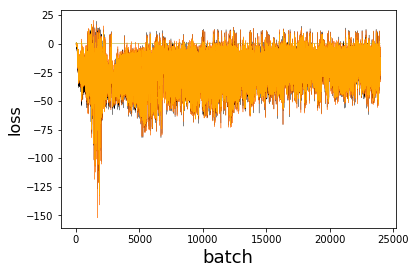

In [13]:
fig = plt.figure()
plt.plot([x[0] for x in gan.critic_valid_losses], color='black', linewidth=0.25)

plt.plot([x[1] for x in gan.critic_valid_losses], color='green', linewidth=0.25)
plt.plot([x[0] for x in gan.critic_generated_losses], color='red', linewidth=0.25)
plt.plot(gan.generator_losses, color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('loss', fontsize=16)

# plt.xlim(0, 2000)
# plt.ylim(0, 2)

plt.show()

In [14]:
def compare_images(img1, img2):
    return np.mean(np.abs(img1 - img2))

In [15]:

r, c = 5, 5

idx = np.random.randint(0, x_train.shape[0], BATCH_SIZE)
true_imgs = (x_train[idx] + 1) *0.5

fig, axs = plt.subplots(r, c, figsize=(15,15))
cnt = 0

for i in range(r):
    for j in range(c):
        axs[i,j].imshow(true_imgs[cnt], cmap = 'gray_r')
        axs[i,j].axis('off')
        cnt += 1
fig.savefig(os.path.join(RUN_FOLDER, "images/real.png"))
plt.close()

In [16]:
r, c = 5, 5
noise = np.random.normal(0, 1, (r * c, gan.latent_dim))
gen_imgs = gan.generator_model.predict(noise)

#Rescale images 0 - 1

gen_imgs = 0.5 * (gen_imgs + 1)
# gen_imgs = np.clip(gen_imgs, 0, 1)

fig, axs = plt.subplots(r, c, figsize=(15,15))
cnt = 0

for i in range(r):
    for j in range(c):
        axs[i,j].imshow(np.squeeze(gen_imgs[cnt, :,:,:]), cmap = 'gray_r')
        axs[i,j].axis('off')
        cnt += 1
fig.savefig(os.path.join(RUN_FOLDER, "images/sample.png"))
plt.close()


fig, axs = plt.subplots(r, c, figsize=(15,15))
cnt = 0

for i in range(r):
    for j in range(c):
        c_diff = 99999
        c_img = None
        for k_idx, k in enumerate((x_train + 1) * 0.5):
            
            diff = compare_images(gen_imgs[cnt, :,:,:], k)
            if diff < c_diff:
                c_img = np.copy(k)
                c_diff = diff
        axs[i,j].imshow(c_img, cmap = 'gray_r')
        axs[i,j].axis('off')
        cnt += 1

fig.savefig(os.path.join(RUN_FOLDER, "images/sample_closest.png"))
plt.close()